### Model Training Summary

#### Dataset
- **Train Data** includes outliers.

#### Base Model Training
- **Model Types**:  
  - *Linear Models*: Linear Regression, Ridge, Lasso  
  - *Bagging*: Random Forest  
  - *Boosting*: LightGBM, XGBoost, CatBoost
- **Hyperparameter Tuning**:  
  - Linear & Bagging: Manual combinational tuning  
  - Boosting: Optuna

#### Outlier Handling Approaches
- Repeat base model training
- **Decision**: Model trained **with outliers** performed better

#### Feature Selection (LightGBM)
- **Prior Filtering**: Kolmogorov-Smirnov statistic  
- **Post-training Filtering**: Remove features with importance based on percentiles and iteratively perform across a range 
- Retrain the LightGBM model

#### Model Averaging
- **Inputs**: Top models trained on data *with* outliers (excluding Linear)  
- **Weighted Averaging**: Bayesian Model Averaging  
  - Weight ∝ inverse RMSE  
  - Final target = weighted average of predictions

#### Model Stacking
- Use top model predictions as inputs to a meta-model


In [1]:
#Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
from tqdm import tqdm,tqdm_notebook
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.linear_model import Ridge, RidgeCV,LogisticRegression
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import gc
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split,KFold
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

### Importing feature engineered dataset

In [2]:
#Import the preprocessed dataset
train=pd.read_csv('train_engineered.csv', parse_dates=["first_active_month"])
test=pd.read_csv('test_engineered.csv', parse_dates=["first_active_month"])


In [5]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_class,hist_month_nunique,hist_hour_mean,hist_hour_min,hist_hour_max,hist_day_nunique,hist_weekend_sum,hist_weekend_mean,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_dayofweek_mean,hist_dayofweek_min,hist_dayofweek_max,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_price_nunique,hist_city_id_nunique,hist_state_id_nunique,hist_category_2=1.0_sum,hist_category_2=1.0_mean,hist_category_2=3.0_sum,hist_category_2=3.0_mean,hist_category_2=5.0_sum,hist_category_2=5.0_mean,hist_category_2=2.0_sum,hist_category_2=2.0_mean,hist_category_2=4.0_sum,hist_category_2=4.0_mean,hist_category_3=1.0_sum,hist_category_3=1.0_mean,hist_category_3=2.0_sum,hist_category_3=2.0_mean,hist_category_3=3.0_sum,hist_category_3=3.0_mean,hist_month_lag=-8_nunique,hist_month_lag=-7_nunique,hist_month_lag=-6_nunique,hist_month_lag=-5_nunique,hist_month_lag=-11_nunique,hist_month_lag=0_sum,hist_month_lag=0_mean,hist_month_lag=-3_nunique,hist_month_lag=-9_nunique,hist_month_lag=-4_nunique,hist_month_lag=-1_sum,hist_month_lag=-1_mean,hist_month_lag=-13_nunique,hist_month_lag=-10_nunique,hist_month_lag=-12_nunique,hist_month_lag=-2_sum,hist_month_lag=-2_mean,hist_EasterDay_2017_sum,hist_EasterDay_2017_mean,hist_AllSoulsDay_2017_sum,hist_AllSoulsDay_2017_mean,hist_ChristmasDay_2017_sum,hist_ChristmasDay_2017_mean,hist_FathersDay_2017_sum,hist_FathersDay_2017_mean,hist_ChildrenDay_2017_sum,hist_ChildrenDay_2017_mean,hist_BlackFriday_2017_sum,hist_BlackFriday_2017_mean,hist_ValentineDay_2017_sum,hist_ValentineDay_2017_mean,hist_MothersDay_2018_sum,hist_MothersDay_2018_mean,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_installments_std,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_mean,hist_month_lag_std,hist_month_lag_min,hist_month_lag_max,hist_month_lag_skew,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_installments_quantiles_var,hist_installments_quantiles_mean,hist_installments_quantiles_skew,hist_purchase_amount_quantiles_var,hist_purchase_amount_quantiles_mean,hist_purchase_amount_quantiles_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_std,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_skew,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_of_hist_purchase_date_average,hist_purchase_amount_diff,hist_purchase_count_ratio,hist_purchase_recency,hist_category_2_pa_mean,hist_category_3_pa_mean,hist_merchant_id_count_mean,hist_month_lag_0_-1_ratio,hist_month_lag_0_-2_ratio,new_hist_month_nunique,new_hist_hour_mean,new_hist_hour_min,new_hist_hour_max,new_hist_day_nunique,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_weekofyear_mean,new_hist_weekofyear_min,new_hist_weekofyear_max,new_hist_dayofweek_mean,new_hist_dayofweek_min,new_hist_dayofweek_max,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_price_nunique,new_hist_city_id_nunique,new_hist_state_id_nunique,new_hist_category_2=1.0_sum,new_hist_category_2=1.0_mean,new_hist_category_2=3.0_sum,new_hist_category_2=3.0_mean,new_hist_category_2=2.0_sum,new_hist_category_2=2.0_mean,new_hist_category_2=4.0_sum,new_hist_category_2=4.0_mean,new_hist_category_2=5.0_sum,new_hist_category_2=5.0_mean,new_hist_category_3=2.0_sum,new_hist_category_3=2.0_mean,new_hist_category_3=1.0_sum,new_hist_category_3=1.0_mean,new_hist_category_3=3.0_sum,new_hist_category_3=3.0_mean,new_hist_month_lag=1_sum,new_hist_month_lag=1_mean,new_hist_month_lag=2_sum,new_hist_month_lag=2_mean,new_hist_EasterDay_2017_sum,new_his

In [6]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_month_nunique,hist_hour_mean,hist_hour_min,hist_hour_max,hist_day_nunique,hist_weekend_sum,hist_weekend_mean,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_dayofweek_mean,hist_dayofweek_min,hist_dayofweek_max,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_price_nunique,hist_city_id_nunique,hist_state_id_nunique,hist_category_2=1.0_sum,hist_category_2=1.0_mean,hist_category_2=3.0_sum,hist_category_2=3.0_mean,hist_category_2=5.0_sum,hist_category_2=5.0_mean,hist_category_2=2.0_sum,hist_category_2=2.0_mean,hist_category_2=4.0_sum,hist_category_2=4.0_mean,hist_category_3=1.0_sum,hist_category_3=1.0_mean,hist_category_3=2.0_sum,hist_category_3=2.0_mean,hist_category_3=3.0_sum,hist_category_3=3.0_mean,hist_month_lag=-8_nunique,hist_month_lag=-7_nunique,hist_month_lag=-6_nunique,hist_month_lag=-5_nunique,hist_month_lag=-11_nunique,hist_month_lag=0_sum,hist_month_lag=0_mean,hist_month_lag=-3_nunique,hist_month_lag=-9_nunique,hist_month_lag=-4_nunique,hist_month_lag=-1_sum,hist_month_lag=-1_mean,hist_month_lag=-13_nunique,hist_month_lag=-10_nunique,hist_month_lag=-12_nunique,hist_month_lag=-2_sum,hist_month_lag=-2_mean,hist_EasterDay_2017_sum,hist_EasterDay_2017_mean,hist_AllSoulsDay_2017_sum,hist_AllSoulsDay_2017_mean,hist_ChristmasDay_2017_sum,hist_ChristmasDay_2017_mean,hist_FathersDay_2017_sum,hist_FathersDay_2017_mean,hist_ChildrenDay_2017_sum,hist_ChildrenDay_2017_mean,hist_BlackFriday_2017_sum,hist_BlackFriday_2017_mean,hist_ValentineDay_2017_sum,hist_ValentineDay_2017_mean,hist_MothersDay_2018_sum,hist_MothersDay_2018_mean,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_installments_std,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_mean,hist_month_lag_std,hist_month_lag_min,hist_month_lag_max,hist_month_lag_skew,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_installments_quantiles_var,hist_installments_quantiles_mean,hist_installments_quantiles_skew,hist_purchase_amount_quantiles_var,hist_purchase_amount_quantiles_mean,hist_purchase_amount_quantiles_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_std,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_skew,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_of_hist_purchase_date_average,hist_purchase_amount_diff,hist_purchase_count_ratio,hist_purchase_recency,hist_category_2_pa_mean,hist_category_3_pa_mean,hist_merchant_id_count_mean,hist_month_lag_0_-1_ratio,hist_month_lag_0_-2_ratio,new_hist_month_nunique,new_hist_hour_mean,new_hist_hour_min,new_hist_hour_max,new_hist_day_nunique,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_weekofyear_mean,new_hist_weekofyear_min,new_hist_weekofyear_max,new_hist_dayofweek_mean,new_hist_dayofweek_min,new_hist_dayofweek_max,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_price_nunique,new_hist_city_id_nunique,new_hist_state_id_nunique,new_hist_category_2=1.0_sum,new_hist_category_2=1.0_mean,new_hist_category_2=3.0_sum,new_hist_category_2=3.0_mean,new_hist_category_2=2.0_sum,new_hist_category_2=2.0_mean,new_hist_category_2=4.0_sum,new_hist_category_2=4.0_mean,new_hist_category_2=5.0_sum,new_hist_category_2=5.0_mean,new_hist_category_3=2.0_sum,new_hist_category_3=2.0_mean,new_hist_category_3=1.0_sum,new_hist_category_3=1.0_mean,new_hist_category_3=3.0_sum,new_hist_category_3=3.0_mean,new_hist_month_lag=1_sum,new_hist_month_lag=1_mean,new_hist_month_lag=2_sum,new_hist_month_lag=2_mean,new_hist_EasterDay_2017_sum,new_hist_EasterDay_2017_mea

In [3]:
def reduce_mem_usage(df, verbose=True):
    numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    initial_memory = df.memory_usage().sum() / 1024**2

    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numeric_types:
            col_min = df[column].min()
            col_max = df[column].max()

            if str(column_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    final_memory = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1%} reduction)'.format(
            final_memory, (initial_memory - final_memory) / initial_memory
        ))

    return df



In [4]:
#Reducing the memory storage
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Mem. usage decreased to 151.35 Mb (59.4% reduction)
Mem. usage decreased to 93.73 Mb (58.4% reduction)


### Helper functions

In [5]:
#Determing the relevent columns for modelling: remove target column, outlier column and identifier column
def derive_columns(train_df, test_df):
    train_features = [col for col in train_df.columns if col not in ['card_id', 'first_active_month', 'target', 'outliers']]
    test_features = [col for col in test_df.columns if col not in ['card_id', 'first_active_month', 'target', 'outliers']]
    return train_features, test_features

df_train_columns, df_test_columns = derive_columns(train, test)


In [6]:
# Filling missing and infinite values using median
def fillup_null_values(train_df, test_df, train_features, test_features):
    test_df['first_active_month'].fillna('2017-06-01', inplace=True)

    for feature in train_features:
        train_df[feature].fillna(train_df[feature].median(), inplace=True)

    for feature in test_features:
        test_df[feature].fillna(test_df[feature].median(), inplace=True)

    train_df = train_df.replace(np.inf, np.nan)
    test_df = test_df.replace(np.inf, np.nan)

    purchase_amount_columns = [
        'new_hist_purchase_amount_sum', 'new_hist_purchase_amount_min', 'new_hist_purchase_amount_mean',
        'new_hist_purchase_amount_max', 'new_hist_purchase_amount_var', 'new_hist_purchase_amount_diff',
        'purchase_amount_total'
    ]

    for col in purchase_amount_columns:
        train_df[col].fillna(train_df[col].median(), inplace=True)
        test_df[col].fillna(train_df[col].median(), inplace=True)

    return train_df, test_df

train, test = fillup_null_values(train, test, df_train_columns, df_test_columns)


### Checking to make sure all the missing values are filled up

In [7]:
# Check for missing values in train
train_null_counts = train.isnull().sum()
train_null_info = pd.DataFrame({
    "nulls": train_null_counts,
    "null_percent": train_null_counts * 100 / train.shape[0]
})
print("Train Nulls:")
display(train_null_info[train_null_info.nulls != 0])

# Check for missing values in test
test_null_counts = test.isnull().sum()
test_null_info = pd.DataFrame({
    "nulls": test_null_counts,
    "null_percent": test_null_counts * 100 / test.shape[0]
})
print("Test Nulls:")
display(test_null_info[test_null_info.nulls != 0])

# Check for infinite values in train (only in feature columns)
train_inf_counts = np.isinf(train[df_train_columns]).sum()
train_inf_info = pd.DataFrame({
    "nulls": train_inf_counts,
    "null_percent": train_inf_counts * 100 / train.shape[0]
})
print("Train Infinities:")
display(train_inf_info[train_inf_info.nulls != 0])

# Check for infinite values in test (only in feature columns)
test_inf_counts = np.isinf(test[df_test_columns]).sum()
test_inf_info = pd.DataFrame({
    "nulls": test_inf_counts,
    "null_percent": test_inf_counts * 100 / test.shape[0]
})
print("Test Infinities:")
display(test_inf_info[test_inf_info.nulls != 0])


Train Nulls:


,nulls,null_percent


Test Nulls:


,nulls,null_percent


Train Infinities:


,nulls,null_percent


Test Infinities:


,nulls,null_percent


### Train-test columns

In [8]:
# Extract features and target
outliers = train['outliers']
y = train['target']
X = train[df_train_columns].copy()

# Drop unwanted feature if it exists
if "target_class" in X.columns:
    X.drop("target_class", axis=1, inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("X_train, X_test, y_train, y_test_com shapes:")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


X_train, X_test, y_train, y_test_com shapes:
(161533, 237) (40384, 237) (161533,) (40384,)


## Base Modelling
- Linear Models: Linear, Ridge, Lasso
- Bagging Models: Random Forest
- Boosting Models: Lightgbm, XgBoost, Catboost

In [9]:
# RMSE calculator
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Linear Models


### Linear Regression

In [23]:
# Linear Regression
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train) #training the algorithm
y_pred_linear = regressor.predict(X_test)
rmse_linear=rmse(y_test, y_pred_linear)
print("RMSE using linear regression::{:.3f}".format(rmse_linear))
linear_test_pred=regressor.predict(test[df_test_columns])

RMSE using linear regression::3.876


In [24]:
# Getting the feature importance dataframe and rmse
coef = regressor.coef_
feature_importance_df_linear = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coef,
    'Importance (abs)': np.abs(coef)
}).sort_values(by='Importance (abs)', ascending=False)

linear = pd.DataFrame({
    'card_id': test['card_id'],
    'target': linear_test_pred
})

linear.isnull().sum()


card_id    0
target     0
dtype: int64

In [25]:
print(linear)
linear.to_csv("linear_latest.csv", index=False)

                card_id    target
0       C_ID_0ab67a22ab -0.392636
1       C_ID_130fd0cbdd -0.392636
2       C_ID_b709037bc5 -0.392636
3       C_ID_d27d835a9f -0.392636
4       C_ID_2b5e3df5c2 -0.392636
...                 ...       ...
123618  C_ID_7a239d2eda -0.392636
123619  C_ID_75ace375ae -0.392636
123620  C_ID_21d56d950c -0.392636
123621  C_ID_6c46fc5a9d -0.392636
123622  C_ID_87e7979a5f -0.392636

[123623 rows x 2 columns]


### Ridge Regression

In [26]:
#Ridge Regression
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha': [1e-4, 1e-3, 1e-2, 0.1, 1, 10]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ridge_regressor.fit(X_train, y_train)
y_pred_ridge = ridge_regressor.predict(X_test)
rmse_ridge=rmse(y_test, y_pred_ridge)
print("Best alpha:", ridge_regressor.best_params_['alpha'])
print("RMSE using Ridge Regression: {:.3f}".format(rmse_ridge))

ridge_test_pred = ridge_regressor.predict(test[df_test_columns])

Best alpha: 0.001
RMSE using Ridge Regression: 3.866


In [27]:
coef = ridge_regressor.best_estimator_.coef_
feature_importance_df_ridge = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coef,
    'Importance (abs)': np.abs(coef)
}).sort_values(by='Importance (abs)', ascending=False)

ridge = pd.DataFrame({
    'card_id': test['card_id'],
    'target': ridge_test_pred
})

ridge.isnull().sum()

card_id    0
target     0
dtype: int64

In [29]:
print(ridge)
ridge.to_csv("ridge_latest.csv", index=False)

                card_id    target
0       C_ID_0ab67a22ab -1.121094
1       C_ID_130fd0cbdd -0.212891
2       C_ID_b709037bc5 -1.670898
3       C_ID_d27d835a9f -0.887695
4       C_ID_2b5e3df5c2 -2.569336
...                 ...       ...
123618  C_ID_7a239d2eda  1.839844
123619  C_ID_75ace375ae  0.496094
123620  C_ID_21d56d950c  1.111328
123621  C_ID_6c46fc5a9d -3.803711
123622  C_ID_87e7979a5f -0.849609

[123623 rows x 2 columns]


### Lasso Regression

In [30]:
from sklearn.linear_model import Lasso
lasso = Lasso()
parameters = {'alpha': [1e-3, 1e-2, 1e-1], 'max_iter': [1000, 2000]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_root_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

y_pred_lasso = lasso_regressor.predict(X_test)
rmse_lasso=rmse(y_test, y_pred_lasso)
print("RMSE for Lasso Regressor: {:.3f}".format(rmse_lasso))

lasso_test_pred = lasso_regressor.predict(test[df_test_columns])

RMSE for Lasso Regressor: 3.796


In [31]:
coef = lasso_regressor.best_estimator_.coef_
feature_importance_df_lasso = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coef,
    'Importance (abs)': np.abs(coef)
}).sort_values(by='Importance (abs)', ascending=False)

lasso = pd.DataFrame({
    'card_id': test['card_id'],
    'target': lasso_test_pred
})
lasso.isnull().sum()

card_id    0
target     0
dtype: int64

In [32]:
print(lasso)
lasso.to_csv("lasso_latest.csv", index=False)

                card_id    target
0       C_ID_0ab67a22ab -1.209412
1       C_ID_130fd0cbdd  0.570984
2       C_ID_b709037bc5 -0.822876
3       C_ID_d27d835a9f -0.099731
4       C_ID_2b5e3df5c2 -3.321167
...                 ...       ...
123618  C_ID_7a239d2eda  0.637451
123619  C_ID_75ace375ae -0.062927
123620  C_ID_21d56d950c  0.017883
123621  C_ID_6c46fc5a9d -2.118347
123622  C_ID_87e7979a5f -0.049866

[123623 rows x 2 columns]


## Bagging Models

In [33]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    "criterion": ["squared_error"],
    "n_estimators": [500, 1000],
    "max_depth": [5, 10, 15],
    "max_leaf_nodes": [5],
    "min_samples_split": [8],
    "max_features": [50, 100],
    "min_impurity_decrease": [0.1]
}

forestRegressor = RandomForestRegressor(random_state=10)
grid_forest = GridSearchCV(forestRegressor, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_forest.fit(X_train, y_train)

y_pred_forest = grid_forest.predict(X_test)
rmse_rf=rmse(y_test, y_pred_forest)
print("RMSE for Random Forest Regressor: {:.3f}".format(rmse(y_test, y_pred_forest)))

random_forest_test_pred = grid_forest.predict(test[df_test_columns])

Fitting 2 folds for each of 12 candidates, totalling 24 fits
RMSE for Random Forest Regressor: 3.797


In [34]:
best_rf_model = grid_forest.best_estimator_

feature_importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

rf= pd.DataFrame({
    'card_id': test['card_id'],
    'target': random_forest_test_pred
})

rf.isnull().sum()

card_id    0
target     0
dtype: int64

In [35]:
print(rf)
rf.to_csv("latest.csv", index=False)

                card_id    target
0       C_ID_0ab67a22ab -3.382173
1       C_ID_130fd0cbdd -0.110156
2       C_ID_b709037bc5 -0.110156
3       C_ID_d27d835a9f -0.110156
4       C_ID_2b5e3df5c2 -0.110156
...                 ...       ...
123618  C_ID_7a239d2eda -0.110156
123619  C_ID_75ace375ae -0.110156
123620  C_ID_21d56d950c -0.110156
123621  C_ID_6c46fc5a9d -1.275551
123622  C_ID_87e7979a5f -0.110156

[123623 rows x 2 columns]


## Boosting Models

### Lightgbm 

In [9]:
import lightgbm
from lightgbm import early_stopping, log_evaluation
import optuna

In [10]:
## Reference: https://github.com/optuna/optuna/blob/master/examples/lightgbm_simple.py
def objectivelgbm(trial):
    # Define hyperparameters to optimize
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': -1,
        'learning_rate': 0.01,
        'device': 'cpu',
        'seed': 326,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.001, 1),
        'subsample': trial.suggest_uniform('subsample', 0.001, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 10),
        'min_split_gain': trial.suggest_uniform('min_split_gain', 0, 10),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 45),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 16, 64)
    }

    # Create LightGBM dataset
    dtrain = lightgbm.Dataset(X_train, label=y_train, free_raw_data=False)
    ## creating folds so, training and validation can be done in folds of data
    folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    # Perform cross-validation
    cv_results = lightgbm.cv(
        params=params,
        train_set=dtrain,
        num_boost_round=10000,
        nfold=3,
        folds = KFold(n_splits=3, shuffle=True, random_state=42),
        seed=47,
        stratified=False,
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100)
        ]
    )

    gc.collect()

    # Debug output (optional)
    print("CV Result Keys:", cv_results.keys())

    # Return the RMSE or L2 mean
    for key in cv_results:
        if "rmse-mean" in key or "l2-mean" in key:
            return cv_results[key][-1]

    raise KeyError("Expected metric 'rmse-mean' or 'l2-mean' not found in cv_results.")


In [11]:
## Reference: https://colab.research.google.com/drive/1I8abciKFXBxkoXrcwLiG7_BrYskLnV8k#scrollTo=8lOM3b6iO3it

# This class is used to implement early stopping in Optuna trials
OPTUNA_EARLY_STOPPING = 20

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop_limit = OPTUNA_EARLY_STOPPING
    early_stop_counter = 0
    best_score_so_far = None

def early_stopping_opt(study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
    if EarlyStoppingExceeded.best_score_so_far is None:
        EarlyStoppingExceeded.best_score_so_far = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score_so_far:
        # New best score found — reset counter
        EarlyStoppingExceeded.best_score_so_far = study.best_value
        EarlyStoppingExceeded.early_stop_counter = 0
    else:
        # No improvement
        EarlyStoppingExceeded.early_stop_counter += 1
        if EarlyStoppingExceeded.early_stop_counter > EarlyStoppingExceeded.early_stop_limit:
            # Reset for potential reuse
            EarlyStoppingExceeded.early_stop_counter = 0
            EarlyStoppingExceeded.best_score_so_far = None
            raise EarlyStoppingExceeded()

    print(
        f"EarlyStop counter currently is: {EarlyStoppingExceeded.early_stop_counter}, "
        f"The current Best score is: {study.best_value} | Overall best: {EarlyStoppingExceeded.best_score_so_far}"
    )


In [12]:
# === Run Optuna Study ===
results = optuna.create_study(direction='minimize')

try:
    results.optimize(objectivelgbm, n_trials=100, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f" Early stopping is triggered: No improvement for the past {OPTUNA_EARLY_STOPPING} trials.")

gc.collect()

[I 2025-04-21 15:46:30,806] A new study created in memory with name: no-name-8273b4f0-172b-491b-8b37-b72c92f97b42


Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.74775 + 0.035239
[200]	valid's rmse: 3.71591 + 0.0339742
[300]	valid's rmse: 3.70099 + 0.0332309
[400]	valid's rmse: 3.69299 + 0.0327603
[500]	valid's rmse: 3.68765 + 0.0324608
[600]	valid's rmse: 3.68387 + 0.0320003
[700]	valid's rmse: 3.68088 + 0.0317558
[800]	valid's rmse: 3.67863 + 0.031569
[900]	valid's rmse: 3.67681 + 0.0313775
[1000]	valid's rmse: 3.67541 + 0.0313664
[1100]	valid's rmse: 3.67416 + 0.0312548
[1200]	valid's rmse: 3.67304 + 0.0311451
[1300]	valid's rmse: 3.67216 + 0.0310509
[1400]	valid's rmse: 3.67137 + 0.0309406
[1500]	valid's rmse: 3.67063 + 0.0307514
[1600]	valid's rmse: 3.67001 + 0.0307044
[1700]	valid's rmse: 3.66945 + 0.0306508
[1800]	valid's rmse: 3.66892 + 0.0306165
[1900]	valid's rmse: 3.66836 + 0.0304733
[2000]	valid's rmse: 3.66801 + 0.0304594
[2100]	valid's rmse: 3.66756 + 0.0302697
[2200]	valid's rmse: 3.66702 + 0.0301081
[2300]	valid's rmse: 3.66668 + 0.0300874
[2400]

[I 2025-04-21 15:47:16,974] Trial 0 finished with value: 3.6642062311729426 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.4906566574984655, 'subsample': 0.7029342738521519, 'max_depth': 3, 'reg_alpha': 9.157310857928474, 'reg_lambda': 5.761550213484526, 'min_split_gain': 3.7509052373466445, 'min_child_weight': 34.39170142982603, 'min_data_in_leaf': 39}. Best is trial 0 with value: 3.6642062311729426.


Early stopping, best iteration is:
[4074]	valid's rmse: 3.66421 + 0.0287549
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 1, The current Best score is: 3.6642062311729426 | Overall best: 3.6642062311729426
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.77482 + 0.0363767
[200]	valid's rmse: 3.74973 + 0.0356961
[300]	valid's rmse: 3.73638 + 0.0354658
[400]	valid's rmse: 3.72745 + 0.0354632
[500]	valid's rmse: 3.72116 + 0.0353538
[600]	valid's rmse: 3.71625 + 0.0351608
[700]	valid's rmse: 3.71257 + 0.0348035
[800]	valid's rmse: 3.70956 + 0.0346007
[900]	valid's rmse: 3.70717 + 0.0343942
[1000]	valid's rmse: 3.70501 + 0.0342452
[1100]	valid's rmse: 3.70312 + 0.0341093
[1200]	valid's rmse: 3.7015 + 0.0340201
[1300]	valid's rmse: 3.70012 + 0.0339025
[1400]	valid's rmse: 3.69889 + 0.0338568
[1500]	valid's rmse: 3.69774 + 0.0337482
[1600]	valid's rmse: 3.69673 + 0.0337067
[1700]	valid's rmse: 3.69578 + 0.0

[I 2025-04-21 15:48:12,268] Trial 1 finished with value: 3.682318959326736 and parameters: {'num_leaves': 26, 'colsample_bytree': 0.3279047628045009, 'subsample': 0.523406313172624, 'max_depth': 2, 'reg_alpha': 1.4289962013927149, 'reg_lambda': 7.825257296288725, 'min_split_gain': 8.020088054213709, 'min_child_weight': 14.259725742063814, 'min_data_in_leaf': 55}. Best is trial 0 with value: 3.6642062311729426.


CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 2, The current Best score is: 3.6642062311729426 | Overall best: 3.6642062311729426
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.80674 + 0.0375929
[200]	valid's rmse: 3.79312 + 0.0372804
[300]	valid's rmse: 3.7842 + 0.0370702
[400]	valid's rmse: 3.77755 + 0.0369062
[500]	valid's rmse: 3.77242 + 0.0367991
[600]	valid's rmse: 3.76838 + 0.0367613
[700]	valid's rmse: 3.76511 + 0.0367171
[800]	valid's rmse: 3.76235 + 0.036644
[900]	valid's rmse: 3.75994 + 0.0366006
[1000]	valid's rmse: 3.75779 + 0.0365485
[1100]	valid's rmse: 3.75586 + 0.0365065
[1200]	valid's rmse: 3.75406 + 0.0364413
[1300]	valid's rmse: 3.75242 + 0.0364004
[1400]	valid's rmse: 3.75097 + 0.0363568
[1500]	valid's rmse: 3.74963 + 0.0363119
[1600]	valid's rmse: 3.74841 + 0.0363049
[1700]	valid's rmse: 3.74726 + 0.0362895
[1800]	valid's rmse: 3.7462 + 0.0362562
[1900]	valid's rmse: 3.74522 +

[I 2025-04-21 15:49:22,859] Trial 2 finished with value: 3.7223713334505075 and parameters: {'num_leaves': 24, 'colsample_bytree': 0.5401707174494849, 'subsample': 0.23960936456374393, 'max_depth': 1, 'reg_alpha': 1.2842258444671906, 'reg_lambda': 4.260126926348745, 'min_split_gain': 3.959708113041552, 'min_child_weight': 29.525206675760924, 'min_data_in_leaf': 29}. Best is trial 0 with value: 3.6642062311729426.


[10000]	valid's rmse: 3.72237 + 0.0350507
Did not meet early stopping. Best iteration is:
[10000]	valid's rmse: 3.72237 + 0.0350507
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 3, The current Best score is: 3.6642062311729426 | Overall best: 3.6642062311729426
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.70586 + 0.0334941
[200]	valid's rmse: 3.67245 + 0.0321292
[300]	valid's rmse: 3.66143 + 0.0315512
[400]	valid's rmse: 3.65676 + 0.030799
[500]	valid's rmse: 3.65506 + 0.0303017
[600]	valid's rmse: 3.65424 + 0.0297755
[700]	valid's rmse: 3.65333 + 0.0293881
[800]	valid's rmse: 3.65287 + 0.0289331
[900]	valid's rmse: 3.65251 + 0.0284988
[1000]	valid's rmse: 3.65243 + 0.0283441
[1100]	valid's rmse: 3.65252 + 0.0281824


[I 2025-04-21 15:49:48,446] Trial 3 finished with value: 3.6523320773973844 and parameters: {'num_leaves': 62, 'colsample_bytree': 0.67951082278091, 'subsample': 0.028796678633287838, 'max_depth': 6, 'reg_alpha': 2.7356631107978266, 'reg_lambda': 7.9495841894215395, 'min_split_gain': 8.467485744295034, 'min_child_weight': 7.496034679939047, 'min_data_in_leaf': 20}. Best is trial 3 with value: 3.6523320773973844.


Early stopping, best iteration is:
[965]	valid's rmse: 3.65233 + 0.0284167
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 0, The current Best score is: 3.6523320773973844 | Overall best: 3.6523320773973844
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.80995 + 0.0374374
[200]	valid's rmse: 3.79714 + 0.0372277
[300]	valid's rmse: 3.7881 + 0.0370632
[400]	valid's rmse: 3.7812 + 0.0369407
[500]	valid's rmse: 3.77583 + 0.0368672
[600]	valid's rmse: 3.77146 + 0.036779
[700]	valid's rmse: 3.76776 + 0.0366711
[800]	valid's rmse: 3.76477 + 0.0365842
[900]	valid's rmse: 3.76218 + 0.0365623
[1000]	valid's rmse: 3.7599 + 0.0365531
[1100]	valid's rmse: 3.75781 + 0.0364877
[1200]	valid's rmse: 3.75593 + 0.0364041
[1300]	valid's rmse: 3.7542 + 0.0363297
[1400]	valid's rmse: 3.75269 + 0.036263
[1500]	valid's rmse: 3.75135 + 0.036225
[1600]	valid's rmse: 3.75006 + 0.0361733
[1700]	valid's rmse: 3.74889 + 0.0361387


[I 2025-04-21 15:50:26,698] Trial 4 finished with value: 3.7228520514447667 and parameters: {'num_leaves': 53, 'colsample_bytree': 0.15451124364423524, 'subsample': 0.6180584313434653, 'max_depth': 1, 'reg_alpha': 7.686851893261943, 'reg_lambda': 1.8552171590831856, 'min_split_gain': 0.21671599843512968, 'min_child_weight': 3.309548038391468, 'min_data_in_leaf': 64}. Best is trial 3 with value: 3.6523320773973844.


[10000]	valid's rmse: 3.72285 + 0.0349937
Did not meet early stopping. Best iteration is:
[10000]	valid's rmse: 3.72285 + 0.0349937
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 1, The current Best score is: 3.6523320773973844 | Overall best: 3.6523320773973844
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.70551 + 0.0337809
[200]	valid's rmse: 3.67236 + 0.0329626
[300]	valid's rmse: 3.66194 + 0.0314246
[400]	valid's rmse: 3.65707 + 0.0301178
[500]	valid's rmse: 3.65523 + 0.0298035
[600]	valid's rmse: 3.65445 + 0.0292728
[700]	valid's rmse: 3.65399 + 0.0290707
[800]	valid's rmse: 3.65354 + 0.0288883
[900]	valid's rmse: 3.65341 + 0.0286747
[1000]	valid's rmse: 3.6537 + 0.0289578


[I 2025-04-21 15:50:53,818] Trial 5 finished with value: 3.6533851233934875 and parameters: {'num_leaves': 56, 'colsample_bytree': 0.8095254634633988, 'subsample': 0.2746061213513488, 'max_depth': 8, 'reg_alpha': 6.1366373066360955, 'reg_lambda': 7.204054633173108, 'min_split_gain': 4.745124630704929, 'min_child_weight': 12.95775278572205, 'min_data_in_leaf': 41}. Best is trial 3 with value: 3.6523320773973844.


Early stopping, best iteration is:
[858]	valid's rmse: 3.65339 + 0.0287793
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 2, The current Best score is: 3.6523320773973844 | Overall best: 3.6523320773973844
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.70947 + 0.0338588
[200]	valid's rmse: 3.67428 + 0.0325246
[300]	valid's rmse: 3.66194 + 0.0312746
[400]	valid's rmse: 3.65664 + 0.0308729
[500]	valid's rmse: 3.65409 + 0.0306779
[600]	valid's rmse: 3.65265 + 0.0303785
[700]	valid's rmse: 3.65176 + 0.0301237
[800]	valid's rmse: 3.65095 + 0.029999
[900]	valid's rmse: 3.65054 + 0.0297634
[1000]	valid's rmse: 3.65019 + 0.029782
[1100]	valid's rmse: 3.64994 + 0.0296852
[1200]	valid's rmse: 3.64996 + 0.0296397
[1300]	valid's rmse: 3.6498 + 0.0295903
[1400]	valid's rmse: 3.64984 + 0.0295431
[1500]	valid's rmse: 3.64999 + 0.0294332


[I 2025-04-21 15:51:16,526] Trial 6 finished with value: 3.6497535991342627 and parameters: {'num_leaves': 61, 'colsample_bytree': 0.4276349712856633, 'subsample': 0.8375512213670602, 'max_depth': 6, 'reg_alpha': 6.548900529933036, 'reg_lambda': 6.728810124639134, 'min_split_gain': 7.882720918442249, 'min_child_weight': 16.56497493186302, 'min_data_in_leaf': 45}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1331]	valid's rmse: 3.64975 + 0.0295309
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 0, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71591 + 0.0350782
[200]	valid's rmse: 3.68187 + 0.0334318
[300]	valid's rmse: 3.66816 + 0.0323976
[400]	valid's rmse: 3.66072 + 0.0318408
[500]	valid's rmse: 3.65673 + 0.031094
[600]	valid's rmse: 3.65447 + 0.0307917
[700]	valid's rmse: 3.65326 + 0.0306778
[800]	valid's rmse: 3.6525 + 0.0305674
[900]	valid's rmse: 3.65185 + 0.030269
[1000]	valid's rmse: 3.65136 + 0.0301853
[1100]	valid's rmse: 3.65102 + 0.0300277
[1200]	valid's rmse: 3.65102 + 0.0298459
[1300]	valid's rmse: 3.65121 + 0.0296308


[I 2025-04-21 15:51:37,334] Trial 7 finished with value: 3.6509239787301575 and parameters: {'num_leaves': 29, 'colsample_bytree': 0.4763385981434082, 'subsample': 0.9838626437596595, 'max_depth': 9, 'reg_alpha': 1.121797104753105, 'reg_lambda': 7.961603210671257, 'min_split_gain': 4.728102950976238, 'min_child_weight': 2.2868978527298074, 'min_data_in_leaf': 57}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1130]	valid's rmse: 3.65092 + 0.0299483
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 1, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71518 + 0.0348626
[200]	valid's rmse: 3.68159 + 0.0332671
[300]	valid's rmse: 3.66843 + 0.0329851
[400]	valid's rmse: 3.66144 + 0.0321156
[500]	valid's rmse: 3.65736 + 0.0317088
[600]	valid's rmse: 3.65527 + 0.0312028
[700]	valid's rmse: 3.65385 + 0.0307975
[800]	valid's rmse: 3.6532 + 0.0306635
[900]	valid's rmse: 3.65275 + 0.0304227
[1000]	valid's rmse: 3.65224 + 0.0302669
[1100]	valid's rmse: 3.65187 + 0.0300545
[1200]	valid's rmse: 3.65163 + 0.030058
[1300]	valid's rmse: 3.65171 + 0.0298365
[1400]	valid's rmse: 3.65187 + 0.0296582


[I 2025-04-21 15:52:07,759] Trial 8 finished with value: 3.651596089127329 and parameters: {'num_leaves': 27, 'colsample_bytree': 0.5995280645110045, 'subsample': 0.7157734880558585, 'max_depth': 11, 'reg_alpha': 6.733364269321134, 'reg_lambda': 8.67093282195492, 'min_split_gain': 4.636752147233418, 'min_child_weight': 25.575897269284937, 'min_data_in_leaf': 59}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1220]	valid's rmse: 3.6516 + 0.030033
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 2, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.7173 + 0.0337275
[200]	valid's rmse: 3.68484 + 0.0328212
[300]	valid's rmse: 3.67174 + 0.0319333
[400]	valid's rmse: 3.66516 + 0.0312629
[500]	valid's rmse: 3.66155 + 0.0303241
[600]	valid's rmse: 3.65959 + 0.0298405
[700]	valid's rmse: 3.65847 + 0.0296131
[800]	valid's rmse: 3.65759 + 0.0294841
[900]	valid's rmse: 3.65704 + 0.0295846
[1000]	valid's rmse: 3.65659 + 0.0295438
[1100]	valid's rmse: 3.65636 + 0.0294473
[1200]	valid's rmse: 3.65615 + 0.0292863
[1300]	valid's rmse: 3.65613 + 0.0292195
[1400]	valid's rmse: 3.65609 + 0.0290335
[1500]	valid's rmse: 3.656 + 0.0288309
[1600]	valid's rmse: 3.65625 + 0.0286565


[I 2025-04-21 15:52:40,401] Trial 9 finished with value: 3.6559676270980996 and parameters: {'num_leaves': 24, 'colsample_bytree': 0.8909756583633489, 'subsample': 0.8172668535192549, 'max_depth': 10, 'reg_alpha': 2.5914307121991556, 'reg_lambda': 2.2359140772922914, 'min_split_gain': 8.874417984331957, 'min_child_weight': 33.0330564688089, 'min_data_in_leaf': 21}. Best is trial 6 with value: 3.6497535991342627.


[1700]	valid's rmse: 3.65641 + 0.0286376
Early stopping, best iteration is:
[1503]	valid's rmse: 3.65597 + 0.0288069
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 3, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.78429 + 0.0371537
[200]	valid's rmse: 3.75123 + 0.036671
[300]	valid's rmse: 3.73139 + 0.036048
[400]	valid's rmse: 3.71868 + 0.0356237
[500]	valid's rmse: 3.70921 + 0.0351396
[600]	valid's rmse: 3.70242 + 0.0349214
[700]	valid's rmse: 3.69608 + 0.0345911
[800]	valid's rmse: 3.69138 + 0.0344358
[900]	valid's rmse: 3.68776 + 0.0343059
[1000]	valid's rmse: 3.68475 + 0.0342097
[1100]	valid's rmse: 3.68218 + 0.0341833
[1200]	valid's rmse: 3.68014 + 0.0340321
[1300]	valid's rmse: 3.67812 + 0.0338573
[1400]	valid's rmse: 3.67687 + 0.0336972
[1500]	valid's rmse: 3.67537 + 0.0336655
[1600]	valid's rmse: 3.67424 + 0.03

[I 2025-04-21 15:53:06,241] Trial 10 finished with value: 3.666643598739771 and parameters: {'num_leaves': 39, 'colsample_bytree': 0.0338579303502719, 'subsample': 0.9672949258069266, 'max_depth': 5, 'reg_alpha': 4.40886826109604, 'reg_lambda': 4.478391715400955, 'min_split_gain': 6.869152365028446, 'min_child_weight': 44.733838769838414, 'min_data_in_leaf': 48}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[3589]	valid's rmse: 3.66664 + 0.0326575
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 4, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71511 + 0.0356893
[200]	valid's rmse: 3.67927 + 0.0340549
[300]	valid's rmse: 3.66548 + 0.0330222
[400]	valid's rmse: 3.65885 + 0.0324539
[500]	valid's rmse: 3.65505 + 0.0322859
[600]	valid's rmse: 3.65304 + 0.0317298
[700]	valid's rmse: 3.65188 + 0.0315672
[800]	valid's rmse: 3.65101 + 0.031087
[900]	valid's rmse: 3.65063 + 0.0308916
[1000]	valid's rmse: 3.65048 + 0.0307067
[1100]	valid's rmse: 3.65024 + 0.0306309
[1200]	valid's rmse: 3.65019 + 0.0304315
[1300]	valid's rmse: 3.65006 + 0.0303556
[1400]	valid's rmse: 3.65019 + 0.0302482


[I 2025-04-21 15:53:27,628] Trial 11 finished with value: 3.650026895600351 and parameters: {'num_leaves': 39, 'colsample_bytree': 0.3519120277987564, 'subsample': 0.9768533379098526, 'max_depth': 8, 'reg_alpha': 4.435174912412183, 'reg_lambda': 9.986808962823643, 'min_split_gain': 6.424122237840328, 'min_child_weight': 17.78362821536283, 'min_data_in_leaf': 49}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1295]	valid's rmse: 3.65003 + 0.0303668
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 5, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71457 + 0.0350927
[200]	valid's rmse: 3.67845 + 0.0329879
[300]	valid's rmse: 3.66469 + 0.0320137
[400]	valid's rmse: 3.65817 + 0.031654
[500]	valid's rmse: 3.6545 + 0.0311082
[600]	valid's rmse: 3.65256 + 0.0309632
[700]	valid's rmse: 3.65166 + 0.0307663
[800]	valid's rmse: 3.65072 + 0.0305155
[900]	valid's rmse: 3.65032 + 0.0302745
[1000]	valid's rmse: 3.65001 + 0.0301311
[1100]	valid's rmse: 3.64996 + 0.0302379
[1200]	valid's rmse: 3.64997 + 0.0301308


[I 2025-04-21 15:53:45,666] Trial 12 finished with value: 3.6498623421741 and parameters: {'num_leaves': 41, 'colsample_bytree': 0.3330835614926805, 'subsample': 0.8668035563576346, 'max_depth': 7, 'reg_alpha': 4.636305879253671, 'reg_lambda': 9.511701799031957, 'min_split_gain': 6.12730383437229, 'min_child_weight': 18.803824201736884, 'min_data_in_leaf': 45}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1057]	valid's rmse: 3.64986 + 0.0302046
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 6, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.74064 + 0.0349515
[200]	valid's rmse: 3.70463 + 0.0333725
[300]	valid's rmse: 3.68815 + 0.0327663
[400]	valid's rmse: 3.67912 + 0.0323445
[500]	valid's rmse: 3.6735 + 0.0320192
[600]	valid's rmse: 3.66955 + 0.0318761
[700]	valid's rmse: 3.66725 + 0.0316683
[800]	valid's rmse: 3.66544 + 0.0314263
[900]	valid's rmse: 3.66414 + 0.0310892
[1000]	valid's rmse: 3.66304 + 0.0308622
[1100]	valid's rmse: 3.66208 + 0.030774
[1200]	valid's rmse: 3.66135 + 0.0305704
[1300]	valid's rmse: 3.66069 + 0.0305767
[1400]	valid's rmse: 3.65998 + 0.0306058
[1500]	valid's rmse: 3.65954 + 0.0303857
[1600]	valid's rmse: 3.65906 + 0.0302577
[1700]	valid's rmse: 3.65866 + 0.03

[I 2025-04-21 15:54:05,897] Trial 13 finished with value: 3.6574830289617757 and parameters: {'num_leaves': 44, 'colsample_bytree': 0.24194667186339394, 'subsample': 0.8199247025974504, 'max_depth': 4, 'reg_alpha': 5.593226969022002, 'reg_lambda': 5.820732653102329, 'min_split_gain': 9.917943443758858, 'min_child_weight': 20.860387380039015, 'min_data_in_leaf': 36}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[2434]	valid's rmse: 3.65748 + 0.0298376
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 7, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.7256 + 0.0346673
[200]	valid's rmse: 3.69063 + 0.0327144
[300]	valid's rmse: 3.67544 + 0.0324627
[400]	valid's rmse: 3.66695 + 0.0318659
[500]	valid's rmse: 3.6617 + 0.0313533
[600]	valid's rmse: 3.65863 + 0.0307664
[700]	valid's rmse: 3.65653 + 0.0302392
[800]	valid's rmse: 3.65521 + 0.0299492
[900]	valid's rmse: 3.65434 + 0.029765
[1000]	valid's rmse: 3.65356 + 0.0297269
[1100]	valid's rmse: 3.65285 + 0.029569
[1200]	valid's rmse: 3.6523 + 0.0293745
[1300]	valid's rmse: 3.65187 + 0.0293356
[1400]	valid's rmse: 3.65157 + 0.0290873
[1500]	valid's rmse: 3.65131 + 0.0288679
[1600]	valid's rmse: 3.6512 + 0.0286095
[1700]	valid's rmse: 3.65114 + 0.028336

[I 2025-04-21 15:54:32,244] Trial 14 finished with value: 3.6508374609172485 and parameters: {'num_leaves': 17, 'colsample_bytree': 0.3766749595339761, 'subsample': 0.3969162198058458, 'max_depth': 7, 'reg_alpha': 8.11812844750212, 'reg_lambda': 9.831495993913192, 'min_split_gain': 6.544105892397953, 'min_child_weight': 10.957218055409198, 'min_data_in_leaf': 46}. Best is trial 6 with value: 3.6497535991342627.


[2500]	valid's rmse: 3.65115 + 0.0274167
Early stopping, best iteration is:
[2301]	valid's rmse: 3.65084 + 0.0275705
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 8, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72531 + 0.0357811
[200]	valid's rmse: 3.68816 + 0.0345255
[300]	valid's rmse: 3.67232 + 0.033686
[400]	valid's rmse: 3.66454 + 0.033476
[500]	valid's rmse: 3.65944 + 0.0333604
[600]	valid's rmse: 3.65689 + 0.0330169
[700]	valid's rmse: 3.6551 + 0.0326698
[800]	valid's rmse: 3.65403 + 0.0322838
[900]	valid's rmse: 3.65323 + 0.0321441
[1000]	valid's rmse: 3.65274 + 0.0319367
[1100]	valid's rmse: 3.65237 + 0.0318808
[1200]	valid's rmse: 3.65203 + 0.0317272
[1300]	valid's rmse: 3.65178 + 0.0315166
[1400]	valid's rmse: 3.6517 + 0.0315099
[1500]	valid's rmse: 3.65163 + 0.0315611
[1600]	valid's rmse: 3.65157 + 0.0315

[I 2025-04-21 15:54:48,864] Trial 15 finished with value: 3.651523855478008 and parameters: {'num_leaves': 64, 'colsample_bytree': 0.15592256763002432, 'subsample': 0.8384716183827953, 'max_depth': 6, 'reg_alpha': 3.8844152966799936, 'reg_lambda': 6.0021666187462355, 'min_split_gain': 2.2232258598166412, 'min_child_weight': 23.71586481282736, 'min_data_in_leaf': 32}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1570]	valid's rmse: 3.65152 + 0.0315771
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 9, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.70845 + 0.0343607
[200]	valid's rmse: 3.67451 + 0.0330678
[300]	valid's rmse: 3.66325 + 0.0321553
[400]	valid's rmse: 3.65769 + 0.0308202
[500]	valid's rmse: 3.65479 + 0.0302915
[600]	valid's rmse: 3.65328 + 0.030037
[700]	valid's rmse: 3.65243 + 0.029711
[800]	valid's rmse: 3.65217 + 0.0291961
[900]	valid's rmse: 3.65208 + 0.0290685
[1000]	valid's rmse: 3.6521 + 0.0288038


[I 2025-04-21 15:55:13,564] Trial 16 finished with value: 3.6519470009834425 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.6882808924183685, 'subsample': 0.573667032488253, 'max_depth': 12, 'reg_alpha': 7.185285272605169, 'reg_lambda': 3.6510014498226644, 'min_split_gain': 7.241507784437335, 'min_child_weight': 18.239302528711, 'min_data_in_leaf': 44}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[881]	valid's rmse: 3.65195 + 0.0291
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 10, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.73331 + 0.0343335
[200]	valid's rmse: 3.69788 + 0.0323871
[300]	valid's rmse: 3.6819 + 0.0315738
[400]	valid's rmse: 3.67425 + 0.0309669
[500]	valid's rmse: 3.66991 + 0.0306692
[600]	valid's rmse: 3.66686 + 0.0304337
[700]	valid's rmse: 3.66482 + 0.0302066
[800]	valid's rmse: 3.6633 + 0.0299686
[900]	valid's rmse: 3.66218 + 0.0297459
[1000]	valid's rmse: 3.66131 + 0.0296043
[1100]	valid's rmse: 3.66054 + 0.0294494
[1200]	valid's rmse: 3.65999 + 0.0293834
[1300]	valid's rmse: 3.65947 + 0.0292485
[1400]	valid's rmse: 3.6589 + 0.0291151
[1500]	valid's rmse: 3.6585 + 0.0290071
[1600]	valid's rmse: 3.65819 + 0.0288614
[1700]	valid's rmse: 3.65779 + 0.0287377

[I 2025-04-21 15:55:40,161] Trial 17 finished with value: 3.6567545218950177 and parameters: {'num_leaves': 34, 'colsample_bytree': 0.40097491232960003, 'subsample': 0.7170189607095988, 'max_depth': 4, 'reg_alpha': 9.229053979277156, 'reg_lambda': 0.24669627682806272, 'min_split_gain': 5.773902609589757, 'min_child_weight': 40.83213746562113, 'min_data_in_leaf': 51}. Best is trial 6 with value: 3.6497535991342627.


[2700]	valid's rmse: 3.65702 + 0.0284054
Early stopping, best iteration is:
[2506]	valid's rmse: 3.65675 + 0.0286108
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 11, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.7871 + 0.0371851
[200]	valid's rmse: 3.75878 + 0.0366598
[300]	valid's rmse: 3.74137 + 0.0363852
[400]	valid's rmse: 3.72743 + 0.0359772
[500]	valid's rmse: 3.71635 + 0.0357949
[600]	valid's rmse: 3.7091 + 0.0355575
[700]	valid's rmse: 3.70331 + 0.0354303
[800]	valid's rmse: 3.69893 + 0.0352092
[900]	valid's rmse: 3.69508 + 0.0351433
[1000]	valid's rmse: 3.69227 + 0.0349805
[1100]	valid's rmse: 3.68917 + 0.03502
[1200]	valid's rmse: 3.68646 + 0.0349281
[1300]	valid's rmse: 3.68428 + 0.0348975
[1400]	valid's rmse: 3.68312 + 0.0348339
[1500]	valid's rmse: 3.68165 + 0.0347011
[1600]	valid's rmse: 3.68063 + 0.034

[I 2025-04-21 15:56:10,865] Trial 18 finished with value: 3.672238237470561 and parameters: {'num_leaves': 58, 'colsample_bytree': 0.02596367324705623, 'subsample': 0.4109595939266256, 'max_depth': 7, 'reg_alpha': 5.4324832910620975, 'reg_lambda': 6.886749249237038, 'min_split_gain': 9.864730245858702, 'min_child_weight': 26.631183083799513, 'min_data_in_leaf': 32}. Best is trial 6 with value: 3.6497535991342627.


CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 12, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.73231 + 0.0356619
[200]	valid's rmse: 3.69593 + 0.0340866
[300]	valid's rmse: 3.67983 + 0.0332473
[400]	valid's rmse: 3.67101 + 0.0326935
[500]	valid's rmse: 3.66578 + 0.0323588
[600]	valid's rmse: 3.66213 + 0.0319517
[700]	valid's rmse: 3.65947 + 0.0313505
[800]	valid's rmse: 3.6578 + 0.0311061
[900]	valid's rmse: 3.65658 + 0.03088
[1000]	valid's rmse: 3.65564 + 0.0306023
[1100]	valid's rmse: 3.6549 + 0.0306368
[1200]	valid's rmse: 3.65438 + 0.0304623
[1300]	valid's rmse: 3.65405 + 0.0301985
[1400]	valid's rmse: 3.6537 + 0.030098
[1500]	valid's rmse: 3.65344 + 0.0299733
[1600]	valid's rmse: 3.65334 + 0.0299156
[1700]	valid's rmse: 3.65318 + 0.029833
[1800]	valid's rmse: 3.65316 + 0.0297912
[1900]	valid's rmse: 3.65322 + 0.

[I 2025-04-21 15:56:29,127] Trial 19 finished with value: 3.6530859897390386 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.16783403682806372, 'subsample': 0.8782270410881754, 'max_depth': 5, 'reg_alpha': 3.3962313251199174, 'reg_lambda': 8.911092840489285, 'min_split_gain': 7.694287776172869, 'min_child_weight': 7.710237175442112, 'min_data_in_leaf': 27}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1765]	valid's rmse: 3.65309 + 0.0298903
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 13, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72047 + 0.035828
[200]	valid's rmse: 3.68513 + 0.0350331
[300]	valid's rmse: 3.67027 + 0.0339735
[400]	valid's rmse: 3.66236 + 0.03381
[500]	valid's rmse: 3.65771 + 0.0332092
[600]	valid's rmse: 3.65463 + 0.0329206
[700]	valid's rmse: 3.65286 + 0.0324521
[800]	valid's rmse: 3.65189 + 0.0322872
[900]	valid's rmse: 3.6512 + 0.0319883
[1000]	valid's rmse: 3.65076 + 0.0317361
[1100]	valid's rmse: 3.65024 + 0.0316727
[1200]	valid's rmse: 3.65012 + 0.0314969
[1300]	valid's rmse: 3.65005 + 0.0313802
[1400]	valid's rmse: 3.64995 + 0.0312084
[1500]	valid's rmse: 3.65009 + 0.0308792


[I 2025-04-21 15:56:48,082] Trial 20 finished with value: 3.6498840808655117 and parameters: {'num_leaves': 33, 'colsample_bytree': 0.2731389398267008, 'subsample': 0.6665843598170456, 'max_depth': 9, 'reg_alpha': 6.367248696434057, 'reg_lambda': 9.050442065670781, 'min_split_gain': 2.506140081168553, 'min_child_weight': 18.164679575113855, 'min_data_in_leaf': 40}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1362]	valid's rmse: 3.64988 + 0.031308
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 14, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72149 + 0.0355481
[200]	valid's rmse: 3.68604 + 0.0342048
[300]	valid's rmse: 3.67095 + 0.0337836
[400]	valid's rmse: 3.66288 + 0.0330226
[500]	valid's rmse: 3.65812 + 0.0326647
[600]	valid's rmse: 3.65531 + 0.0321914
[700]	valid's rmse: 3.65347 + 0.0318875
[800]	valid's rmse: 3.65252 + 0.031872
[900]	valid's rmse: 3.65172 + 0.0316362
[1000]	valid's rmse: 3.6511 + 0.0314934
[1100]	valid's rmse: 3.65076 + 0.0313399
[1200]	valid's rmse: 3.65057 + 0.0313875
[1300]	valid's rmse: 3.65048 + 0.0311395
[1400]	valid's rmse: 3.65045 + 0.0309855
[1500]	valid's rmse: 3.65048 + 0.0308935
[1600]	valid's rmse: 3.65053 + 0.0306622


[I 2025-04-21 15:57:12,270] Trial 21 finished with value: 3.650381784704502 and parameters: {'num_leaves': 32, 'colsample_bytree': 0.2607800823716987, 'subsample': 0.659680654037139, 'max_depth': 9, 'reg_alpha': 6.273876659071654, 'reg_lambda': 8.972665108759541, 'min_split_gain': 2.199299520000385, 'min_child_weight': 17.01241184360931, 'min_data_in_leaf': 41}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1468]	valid's rmse: 3.65038 + 0.030988
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 15, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71748 + 0.0355717
[200]	valid's rmse: 3.6816 + 0.0340061
[300]	valid's rmse: 3.66712 + 0.0336188
[400]	valid's rmse: 3.66015 + 0.0330127
[500]	valid's rmse: 3.65614 + 0.032751
[600]	valid's rmse: 3.65357 + 0.0323779
[700]	valid's rmse: 3.65231 + 0.0322625
[800]	valid's rmse: 3.65144 + 0.0321207
[900]	valid's rmse: 3.65074 + 0.031816
[1000]	valid's rmse: 3.65043 + 0.0318813
[1100]	valid's rmse: 3.6503 + 0.0319944
[1200]	valid's rmse: 3.65029 + 0.0317811
[1300]	valid's rmse: 3.65038 + 0.031676
[1400]	valid's rmse: 3.65054 + 0.0316255


[I 2025-04-21 15:57:32,074] Trial 22 finished with value: 3.6501941364380186 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.27101103134878035, 'subsample': 0.7551046546977208, 'max_depth': 8, 'reg_alpha': 8.286760603414367, 'reg_lambda': 6.798835905036802, 'min_split_gain': 2.69996976521302, 'min_child_weight': 20.625847024816935, 'min_data_in_leaf': 35}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1237]	valid's rmse: 3.65019 + 0.0317367
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 16, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71562 + 0.0352147
[200]	valid's rmse: 3.68054 + 0.0343784
[300]	valid's rmse: 3.66735 + 0.033495
[400]	valid's rmse: 3.66051 + 0.0326685
[500]	valid's rmse: 3.65653 + 0.0320199
[600]	valid's rmse: 3.65431 + 0.0313717
[700]	valid's rmse: 3.65299 + 0.0311326
[800]	valid's rmse: 3.65229 + 0.0310944
[900]	valid's rmse: 3.65177 + 0.0310383
[1000]	valid's rmse: 3.65145 + 0.0308477
[1100]	valid's rmse: 3.65128 + 0.0307949
[1200]	valid's rmse: 3.65127 + 0.0305737


[I 2025-04-21 15:57:54,028] Trial 23 finished with value: 3.651221255253944 and parameters: {'num_leaves': 34, 'colsample_bytree': 0.4509539023861425, 'subsample': 0.8993554244589413, 'max_depth': 10, 'reg_alpha': 5.0983500401405335, 'reg_lambda': 9.216037638939326, 'min_split_gain': 0.687446051819218, 'min_child_weight': 9.817588788731303, 'min_data_in_leaf': 52}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1088]	valid's rmse: 3.65122 + 0.0308027
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 17, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.72106 + 0.0347149
[200]	valid's rmse: 3.68725 + 0.0328846
[300]	valid's rmse: 3.67298 + 0.0325298
[400]	valid's rmse: 3.66527 + 0.0317708
[500]	valid's rmse: 3.66078 + 0.0312598
[600]	valid's rmse: 3.65832 + 0.0308614
[700]	valid's rmse: 3.65662 + 0.0305822
[800]	valid's rmse: 3.65558 + 0.0303778
[900]	valid's rmse: 3.6547 + 0.0303087
[1000]	valid's rmse: 3.65403 + 0.0302611
[1100]	valid's rmse: 3.65357 + 0.0300517
[1200]	valid's rmse: 3.65325 + 0.0297869
[1300]	valid's rmse: 3.65292 + 0.0296678
[1400]	valid's rmse: 3.65286 + 0.0294905
[1500]	valid's rmse: 3.65283 + 0.0293058
[1600]	valid's rmse: 3.6526 + 0.0291891
[1700]	valid's rmse: 3.65252 + 0.0

[I 2025-04-21 15:58:21,521] Trial 24 finished with value: 3.6524741699059042 and parameters: {'num_leaves': 18, 'colsample_bytree': 0.562927440773777, 'subsample': 0.7767423445241581, 'max_depth': 7, 'reg_alpha': 6.64567385546882, 'reg_lambda': 8.37294312407475, 'min_split_gain': 5.869534579052713, 'min_child_weight': 14.881816635333976, 'min_data_in_leaf': 44}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1724]	valid's rmse: 3.65247 + 0.0290054
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 18, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.71896 + 0.0353963
[200]	valid's rmse: 3.68314 + 0.0345139
[300]	valid's rmse: 3.66899 + 0.0335123
[400]	valid's rmse: 3.66135 + 0.0329836
[500]	valid's rmse: 3.65704 + 0.0322176
[600]	valid's rmse: 3.65463 + 0.0316119
[700]	valid's rmse: 3.65323 + 0.0312464
[800]	valid's rmse: 3.65221 + 0.0310885
[900]	valid's rmse: 3.65164 + 0.0305862
[1000]	valid's rmse: 3.65109 + 0.0306426
[1100]	valid's rmse: 3.65079 + 0.0304156
[1200]	valid's rmse: 3.65057 + 0.0304386
[1300]	valid's rmse: 3.65066 + 0.0299812


[I 2025-04-21 15:58:43,347] Trial 25 finished with value: 3.6505468586240286 and parameters: {'num_leaves': 36, 'colsample_bytree': 0.3044120143966735, 'subsample': 0.8980051241861495, 'max_depth': 9, 'reg_alpha': 0.014559748844666487, 'reg_lambda': 7.338415006520012, 'min_split_gain': 5.664304399391701, 'min_child_weight': 21.58432018790015, 'min_data_in_leaf': 39}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1193]	valid's rmse: 3.65055 + 0.0304233
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 19, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.73187 + 0.0353788
[200]	valid's rmse: 3.69426 + 0.0336791
[300]	valid's rmse: 3.67824 + 0.032975
[400]	valid's rmse: 3.66983 + 0.0326561
[500]	valid's rmse: 3.66509 + 0.0322276
[600]	valid's rmse: 3.66126 + 0.0315125
[700]	valid's rmse: 3.65926 + 0.0310878
[800]	valid's rmse: 3.65775 + 0.0308314
[900]	valid's rmse: 3.65677 + 0.030624
[1000]	valid's rmse: 3.65588 + 0.0305506
[1100]	valid's rmse: 3.65517 + 0.0303911
[1200]	valid's rmse: 3.65462 + 0.030208
[1300]	valid's rmse: 3.65431 + 0.0301857
[1400]	valid's rmse: 3.65407 + 0.0299796
[1500]	valid's rmse: 3.65381 + 0.0299624
[1600]	valid's rmse: 3.65356 + 0.0298797
[1700]	valid's rmse: 3.65353 + 0.02

[I 2025-04-21 15:59:01,527] Trial 26 finished with value: 3.6533238954299887 and parameters: {'num_leaves': 42, 'colsample_bytree': 0.19999500674910703, 'subsample': 0.5864344270990706, 'max_depth': 5, 'reg_alpha': 5.6727281354017585, 'reg_lambda': 9.517163340116312, 'min_split_gain': 1.075624403743431, 'min_child_weight': 6.435313383135103, 'min_data_in_leaf': 43}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[1888]	valid's rmse: 3.65332 + 0.0296891
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
EarlyStop counter currently is: 20, The current Best score is: 3.6497535991342627 | Overall best: 3.6497535991342627
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 3.74366 + 0.0360451
[200]	valid's rmse: 3.70416 + 0.0348857
[300]	valid's rmse: 3.68519 + 0.0341821
[400]	valid's rmse: 3.67527 + 0.0339994
[500]	valid's rmse: 3.66886 + 0.0336641
[600]	valid's rmse: 3.66481 + 0.0334502
[700]	valid's rmse: 3.66164 + 0.033124
[800]	valid's rmse: 3.65958 + 0.0330339
[900]	valid's rmse: 3.65809 + 0.0328228
[1000]	valid's rmse: 3.65693 + 0.0328912
[1100]	valid's rmse: 3.65593 + 0.0328294
[1200]	valid's rmse: 3.65534 + 0.0326436
[1300]	valid's rmse: 3.65484 + 0.032422
[1400]	valid's rmse: 3.65426 + 0.0323242
[1500]	valid's rmse: 3.65387 + 0.0321979
[1600]	valid's rmse: 3.65377 + 0.0323335
[1700]	valid's rmse: 3.65362 + 0.0

[I 2025-04-21 15:59:24,154] Trial 27 finished with value: 3.653120255279013 and parameters: {'num_leaves': 60, 'colsample_bytree': 0.09566414786778876, 'subsample': 0.4892048543316526, 'max_depth': 6, 'reg_alpha': 4.651458071248942, 'reg_lambda': 6.539671830253673, 'min_split_gain': 3.291101380216233, 'min_child_weight': 28.65612687252055, 'min_data_in_leaf': 54}. Best is trial 6 with value: 3.6497535991342627.


Early stopping, best iteration is:
[2199]	valid's rmse: 3.65312 + 0.032299
CV Result Keys: dict_keys(['valid rmse-mean', 'valid rmse-stdv'])
 Early stopping is triggered: No improvement for the past 20 trials.


0

In [13]:
## printing the best trial
print('Best trial:')
besttrial = results.best_trial
gc.collect()

for key, value in besttrial.params.items():
    print('    {}: {}'.format(key, value))
     

Best trial:
    num_leaves: 61
    colsample_bytree: 0.4276349712856633
    subsample: 0.8375512213670602
    max_depth: 6
    reg_alpha: 6.548900529933036
    reg_lambda: 6.728810124639134
    min_split_gain: 7.882720918442249
    min_child_weight: 16.56497493186302
    min_data_in_leaf: 45


In [14]:

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def prediction_with_best_parameters(best_params, n_splits, X_train, y_train, 
                                    test_df, num_round=10000):
  

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X_train))
    test_predictions = np.zeros(len(test_df))
    feature_importance_df = pd.DataFrame()

    print(f"Starting {n_splits}-Fold CV with LightGBM...\n")

    for fold, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f"Fold {fold + 1} | Train size: {len(train_idx)} | Validation size: {len(val_idx)}")

        dtrain = lightgbm.Dataset(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
        dvalid = lightgbm.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        model = lightgbm.train(
            best_params,
            dtrain,
            num_boost_round=num_round,
            valid_sets=[dtrain, dvalid],
            callbacks=[
                lightgbm.early_stopping(stopping_rounds=150),
                lightgbm.log_evaluation(period=200)
            ]
        )

        val_preds = model.predict(X_train.iloc[val_idx], num_iteration=model.best_iteration)
        oof_predictions[val_idx] = val_preds

        test_predictions += model.predict(test_df, num_iteration=model.best_iteration) / folds.n_splits

        fold_importance = pd.DataFrame({
            "Feature": X_train.columns,
            "importance": model.feature_importance(),
            "fold": fold + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

        fold_rmse = np.sqrt(mean_squared_error(y_train.iloc[val_idx], val_preds))
        print(f"Fold {fold + 1} RMSE: {fold_rmse:.5f}\n")

    validation_rmse = np.sqrt(mean_squared_error(y_train, oof_predictions))
    print("Cross-Validated RMSE Summary")
    print("=" * 35)
    print(f"Overall Validation RMSE: {validation_rmse:.5f}")
    print("=" * 35)

    return model, oof_predictions, test_predictions, feature_importance_df, validation_rmse


In [15]:
%%time
import lightgbm
param = {
    'objective'         : 'regression',
    'boosting_type'     : 'gbdt',
    'metric'            : 'rmse',
    'learning_rate'     : 0.01,
    'num_leaves': 43,
    'colsample_bytree': 0.37833128023384316,
    'subsample': 0.020581374607877696,
    'max_depth': 11,
    'reg_alpha': 4.926058053299857,
    'reg_lambda': 8.077177812556824,
    'min_split_gain': 4.326677551210331,
    'min_child_weight': 441.95211148401055,
    'min_data_in_leaf': 16,
    'nthread'           : 8
    
} 

# Get columns present in both train and test
df_train_columns = [col for col in df_train_columns if col in X_train.columns and col in test.columns]

# Now safe to proceed
lightbgm_reg, pred_y_train, pred_y_test, feature_importance_df_lgb, rmse_lgb = prediction_with_best_parameters(
    best_params=param,
    n_splits=9,
    X_train=X_train[df_train_columns],
    y_train=y_train,
    test_df=test[df_train_columns],
    num_round=10000
)



Starting 9-Fold CV with LightGBM...

Fold 1 | Train size: 143584 | Validation size: 17949
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 3.61769	valid_1's rmse: 3.7913
[400]	training's rmse: 3.56143	valid_1's rmse: 3.77114
[600]	training's rmse: 3.52698	valid_1's rmse: 3.76559
[800]	training's rmse: 3.49885	valid_1's rmse: 3.76302
[1000]	training's rmse: 3.47421	valid_1's rmse: 3.76259
Early stopping, best iteration is:
[1011]	training's rmse: 3.47286	valid_1's rmse: 3.76249
Fold 1 RMSE: 3.76249

Fold 2 | Train size: 143585 | Validation size: 17948
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 3.64566	valid_1's rmse: 3.54131
[400]	training's rmse: 3.58981	valid_1's rmse: 3.52276
[600]	training's rmse: 3.55558	valid_1's rmse: 3.51756
[800]	training's rmse: 3.52733	valid_1's rmse: 3.51563
[1000]	training's rmse: 3.50327	valid_1's rmse: 3.51501
[1200]	training's rmse: 3.48107	valid_1's rmse: 3.51425
Early stoppin

In [16]:
rmse_lgb

3.646526452818884

In [17]:
best_lgb = test[["card_id"]].copy()
best_lgb["target"] = pred_y_test
best_lgb.to_csv("lgb_latest.csv", index=False)
best_lgb


,card_id,target
0,C_ID_0ab67a22ab,-4.594532
1,C_ID_130fd0cbdd,-0.211414
2,C_ID_b709037bc5,-1.211735
3,C_ID_d27d835a9f,-0.094790
4,C_ID_2b5e3df5c2,-1.483750
...,...,...
123618,C_ID_7a239d2eda,0.696938
123619,C_ID_75ace375ae,-0.593808
123620,C_ID_21d56d950c,0.450743
123621,C_ID_6c46fc5a9d,-3.703065


### Xgboost

In [27]:
import xgboost as xgb
import optuna
import gc

def objectiveXgBoost(trial):
    # Define hyperparameters to tune
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.01,
        'tree_method': 'auto',
        'nthread': -1,
        'seed': 326,

        # Hyperparameters to optimize
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 45),
        'subsample': trial.suggest_uniform('subsample', 0.001, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.001, 1),
        'lambda': trial.suggest_uniform('reg_lambda', 0, 10),
        'alpha': trial.suggest_uniform('reg_alpha', 0, 10),
        'gamma': trial.suggest_uniform('min_split_gain', 0, 10),
    }

    # Prepare DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # Perform cross-validation
    cv_result = xgb.cv(
        params,
        dtrain,
        num_boost_round=10000,
        nfold=3,
        seed=47,
        early_stopping_rounds=200,
        verbose_eval=100,
        as_pandas=True
    )

    gc.collect()

    # Return the last RMSE from cross-validation
    if 'test-rmse-mean' in cv_result.columns:
        return cv_result['test-rmse-mean'].iloc[-1]

    raise KeyError("Expected metric 'test-rmse-mean' is not found in cv_result.")


In [28]:
# === Run Optuna Study ===
results = optuna.create_study(direction='minimize')

try:
    results.optimize(objectiveXgBoost, n_trials=100, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f" Early stopping triggered: There is no improvement for {OPTUNA_EARLY_STOPPING} trials.")

gc.collect()

[I 2025-04-21 18:31:21,550] A new study created in memory with name: no-name-d9145a30-a4e2-4eec-8eb9-ad3986c37ee6


[0]	train-rmse:3.84055+0.03592	test-rmse:3.84057+0.07288
[100]	train-rmse:3.65786+0.03452	test-rmse:3.70113+0.07217
[200]	train-rmse:3.58527+0.03316	test-rmse:3.66843+0.07063
[300]	train-rmse:3.54572+0.03330	test-rmse:3.65838+0.07040
[400]	train-rmse:3.51831+0.03298	test-rmse:3.65490+0.07057
[500]	train-rmse:3.49611+0.03337	test-rmse:3.65330+0.07076
[600]	train-rmse:3.47562+0.03271	test-rmse:3.65259+0.07062
[700]	train-rmse:3.45577+0.03265	test-rmse:3.65218+0.07096
[800]	train-rmse:3.43839+0.03234	test-rmse:3.65232+0.07138
[858]	train-rmse:3.42872+0.03233	test-rmse:3.65241+0.07158


[I 2025-04-21 18:31:56,431] Trial 0 finished with value: 3.6520819232464015 and parameters: {'max_depth': 6, 'min_child_weight': 43.77290506261574, 'subsample': 0.6831181237066407, 'colsample_bytree': 0.7872280217291887, 'reg_lambda': 3.723666433000502, 'reg_alpha': 5.520327441090366, 'min_split_gain': 6.467711985995857}. Best is trial 0 with value: 3.6520819232464015.


EarlyStop counter currently is: 1, The current Best score is: 3.6520819232464015 | Overall best: 3.6520819232464015
[0]	train-rmse:3.84147+0.03593	test-rmse:3.84124+0.07285
[100]	train-rmse:3.70371+0.03417	test-rmse:3.72587+0.07319
[200]	train-rmse:3.65088+0.03319	test-rmse:3.69139+0.07166
[300]	train-rmse:3.62263+0.03255	test-rmse:3.67823+0.07077
[400]	train-rmse:3.60258+0.03244	test-rmse:3.67204+0.07048
[500]	train-rmse:3.58581+0.03223	test-rmse:3.66779+0.06983
[600]	train-rmse:3.57214+0.03216	test-rmse:3.66661+0.06944
[700]	train-rmse:3.55914+0.03230	test-rmse:3.66510+0.06980
[800]	train-rmse:3.54681+0.03184	test-rmse:3.66415+0.07012
[900]	train-rmse:3.53453+0.03220	test-rmse:3.66338+0.06931
[1000]	train-rmse:3.52322+0.03205	test-rmse:3.66324+0.06948
[1100]	train-rmse:3.51259+0.03199	test-rmse:3.66325+0.06960
[1182]	train-rmse:3.50348+0.03172	test-rmse:3.66362+0.06965


[I 2025-04-21 18:32:36,713] Trial 1 finished with value: 3.663058825236984 and parameters: {'max_depth': 6, 'min_child_weight': 35.803137885182196, 'subsample': 0.14475963853819018, 'colsample_bytree': 0.25399642153321433, 'reg_lambda': 3.491727303193255, 'reg_alpha': 9.329912569745478, 'min_split_gain': 4.202937021267338}. Best is trial 0 with value: 3.6520819232464015.


EarlyStop counter currently is: 2, The current Best score is: 3.6520819232464015 | Overall best: 3.6520819232464015
[0]	train-rmse:3.84277+0.03593	test-rmse:3.84238+0.07279
[100]	train-rmse:3.76617+0.03352	test-rmse:3.76812+0.07243
[200]	train-rmse:3.74059+0.03383	test-rmse:3.74477+0.07113
[300]	train-rmse:3.72633+0.03391	test-rmse:3.73247+0.07049
[400]	train-rmse:3.71696+0.03324	test-rmse:3.72478+0.07068
[500]	train-rmse:3.71035+0.03324	test-rmse:3.72001+0.07009
[600]	train-rmse:3.70590+0.03306	test-rmse:3.71699+0.07010
[700]	train-rmse:3.70168+0.03318	test-rmse:3.71435+0.07001
[800]	train-rmse:3.69887+0.03295	test-rmse:3.71316+0.07003
[900]	train-rmse:3.69614+0.03287	test-rmse:3.71134+0.06989
[1000]	train-rmse:3.69345+0.03265	test-rmse:3.70996+0.06973
[1100]	train-rmse:3.69130+0.03279	test-rmse:3.70929+0.06963
[1200]	train-rmse:3.68939+0.03262	test-rmse:3.70877+0.06978
[1300]	train-rmse:3.68754+0.03295	test-rmse:3.70786+0.06961
[1400]	train-rmse:3.68559+0.03276	test-rmse:3.70733+0.06

[I 2025-04-21 18:33:32,828] Trial 2 finished with value: 3.7040917085555325 and parameters: {'max_depth': 2, 'min_child_weight': 31.215020497313716, 'subsample': 0.056770640791965574, 'colsample_bytree': 0.8227474647967071, 'reg_lambda': 2.4980597063047663, 'reg_alpha': 3.026851523436127, 'min_split_gain': 8.043536223200686}. Best is trial 0 with value: 3.6520819232464015.


EarlyStop counter currently is: 3, The current Best score is: 3.6520819232464015 | Overall best: 3.6520819232464015
[0]	train-rmse:3.84013+0.03594	test-rmse:3.84084+0.07282
[100]	train-rmse:3.59819+0.03388	test-rmse:3.70298+0.07227
[200]	train-rmse:3.47460+0.03204	test-rmse:3.66969+0.07128
[300]	train-rmse:3.39300+0.03017	test-rmse:3.66092+0.07122
[400]	train-rmse:3.32877+0.02918	test-rmse:3.65840+0.07123
[500]	train-rmse:3.27112+0.02826	test-rmse:3.65808+0.07019
[600]	train-rmse:3.21680+0.02767	test-rmse:3.65930+0.06969
[669]	train-rmse:3.18139+0.02685	test-rmse:3.66028+0.06974


[I 2025-04-21 18:34:24,584] Trial 3 finished with value: 3.6576965785917452 and parameters: {'max_depth': 12, 'min_child_weight': 28.964701196675236, 'subsample': 0.28367548137904286, 'colsample_bytree': 0.4036819974974814, 'reg_lambda': 2.630964578719092, 'reg_alpha': 9.237245381327487, 'min_split_gain': 9.424188933592076}. Best is trial 0 with value: 3.6520819232464015.


EarlyStop counter currently is: 4, The current Best score is: 3.6520819232464015 | Overall best: 3.6520819232464015
[0]	train-rmse:3.84322+0.03600	test-rmse:3.84274+0.07273
[100]	train-rmse:3.80470+0.03547	test-rmse:3.80455+0.07237
[200]	train-rmse:3.79113+0.03548	test-rmse:3.79131+0.07242
[300]	train-rmse:3.78187+0.03545	test-rmse:3.78229+0.07244
[400]	train-rmse:3.77489+0.03545	test-rmse:3.77550+0.07245
[500]	train-rmse:3.76947+0.03538	test-rmse:3.77031+0.07243
[600]	train-rmse:3.76510+0.03535	test-rmse:3.76624+0.07233
[700]	train-rmse:3.76140+0.03533	test-rmse:3.76285+0.07233
[800]	train-rmse:3.75821+0.03531	test-rmse:3.75995+0.07232
[900]	train-rmse:3.75541+0.03528	test-rmse:3.75740+0.07235
[1000]	train-rmse:3.75291+0.03526	test-rmse:3.75517+0.07236
[1100]	train-rmse:3.75066+0.03526	test-rmse:3.75314+0.07233
[1200]	train-rmse:3.74861+0.03526	test-rmse:3.75133+0.07231
[1300]	train-rmse:3.74674+0.03528	test-rmse:3.74969+0.07233
[1400]	train-rmse:3.74502+0.03529	test-rmse:3.74823+0.07

[I 2025-04-21 18:38:01,613] Trial 4 finished with value: 3.7213677644771894 and parameters: {'max_depth': 1, 'min_child_weight': 23.740357845659158, 'subsample': 0.8816493557068581, 'colsample_bytree': 0.8807651776359722, 'reg_lambda': 3.8798575602169674, 'reg_alpha': 6.406488421802195, 'min_split_gain': 4.107638126665676}. Best is trial 0 with value: 3.6520819232464015.


EarlyStop counter currently is: 5, The current Best score is: 3.6520819232464015 | Overall best: 3.6520819232464015
[0]	train-rmse:3.84262+0.03606	test-rmse:3.84217+0.07274
[100]	train-rmse:3.77608+0.03616	test-rmse:3.77769+0.07244
[200]	train-rmse:3.75577+0.03585	test-rmse:3.75881+0.07243
[300]	train-rmse:3.74759+0.03614	test-rmse:3.75247+0.07194
[400]	train-rmse:3.74147+0.03547	test-rmse:3.74819+0.07222
[500]	train-rmse:3.73928+0.03584	test-rmse:3.74736+0.07165
[600]	train-rmse:3.73847+0.03603	test-rmse:3.74742+0.07168
[654]	train-rmse:3.73872+0.03557	test-rmse:3.74839+0.07178


[I 2025-04-21 18:38:28,484] Trial 5 finished with value: 3.7461802265202486 and parameters: {'max_depth': 9, 'min_child_weight': 35.80280347419497, 'subsample': 0.006492173942540998, 'colsample_bytree': 0.9042502205712027, 'reg_lambda': 7.10073809741946, 'reg_alpha': 2.975342040209493, 'min_split_gain': 8.757525468923637}. Best is trial 0 with value: 3.6520819232464015.


EarlyStop counter currently is: 6, The current Best score is: 3.6520819232464015 | Overall best: 3.6520819232464015
[0]	train-rmse:3.83949+0.03593	test-rmse:3.84071+0.07278
[100]	train-rmse:3.56129+0.03266	test-rmse:3.69644+0.07199
[200]	train-rmse:3.41173+0.02905	test-rmse:3.66274+0.07052
[300]	train-rmse:3.31081+0.02889	test-rmse:3.65303+0.07091
[400]	train-rmse:3.23889+0.02901	test-rmse:3.64968+0.07049
[500]	train-rmse:3.18331+0.02842	test-rmse:3.64833+0.07002
[600]	train-rmse:3.13883+0.02794	test-rmse:3.64788+0.07005
[700]	train-rmse:3.09605+0.02803	test-rmse:3.64772+0.07026
[800]	train-rmse:3.05798+0.02808	test-rmse:3.64799+0.07043
[891]	train-rmse:3.02394+0.02734	test-rmse:3.64842+0.07071


[I 2025-04-21 18:39:19,667] Trial 6 finished with value: 3.6477015404969944 and parameters: {'max_depth': 8, 'min_child_weight': 12.63295231835534, 'subsample': 0.8856361863906584, 'colsample_bytree': 0.5192226685768537, 'reg_lambda': 9.30032304843493, 'reg_alpha': 9.969215924634227, 'min_split_gain': 0.5489609900882941}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 0, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84121+0.03592	test-rmse:3.84105+0.07282
[100]	train-rmse:3.68549+0.03445	test-rmse:3.70818+0.07195
[200]	train-rmse:3.62968+0.03407	test-rmse:3.67662+0.07030
[300]	train-rmse:3.59965+0.03440	test-rmse:3.66616+0.06985
[400]	train-rmse:3.57920+0.03463	test-rmse:3.66181+0.06959
[500]	train-rmse:3.56229+0.03438	test-rmse:3.65945+0.06941
[600]	train-rmse:3.54729+0.03416	test-rmse:3.65797+0.06967
[700]	train-rmse:3.53285+0.03405	test-rmse:3.65738+0.06991
[800]	train-rmse:3.52021+0.03428	test-rmse:3.65710+0.06988
[900]	train-rmse:3.50814+0.03500	test-rmse:3.65696+0.06977
[1000]	train-rmse:3.49612+0.03479	test-rmse:3.65695+0.07010
[1081]	train-rmse:3.48737+0.03479	test-rmse:3.65715+0.07024


[I 2025-04-21 18:39:57,066] Trial 7 finished with value: 3.6568551699732734 and parameters: {'max_depth': 5, 'min_child_weight': 36.74193559081902, 'subsample': 0.4877282791624042, 'colsample_bytree': 0.9460658502927287, 'reg_lambda': 3.0529673829658632, 'reg_alpha': 7.72715313172056, 'min_split_gain': 6.2097053776446876}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 1, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84091+0.03593	test-rmse:3.84065+0.07276
[100]	train-rmse:3.68372+0.03422	test-rmse:3.70840+0.07212
[200]	train-rmse:3.62202+0.03457	test-rmse:3.67612+0.07065
[300]	train-rmse:3.58457+0.03436	test-rmse:3.66507+0.07054
[400]	train-rmse:3.55686+0.03399	test-rmse:3.66054+0.07052
[500]	train-rmse:3.53432+0.03404	test-rmse:3.65786+0.07075
[600]	train-rmse:3.51417+0.03366	test-rmse:3.65659+0.07062
[700]	train-rmse:3.49417+0.03441	test-rmse:3.65548+0.07074
[800]	train-rmse:3.47655+0.03493	test-rmse:3.65517+0.07092
[900]	train-rmse:3.45981+0.03506	test-rmse:3.65500+0.07095
[1000]	train-rmse:3.44334+0.03479	test-rmse:3.65492+0.07136
[1100]	train-rmse:3.42723+0.03479	test-rmse:3.65497+0.07197
[1148]	train-rmse:3.41978+0.03493	test-rmse:3.65511+0.07216


[I 2025-04-21 18:40:37,909] Trial 8 finished with value: 3.654782955124709 and parameters: {'max_depth': 5, 'min_child_weight': 12.487437140081253, 'subsample': 0.7707741420300194, 'colsample_bytree': 0.9917818508885073, 'reg_lambda': 4.0512569399256915, 'reg_alpha': 8.41875067960719, 'min_split_gain': 0.48073258592792323}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 2, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84323+0.03599	test-rmse:3.84275+0.07273
[100]	train-rmse:3.80799+0.03568	test-rmse:3.80788+0.07249
[200]	train-rmse:3.79413+0.03557	test-rmse:3.79433+0.07264
[300]	train-rmse:3.78451+0.03552	test-rmse:3.78493+0.07271
[400]	train-rmse:3.77728+0.03551	test-rmse:3.77794+0.07266
[500]	train-rmse:3.77167+0.03542	test-rmse:3.77254+0.07266
[600]	train-rmse:3.76706+0.03539	test-rmse:3.76819+0.07264
[700]	train-rmse:3.76325+0.03536	test-rmse:3.76467+0.07261
[800]	train-rmse:3.75997+0.03532	test-rmse:3.76167+0.07258
[900]	train-rmse:3.75708+0.03527	test-rmse:3.75906+0.07257
[1000]	train-rmse:3.75452+0.03524	test-rmse:3.75676+0.07261
[1100]	train-rmse:3.75221+0.03524	test-rmse:3.75470+0.07264
[1200]	train-rmse:3.75010+0.03523	test-rmse:3.75285+0.07264
[1300]	train-rmse:3.74818+0.03524	test-rmse:3.75120+0.07272
[1400]	train-rmse:3.74640+0.03526	test-rmse:3.74966+0.07

[I 2025-04-21 18:44:09,447] Trial 9 finished with value: 3.7217241564848274 and parameters: {'max_depth': 1, 'min_child_weight': 27.11100246305306, 'subsample': 0.7558291745673642, 'colsample_bytree': 0.2914592547545947, 'reg_lambda': 4.10406677567273, 'reg_alpha': 1.5121623292976272, 'min_split_gain': 0.03662246578352346}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 3, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.83832+0.03598	test-rmse:3.84050+0.07282
[100]	train-rmse:3.44978+0.03112	test-rmse:3.69484+0.07092
[200]	train-rmse:3.22033+0.02522	test-rmse:3.66313+0.06948
[300]	train-rmse:3.06287+0.02366	test-rmse:3.65501+0.06907
[400]	train-rmse:2.95263+0.02508	test-rmse:3.65211+0.06849
[500]	train-rmse:2.87384+0.02664	test-rmse:3.65132+0.06812
[600]	train-rmse:2.81636+0.02480	test-rmse:3.65173+0.06779
[700]	train-rmse:2.76980+0.02222	test-rmse:3.65229+0.06795
[726]	train-rmse:2.75812+0.02168	test-rmse:3.65244+0.06804


[I 2025-04-21 18:45:11,323] Trial 10 finished with value: 3.651268963923563 and parameters: {'max_depth': 9, 'min_child_weight': 1.6407328635011886, 'subsample': 0.9944489509516301, 'colsample_bytree': 0.708826860859417, 'reg_lambda': 9.977733416837902, 'reg_alpha': 6.675543714216831, 'min_split_gain': 2.4933270802179672}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 4, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.83842+0.03587	test-rmse:3.84072+0.07262
[100]	train-rmse:3.45524+0.03181	test-rmse:3.69429+0.07184
[200]	train-rmse:3.22830+0.02702	test-rmse:3.66212+0.07039
[300]	train-rmse:3.06890+0.02795	test-rmse:3.65350+0.07002
[400]	train-rmse:2.95223+0.02852	test-rmse:3.65078+0.07010
[500]	train-rmse:2.86534+0.02821	test-rmse:3.64976+0.06954
[600]	train-rmse:2.79626+0.02622	test-rmse:3.64937+0.06947
[700]	train-rmse:2.73734+0.02203	test-rmse:3.64970+0.06970
[800]	train-rmse:2.68610+0.02141	test-rmse:3.65016+0.06981
[816]	train-rmse:2.67752+0.02104	test-rmse:3.65019+0.06986


[I 2025-04-21 18:46:19,817] Trial 11 finished with value: 3.6493317582391964 and parameters: {'max_depth': 9, 'min_child_weight': 0.969782424908059, 'subsample': 0.9328237469676067, 'colsample_bytree': 0.6254860681246641, 'reg_lambda': 9.601236742656651, 'reg_alpha': 6.941781254503683, 'min_split_gain': 2.147290043653207}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 5, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.83854+0.03580	test-rmse:3.84092+0.07268
[100]	train-rmse:3.44663+0.03334	test-rmse:3.70152+0.07159
[200]	train-rmse:3.19884+0.03114	test-rmse:3.66712+0.07007
[300]	train-rmse:3.02293+0.02834	test-rmse:3.65654+0.06931
[400]	train-rmse:2.88830+0.02904	test-rmse:3.65303+0.06913
[500]	train-rmse:2.77834+0.02595	test-rmse:3.65214+0.06943
[600]	train-rmse:2.68350+0.02232	test-rmse:3.65218+0.06989
[700]	train-rmse:2.59952+0.02013	test-rmse:3.65271+0.07002
[720]	train-rmse:2.58229+0.01925	test-rmse:3.65274+0.07018


[I 2025-04-21 18:47:42,246] Trial 12 finished with value: 3.6518891249631267 and parameters: {'max_depth': 10, 'min_child_weight': 0.34708113122487916, 'subsample': 0.5381706930364105, 'colsample_bytree': 0.6436863064836021, 'reg_lambda': 9.733954983216409, 'reg_alpha': 4.1758169169453785, 'min_split_gain': 1.8648764929390267}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 6, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.83889+0.03592	test-rmse:3.84046+0.07266
[100]	train-rmse:3.52734+0.03318	test-rmse:3.69302+0.07133
[200]	train-rmse:3.36692+0.03138	test-rmse:3.66170+0.07018
[300]	train-rmse:3.26221+0.03063	test-rmse:3.65318+0.07010
[400]	train-rmse:3.18882+0.02875	test-rmse:3.65042+0.07029
[500]	train-rmse:3.13383+0.02960	test-rmse:3.64966+0.07015
[600]	train-rmse:3.08612+0.03115	test-rmse:3.64963+0.07054
[700]	train-rmse:3.04164+0.03311	test-rmse:3.65009+0.07092
[757]	train-rmse:3.01797+0.03364	test-rmse:3.65020+0.07100


[I 2025-04-21 18:48:24,233] Trial 13 finished with value: 3.649479048286922 and parameters: {'max_depth': 8, 'min_child_weight': 12.868711727692622, 'subsample': 0.90187373835903, 'colsample_bytree': 0.5532224264946803, 'reg_lambda': 0.3171391159619139, 'reg_alpha': 9.90743870038094, 'min_split_gain': 2.1062360067020784}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 7, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84274+0.03598	test-rmse:3.84325+0.07275
[100]	train-rmse:3.70541+0.03568	test-rmse:3.79187+0.07268
[200]	train-rmse:3.58943+0.03435	test-rmse:3.76166+0.07228
[300]	train-rmse:3.48985+0.03376	test-rmse:3.74343+0.07281
[400]	train-rmse:3.40567+0.03239	test-rmse:3.73059+0.07238
[500]	train-rmse:3.32340+0.03129	test-rmse:3.72035+0.07208
[600]	train-rmse:3.24857+0.03101	test-rmse:3.71368+0.07192
[700]	train-rmse:3.17547+0.03049	test-rmse:3.70807+0.07136
[800]	train-rmse:3.11210+0.02974	test-rmse:3.70380+0.07129
[900]	train-rmse:3.04749+0.02890	test-rmse:3.70027+0.07130
[1000]	train-rmse:2.99195+0.02770	test-rmse:3.69809+0.07114
[1100]	train-rmse:2.93387+0.02645	test-rmse:3.69542+0.07115
[1200]	train-rmse:2.88018+0.02543	test-rmse:3.69368+0.07111
[1300]	train-rmse:2.83289+0.02511	test-rmse:3.69218+0.07098
[1400]	train-rmse:2.78143+0.02526	test-rmse:3.69095+0.07

[I 2025-04-21 18:52:48,352] Trial 14 finished with value: 3.685487222926296 and parameters: {'max_depth': 12, 'min_child_weight': 8.52368369139165, 'subsample': 0.5544590414274537, 'colsample_bytree': 0.026831076669707965, 'reg_lambda': 7.662547111782915, 'reg_alpha': 7.480965474275368, 'min_split_gain': 1.4379230759910384}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 8, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.83945+0.03586	test-rmse:3.84058+0.07277
[100]	train-rmse:3.56030+0.03390	test-rmse:3.69590+0.07219
[200]	train-rmse:3.41567+0.03235	test-rmse:3.66346+0.07113
[300]	train-rmse:3.32040+0.03173	test-rmse:3.65382+0.07086
[400]	train-rmse:3.25532+0.03068	test-rmse:3.65066+0.07059
[500]	train-rmse:3.20709+0.02920	test-rmse:3.64927+0.07049
[600]	train-rmse:3.16847+0.02912	test-rmse:3.64904+0.07087
[700]	train-rmse:3.13407+0.02846	test-rmse:3.64897+0.07109
[800]	train-rmse:3.10040+0.02922	test-rmse:3.64932+0.07126
[841]	train-rmse:3.08614+0.02993	test-rmse:3.64946+0.07155


[I 2025-04-21 18:53:32,853] Trial 15 finished with value: 3.6488270251411348 and parameters: {'max_depth': 8, 'min_child_weight': 18.183548237968708, 'subsample': 0.9583372353529509, 'colsample_bytree': 0.4878178876263777, 'reg_lambda': 8.057065376740436, 'reg_alpha': 5.092843066867837, 'min_split_gain': 3.22899946342905}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 9, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84040+0.03600	test-rmse:3.84066+0.07277
[100]	train-rmse:3.62445+0.03379	test-rmse:3.70198+0.07213
[200]	train-rmse:3.52229+0.03223	test-rmse:3.66794+0.07096
[300]	train-rmse:3.45981+0.03220	test-rmse:3.65685+0.07005
[400]	train-rmse:3.41557+0.03094	test-rmse:3.65259+0.06968
[500]	train-rmse:3.38056+0.03115	test-rmse:3.65051+0.06922
[600]	train-rmse:3.34953+0.03011	test-rmse:3.64956+0.06943
[700]	train-rmse:3.32026+0.03042	test-rmse:3.64960+0.06958
[800]	train-rmse:3.29512+0.02955	test-rmse:3.64942+0.07002
[900]	train-rmse:3.26978+0.02873	test-rmse:3.64951+0.07027
[989]	train-rmse:3.24745+0.02891	test-rmse:3.64969+0.07070


[I 2025-04-21 18:54:13,766] Trial 16 finished with value: 3.6493131868109026 and parameters: {'max_depth': 7, 'min_child_weight': 18.690352986828195, 'subsample': 0.6721981623706799, 'colsample_bytree': 0.4309770322416786, 'reg_lambda': 7.335086734806044, 'reg_alpha': 0.10535229725971096, 'min_split_gain': 3.486132448351329}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 10, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84201+0.03598	test-rmse:3.84164+0.07275
[100]	train-rmse:3.73063+0.03500	test-rmse:3.73949+0.07322
[200]	train-rmse:3.68628+0.03407	test-rmse:3.70504+0.07209
[300]	train-rmse:3.66133+0.03375	test-rmse:3.68932+0.07190
[400]	train-rmse:3.64496+0.03365	test-rmse:3.68145+0.07135
[500]	train-rmse:3.63176+0.03368	test-rmse:3.67621+0.07115
[600]	train-rmse:3.62043+0.03333	test-rmse:3.67270+0.07095
[700]	train-rmse:3.61006+0.03320	test-rmse:3.67033+0.07126
[800]	train-rmse:3.60085+0.03315	test-rmse:3.66842+0.07117
[900]	train-rmse:3.59212+0.03325	test-rmse:3.66692+0.07098
[1000]	train-rmse:3.58420+0.03287	test-rmse:3.66586+0.07114
[1100]	train-rmse:3.57661+0.03293	test-rmse:3.66527+0.07084
[1200]	train-rmse:3.56890+0.03306	test-rmse:3.66469+0.07080
[1300]	train-rmse:3.56143+0.03312	test-rmse:3.66412+0.07077
[1400]	train-rmse:3.55412+0.03337	test-rmse:3.66367+0.0

[I 2025-04-21 18:55:23,332] Trial 17 finished with value: 3.6622246058304833 and parameters: {'max_depth': 4, 'min_child_weight': 18.751155350740305, 'subsample': 0.39237452748817436, 'colsample_bytree': 0.23110520191305728, 'reg_lambda': 5.891034553154699, 'reg_alpha': 4.718544896555623, 'min_split_gain': 5.827521036602659}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 11, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.83713+0.03598	test-rmse:3.84092+0.07268
[100]	train-rmse:3.36263+0.03353	test-rmse:3.69847+0.07024
[200]	train-rmse:3.06728+0.03049	test-rmse:3.66502+0.06836
[300]	train-rmse:2.85930+0.02566	test-rmse:3.65592+0.06755
[400]	train-rmse:2.70750+0.02667	test-rmse:3.65333+0.06725
[500]	train-rmse:2.58892+0.02436	test-rmse:3.65237+0.06781
[600]	train-rmse:2.49387+0.02179	test-rmse:3.65296+0.06826
[683]	train-rmse:2.42623+0.02085	test-rmse:3.65334+0.06871


[I 2025-04-21 18:56:53,481] Trial 18 finished with value: 3.6522307417795603 and parameters: {'max_depth': 11, 'min_child_weight': 8.499213202272005, 'subsample': 0.8189225281315118, 'colsample_bytree': 0.49606190197460603, 'reg_lambda': 8.85806608343721, 'reg_alpha': 3.3057618600819167, 'min_split_gain': 3.1946421723032308}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 12, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84040+0.03596	test-rmse:3.84079+0.07278
[100]	train-rmse:3.61937+0.03300	test-rmse:3.70258+0.07252
[200]	train-rmse:3.51078+0.03222	test-rmse:3.66852+0.07135
[300]	train-rmse:3.44188+0.03157	test-rmse:3.65774+0.07049
[400]	train-rmse:3.39305+0.03009	test-rmse:3.65336+0.07029
[500]	train-rmse:3.35682+0.02964	test-rmse:3.65129+0.07017
[600]	train-rmse:3.32751+0.02972	test-rmse:3.65045+0.07008
[700]	train-rmse:3.30267+0.02929	test-rmse:3.65000+0.07010
[800]	train-rmse:3.27876+0.03068	test-rmse:3.64977+0.07034
[900]	train-rmse:3.25576+0.03188	test-rmse:3.64985+0.07045
[968]	train-rmse:3.24062+0.03251	test-rmse:3.65012+0.07066


[I 2025-04-21 18:57:37,670] Trial 19 finished with value: 3.6495884628362245 and parameters: {'max_depth': 7, 'min_child_weight': 17.762971489732262, 'subsample': 0.9997839923777945, 'colsample_bytree': 0.37463249551647315, 'reg_lambda': 8.412074885365675, 'reg_alpha': 1.065264427911913, 'min_split_gain': 5.218419992302572}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 13, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84193+0.03601	test-rmse:3.84209+0.07281
[100]	train-rmse:3.63733+0.03438	test-rmse:3.72918+0.07309
[200]	train-rmse:3.51213+0.03271	test-rmse:3.68912+0.07264
[300]	train-rmse:3.42408+0.03025	test-rmse:3.67300+0.07248
[400]	train-rmse:3.35748+0.02937	test-rmse:3.66614+0.07189
[500]	train-rmse:3.30037+0.02976	test-rmse:3.66162+0.07132
[600]	train-rmse:3.25113+0.02834	test-rmse:3.65899+0.07098
[700]	train-rmse:3.20462+0.02838	test-rmse:3.65752+0.07080
[800]	train-rmse:3.16050+0.02730	test-rmse:3.65624+0.07053
[900]	train-rmse:3.12002+0.02661	test-rmse:3.65566+0.07045
[1000]	train-rmse:3.08364+0.02567	test-rmse:3.65534+0.07044
[1100]	train-rmse:3.04737+0.02450	test-rmse:3.65495+0.07066
[1200]	train-rmse:3.01206+0.02438	test-rmse:3.65501+0.07092
[1300]	train-rmse:2.97699+0.02463	test-rmse:3.65504+0.07083
[1400]	train-rmse:2.94420+0.02445	test-rmse:3.65519+0.0

[I 2025-04-21 18:58:51,331] Trial 20 finished with value: 3.6548318451098134 and parameters: {'max_depth': 8, 'min_child_weight': 6.885158467734288, 'subsample': 0.6622595327019652, 'colsample_bytree': 0.1093902618685676, 'reg_lambda': 6.007645706577969, 'reg_alpha': 5.577109259797602, 'min_split_gain': 0.9161462188680318}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 14, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84035+0.03604	test-rmse:3.84067+0.07266
[100]	train-rmse:3.62297+0.03331	test-rmse:3.70158+0.07278
[200]	train-rmse:3.52026+0.03211	test-rmse:3.66798+0.07120
[300]	train-rmse:3.45747+0.03222	test-rmse:3.65729+0.07057
[400]	train-rmse:3.41347+0.03174	test-rmse:3.65327+0.07047
[500]	train-rmse:3.37750+0.03239	test-rmse:3.65148+0.07026
[600]	train-rmse:3.34615+0.03117	test-rmse:3.65092+0.07041
[700]	train-rmse:3.31708+0.03117	test-rmse:3.65059+0.07062
[800]	train-rmse:3.29118+0.02964	test-rmse:3.65064+0.07133
[900]	train-rmse:3.26559+0.02925	test-rmse:3.65101+0.07182
[938]	train-rmse:3.25581+0.02928	test-rmse:3.65093+0.07201


[I 2025-04-21 18:59:30,549] Trial 21 finished with value: 3.650474637624837 and parameters: {'max_depth': 7, 'min_child_weight': 18.44860746410804, 'subsample': 0.6865696537014969, 'colsample_bytree': 0.4420374687058355, 'reg_lambda': 6.949241755835816, 'reg_alpha': 0.08500960494730163, 'min_split_gain': 3.6976067775808428}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 15, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.83935+0.03600	test-rmse:3.84067+0.07265
[100]	train-rmse:3.55612+0.03392	test-rmse:3.69643+0.07274
[200]	train-rmse:3.40792+0.03054	test-rmse:3.66386+0.07217
[300]	train-rmse:3.31016+0.02967	test-rmse:3.65394+0.07145
[400]	train-rmse:3.24386+0.02879	test-rmse:3.65074+0.07118
[500]	train-rmse:3.19389+0.02861	test-rmse:3.64989+0.07108
[600]	train-rmse:3.15156+0.03008	test-rmse:3.64952+0.07123
[700]	train-rmse:3.11124+0.02970	test-rmse:3.64953+0.07185
[776]	train-rmse:3.08218+0.02947	test-rmse:3.64960+0.07177


[I 2025-04-21 19:00:12,541] Trial 22 finished with value: 3.6493691711912883 and parameters: {'max_depth': 8, 'min_child_weight': 13.977953518717499, 'subsample': 0.8317721157737584, 'colsample_bytree': 0.5519743938855338, 'reg_lambda': 7.91062495733099, 'reg_alpha': 1.976424739854973, 'min_split_gain': 2.8181194746079994}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 16, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.83946+0.03584	test-rmse:3.84072+0.07266
[100]	train-rmse:3.52815+0.03298	test-rmse:3.70005+0.07185
[200]	train-rmse:3.35525+0.03093	test-rmse:3.66497+0.07187
[300]	train-rmse:3.24066+0.03003	test-rmse:3.65475+0.07037
[400]	train-rmse:3.16038+0.02721	test-rmse:3.65157+0.07029
[500]	train-rmse:3.09882+0.02681	test-rmse:3.65063+0.07017
[600]	train-rmse:3.04348+0.02607	test-rmse:3.65056+0.07066
[700]	train-rmse:2.99436+0.02538	test-rmse:3.65078+0.07113
[800]	train-rmse:2.94741+0.02637	test-rmse:3.65176+0.07143
[856]	train-rmse:2.92048+0.02617	test-rmse:3.65217+0.07137


[I 2025-04-21 19:01:12,525] Trial 23 finished with value: 3.6504393184773574 and parameters: {'max_depth': 10, 'min_child_weight': 22.573589333541396, 'subsample': 0.6212239768597037, 'colsample_bytree': 0.36811714336790835, 'reg_lambda': 8.91150445321173, 'reg_alpha': 0.3162778303808622, 'min_split_gain': 1.2081429697913646}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 17, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84181+0.03603	test-rmse:3.84141+0.07272
[100]	train-rmse:3.71845+0.03463	test-rmse:3.72838+0.07312
[200]	train-rmse:3.67291+0.03407	test-rmse:3.69420+0.07184
[300]	train-rmse:3.64745+0.03412	test-rmse:3.68031+0.07129
[400]	train-rmse:3.62961+0.03419	test-rmse:3.67314+0.07080
[500]	train-rmse:3.61515+0.03394	test-rmse:3.66904+0.07084
[600]	train-rmse:3.60241+0.03380	test-rmse:3.66647+0.07097
[700]	train-rmse:3.59087+0.03418	test-rmse:3.66456+0.07098
[800]	train-rmse:3.58045+0.03416	test-rmse:3.66329+0.07111
[900]	train-rmse:3.57064+0.03437	test-rmse:3.66211+0.07131
[1000]	train-rmse:3.56152+0.03445	test-rmse:3.66117+0.07165
[1100]	train-rmse:3.55280+0.03450	test-rmse:3.66065+0.07178
[1200]	train-rmse:3.54421+0.03443	test-rmse:3.66034+0.07189
[1300]	train-rmse:3.53588+0.03472	test-rmse:3.65988+0.07195
[1400]	train-rmse:3.52807+0.03487	test-rmse:3.65959+0.0

[I 2025-04-21 19:02:11,139] Trial 24 finished with value: 3.6592317543698427 and parameters: {'max_depth': 4, 'min_child_weight': 15.832945828148333, 'subsample': 0.7702971152769883, 'colsample_bytree': 0.4814059831000709, 'reg_lambda': 6.229378476907275, 'reg_alpha': 4.0504996785974505, 'min_split_gain': 4.7851191407263425}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 18, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84010+0.03594	test-rmse:3.84077+0.07268
[100]	train-rmse:3.60747+0.03381	test-rmse:3.69644+0.07188
[200]	train-rmse:3.49953+0.03100	test-rmse:3.66424+0.07200
[300]	train-rmse:3.43303+0.03130	test-rmse:3.65451+0.07153
[400]	train-rmse:3.38591+0.03107	test-rmse:3.65124+0.07156
[500]	train-rmse:3.34945+0.03183	test-rmse:3.65001+0.07149
[600]	train-rmse:3.31916+0.03269	test-rmse:3.64976+0.07170
[700]	train-rmse:3.29190+0.03213	test-rmse:3.64960+0.07191
[800]	train-rmse:3.26687+0.03203	test-rmse:3.64994+0.07244
[900]	train-rmse:3.24282+0.03351	test-rmse:3.65007+0.07282
[903]	train-rmse:3.24203+0.03354	test-rmse:3.65006+0.07280


[I 2025-04-21 19:02:50,468] Trial 25 finished with value: 3.6495836052815114 and parameters: {'max_depth': 7, 'min_child_weight': 21.60792142169935, 'subsample': 0.9166087041263974, 'colsample_bytree': 0.6056409510522126, 'reg_lambda': 5.111341156228755, 'reg_alpha': 2.145146601345055, 'min_split_gain': 3.0356228073773863}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 19, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.83928+0.03594	test-rmse:3.84101+0.07281
[100]	train-rmse:3.50985+0.03210	test-rmse:3.70879+0.07150
[200]	train-rmse:3.30704+0.03032	test-rmse:3.67248+0.07079
[300]	train-rmse:3.16193+0.02784	test-rmse:3.66120+0.06890
[400]	train-rmse:3.05383+0.02563	test-rmse:3.65681+0.06840
[500]	train-rmse:2.96163+0.02126	test-rmse:3.65531+0.06773
[600]	train-rmse:2.88160+0.02010	test-rmse:3.65517+0.06793
[700]	train-rmse:2.80893+0.01936	test-rmse:3.65559+0.06782
[742]	train-rmse:2.77882+0.01853	test-rmse:3.65586+0.06782


[I 2025-04-21 19:03:51,716] Trial 26 finished with value: 3.6548051133904953 and parameters: {'max_depth': 10, 'min_child_weight': 5.9928013914225255, 'subsample': 0.4394044788665, 'colsample_bytree': 0.30432009367198776, 'reg_lambda': 7.0525890342561075, 'reg_alpha': 5.973829445571876, 'min_split_gain': 3.6650206178244136}. Best is trial 6 with value: 3.6477015404969944.


EarlyStop counter currently is: 20, The current Best score is: 3.6477015404969944 | Overall best: 3.6477015404969944
[0]	train-rmse:3.84222+0.03605	test-rmse:3.84191+0.07274
[100]	train-rmse:3.71454+0.03505	test-rmse:3.73279+0.07330
[200]	train-rmse:3.65796+0.03455	test-rmse:3.69534+0.07241
[300]	train-rmse:3.62455+0.03427	test-rmse:3.67923+0.07190
[400]	train-rmse:3.60012+0.03371	test-rmse:3.67074+0.07092
[500]	train-rmse:3.57998+0.03370	test-rmse:3.66572+0.07071
[600]	train-rmse:3.56202+0.03363	test-rmse:3.66247+0.07045
[700]	train-rmse:3.54556+0.03329	test-rmse:3.66046+0.07022
[800]	train-rmse:3.53065+0.03341	test-rmse:3.65874+0.07015
[900]	train-rmse:3.51637+0.03394	test-rmse:3.65781+0.07016
[1000]	train-rmse:3.50370+0.03370	test-rmse:3.65721+0.07033
[1100]	train-rmse:3.49154+0.03370	test-rmse:3.65664+0.07051
[1200]	train-rmse:3.47910+0.03355	test-rmse:3.65623+0.07069
[1300]	train-rmse:3.46692+0.03309	test-rmse:3.65572+0.07077
[1400]	train-rmse:3.45556+0.03318	test-rmse:3.65538+0.0

[I 2025-04-21 19:05:03,779] Trial 27 finished with value: 3.654551050879382 and parameters: {'max_depth': 5, 'min_child_weight': 10.744492917078997, 'subsample': 0.8479718773417751, 'colsample_bytree': 0.17152995442494956, 'reg_lambda': 8.25879350659341, 'reg_alpha': 8.379227088555918, 'min_split_gain': 7.0145295224624205}. Best is trial 6 with value: 3.6477015404969944.


 Early stopping triggered: There is no improvement for 20 trials.


0

In [29]:
## printing the best trial
print('Best trial:')
besttrial = results.best_trial
gc.collect()

for key, value in besttrial.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
    max_depth: 8
    min_child_weight: 12.63295231835534
    subsample: 0.8856361863906584
    colsample_bytree: 0.5192226685768537
    reg_lambda: 9.30032304843493
    reg_alpha: 9.969215924634227
    min_split_gain: 0.5489609900882941


In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def prediction_with_best_parameters_XgBoost(best_params, n_splits, X_train, y_train, 
                                             test_df, num_round=10000):
    ''' 
    Train and predict target values using XGBoost with best parameters via K-Fold CV. 
    Also returns out-of-fold validation RMSE and feature importances.
    '''

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X_train))
    test_predictions = np.zeros(len(test_df))
    feature_importance_df = pd.DataFrame()

    print(f"Starting {n_splits}-Fold CV with XGBoost...\n")

    for fold, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f"Fold {fold + 1} | Train size: {len(train_idx)} | Validation size: {len(val_idx)}")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(test_df)

        model = xgb.train(
            params=best_params,
            dtrain=dtrain,
            num_boost_round=num_round,
            evals=[(dtrain, 'train'), (dval, 'valid')],
            early_stopping_rounds=150,
            verbose_eval=200
        )

        # Validation and test predictions
        val_preds = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
        oof_predictions[val_idx] = val_preds
        test_predictions += model.predict(dtest, iteration_range=(0, model.best_iteration + 1)) / n_splits

        # Feature importances (gain-based)
        importance_dict = model.get_score(importance_type='gain')
        fold_importance_df = pd.DataFrame({
            "Feature": list(importance_dict.keys()),
            "importance": list(importance_dict.values()),
            "fold": fold + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        fold_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        print(f"Fold {fold + 1} RMSE: {fold_rmse:.5f}\n")

    # Overall RMSE
    validation_rmse = np.sqrt(mean_squared_error(y_train, oof_predictions))
    print("Cross-Validated RMSE Summary")
    print("=" * 35)
    print(f"Overall Validation RMSE: {validation_rmse:.5f}")
    print("=" * 35)

    return model, oof_predictions, test_predictions, feature_importance_df, validation_rmse


In [31]:

param = {
    'objective': 'reg:squarederror',               # XGBoost regression objective
    'eval_metric': 'rmse',                         # Evaluation metric
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 37.21919431321118,
    'subsample':  0.8199037878263149,
    'colsample_bytree': 0.5893702702557324,
    'reg_lambda': 2.6736872463331904,              # L2 regularization
    'reg_alpha': 6.053754999193514,               # L1 regularization
    'verbosity': 0,                                # Quiet logging
    'tree_method': 'auto',                         # Set to 'gpu_hist' if using GPU
    'seed': 42
}

# Get columns present in both train and test
df_train_columns = [col for col in df_train_columns if col in X_train.columns and col in test.columns]

# Now safe to proceed
xgboost_reg, pred_y_train, pred_y_test, feature_importance_df_xgboost, rmse_xgb = prediction_with_best_parameters_XgBoost(
    best_params=param,
    n_splits=9,
    X_train=X_train[df_train_columns],
    y_train=y_train,
    test_df=test[df_train_columns],
    num_round=10000
)

Starting 9-Fold CV with XGBoost...

Fold 1 | Train size: 143584 | Validation size: 17949
[0]	train-rmse:3.82619	valid-rmse:3.95324
[200]	train-rmse:3.52880	valid-rmse:3.77788
[400]	train-rmse:3.44473	valid-rmse:3.76025
[600]	train-rmse:3.39521	valid-rmse:3.75562
[800]	train-rmse:3.35370	valid-rmse:3.75462
[926]	train-rmse:3.32791	valid-rmse:3.75440
Fold 1 RMSE: 3.75432

Fold 2 | Train size: 143585 | Validation size: 17948
[0]	train-rmse:3.85895	valid-rmse:3.68856
[200]	train-rmse:3.55950	valid-rmse:3.53101
[400]	train-rmse:3.47374	valid-rmse:3.51662
[600]	train-rmse:3.42383	valid-rmse:3.51487
[770]	train-rmse:3.38638	valid-rmse:3.51482
Fold 2 RMSE: 3.51432

Fold 3 | Train size: 143585 | Validation size: 17948
[0]	train-rmse:3.83746	valid-rmse:3.86321
[200]	train-rmse:3.53865	valid-rmse:3.70489
[400]	train-rmse:3.45300	valid-rmse:3.69641
[600]	train-rmse:3.40103	valid-rmse:3.69475
[800]	train-rmse:3.35769	valid-rmse:3.69394
[940]	train-rmse:3.32880	valid-rmse:3.69488
Fold 3 RMSE: 3.6938

In [32]:
best_xgb = test[["card_id"]].copy()
best_xgb["target"] = pred_y_test
best_xgb.to_csv("xgb_latest.csv", index=False)
best_xgb

,card_id,target
0,C_ID_0ab67a22ab,-3.589379
1,C_ID_130fd0cbdd,-0.319195
2,C_ID_b709037bc5,-0.932363
3,C_ID_d27d835a9f,-0.107968
4,C_ID_2b5e3df5c2,-1.686628
...,...,...
123618,C_ID_7a239d2eda,0.810003
123619,C_ID_75ace375ae,-0.522023
123620,C_ID_21d56d950c,0.573167
123621,C_ID_6c46fc5a9d,-3.674056


## Catboost

In [25]:
import catboost
from catboost import Pool, cv
import optuna
import gc

def objectiveCb(trial):
    # Define CatBoost hyperparameters
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'learning_rate': 0.01,
        'iterations': 10000,  # acts like num_boost_round
        'random_seed': 326,
        'verbose': False,
        'early_stopping_rounds': 200,

        # Hyperparameters to tune
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.0, 1.0),
        'rsm': trial.suggest_uniform('rsm', 0.001, 1.0),  # similar to colsample_bytree
        'border_count': trial.suggest_int('border_count', 32, 255)
    }

    # Create CatBoost Pool object
    train_pool = Pool(X_train, label=y_train)

    # Perform cross-validation
    cv_result = cv(
        params=params,
        pool=train_pool,
        fold_count=3,
        partition_random_seed=47,
        early_stopping_rounds=params['early_stopping_rounds'],
        verbose=False,
        plot=False
    )

    gc.collect()

    # Return the last test RMSE
    if 'test-RMSE-mean' in cv_result.columns:
        return cv_result['test-RMSE-mean'].iloc[-1]

    raise KeyError("Expected metric 'test-RMSE-mean' not found in cv_result.")


In [ ]:
results = optuna.create_study(direction='minimize')

try:
    results.optimize(objectiveCb, n_trials=100, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f"The early stopping is triggered: No improvement for {OPTUNA_EARLY_STOPPING} trials.")

gc.collect()

[I 2025-04-21 14:06:02,179] A new study created in memory with name: no-name-9ba4dfaa-10e7-46b9-87e7-69135cf6b672


Training on fold [0/3]

bestTest = 3.605761338
bestIteration = 2550

Training on fold [1/3]

bestTest = 3.664003862
bestIteration = 2446

Training on fold [2/3]


[I 2025-04-21 14:08:34,737] Trial 0 finished with value: 3.662034801070693 and parameters: {'depth': 5, 'l2_leaf_reg': 0.09554061341326782, 'bagging_temperature': 0.6337723219067859, 'random_strength': 0.6374073754244817, 'rsm': 0.230887502873491, 'border_count': 132}. Best is trial 0 with value: 3.662034801070693.



bestTest = 3.715595035
bestIteration = 3875

EarlyStop counter currently is: 1, The current Best score is: 3.662034801070693 | Overall best: 3.662034801070693
Training on fold [0/3]

bestTest = 3.600915302
bestIteration = 1430

Training on fold [1/3]

bestTest = 3.652668002
bestIteration = 2247

Training on fold [2/3]


[I 2025-04-21 14:15:09,895] Trial 1 finished with value: 3.656725161380266 and parameters: {'depth': 9, 'l2_leaf_reg': 0.7642962079537129, 'bagging_temperature': 0.16991610720919903, 'random_strength': 0.39079224629248754, 'rsm': 0.7603072767418755, 'border_count': 171}. Best is trial 1 with value: 3.656725161380266.



bestTest = 3.715899739
bestIteration = 1410

EarlyStop counter currently is: 0, The current Best score is: 3.656725161380266 | Overall best: 3.656725161380266
Training on fold [0/3]

bestTest = 3.617508887
bestIteration = 4277

Training on fold [1/3]

bestTest = 3.673921798
bestIteration = 5414

Training on fold [2/3]


[I 2025-04-21 14:17:28,239] Trial 2 finished with value: 3.6728260042337193 and parameters: {'depth': 3, 'l2_leaf_reg': 1.7213596430156903, 'bagging_temperature': 0.1674805502660478, 'random_strength': 0.2018003444755676, 'rsm': 0.44572108470514765, 'border_count': 243}. Best is trial 1 with value: 3.656725161380266.



bestTest = 3.726613004
bestIteration = 6902

EarlyStop counter currently is: 1, The current Best score is: 3.656725161380266 | Overall best: 3.656725161380266
Training on fold [0/3]

bestTest = 3.599126723
bestIteration = 1324

Training on fold [1/3]

bestTest = 3.657506289
bestIteration = 1641

Training on fold [2/3]


[I 2025-04-21 14:21:45,885] Trial 3 finished with value: 3.657033041693508 and parameters: {'depth': 8, 'l2_leaf_reg': 0.13897227986864782, 'bagging_temperature': 0.5284678676799665, 'random_strength': 0.7862325138049985, 'rsm': 0.7132374480190331, 'border_count': 90}. Best is trial 1 with value: 3.656725161380266.



bestTest = 3.71394153
bestIteration = 1828

EarlyStop counter currently is: 2, The current Best score is: 3.656725161380266 | Overall best: 3.656725161380266
Training on fold [0/3]

bestTest = 3.621345994
bestIteration = 3086

Training on fold [1/3]

bestTest = 3.679046184
bestIteration = 3150

Training on fold [2/3]


[I 2025-04-21 14:23:16,013] Trial 4 finished with value: 3.6770464513582914 and parameters: {'depth': 3, 'l2_leaf_reg': 0.09592915681527683, 'bagging_temperature': 0.04113839812017639, 'random_strength': 0.20427502129355068, 'rsm': 0.932205303119413, 'border_count': 201}. Best is trial 1 with value: 3.656725161380266.



bestTest = 3.729909625
bestIteration = 4653

EarlyStop counter currently is: 3, The current Best score is: 3.656725161380266 | Overall best: 3.656725161380266
Training on fold [0/3]

bestTest = 3.600390618
bestIteration = 1540

Training on fold [1/3]

bestTest = 3.650345745
bestIteration = 2848

Training on fold [2/3]


[I 2025-04-21 14:25:11,656] Trial 5 finished with value: 3.6560333009600186 and parameters: {'depth': 10, 'l2_leaf_reg': 0.015820428220703855, 'bagging_temperature': 0.7358892219232541, 'random_strength': 0.681936046594734, 'rsm': 0.08099465698891221, 'border_count': 170}. Best is trial 5 with value: 3.6560333009600186.



bestTest = 3.715315634
bestIteration = 1772

EarlyStop counter currently is: 0, The current Best score is: 3.6560333009600186 | Overall best: 3.6560333009600186
Training on fold [0/3]

bestTest = 3.600970745
bestIteration = 879

Training on fold [1/3]

bestTest = 3.653066321
bestIteration = 1797

Training on fold [2/3]


[I 2025-04-21 14:31:24,680] Trial 6 finished with value: 3.6575648241344676 and parameters: {'depth': 10, 'l2_leaf_reg': 0.09065270853383321, 'bagging_temperature': 0.43188287850480134, 'random_strength': 0.5639891186651733, 'rsm': 0.9237957391011689, 'border_count': 185}. Best is trial 5 with value: 3.6560333009600186.



bestTest = 3.717609075
bestIteration = 1129

EarlyStop counter currently is: 1, The current Best score is: 3.6560333009600186 | Overall best: 3.6560333009600186
Training on fold [0/3]

bestTest = 3.618430801
bestIteration = 4358

Training on fold [1/3]

bestTest = 3.67650322
bestIteration = 3611

Training on fold [2/3]


[I 2025-04-21 14:33:01,245] Trial 7 finished with value: 3.6746091014709115 and parameters: {'depth': 3, 'l2_leaf_reg': 0.06355856378911232, 'bagging_temperature': 0.12598725405370015, 'random_strength': 0.4496204837825126, 'rsm': 0.4447584333718995, 'border_count': 222}. Best is trial 5 with value: 3.6560333009600186.



bestTest = 3.728667098
bestIteration = 3868

EarlyStop counter currently is: 2, The current Best score is: 3.6560333009600186 | Overall best: 3.6560333009600186
Training on fold [0/3]

bestTest = 3.60192706
bestIteration = 1608

Training on fold [1/3]

bestTest = 3.654233291
bestIteration = 2750

Training on fold [2/3]


[I 2025-04-21 14:37:24,338] Trial 8 finished with value: 3.6565774643868263 and parameters: {'depth': 7, 'l2_leaf_reg': 1.0206841881284687, 'bagging_temperature': 0.6771317658161838, 'random_strength': 0.624303883482712, 'rsm': 0.8588355575153394, 'border_count': 65}. Best is trial 5 with value: 3.6560333009600186.



bestTest = 3.713104583
bestIteration = 2212

EarlyStop counter currently is: 3, The current Best score is: 3.6560333009600186 | Overall best: 3.6560333009600186
Training on fold [0/3]

bestTest = 3.605982866
bestIteration = 2482

Training on fold [1/3]

bestTest = 3.661965879
bestIteration = 2636

Training on fold [2/3]


[I 2025-04-21 14:39:52,016] Trial 9 finished with value: 3.6624067747131512 and parameters: {'depth': 5, 'l2_leaf_reg': 0.031599542683012946, 'bagging_temperature': 0.8927015274322352, 'random_strength': 0.7892505444092618, 'rsm': 0.1996767572865912, 'border_count': 154}. Best is trial 5 with value: 3.6560333009600186.



bestTest = 3.718405065
bestIteration = 3518

EarlyStop counter currently is: 4, The current Best score is: 3.6560333009600186 | Overall best: 3.6560333009600186
Training on fold [0/3]

bestTest = 3.615912082
bestIteration = 9866

Training on fold [1/3]

bestTest = 3.67292294
bestIteration = 9963

Training on fold [2/3]


[I 2025-04-21 14:40:58,336] Trial 10 finished with value: 3.671748186872842 and parameters: {'depth': 10, 'l2_leaf_reg': 0.010682948948055758, 'bagging_temperature': 0.9810850746164714, 'random_strength': 0.9507121511176301, 'rsm': 0.0056406890996473225, 'border_count': 117}. Best is trial 5 with value: 3.6560333009600186.



bestTest = 3.726118366
bestIteration = 9976

EarlyStop counter currently is: 5, The current Best score is: 3.6560333009600186 | Overall best: 3.6560333009600186
Training on fold [0/3]

bestTest = 3.59713331
bestIteration = 2766

Training on fold [1/3]

bestTest = 3.654146692
bestIteration = 2856

Training on fold [2/3]


[I 2025-04-21 14:45:23,150] Trial 11 finished with value: 3.6548177811046823 and parameters: {'depth': 7, 'l2_leaf_reg': 8.347714885449914, 'bagging_temperature': 0.7425698301642416, 'random_strength': 0.7106356179831418, 'rsm': 0.6670987922240437, 'border_count': 39}. Best is trial 11 with value: 3.6548177811046823.



bestTest = 3.712823289
bestIteration = 2085

EarlyStop counter currently is: 0, The current Best score is: 3.6548177811046823 | Overall best: 3.6548177811046823
Training on fold [0/3]

bestTest = 3.600609994
bestIteration = 2405

Training on fold [1/3]

bestTest = 3.654910503
bestIteration = 5648

Training on fold [2/3]


[I 2025-04-21 14:48:10,792] Trial 12 finished with value: 3.65693630577373 and parameters: {'depth': 6, 'l2_leaf_reg': 8.797753311475722, 'bagging_temperature': 0.8035173556162037, 'random_strength': 0.8146962260963436, 'rsm': 0.6082807381439608, 'border_count': 39}. Best is trial 11 with value: 3.6548177811046823.



bestTest = 3.714985761
bestIteration = 2802

EarlyStop counter currently is: 1, The current Best score is: 3.6548177811046823 | Overall best: 3.6548177811046823
Training on fold [0/3]

bestTest = 3.599086884
bestIteration = 2304

Training on fold [1/3]

bestTest = 3.651297643
bestIteration = 4565

Training on fold [2/3]


[I 2025-04-21 14:53:33,423] Trial 13 finished with value: 3.6545692070701805 and parameters: {'depth': 8, 'l2_leaf_reg': 7.506873650488615, 'bagging_temperature': 0.7514491005346495, 'random_strength': 0.944919442387568, 'rsm': 0.24356914632307475, 'border_count': 109}. Best is trial 13 with value: 3.6545692070701805.



bestTest = 3.712828846
bestIteration = 3518

EarlyStop counter currently is: 0, The current Best score is: 3.6545692070701805 | Overall best: 3.6545692070701805
Training on fold [0/3]

bestTest = 3.598095251
bestIteration = 2641

Training on fold [1/3]

bestTest = 3.651940501
bestIteration = 5217

Training on fold [2/3]


[I 2025-04-21 15:00:38,564] Trial 14 finished with value: 3.654295361487882 and parameters: {'depth': 8, 'l2_leaf_reg': 9.741379820875464, 'bagging_temperature': 0.4522525030990654, 'random_strength': 0.9526650586346972, 'rsm': 0.3348815965025285, 'border_count': 97}. Best is trial 14 with value: 3.654295361487882.



bestTest = 3.712364638
bestIteration = 3812

EarlyStop counter currently is: 0, The current Best score is: 3.654295361487882 | Overall best: 3.654295361487882
Training on fold [0/3]

bestTest = 3.601403139
bestIteration = 1928

Training on fold [1/3]

bestTest = 3.652344808
bestIteration = 3762

Training on fold [2/3]


[I 2025-04-21 15:05:09,361] Trial 15 finished with value: 3.6561209672617507 and parameters: {'depth': 8, 'l2_leaf_reg': 3.164274707752115, 'bagging_temperature': 0.36295134257913864, 'random_strength': 0.9994420149628376, 'rsm': 0.2945482050115249, 'border_count': 101}. Best is trial 14 with value: 3.654295361487882.



bestTest = 3.713979389
bestIteration = 2193

EarlyStop counter currently is: 1, The current Best score is: 3.654295361487882 | Overall best: 3.654295361487882
Training on fold [0/3]

bestTest = 3.598475102
bestIteration = 1826

Training on fold [1/3]

bestTest = 3.651775287
bestIteration = 3501

Training on fold [2/3]


[I 2025-04-21 15:10:48,761] Trial 16 finished with value: 3.6538611561140066 and parameters: {'depth': 8, 'l2_leaf_reg': 3.600161766525168, 'bagging_temperature': 0.5650740373332666, 'random_strength': 0.9097027708092873, 'rsm': 0.3966425821962165, 'border_count': 73}. Best is trial 16 with value: 3.6538611561140066.



bestTest = 3.710951161
bestIteration = 3169

EarlyStop counter currently is: 0, The current Best score is: 3.6538611561140066 | Overall best: 3.6538611561140066
Training on fold [0/3]

bestTest = 3.598459453
bestIteration = 1663

Training on fold [1/3]

bestTest = 3.650071457
bestIteration = 2097

Training on fold [2/3]


[I 2025-04-21 15:15:26,803] Trial 17 finished with value: 3.653372402685593 and parameters: {'depth': 9, 'l2_leaf_reg': 0.41489584979864597, 'bagging_temperature': 0.3103960946343626, 'random_strength': 0.04546385302870681, 'rsm': 0.3644388247150329, 'border_count': 63}. Best is trial 17 with value: 3.653372402685593.



bestTest = 3.71090647
bestIteration = 1163

EarlyStop counter currently is: 0, The current Best score is: 3.653372402685593 | Overall best: 3.653372402685593
Training on fold [0/3]

bestTest = 3.597543334
bestIteration = 1147

Training on fold [1/3]

bestTest = 3.649664548
bestIteration = 1914

Training on fold [2/3]


[I 2025-04-21 15:20:19,636] Trial 18 finished with value: 3.653184237286519 and parameters: {'depth': 9, 'l2_leaf_reg': 0.38818149959034703, 'bagging_temperature': 0.3269909352627561, 'random_strength': 0.004495074377728704, 'rsm': 0.558683934388709, 'border_count': 69}. Best is trial 18 with value: 3.653184237286519.



bestTest = 3.711564743
bestIteration = 1700

EarlyStop counter currently is: 0, The current Best score is: 3.653184237286519 | Overall best: 3.653184237286519
Training on fold [0/3]

bestTest = 3.597790358
bestIteration = 1653

Training on fold [1/3]

bestTest = 3.650504146
bestIteration = 1833

Training on fold [2/3]


[I 2025-04-21 15:25:14,079] Trial 19 finished with value: 3.6548633371221158 and parameters: {'depth': 9, 'l2_leaf_reg': 0.30061309608853876, 'bagging_temperature': 0.31259695179439695, 'random_strength': 0.0405648521471038, 'rsm': 0.560294459973752, 'border_count': 71}. Best is trial 18 with value: 3.653184237286519.



bestTest = 3.715482624
bestIteration = 1320

EarlyStop counter currently is: 1, The current Best score is: 3.653184237286519 | Overall best: 3.653184237286519
Training on fold [0/3]

bestTest = 3.599044359
bestIteration = 1103

Training on fold [1/3]

bestTest = 3.652629831
bestIteration = 1832

Training on fold [2/3]


[I 2025-04-21 15:29:35,552] Trial 20 finished with value: 3.655173457024803 and parameters: {'depth': 9, 'l2_leaf_reg': 0.3009433327993182, 'bagging_temperature': 0.24982886707470747, 'random_strength': 0.027306337030404138, 'rsm': 0.5260495994657006, 'border_count': 55}. Best is trial 18 with value: 3.653184237286519.



bestTest = 3.712543927
bestIteration = 1318

EarlyStop counter currently is: 2, The current Best score is: 3.653184237286519 | Overall best: 3.653184237286519
Training on fold [0/3]

bestTest = 3.59915072
bestIteration = 1257

Training on fold [1/3]

bestTest = 3.652143324
bestIteration = 1725

Training on fold [2/3]


[I 2025-04-21 15:34:33,542] Trial 21 finished with value: 3.655069107950041 and parameters: {'depth': 9, 'l2_leaf_reg': 0.5138551392355142, 'bagging_temperature': 0.5533458766718103, 'random_strength': 0.15943887777421792, 'rsm': 0.39434194605066536, 'border_count': 78}. Best is trial 18 with value: 3.653184237286519.



bestTest = 3.712745356
bestIteration = 1934

EarlyStop counter currently is: 3, The current Best score is: 3.653184237286519 | Overall best: 3.653184237286519
Training on fold [0/3]

bestTest = 3.599775778
bestIteration = 2271

Training on fold [1/3]

bestTest = 3.653497427
bestIteration = 2982

Training on fold [2/3]


[I 2025-04-21 15:39:19,452] Trial 22 finished with value: 3.6559804716045576 and parameters: {'depth': 7, 'l2_leaf_reg': 3.20424207369242, 'bagging_temperature': 0.35805110874980034, 'random_strength': 0.31329963511121645, 'rsm': 0.37040817880462973, 'border_count': 50}. Best is trial 18 with value: 3.653184237286519.



bestTest = 3.714071204
bestIteration = 2364

EarlyStop counter currently is: 4, The current Best score is: 3.653184237286519 | Overall best: 3.653184237286519
Training on fold [0/3]


In [ ]:
## printing the best trial
print('Best trial:')
besttrial = results.best_trial
gc.collect()

for key, value in besttrial.params.items():
    print('    {}: {}'.format(key, value))

Best trial:
    depth: 10
    l2_leaf_reg: 1.2297568843822138
    bagging_temperature: 0.005930619695782013
    random_strength: 0.6978589723700884
    rsm: 0.3340893547465042
    border_count: 40


In [51]:

from catboost import CatBoostRegressor, Pool

def prediction_with_best_parameters_CatBoost(best_params, n_splits, X_train, y_train, 
                                             test_df, num_round=10000):

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(X_train))
    test_predictions = np.zeros(len(test_df))
    feature_importance_df = pd.DataFrame()

    print(f"Starting {n_splits}-Fold CV with CatBoost...\n")

    for fold, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f"Fold {fold + 1} | Train size: {len(train_idx)} | Validation size: {len(val_idx)}")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        train_pool = Pool(X_tr, y_tr)
        val_pool = Pool(X_val, y_val)
        test_pool = Pool(test_df)

        model = CatBoostRegressor(
            iterations=num_round,
            learning_rate=best_params['learning_rate'],
            depth=best_params['max_depth'],
            l2_leaf_reg=best_params['reg_lambda'],
            random_strength=best_params['reg_alpha'],
            bagging_temperature=best_params['subsample'],  # substitute for subsample
            rsm=best_params['colsample_bytree'],           # feature sampling
            min_data_in_leaf=int(best_params.get('min_data_in_leaf', 1)),

            loss_function='RMSE',
            eval_metric='RMSE',
            random_seed=42,
            early_stopping_rounds=150,
            verbose=200
        )

        model.fit(train_pool, eval_set=val_pool)

        val_preds = model.predict(val_pool)
        oof_predictions[val_idx] = val_preds
        test_predictions += model.predict(test_pool) / n_splits

        # Feature importance
        fold_importance_df = pd.DataFrame({
            "Feature": X_train.columns,
            "importance": model.get_feature_importance(),
            "fold": fold + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        fold_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        print(f"Fold {fold + 1} RMSE: {fold_rmse:.5f}\n")

    val_rmse = np.sqrt(mean_squared_error(y_train, oof_predictions))
    print("Cross-Validated RMSE Summary")
    print("=" * 35)
    print(f"Overall Validation RMSE: {val_rmse:.5f}")
    print("=" * 35)

    return model, oof_predictions, test_predictions, feature_importance_df, val_rmse


In [52]:

cat_params = {
    'learning_rate': 0.01,                         # Assuming you use the same learning rate
    'max_depth': 9,
    'reg_lambda': 2.5402159444927617,              # L2 regularization (CatBoost: l2_leaf_reg)
    'reg_alpha': 0.21948592159535407,              # Random strength (acts similar to L1)
    'subsample': 0.41414360841134634,              # bagging_temperature
    'colsample_bytree': 0.739079421019534,         # rsm (feature sampling ratio)
    'border_count': 33                             # Used in CatBoost for binarization
}


# Get columns present in both train and test
catboost_reg, pred_y_train, pred_y_test, feature_importance_df_cat, rmse_cat = prediction_with_best_parameters_CatBoost(
    best_params=cat_params,
    n_splits=9,
    X_train=X_train[df_train_columns],
    y_train=y_train,
    test_df=test[df_train_columns],
    
    num_round=10000
)

Starting 9-Fold CV with CatBoost...

Fold 1 | Train size: 143584 | Validation size: 17949
0:	learn: 3.8267121	test: 3.9534196	best: 3.9534196 (0)	total: 222ms	remaining: 36m 57s
200:	learn: 3.5952555	test: 3.7959898	best: 3.7959898 (200)	total: 20.8s	remaining: 16m 51s
400:	learn: 3.5401616	test: 3.7800779	best: 3.7800779 (400)	total: 40.3s	remaining: 16m 4s
600:	learn: 3.4979044	test: 3.7738702	best: 3.7738702 (600)	total: 59.7s	remaining: 15m 33s
800:	learn: 3.4640014	test: 3.7693821	best: 3.7693821 (800)	total: 1m 18s	remaining: 15m 6s
1000:	learn: 3.4333233	test: 3.7660201	best: 3.7659375 (997)	total: 1m 37s	remaining: 14m 40s
1200:	learn: 3.4043011	test: 3.7643784	best: 3.7643784 (1200)	total: 1m 56s	remaining: 14m 16s
1400:	learn: 3.3781999	test: 3.7634767	best: 3.7633905 (1392)	total: 2m 14s	remaining: 13m 46s
1600:	learn: 3.3495063	test: 3.7620091	best: 3.7620091 (1600)	total: 2m 31s	remaining: 13m 15s
1800:	learn: 3.3242394	test: 3.7611852	best: 3.7611391 (1796)	total: 2m 48s	

In [53]:
best_cb = test[["card_id"]].copy()
best_cb["target"] = pred_y_test
best_cb.to_csv("cb_latest.csv", index=False)
best_cb

,card_id,target
0,C_ID_0ab67a22ab,-4.054263
1,C_ID_130fd0cbdd,-0.394248
2,C_ID_b709037bc5,-0.983232
3,C_ID_d27d835a9f,-0.107130
4,C_ID_2b5e3df5c2,-1.431350
...,...,...
123618,C_ID_7a239d2eda,0.813895
123619,C_ID_75ace375ae,-0.384389
123620,C_ID_21d56d950c,0.674899
123621,C_ID_6c46fc5a9d,-3.451968


## Analysis of Models

          Model      RMSE
4       XGBoost  3.644275
6      LightGBM  3.646526
5      CatBoost  3.648302
2         Lasso  3.796042
3  RandomForest  3.796886
1         Ridge  3.865673
0        Linear  3.876082


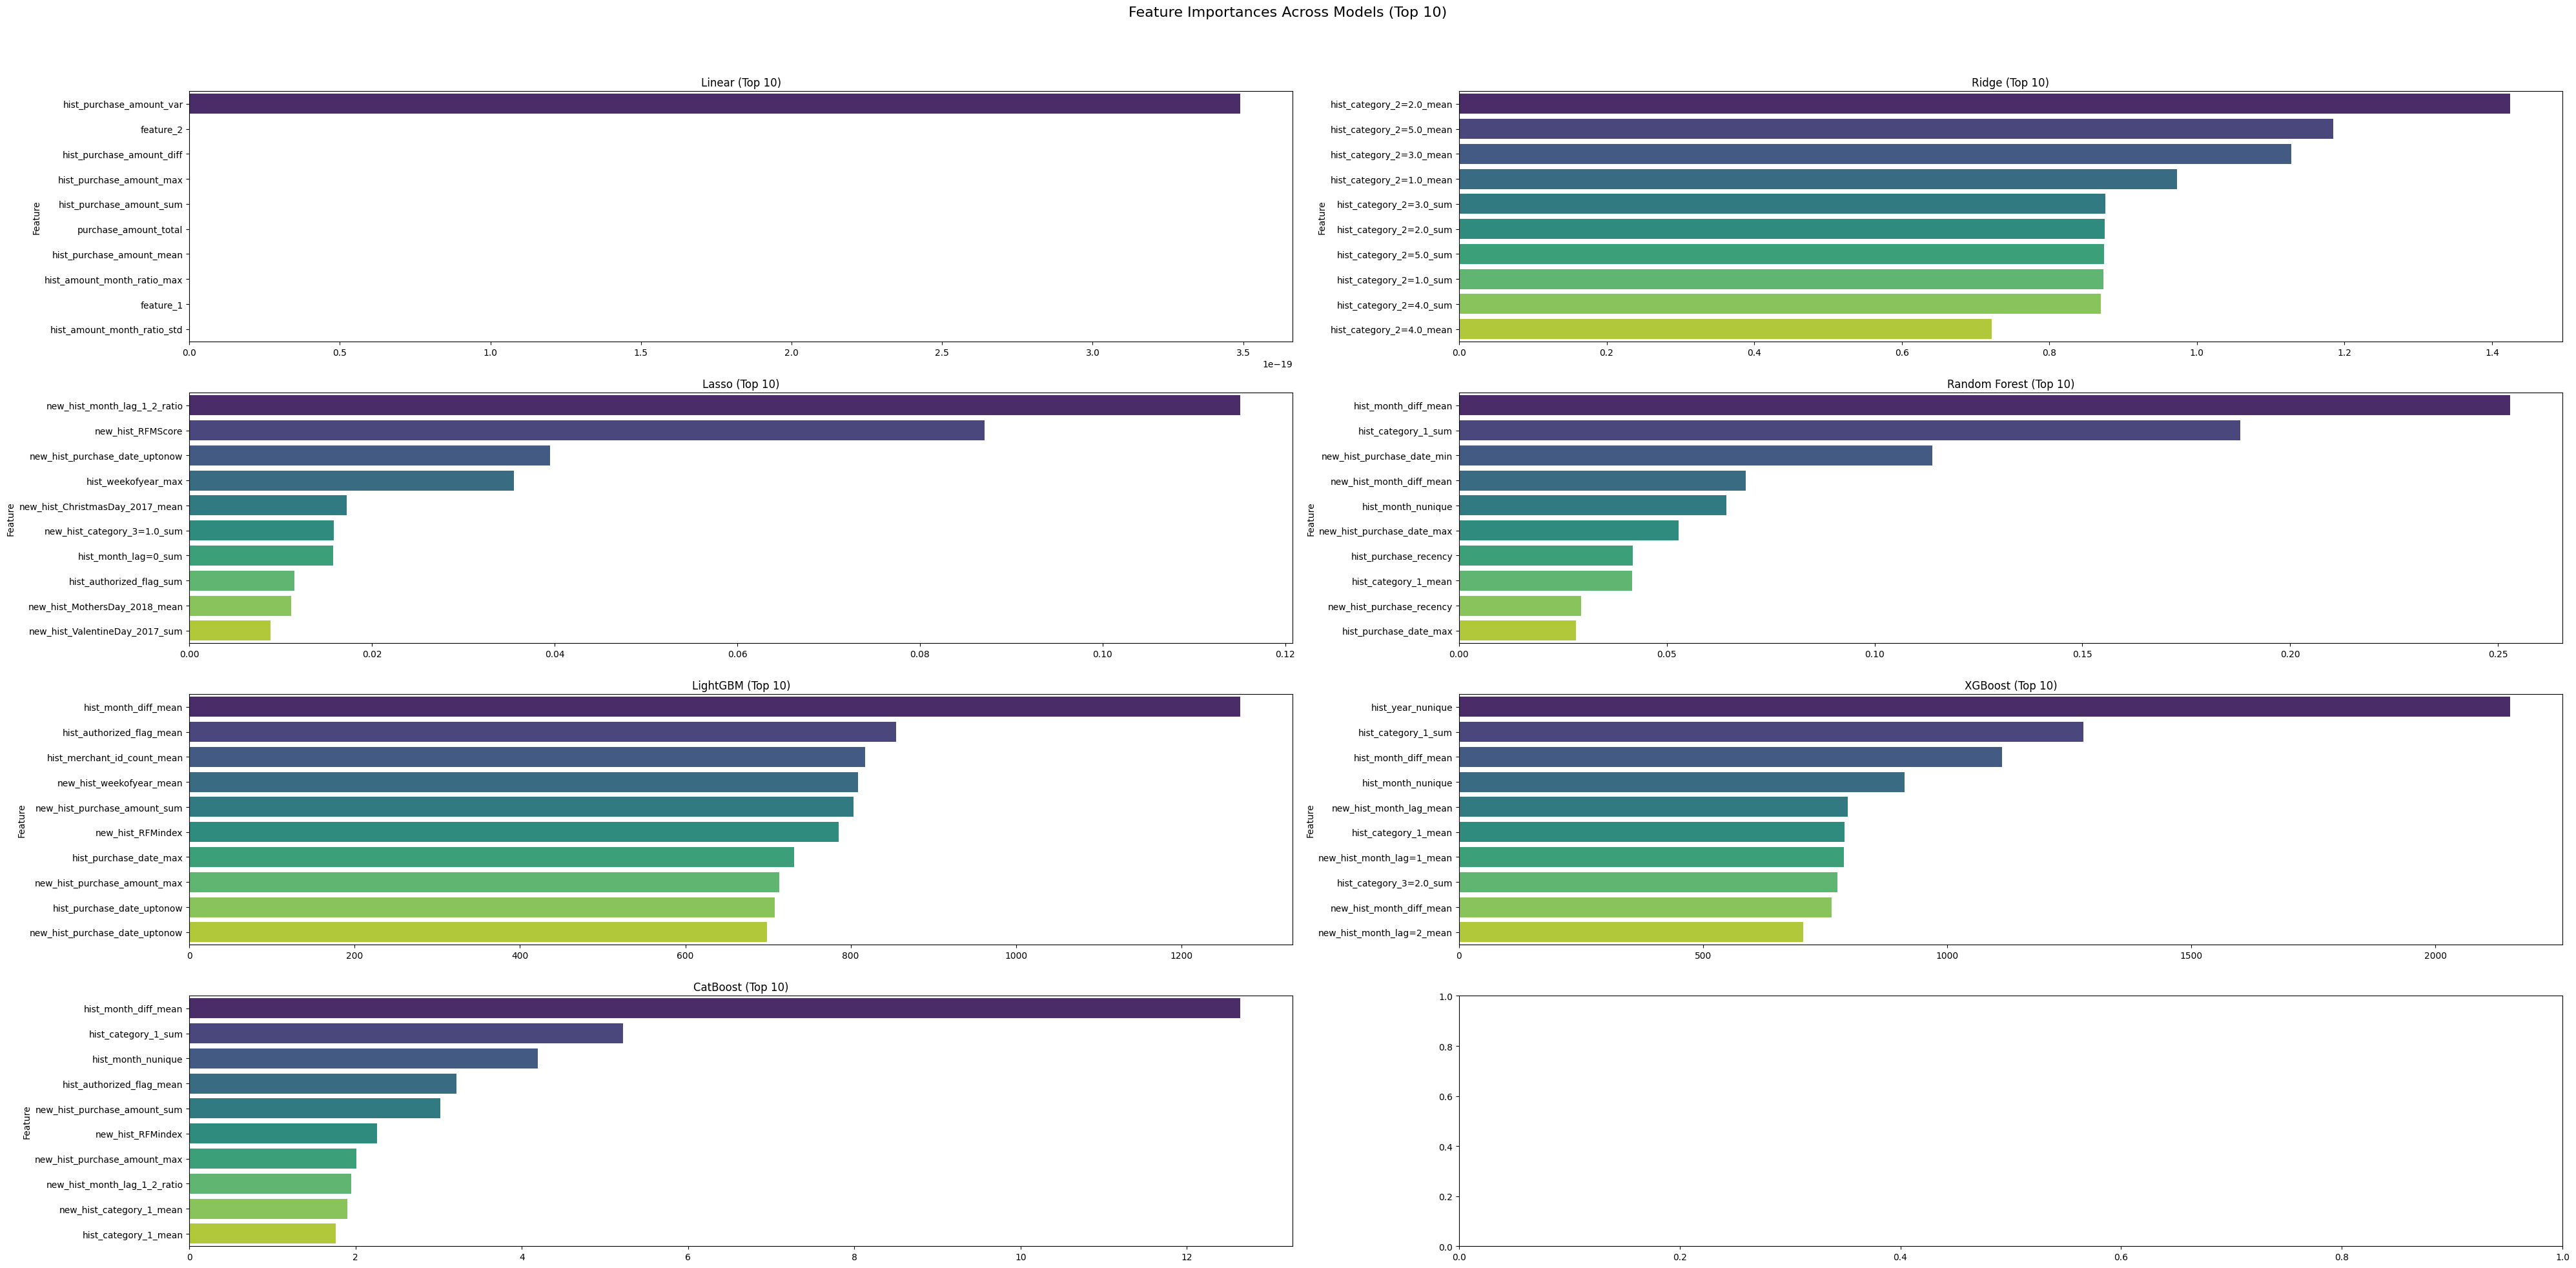

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Store RMSE results
rmse_results = {
    'Linear': rmse_linear,
    'Ridge': rmse_ridge,
    'Lasso': rmse_lasso,
    'RandomForest': rmse_rf,
    'XGBoost': rmse_xgb,
    'CatBoost': rmse_cat,
    'LightGBM': rmse_lgb
}

rmse_df = pd.DataFrame(list(rmse_results.items()), columns=['Model', 'RMSE'])
print(rmse_df.sort_values(by='RMSE'))

# Step 2: Collect importance DataFrames (top 10 features)
importance_dfs = {
    'Linear': feature_importance_df_linear,
    'Ridge': feature_importance_df_ridge,
    'Lasso': feature_importance_df_lasso,
    'Random Forest': feature_importance_df_rf,
    'LightGBM': feature_importance_df_lgb,
    'XGBoost': feature_importance_df_xgboost,
    'CatBoost': feature_importance_df_cat,
}

# Step 3: Plot in a 2x4 grid
fig, axes = plt.subplots(4, 2, figsize=(40,20))
axes = axes.flatten()
top_n = 10

for idx, (model_name, imp_df) in enumerate(importance_dfs.items()):
    if imp_df is not None:
        # Handle different column names
        if 'Importance' in imp_df.columns:
            col = 'Importance'
        elif 'Importance (abs)' in imp_df.columns:
            col = 'Importance (abs)'
        elif 'importance' in imp_df.columns:
            col = 'importance'
        else:
            axes[idx].axis('off')
            axes[idx].set_title(f"{model_name}\n(No Valid Importance Column)")
            continue

        # Plot top N features
        imp_data = imp_df.groupby('Feature')[col].mean().sort_values(ascending=False).head(top_n)
        sns.barplot(x=imp_data.values, y=imp_data.index, ax=axes[idx], palette='viridis')
        axes[idx].set_title(f"{model_name} (Top {top_n})")
    else:
        axes[idx].axis('off')
        axes[idx].set_title(f"{model_name}\n(No Importance)")

fig.suptitle('Feature Importances Across Models (Top 10)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Outlier Classification 
https://www.kaggle.com/competitions/elo-merchant-category-recommendation/discussion/82166 

Step-by-step breakdown:
1. Outlier Classification
2. Regression trained on non-outliers
3. Combine output

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
import optuna
import numpy as np

# === Prepare Data ===
df_train_columns_clf = [col for col in df_train_columns if col != 'target_class']
X1 = train[df_train_columns_clf]
y1 = train['outliers']  # Binary labels based on your quantile logic

# Split for final validation (to evaluate the best model later)
X_tr, X_vr, y_tr, y_vr = train_test_split(
    X1, y1, test_size=0.2, stratify=y1, random_state=42
)

# === Optuna Objective Function ===
def objective(trial):
    param_grid = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'class_weight': 'balanced',

        # Hyperparameters to tune
        'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int("num_leaves", 20, 150),
        'max_depth': trial.suggest_int("max_depth", 3, 15),
        'min_child_samples': trial.suggest_int("min_child_samples", 10, 100),
        'subsample': trial.suggest_float("subsample", 0.6, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
        'reg_alpha': trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
    }

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in cv.split(X_tr, y_tr):
        X_t, X_v = X_tr.iloc[train_idx], X_tr.iloc[valid_idx]
        y_t, y_v = y_tr.iloc[train_idx], y_tr.iloc[valid_idx]

        model = lgb.LGBMClassifier(**param_grid, n_estimators=1000)

        model.fit(
            X_t, y_t,
            eval_set=[(X_v, y_v)],
            eval_metric="auc",
            callbacks=[
                lgb.early_stopping(50),
                lgb.log_evaluation(0)
            ],
        )
        preds = model.predict_proba(X_v)[:, 1]
        auc = roc_auc_score(y_v, preds)
        scores.append(auc)

    return np.mean(scores)

# === Optuna Early Stopping Callback with Logging ===

class OptunaEarlyStopCounter:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_value = None

    def __call__(self, study, trial):
        if self.best_value is None or study.best_value > self.best_value:
            self.best_value = study.best_value
            self.counter = 0
        else:
            self.counter += 1
            print(f"Early Stop Counter: {self.counter}/{self.patience} | Current Best AUC: {self.best_value:.5f}")
            if self.counter >= self.patience:
                raise optuna.exceptions.OptunaError("Early stopping triggered.")

# === Run Optuna Study ===
early_stop_cb = OptunaEarlyStopCounter(patience=10)

study = optuna.create_study(direction="maximize")
try:
    study.optimize(objective, n_trials=50, show_progress_bar=True, callbacks=[early_stop_cb])
except optuna.exceptions.OptunaError as e:
    print(str(e))

print("\n Best AUC:", study.best_value)
print(" Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

[I 2025-04-21 02:04:48,220] A new study created in memory with name: no-name-ac8f2606-8951-4a84-8301-5c60db15cbcd
  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[524]	valid_0's auc: 0.908278
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[247]	valid_0's auc: 0.904106
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[305]	valid_0's auc: 0.887999
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[450]	valid_0's auc: 0.911203
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.898619


Best trial: 0. Best value: 0.902041:   2%|▏         | 1/50 [00:42<34:22, 42.09s/it]

[I 2025-04-21 02:05:30,314] Trial 0 finished with value: 0.9020408337721243 and parameters: {'learning_rate': 0.005142057216379833, 'num_leaves': 49, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.9860651760942388, 'colsample_bytree': 0.9071169583177614, 'reg_alpha': 0.00827341250893475, 'reg_lambda': 0.01575670541220875}. Best is trial 0 with value: 0.9020408337721243.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[298]	valid_0's auc: 0.909057
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's auc: 0.903425
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[214]	valid_0's auc: 0.895153
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's auc: 0.912655
Training until validation scores don't improve for 50 rounds


Best trial: 1. Best value: 0.9041:   4%|▍         | 2/50 [01:06<25:10, 31.46s/it]  

Early stopping, best iteration is:
[274]	valid_0's auc: 0.900211
[I 2025-04-21 02:05:54,336] Trial 1 finished with value: 0.9041002568046432 and parameters: {'learning_rate': 0.013848664658270107, 'num_leaves': 69, 'max_depth': 15, 'min_child_samples': 97, 'subsample': 0.848251915906681, 'colsample_bytree': 0.6242533857211783, 'reg_alpha': 0.0022874276986830358, 'reg_lambda': 0.0018052984530000996}. Best is trial 1 with value: 0.9041002568046432.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.907024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.90305
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's auc: 0.894974
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.912279
Training until validation scores don't improve for

Best trial: 1. Best value: 0.9041:   6%|▌         | 3/50 [01:19<18:16, 23.33s/it]

Early stopping, best iteration is:
[76]	valid_0's auc: 0.895342
[I 2025-04-21 02:06:07,985] Trial 2 finished with value: 0.902533925809686 and parameters: {'learning_rate': 0.04738041288659489, 'num_leaves': 69, 'max_depth': 15, 'min_child_samples': 55, 'subsample': 0.8986446980529709, 'colsample_bytree': 0.7610217358996776, 'reg_alpha': 0.019594960981199235, 'reg_lambda': 0.05024062476174596}. Best is trial 1 with value: 0.9041002568046432.
Early Stop Counter: 1/10 | Current Best AUC: 0.90410
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.902076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.901452
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.890704
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.905343
T

Best trial: 1. Best value: 0.9041:   8%|▊         | 4/50 [01:32<14:42, 19.18s/it]

Early stopping, best iteration is:
[71]	valid_0's auc: 0.895181
[I 2025-04-21 02:06:20,816] Trial 3 finished with value: 0.898951242607037 and parameters: {'learning_rate': 0.06057193113256887, 'num_leaves': 129, 'max_depth': 9, 'min_child_samples': 55, 'subsample': 0.8260422486545256, 'colsample_bytree': 0.6986943427543482, 'reg_alpha': 4.445732791144305, 'reg_lambda': 0.08559011498759538}. Best is trial 1 with value: 0.9041002568046432.
Early Stop Counter: 2/10 | Current Best AUC: 0.90410
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[241]	valid_0's auc: 0.905197
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.899594
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's auc: 0.890884
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	valid_0's auc: 0.913501
T

Best trial: 1. Best value: 0.9041:  10%|█         | 5/50 [02:04<17:45, 23.68s/it]

Early stopping, best iteration is:
[259]	valid_0's auc: 0.892464
[I 2025-04-21 02:06:52,464] Trial 4 finished with value: 0.9003280664171942 and parameters: {'learning_rate': 0.01753451875724792, 'num_leaves': 94, 'max_depth': 12, 'min_child_samples': 72, 'subsample': 0.8891075526373837, 'colsample_bytree': 0.99432223974373, 'reg_alpha': 3.265556302360968, 'reg_lambda': 1.1955464303739851}. Best is trial 1 with value: 0.9041002568046432.
Early Stop Counter: 3/10 | Current Best AUC: 0.90410
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's auc: 0.907771
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.904883
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.893097
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.909548
Train

Best trial: 1. Best value: 0.9041:  12%|█▏        | 6/50 [02:16<14:31, 19.80s/it]

Early stopping, best iteration is:
[74]	valid_0's auc: 0.899901
[I 2025-04-21 02:07:04,723] Trial 5 finished with value: 0.9030401505221916 and parameters: {'learning_rate': 0.07432218232204715, 'num_leaves': 40, 'max_depth': 13, 'min_child_samples': 68, 'subsample': 0.7553505632048776, 'colsample_bytree': 0.9960540987189306, 'reg_alpha': 2.6430059298098274, 'reg_lambda': 0.0012271969070840234}. Best is trial 1 with value: 0.9041002568046432.
Early Stop Counter: 4/10 | Current Best AUC: 0.90410
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.909966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[945]	valid_0's auc: 0.905444
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's auc: 0.893984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:

Best trial: 1. Best value: 0.9041:  14%|█▍        | 7/50 [02:49<17:18, 24.16s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.900159
[I 2025-04-21 02:07:37,862] Trial 6 finished with value: 0.903122773593077 and parameters: {'learning_rate': 0.00715858877846095, 'num_leaves': 148, 'max_depth': 3, 'min_child_samples': 45, 'subsample': 0.8781706312960857, 'colsample_bytree': 0.6070574353618032, 'reg_alpha': 0.004938717846808039, 'reg_lambda': 6.637622205021046}. Best is trial 1 with value: 0.9041002568046432.
Early Stop Counter: 5/10 | Current Best AUC: 0.90410
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.900523
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.890314
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.888287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's au

Best trial: 1. Best value: 0.9041:  16%|█▌        | 8/50 [03:02<14:27, 20.66s/it]

Early stopping, best iteration is:
[64]	valid_0's auc: 0.88654
[I 2025-04-21 02:07:51,035] Trial 7 finished with value: 0.8936400374867655 and parameters: {'learning_rate': 0.08356700306037769, 'num_leaves': 136, 'max_depth': 9, 'min_child_samples': 53, 'subsample': 0.6032575524414793, 'colsample_bytree': 0.9068511279994007, 'reg_alpha': 0.06758662437205287, 'reg_lambda': 0.03209854369452321}. Best is trial 1 with value: 0.9041002568046432.
Early Stop Counter: 6/10 | Current Best AUC: 0.90410
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.901096
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's auc: 0.902919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's auc: 0.889341
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[345]	valid_0's auc: 0.912534

Best trial: 1. Best value: 0.9041:  18%|█▊        | 9/50 [03:41<18:00, 26.36s/it]

[I 2025-04-21 02:08:29,924] Trial 8 finished with value: 0.9011384563264169 and parameters: {'learning_rate': 0.005165361126383822, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.9560146165790344, 'colsample_bytree': 0.940133913836856, 'reg_alpha': 4.859200056172298, 'reg_lambda': 0.02437504257893757}. Best is trial 1 with value: 0.9041002568046432.
Early Stop Counter: 7/10 | Current Best AUC: 0.90410
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[357]	valid_0's auc: 0.906995
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.902265
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's auc: 0.89183
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[245]	valid_0's auc: 0.913116
Training until validation scores don't improve for 50 rounds


Best trial: 1. Best value: 0.9041:  20%|██        | 10/50 [04:12<18:34, 27.86s/it]

Early stopping, best iteration is:
[344]	valid_0's auc: 0.898446
[I 2025-04-21 02:09:01,142] Trial 9 finished with value: 0.9025304549713511 and parameters: {'learning_rate': 0.011829938645586307, 'num_leaves': 113, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.9498021732845708, 'colsample_bytree': 0.6834429163504852, 'reg_alpha': 2.6993627027373015, 'reg_lambda': 0.01681210709452497}. Best is trial 1 with value: 0.9041002568046432.
Early Stop Counter: 8/10 | Current Best AUC: 0.90410
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's auc: 0.910474
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's auc: 0.907077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's auc: 0.89763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	valid_0's auc: 0.910

Best trial: 10. Best value: 0.905433:  22%|██▏       | 11/50 [04:26<15:21, 23.62s/it]

Early stopping, best iteration is:
[253]	valid_0's auc: 0.901815
[I 2025-04-21 02:09:15,152] Trial 10 finished with value: 0.9054330936987487 and parameters: {'learning_rate': 0.029937357771089627, 'num_leaves': 23, 'max_depth': 11, 'min_child_samples': 99, 'subsample': 0.7068394529816686, 'colsample_bytree': 0.6061158569763994, 'reg_alpha': 0.0010010357052208116, 'reg_lambda': 0.0011361128807327388}. Best is trial 10 with value: 0.9054330936987487.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[153]	valid_0's auc: 0.91098
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's auc: 0.907834
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's auc: 0.897227
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	valid_0's auc: 0.908811
Training until validation scores don't impr

Best trial: 10. Best value: 0.905433:  24%|██▍       | 12/50 [04:40<13:00, 20.54s/it]

Early stopping, best iteration is:
[176]	valid_0's auc: 0.901715
[I 2025-04-21 02:09:28,659] Trial 11 finished with value: 0.9053133433285714 and parameters: {'learning_rate': 0.03099410756892407, 'num_leaves': 21, 'max_depth': 15, 'min_child_samples': 100, 'subsample': 0.697731789499501, 'colsample_bytree': 0.6000573333464279, 'reg_alpha': 0.0010578506180133544, 'reg_lambda': 0.001374539698765895}. Best is trial 10 with value: 0.9054330936987487.
Early Stop Counter: 1/10 | Current Best AUC: 0.90543
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's auc: 0.910802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's auc: 0.908516
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[166]	valid_0's auc: 0.896921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0

Best trial: 12. Best value: 0.905472:  26%|██▌       | 13/50 [04:54<11:26, 18.56s/it]

Early stopping, best iteration is:
[169]	valid_0's auc: 0.901611
[I 2025-04-21 02:09:42,650] Trial 12 finished with value: 0.9054716956768424 and parameters: {'learning_rate': 0.032633282012262954, 'num_leaves': 21, 'max_depth': 11, 'min_child_samples': 99, 'subsample': 0.708092847068655, 'colsample_bytree': 0.8188904884202239, 'reg_alpha': 0.001271632390392323, 'reg_lambda': 0.00406675255428421}. Best is trial 12 with value: 0.9054716956768424.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's auc: 0.911807
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.907838
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	valid_0's auc: 0.898545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.910089
Training until validation scores don't improve 

Best trial: 13. Best value: 0.905647:  28%|██▊       | 14/50 [05:07<10:13, 17.04s/it]

Early stopping, best iteration is:
[161]	valid_0's auc: 0.899955
[I 2025-04-21 02:09:56,192] Trial 13 finished with value: 0.9056468907311268 and parameters: {'learning_rate': 0.032063812041793927, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 82, 'subsample': 0.6976156120334995, 'colsample_bytree': 0.8279802395687021, 'reg_alpha': 0.44041617289573726, 'reg_lambda': 0.006613409828727906}. Best is trial 13 with value: 0.9056468907311268.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[118]	valid_0's auc: 0.909795
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.904047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.894663
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.910865
Training until validation scores don't improve 

Best trial: 13. Best value: 0.905647:  30%|███       | 15/50 [05:20<09:09, 15.70s/it]

Early stopping, best iteration is:
[151]	valid_0's auc: 0.900322
[I 2025-04-21 02:10:08,790] Trial 14 finished with value: 0.9039383545397708 and parameters: {'learning_rate': 0.038571092218478716, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 83, 'subsample': 0.6276031277741171, 'colsample_bytree': 0.8293898450330635, 'reg_alpha': 0.18730991756155183, 'reg_lambda': 0.005541976055504182}. Best is trial 13 with value: 0.9056468907311268.
Early Stop Counter: 1/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.905841
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.900758
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.892958
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.914

Best trial: 13. Best value: 0.905647:  32%|███▏      | 16/50 [05:36<08:59, 15.88s/it]

Early stopping, best iteration is:
[108]	valid_0's auc: 0.899766
[I 2025-04-21 02:10:25,079] Trial 15 finished with value: 0.9027191068690545 and parameters: {'learning_rate': 0.03030212574546494, 'num_leaves': 91, 'max_depth': 11, 'min_child_samples': 84, 'subsample': 0.7643913944753156, 'colsample_bytree': 0.8172388799411184, 'reg_alpha': 0.4061604118335919, 'reg_lambda': 0.5295066948290618}. Best is trial 13 with value: 0.9056468907311268.
Early Stop Counter: 2/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[210]	valid_0's auc: 0.911419
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's auc: 0.905399
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[272]	valid_0's auc: 0.896395
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's auc: 0.9114

Best trial: 13. Best value: 0.905647:  34%|███▍      | 17/50 [05:56<09:24, 17.10s/it]

Early stopping, best iteration is:
[303]	valid_0's auc: 0.89996
[I 2025-04-21 02:10:45,028] Trial 16 finished with value: 0.9049261117045457 and parameters: {'learning_rate': 0.01678312946628388, 'num_leaves': 33, 'max_depth': 11, 'min_child_samples': 84, 'subsample': 0.6740753102164957, 'colsample_bytree': 0.7617612850413877, 'reg_alpha': 0.4442980227682068, 'reg_lambda': 0.004486411190161996}. Best is trial 13 with value: 0.9056468907311268.
Early Stop Counter: 3/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.908781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's auc: 0.902906
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.892751
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.91071

Best trial: 13. Best value: 0.905647:  36%|███▌      | 18/50 [06:08<08:18, 15.57s/it]

Early stopping, best iteration is:
[84]	valid_0's auc: 0.897046
[I 2025-04-21 02:10:57,045] Trial 17 finished with value: 0.9024403299090554 and parameters: {'learning_rate': 0.05105061579437781, 'num_leaves': 56, 'max_depth': 6, 'min_child_samples': 35, 'subsample': 0.7570417322626112, 'colsample_bytree': 0.8586081736712639, 'reg_alpha': 0.044162185658990265, 'reg_lambda': 0.33216420685737097}. Best is trial 13 with value: 0.9056468907311268.
Early Stop Counter: 4/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	valid_0's auc: 0.911276
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[157]	valid_0's auc: 0.906805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's auc: 0.897507
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's auc: 0.91

Best trial: 18. Best value: 0.905649:  38%|███▊      | 19/50 [06:27<08:31, 16.49s/it]

Early stopping, best iteration is:
[327]	valid_0's auc: 0.902017
[I 2025-04-21 02:11:15,680] Trial 18 finished with value: 0.9056493150492022 and parameters: {'learning_rate': 0.02291734212023442, 'num_leaves': 20, 'max_depth': 10, 'min_child_samples': 69, 'subsample': 0.6562011691040252, 'colsample_bytree': 0.770950019909995, 'reg_alpha': 0.7847249411191018, 'reg_lambda': 0.007234679752289443}. Best is trial 18 with value: 0.9056493150492022.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's auc: 0.910933
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid_0's auc: 0.906537
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's auc: 0.895149
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[212]	valid_0's auc: 0.907083
Training until validation scores don't improve f

Best trial: 18. Best value: 0.905649:  40%|████      | 20/50 [06:43<08:10, 16.35s/it]

Early stopping, best iteration is:
[343]	valid_0's auc: 0.901131
[I 2025-04-21 02:11:31,698] Trial 19 finished with value: 0.9041665791588194 and parameters: {'learning_rate': 0.02201001458426091, 'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 70, 'subsample': 0.6549699861964676, 'colsample_bytree': 0.772753259716274, 'reg_alpha': 0.8876797894526502, 'reg_lambda': 0.011367518576853898}. Best is trial 18 with value: 0.9056493150492022.
Early Stop Counter: 1/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.904333
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's auc: 0.901622
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[467]	valid_0's auc: 0.891932
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[195]	valid_0's auc: 0.91004

Best trial: 18. Best value: 0.905649:  42%|████▏     | 21/50 [07:12<09:44, 20.14s/it]

[I 2025-04-21 02:12:00,685] Trial 20 finished with value: 0.9012600678385743 and parameters: {'learning_rate': 0.01057919565646981, 'num_leaves': 112, 'max_depth': 9, 'min_child_samples': 64, 'subsample': 0.64798899332263, 'colsample_bytree': 0.7091459778962623, 'reg_alpha': 1.0117942330754046, 'reg_lambda': 0.19255828430813623}. Best is trial 18 with value: 0.9056493150492022.
Early Stop Counter: 2/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[169]	valid_0's auc: 0.910669
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[206]	valid_0's auc: 0.906982
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's auc: 0.898278
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.90984
Training until validation scores don't improve for 50 rounds


Best trial: 18. Best value: 0.905649:  44%|████▍     | 22/50 [07:29<08:58, 19.24s/it]

Early stopping, best iteration is:
[212]	valid_0's auc: 0.90015
[I 2025-04-21 02:12:17,806] Trial 21 finished with value: 0.9051836795140626 and parameters: {'learning_rate': 0.022823799034523293, 'num_leaves': 22, 'max_depth': 10, 'min_child_samples': 88, 'subsample': 0.7166719506341177, 'colsample_bytree': 0.8576001774660494, 'reg_alpha': 0.1384719029267704, 'reg_lambda': 0.0046863807727114725}. Best is trial 18 with value: 0.9056493150492022.
Early Stop Counter: 3/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.911503
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.904728
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's auc: 0.897313
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's auc: 0.9

Best trial: 18. Best value: 0.905649:  46%|████▌     | 23/50 [07:46<08:18, 18.47s/it]

Early stopping, best iteration is:
[197]	valid_0's auc: 0.900503
[I 2025-04-21 02:12:34,503] Trial 22 finished with value: 0.90492024056662 and parameters: {'learning_rate': 0.02342181876603382, 'num_leaves': 34, 'max_depth': 13, 'min_child_samples': 92, 'subsample': 0.7888329105805283, 'colsample_bytree': 0.7895644547360647, 'reg_alpha': 0.3277059038566553, 'reg_lambda': 0.00784229415370645}. Best is trial 18 with value: 0.9056493150492022.
Early Stop Counter: 4/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.910074
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's auc: 0.904496
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.896865
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.912542

Best trial: 18. Best value: 0.905649:  48%|████▊     | 24/50 [07:59<07:22, 17.02s/it]

Early stopping, best iteration is:
[119]	valid_0's auc: 0.900078
[I 2025-04-21 02:12:48,119] Trial 23 finished with value: 0.9048111815567312 and parameters: {'learning_rate': 0.035850617104913725, 'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 77, 'subsample': 0.7292829737040608, 'colsample_bytree': 0.7404576672231107, 'reg_alpha': 1.0409003174952323, 'reg_lambda': 0.0032215306609742816}. Best is trial 18 with value: 0.9056493150492022.
Early Stop Counter: 5/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.910549
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's auc: 0.906915
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.89626
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.911

Best trial: 18. Best value: 0.905649:  50%|█████     | 25/50 [08:12<06:31, 15.66s/it]

Early stopping, best iteration is:
[118]	valid_0's auc: 0.898513
[I 2025-04-21 02:13:00,618] Trial 24 finished with value: 0.9048198314625389 and parameters: {'learning_rate': 0.04492513026588421, 'num_leaves': 29, 'max_depth': 12, 'min_child_samples': 79, 'subsample': 0.672860706933714, 'colsample_bytree': 0.8474981616717444, 'reg_alpha': 0.03517968770895292, 'reg_lambda': 0.0024761125794957157}. Best is trial 18 with value: 0.9056493150492022.
Early Stop Counter: 6/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[161]	valid_0's auc: 0.909588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.903241
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.895137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's auc: 0.91

Best trial: 18. Best value: 0.905649:  52%|█████▏    | 26/50 [08:30<06:33, 16.39s/it]

Early stopping, best iteration is:
[186]	valid_0's auc: 0.899385
[I 2025-04-21 02:13:18,710] Trial 25 finished with value: 0.9039441828063642 and parameters: {'learning_rate': 0.024502388731419522, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 63, 'subsample': 0.6109235088579464, 'colsample_bytree': 0.8897057589684068, 'reg_alpha': 0.01291374994011465, 'reg_lambda': 0.07190809576442901}. Best is trial 18 with value: 0.9056493150492022.
Early Stop Counter: 7/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's auc: 0.909252
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.905955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's auc: 0.896056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.9103

Best trial: 18. Best value: 0.905649:  54%|█████▍    | 27/50 [08:40<05:36, 14.62s/it]

Early stopping, best iteration is:
[119]	valid_0's auc: 0.901142
[I 2025-04-21 02:13:29,207] Trial 26 finished with value: 0.9045534398332951 and parameters: {'learning_rate': 0.06470135260061156, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 92, 'subsample': 0.6873823039848884, 'colsample_bytree': 0.8087855391092795, 'reg_alpha': 8.667170903005971, 'reg_lambda': 0.008340579551489955}. Best is trial 18 with value: 0.9056493150492022.
Early Stop Counter: 8/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.908144
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.902829
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.894643
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.907266


Best trial: 18. Best value: 0.905649:  56%|█████▌    | 28/50 [08:50<04:48, 13.10s/it]

Early stopping, best iteration is:
[59]	valid_0's auc: 0.896635
[I 2025-04-21 02:13:38,760] Trial 27 finished with value: 0.9019033832829673 and parameters: {'learning_rate': 0.09774471695720831, 'num_leaves': 45, 'max_depth': 12, 'min_child_samples': 75, 'subsample': 0.7349311082144329, 'colsample_bytree': 0.7271918397900119, 'reg_alpha': 0.2004814701307664, 'reg_lambda': 0.036347716316194593}. Best is trial 18 with value: 0.9056493150492022.
Early Stop Counter: 9/10 | Current Best AUC: 0.90565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[205]	valid_0's auc: 0.910188
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.906829
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's auc: 0.89785
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	valid_0's auc: 0.9110

Best trial: 18. Best value: 0.905649:  56%|█████▌    | 28/50 [09:08<07:10, 19.58s/it]

Early stopping, best iteration is:
[276]	valid_0's auc: 0.899862
[I 2025-04-21 02:13:56,432] Trial 28 finished with value: 0.9051488706029364 and parameters: {'learning_rate': 0.01825790225695514, 'num_leaves': 31, 'max_depth': 14, 'min_child_samples': 91, 'subsample': 0.6458383013405962, 'colsample_bytree': 0.6610886494509206, 'reg_alpha': 1.4921843415184473, 'reg_lambda': 0.0030247775087603227}. Best is trial 18 with value: 0.9056493150492022.
Early Stop Counter: 10/10 | Current Best AUC: 0.90565
Early stopping triggered.

 Best AUC: 0.9056493150492022
 Best hyperparameters:
    learning_rate: 0.02291734212023442
    num_leaves: 20
    max_depth: 10
    min_child_samples: 69
    subsample: 0.6562011691040252
    colsample_bytree: 0.770950019909995
    reg_alpha: 0.7847249411191018
    reg_lambda: 0.007234679752289443


In [ ]:
# Retrain best model on full training set
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'random_state': 42,
    'class_weight': 'balanced'
})

best_model = lgb.LGBMClassifier(**best_params, n_estimators=1000)

best_model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_vr, y_vr)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(100)
    ]
)

# Final Evaluation
val_preds = best_model.predict(X_vr)
val_probs = best_model.predict_proba(X_vr)[:, 1]

print("\nClassification Report:")
print(classification_report(y_vr, val_preds))

print(f"AUC on hold-out validation: {roc_auc_score(y_vr, val_probs):.4f}")

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.89337
[200]	valid_0's auc: 0.89567
Early stopping, best iteration is:
[203]	valid_0's auc: 0.895709

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     39943
           1       0.05      0.78      0.10       441

    accuracy                           0.85     40384
   macro avg       0.53      0.82      0.51     40384
weighted avg       0.99      0.85      0.91     40384

AUC on hold-out validation: 0.8957


In [ ]:
# === Inference: Predict Outlier Probabilities on Test Set ===

# Ensure the same feature set is used as during training
X_test_clf = test[df_train_columns_clf]

# Predict probabilities using the best tuned model
test_outlier_probs = best_model.predict_proba(X_test_clf)[:, 1]

# Set a threshold to define what counts as an outlier
outlier_threshold = 0.9  # You can tune this based on desired precision/recall tradeoff

# Apply threshold to get binary outlier flags
test['outlier'] = (test_outlier_probs >= outlier_threshold).astype(int)

# Optional: Inspect counts
print(test['outlier'].value_counts())

outlier
0    122119
1      1504
Name: count, dtype: int64


### Training Model with train data with no outliers

#### Prepare Test Set
- Remove Outliers identified and replace with -33
- Obtained filtered test set to train model (No Outliers)

In [ ]:
# === PART 1: PREPARE TEST FEATURES FOR REGRESSION ===

# Use your outlier prediction (already in 'test["outlier"]')
test_result = test.copy()

# Mask for non-outlier rows
non_outlier_mask = test_result['outlier'] == 0

# Use the same feature columns as used during training (df_train_columns)
test_features_for_reg = test_result.loc[non_outlier_mask, df_train_columns_clf]

# Prepare placeholder for predictions
test_result['target'] = -33.2  # Default for outliers (will remain for outlier rows)

### Data Preparation
- Prepare trainset with no outliers

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ✅ RMSE metric
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ✅ Filter only non-outlier rows from training data
non_outlier_train_mask = train['outliers'] == 0
X_filtered = train.loc[non_outlier_train_mask, df_train_columns_clf]
y_filtered = train.loc[non_outlier_train_mask, 'target']

# ✅ Split into train/test for regression model evaluation
X_train_all, X_test_com, y_train_all, y_test_com = train_test_split(
    X_filtered, y_filtered, test_size=0.20, random_state=20
)

print("✅ Shapes:")
print(f"X_train_all: {X_train_all.shape}")
print(f"X_test_com:  {X_test_com.shape}")
print(f"y_train_all: {y_train_all.shape}")
print(f"y_test_com:  {y_test_com.shape}")

✅ Shapes:
X_train_all: (159768, 237)
X_test_com:  (39942, 237)
y_train_all: (159768,)
y_test_com:  (39942,)


### Model 1: Linear Regression

In [72]:
# === PART 2: LINEAR REGRESSION (Non-Outliers Only, Clean Version) ===
from sklearn.linear_model import LinearRegression
import pandas as pd

# 1. Train the model on non-outlier training data
linear_model = LinearRegression()
linear_model.fit(X_train_all, y_train_all)

# 2. Predict on validation set for internal performance check
y_pred_linear = linear_model.predict(X_test_com)
rmse_linear = rmse(y_test_com, y_pred_linear)
print(f"RMSE using Linear Regression: {rmse_linear:.5f}")

# 3. Predict on test rows not flagged as outliers
linear_test_pred = linear_model.predict(test_features_for_reg)

# 4. Create a copy of test_result and insert predictions only for non-outlier rows
submission_linear = test_result.copy()
submission_linear.loc[submission_linear['outlier'] == 0, 'target'] = linear_test_pred

# 5. Prepare and save final submission
final_submission = submission_linear[['card_id', 'target']].copy()
print("Nulls in submission:", final_submission.isnull().sum().sum())
print(final_submission.head())

final_submission.to_csv("linear_ou_latest.csv", index=False)
print("📁 Submission saved to 'data/linear_ou_latest.csv'")

RMSE using Linear Regression: 1.73112
Nulls in submission: 0
           card_id    target
0  C_ID_0ab67a22ab -0.031743
1  C_ID_130fd0cbdd -0.031743
2  C_ID_b709037bc5 -0.031743
3  C_ID_d27d835a9f -0.031743
4  C_ID_2b5e3df5c2 -0.031743
📁 Submission saved to 'data/linear_ou_latest.csv'


## Model 2: Ridge

In [73]:
# === PART 2: RIDGE REGRESSION (Non-Outliers Only, Clean Version) ===
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import pandas as pd

# 1. Define model and hyperparameter grid
ridge = Ridge()
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 0.1, 1, 10]}

# 2. Perform grid search
ridge_regressor = GridSearchCV(
    ridge,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)
ridge_regressor.fit(X_train_all, y_train_all)

# 3. Evaluate on validation split
y_pred_ridge = ridge_regressor.predict(X_test_com)
rmse_ridge = rmse(y_test_com, y_pred_ridge)
print("RMSE using Ridge Regression: {:.5f}".format(rmse_ridge))
print("Best hyperparameters for Ridge:", ridge_regressor.best_params_)

# 4. Predict on non-outlier test set
ridge_test_pred = ridge_regressor.predict(test_features_for_reg)

# 5. Create clean submission
submission_ridge = test_result.copy()
submission_ridge.loc[submission_ridge['outlier'] == 0, 'target'] = ridge_test_pred

# 6. Save submission
final_submission = submission_ridge[['card_id', 'target']].copy()
print("🔍 Nulls in submission:", final_submission.isnull().sum().sum())
print(final_submission.head())

final_submission.to_csv("ridge_latest_ou.csv", index=False)
print("Submission saved to 'data/ridge_latest_ou.csv'")

RMSE using Ridge Regression: 1.60514
Best hyperparameters for Ridge: {'alpha': 10}
🔍 Nulls in submission: 0
           card_id    target
0  C_ID_0ab67a22ab -0.187019
1  C_ID_130fd0cbdd  0.386745
2  C_ID_b709037bc5 -0.760468
3  C_ID_d27d835a9f -0.544922
4  C_ID_2b5e3df5c2 -2.676373
Submission saved to 'data/ridge_latest_ou.csv'


## Model 3: Lasso

In [74]:
# === PART 2: LASSO REGRESSION (Non-Outliers Only, Clean Version) ===
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import pandas as pd

# 1. Define model and parameter grid
lasso = Lasso()
param_grid = {
    'alpha': [1e-3, 1e-2, 1e-1],
    'max_iter': [1000, 2000]
}

# 2. Run GridSearchCV
lasso_regressor = GridSearchCV(
    lasso,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)
lasso_regressor.fit(X_train_all, y_train_all)

# 3. Evaluate on validation split
y_pred_lasso = lasso_regressor.predict(X_test_com)
rmse_lasso = rmse(y_test_com, y_pred_lasso)
print("RMSE using Lasso Regression: {:.5f}".format(rmse_lasso))
print("Best hyperparameters for Lasso:", lasso_regressor.best_params_)

# 4. Predict on non-outlier test set rows
lasso_test_pred = lasso_regressor.predict(test_features_for_reg)

# 5. Create clean submission
submission_lasso = test_result.copy()
submission_lasso.loc[submission_lasso['outlier'] == 0, 'target'] = lasso_test_pred

# 6. Save submission
final_submission = submission_lasso[['card_id', 'target']].copy()
print("Nulls in submission:", final_submission.isnull().sum().sum())
print(final_submission.head())

final_submission.to_csv("lasso_latest_ou.csv", index=False)
print("📁 Submission saved to 'data/lasso_latest_ou.csv'")

RMSE using Lasso Regression: 1.61352
Best hyperparameters for Lasso: {'alpha': 0.1, 'max_iter': 1000}
Nulls in submission: 0
           card_id    target
0  C_ID_0ab67a22ab -0.167480
1  C_ID_130fd0cbdd -0.440430
2  C_ID_b709037bc5 -0.464966
3  C_ID_d27d835a9f -0.268555
4  C_ID_2b5e3df5c2 -2.734863
📁 Submission saved to 'data/lasso_latest_ou.csv'


## Model 4: Random Forest

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd

# 1. Define hyperparameter grid
param_grid = {
    "criterion": ["squared_error"],
    "n_estimators": [500, 1000],
    "max_depth": [5, 10, 15],
    "max_leaf_nodes": [5],
    "min_samples_split": [8],
    "max_features": [50, 100],
    "min_impurity_decrease": [0.1]
}

# 2. Initialize model and run GridSearchCV
forest_regressor = RandomForestRegressor(random_state=10)
grid_forest = GridSearchCV(
    forest_regressor,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=2,
    verbose=1,
    n_jobs=-1
)

grid_forest.fit(X_train_all, y_train_all)

# 3. Evaluate on validation set
y_pred_forest = grid_forest.predict(X_test_com)
rmse_rf = rmse(y_test_com, y_pred_forest)
print(" RMSE using Random Forest: {:.5f}".format(rmse_rf))
print(" Best hyperparameters for Random Forest:", grid_forest.best_params_)

# 4. Predict on non-outlier test set
rf_test_pred = grid_forest.predict(test_features_for_reg)

# 5. Create clean submission copy
submission_rf = test_result.copy()
submission_rf.loc[submission_rf['outlier'] == 0, 'target'] = rf_test_pred

# 6. Save final submission
final_submission = submission_rf[['card_id', 'target']].copy()
print("Nulls in submission:", final_submission.isnull().sum().sum())
print(final_submission.head())

final_submission.to_csv("rf_latest_ou.csv", index=False)
print(" Submission saved to 'data/rf_latest_ou.csv'")

Fitting 2 folds for each of 12 candidates, totalling 24 fits
 RMSE using Random Forest: 1.67368
 Best hyperparameters for Random Forest: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': 100, 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.1, 'min_samples_split': 8, 'n_estimators': 1000}
Nulls in submission: 0
           card_id    target
0  C_ID_0ab67a22ab -0.036689
1  C_ID_130fd0cbdd -0.408318
2  C_ID_b709037bc5 -0.382665
3  C_ID_d27d835a9f -0.408318
4  C_ID_2b5e3df5c2 -0.465860
 Submission saved to 'data/rf_latest_ou.csv'


In [ ]:
import lightgbm as lgb
import optuna
import gc
from lightgbm import early_stopping, log_evaluation

def lgb_objective(trial):
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'device': 'cpu',
        'seed': 326,
        'n_jobs': -1,
        'verbose': -1,
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.001, 1.0),
        'subsample': trial.suggest_float('subsample', 0.001, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 10.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 45.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 16, 64)
    }

    dtrain_lgb = lgb.Dataset(X_train_all, label=y_train_all, free_raw_data=False)

    cv_result = lgb.cv(
        params=lgb_params,
        train_set=dtrain_lgb,
        num_boost_round=10000,
        nfold=3,
        seed=47,
        stratified=False,
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100)
        ]
    )

    gc.collect()
    for key in cv_result:
        if "rmse-mean" in key:
            return cv_result[key][-1]

    raise KeyError("Expected metric 'rmse-mean' not found.")


In [ ]:
# === MODEL 5 - PART 2: LIGHTGBM TUNING EXECUTION (with early stopping and logging) ===

class LGB_EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = 20  # Number of trials without improvement before stopping
    early_stop_count = 0
    best_score = None

def lgb_early_stopping_opt(study, trial):
    current_score = study.best_value

    # First trial initialization
    if LGB_EarlyStoppingExceeded.best_score is None:
        LGB_EarlyStoppingExceeded.best_score = current_score
        print(f"Trial {trial.number}: Initial best score set to {current_score:.5f}")
        return

    # Improved score
    if current_score < LGB_EarlyStoppingExceeded.best_score:
        print(f"Trial {trial.number}: Improved score: {current_score:.5f} (Previous best: {LGB_EarlyStoppingExceeded.best_score:.5f})")
        LGB_EarlyStoppingExceeded.best_score = current_score
        LGB_EarlyStoppingExceeded.early_stop_count = 0

    # No improvement
    else:
        LGB_EarlyStoppingExceeded.early_stop_count += 1
        print(f"Trial {trial.number}: No improvement. Counter = {LGB_EarlyStoppingExceeded.early_stop_count}, Best Score = {LGB_EarlyStoppingExceeded.best_score:.5f}")
        
        if LGB_EarlyStoppingExceeded.early_stop_count > LGB_EarlyStoppingExceeded.early_stop:
            print("Early stopping threshold reached. Terminating optimization.")
            raise LGB_EarlyStoppingExceeded()

# === Run the Optuna Study ===
lgb_study = optuna.create_study(direction='minimize')

try:
    lgb_study.optimize(lgb_objective, n_trials=100, callbacks=[lgb_early_stopping_opt])
except LGB_EarlyStoppingExceeded:
    print("Early stopping triggered for LightGBM optimization.")

# === Log Best Parameters ===
print("\n Best hyperparameters for LightGBM:")
for k, v in lgb_study.best_trial.params.items():
    print(f"    {k}: {v}")

[I 2025-04-21 02:46:07,341] A new study created in memory with name: no-name-483bdb48-e5c1-4c3c-a304-97a26777d4f1


Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6037 + 0.00657507
[200]	valid's rmse: 1.57532 + 0.00575277
[300]	valid's rmse: 1.56488 + 0.00530812
[400]	valid's rmse: 1.56 + 0.00511818
[500]	valid's rmse: 1.55727 + 0.00497773
[600]	valid's rmse: 1.55566 + 0.00486237
[700]	valid's rmse: 1.55469 + 0.00482902
[800]	valid's rmse: 1.55414 + 0.00482574
[900]	valid's rmse: 1.55379 + 0.00483888
[1000]	valid's rmse: 1.55356 + 0.00477279
[1100]	valid's rmse: 1.55347 + 0.0047459
[1200]	valid's rmse: 1.55338 + 0.00469731
[1300]	valid's rmse: 1.55332 + 0.00462164
[1400]	valid's rmse: 1.55331 + 0.00456164
[1500]	valid's rmse: 1.55331 + 0.00455019
[1600]	valid's rmse: 1.55333 + 0.00453707


[I 2025-04-21 02:46:33,288] Trial 0 finished with value: 1.5533001323896398 and parameters: {'num_leaves': 42, 'colsample_bytree': 0.37692751057866997, 'subsample': 0.46978199497844275, 'max_depth': 11, 'reg_alpha': 0.23693486293439814, 'reg_lambda': 0.7361224235435659, 'min_split_gain': 0.12442001060349428, 'min_child_weight': 29.838642338355235, 'min_data_in_leaf': 46}. Best is trial 0 with value: 1.5533001323896398.


Early stopping, best iteration is:
[1460]	valid's rmse: 1.5533 + 0.00455734
Trial 0: Initial best score set to 1.55330
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.59925 + 0.0064509
[200]	valid's rmse: 1.57134 + 0.00543828
[300]	valid's rmse: 1.56176 + 0.00498728
[400]	valid's rmse: 1.55745 + 0.00477558
[500]	valid's rmse: 1.55524 + 0.00464913
[600]	valid's rmse: 1.55411 + 0.00456461
[700]	valid's rmse: 1.55346 + 0.00452336
[800]	valid's rmse: 1.55325 + 0.00452825
[900]	valid's rmse: 1.55325 + 0.00453118


[I 2025-04-21 02:46:52,359] Trial 1 finished with value: 1.553246339332967 and parameters: {'num_leaves': 62, 'colsample_bytree': 0.5394690104188404, 'subsample': 0.5487292412977833, 'max_depth': 11, 'reg_alpha': 3.6566727270294974, 'reg_lambda': 5.895113065517759, 'min_split_gain': 7.327100366071249, 'min_child_weight': 20.08236936649359, 'min_data_in_leaf': 34}. Best is trial 1 with value: 1.553246339332967.


[1000]	valid's rmse: 1.55325 + 0.00453118
Early stopping, best iteration is:
[804]	valid's rmse: 1.55325 + 0.00453166
Trial 1: Improved score: 1.55325 (Previous best: 1.55330)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60715 + 0.00676876
[200]	valid's rmse: 1.57882 + 0.00591897
[300]	valid's rmse: 1.56734 + 0.00549929
[400]	valid's rmse: 1.56176 + 0.00520023
[500]	valid's rmse: 1.55855 + 0.00507619
[600]	valid's rmse: 1.55655 + 0.00500357
[700]	valid's rmse: 1.55534 + 0.00486276
[800]	valid's rmse: 1.55461 + 0.00484457
[900]	valid's rmse: 1.55428 + 0.00487785
[1000]	valid's rmse: 1.55422 + 0.00487999
[1100]	valid's rmse: 1.5542 + 0.00487871
[1200]	valid's rmse: 1.55419 + 0.00487812
[1300]	valid's rmse: 1.55419 + 0.00487812
Early stopping, best iteration is:
[1127]	valid's rmse: 1.55419 + 0.00487812


[I 2025-04-21 02:47:05,742] Trial 2 finished with value: 1.554194355417514 and parameters: {'num_leaves': 41, 'colsample_bytree': 0.23100498754733056, 'subsample': 0.14953432834844718, 'max_depth': 11, 'reg_alpha': 1.8220198195878512, 'reg_lambda': 1.6222300912772114, 'min_split_gain': 9.444331479324868, 'min_child_weight': 18.456694117058912, 'min_data_in_leaf': 16}. Best is trial 1 with value: 1.553246339332967.


Trial 2: No improvement. Counter = 1, Best Score = 1.55325
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.59961 + 0.00629225
[200]	valid's rmse: 1.57208 + 0.00521834
[300]	valid's rmse: 1.56272 + 0.00466593
[400]	valid's rmse: 1.55835 + 0.00442091
[500]	valid's rmse: 1.55619 + 0.0042675
[600]	valid's rmse: 1.55487 + 0.00427442
[700]	valid's rmse: 1.55408 + 0.00420475
[800]	valid's rmse: 1.55373 + 0.00415616
[900]	valid's rmse: 1.55362 + 0.00415955
[1000]	valid's rmse: 1.55362 + 0.00415955


[I 2025-04-21 02:47:29,592] Trial 3 finished with value: 1.5536199256080572 and parameters: {'num_leaves': 53, 'colsample_bytree': 0.877346361587851, 'subsample': 0.19265931541754414, 'max_depth': 11, 'reg_alpha': 3.963370935212076, 'reg_lambda': 1.0960837085247643, 'min_split_gain': 6.63668875312122, 'min_child_weight': 16.362993119052483, 'min_data_in_leaf': 33}. Best is trial 1 with value: 1.553246339332967.


Early stopping, best iteration is:
[895]	valid's rmse: 1.55362 + 0.00415955
Trial 3: No improvement. Counter = 2, Best Score = 1.55325
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60278 + 0.00671202
[200]	valid's rmse: 1.57435 + 0.00583535
[300]	valid's rmse: 1.56382 + 0.00541517
[400]	valid's rmse: 1.55901 + 0.00511559
[500]	valid's rmse: 1.55645 + 0.00494847
[600]	valid's rmse: 1.55483 + 0.0048787
[700]	valid's rmse: 1.55394 + 0.00481925
[800]	valid's rmse: 1.5534 + 0.00476959
[900]	valid's rmse: 1.55308 + 0.00476242
[1000]	valid's rmse: 1.55292 + 0.00475053
[1100]	valid's rmse: 1.55281 + 0.00469957
[1200]	valid's rmse: 1.55275 + 0.00463175
[1300]	valid's rmse: 1.5527 + 0.00456234
[1400]	valid's rmse: 1.55271 + 0.00451226
[1500]	valid's rmse: 1.55276 + 0.00443407


[I 2025-04-21 02:47:54,220] Trial 4 finished with value: 1.552685657057788 and parameters: {'num_leaves': 56, 'colsample_bytree': 0.31092474272896053, 'subsample': 0.7108765435141681, 'max_depth': 9, 'reg_alpha': 2.0525595868048905, 'reg_lambda': 9.107462002062745, 'min_split_gain': 1.507042482956863, 'min_child_weight': 17.41743271363207, 'min_data_in_leaf': 32}. Best is trial 4 with value: 1.552685657057788.


Early stopping, best iteration is:
[1344]	valid's rmse: 1.55269 + 0.00455904
Trial 4: Improved score: 1.55269 (Previous best: 1.55325)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.66712 + 0.00798861
[200]	valid's rmse: 1.64741 + 0.00770002
[300]	valid's rmse: 1.63501 + 0.00739065
[400]	valid's rmse: 1.62699 + 0.00709917
[500]	valid's rmse: 1.62141 + 0.00686071
[600]	valid's rmse: 1.61709 + 0.00673067
[700]	valid's rmse: 1.61347 + 0.00663205
[800]	valid's rmse: 1.61038 + 0.00652748
[900]	valid's rmse: 1.60774 + 0.00643731
[1000]	valid's rmse: 1.60544 + 0.00636197
[1100]	valid's rmse: 1.60341 + 0.0063021
[1200]	valid's rmse: 1.60162 + 0.00624859
[1300]	valid's rmse: 1.60002 + 0.00618939
[1400]	valid's rmse: 1.59856 + 0.00613054
[1500]	valid's rmse: 1.59723 + 0.00608245
[1600]	valid's rmse: 1.596 + 0.00603586
[1700]	valid's rmse: 1.59486 + 0.00598881
[1800]	valid's rmse: 1.59381 + 0.00594909
[1900]	valid's rmse: 1.59284 + 0.00591552
[2000]	valid's rm

[I 2025-04-21 02:49:11,598] Trial 5 finished with value: 1.5743415718117024 and parameters: {'num_leaves': 63, 'colsample_bytree': 0.9330628082301959, 'subsample': 0.7655773686542127, 'max_depth': 1, 'reg_alpha': 8.742691060136428, 'reg_lambda': 6.289266040766477, 'min_split_gain': 4.761966425046721, 'min_child_weight': 41.871180714629524, 'min_data_in_leaf': 39}. Best is trial 4 with value: 1.552685657057788.


[10000]	valid's rmse: 1.57434 + 0.00494415
Did not meet early stopping. Best iteration is:
[10000]	valid's rmse: 1.57434 + 0.00494415
Trial 5: No improvement. Counter = 1, Best Score = 1.55269
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.64271 + 0.00753649
[200]	valid's rmse: 1.61929 + 0.00677869
[300]	valid's rmse: 1.6077 + 0.00630985
[400]	valid's rmse: 1.59992 + 0.00608171
[500]	valid's rmse: 1.5943 + 0.00585296
[600]	valid's rmse: 1.58992 + 0.00571436
[700]	valid's rmse: 1.58631 + 0.00559075
[800]	valid's rmse: 1.58344 + 0.00543862
[900]	valid's rmse: 1.58099 + 0.00524777
[1000]	valid's rmse: 1.57884 + 0.00517216
[1100]	valid's rmse: 1.577 + 0.00511709
[1200]	valid's rmse: 1.5754 + 0.00508242
[1300]	valid's rmse: 1.57397 + 0.00506979
[1400]	valid's rmse: 1.57276 + 0.00506206
[1500]	valid's rmse: 1.57166 + 0.00503678
[1600]	valid's rmse: 1.57071 + 0.00501581
[1700]	valid's rmse: 1.56988 + 0.00494725
[1800]	valid's rmse: 1.56913 + 0.00490869
[19

[I 2025-04-21 02:50:04,364] Trial 6 finished with value: 1.560533137823749 and parameters: {'num_leaves': 59, 'colsample_bytree': 0.862529714605889, 'subsample': 0.44810658642300544, 'max_depth': 2, 'reg_alpha': 5.888956378674234, 'reg_lambda': 4.156748997192095, 'min_split_gain': 6.200494612864969, 'min_child_weight': 39.55402345593559, 'min_data_in_leaf': 56}. Best is trial 4 with value: 1.552685657057788.


Early stopping, best iteration is:
[5665]	valid's rmse: 1.56053 + 0.00461194
Trial 6: No improvement. Counter = 2, Best Score = 1.55269
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.59914 + 0.00647995
[200]	valid's rmse: 1.57126 + 0.00547037
[300]	valid's rmse: 1.56179 + 0.00502289
[400]	valid's rmse: 1.55743 + 0.00475659
[500]	valid's rmse: 1.55522 + 0.00455392
[600]	valid's rmse: 1.55407 + 0.00449697
[700]	valid's rmse: 1.55358 + 0.0045107
[800]	valid's rmse: 1.55354 + 0.00453226
[900]	valid's rmse: 1.55354 + 0.00453226
Early stopping, best iteration is:
[739]	valid's rmse: 1.55354 + 0.00453226


[I 2025-04-21 02:50:21,359] Trial 7 finished with value: 1.5535371639912248 and parameters: {'num_leaves': 58, 'colsample_bytree': 0.683507869714594, 'subsample': 0.5837319741571481, 'max_depth': 12, 'reg_alpha': 9.482165235433824, 'reg_lambda': 0.25749723525223533, 'min_split_gain': 7.8987270257831, 'min_child_weight': 43.82593483217144, 'min_data_in_leaf': 51}. Best is trial 4 with value: 1.552685657057788.


Trial 7: No improvement. Counter = 3, Best Score = 1.55269
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.64494 + 0.00733503
[200]	valid's rmse: 1.61982 + 0.00664274
[300]	valid's rmse: 1.60425 + 0.00598603
[400]	valid's rmse: 1.59532 + 0.00565126
[500]	valid's rmse: 1.58765 + 0.00536472
[600]	valid's rmse: 1.583 + 0.0052328
[700]	valid's rmse: 1.57867 + 0.00510187
[800]	valid's rmse: 1.57543 + 0.00496364
[900]	valid's rmse: 1.57243 + 0.00489853
[1000]	valid's rmse: 1.5702 + 0.00488384
[1100]	valid's rmse: 1.56863 + 0.0048299
[1200]	valid's rmse: 1.56685 + 0.00480677
[1300]	valid's rmse: 1.56571 + 0.00482412
[1400]	valid's rmse: 1.56463 + 0.0048045
[1500]	valid's rmse: 1.56362 + 0.004793
[1600]	valid's rmse: 1.56254 + 0.00477316
[1700]	valid's rmse: 1.5618 + 0.00476688
[1800]	valid's rmse: 1.56111 + 0.00475655
[1900]	valid's rmse: 1.56043 + 0.00474604
[2000]	valid's rmse: 1.55981 + 0.00473289
[2100]	valid's rmse: 1.55917 + 0.00471167
[2200]	valid's 

[I 2025-04-21 02:50:52,441] Trial 8 finished with value: 1.5556050796358976 and parameters: {'num_leaves': 59, 'colsample_bytree': 0.0325988384609827, 'subsample': 0.818570016153064, 'max_depth': 5, 'reg_alpha': 0.784230034155512, 'reg_lambda': 5.015648270562213, 'min_split_gain': 1.4815730528354643, 'min_child_weight': 32.63798294917918, 'min_data_in_leaf': 25}. Best is trial 4 with value: 1.552685657057788.


Early stopping, best iteration is:
[4879]	valid's rmse: 1.55561 + 0.00458749
Trial 8: No improvement. Counter = 4, Best Score = 1.55269
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61185 + 0.00693394
[200]	valid's rmse: 1.58376 + 0.00632597
[300]	valid's rmse: 1.57209 + 0.00578992
[400]	valid's rmse: 1.56611 + 0.00550089
[500]	valid's rmse: 1.56237 + 0.00529643
[600]	valid's rmse: 1.55996 + 0.00515831
[700]	valid's rmse: 1.55825 + 0.00506631
[800]	valid's rmse: 1.55707 + 0.00503179
[900]	valid's rmse: 1.55624 + 0.00494367
[1000]	valid's rmse: 1.55568 + 0.00489682
[1100]	valid's rmse: 1.55522 + 0.00488098
[1200]	valid's rmse: 1.55489 + 0.00483774
[1300]	valid's rmse: 1.55463 + 0.00475761
[1400]	valid's rmse: 1.55448 + 0.00475179
[1500]	valid's rmse: 1.55446 + 0.00476522
[1600]	valid's rmse: 1.55445 + 0.00476594


[I 2025-04-21 02:51:10,477] Trial 9 finished with value: 1.5544523414280313 and parameters: {'num_leaves': 29, 'colsample_bytree': 0.28953392910121134, 'subsample': 0.21614310632765446, 'max_depth': 5, 'reg_alpha': 5.370880522407554, 'reg_lambda': 7.8764446518610045, 'min_split_gain': 6.775834045953674, 'min_child_weight': 33.959621074550704, 'min_data_in_leaf': 55}. Best is trial 4 with value: 1.552685657057788.


Early stopping, best iteration is:
[1444]	valid's rmse: 1.55445 + 0.00476814
Trial 9: No improvement. Counter = 5, Best Score = 1.55269
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6563 + 0.00755386
[200]	valid's rmse: 1.62938 + 0.00693178
[300]	valid's rmse: 1.61451 + 0.00645831
[400]	valid's rmse: 1.60474 + 0.00605112
[500]	valid's rmse: 1.59773 + 0.00570823
[600]	valid's rmse: 1.59387 + 0.00550216
[700]	valid's rmse: 1.58935 + 0.00532982
[800]	valid's rmse: 1.58581 + 0.00518717
[900]	valid's rmse: 1.58265 + 0.00503995
[1000]	valid's rmse: 1.58 + 0.00491038
[1100]	valid's rmse: 1.57774 + 0.00480994
[1200]	valid's rmse: 1.57594 + 0.00472976
[1300]	valid's rmse: 1.57418 + 0.00470251
[1400]	valid's rmse: 1.57283 + 0.00464404
[1500]	valid's rmse: 1.57144 + 0.00459969
[1600]	valid's rmse: 1.57039 + 0.00459149
[1700]	valid's rmse: 1.5693 + 0.00459413
[1800]	valid's rmse: 1.56825 + 0.00457998
[1900]	valid's rmse: 1.5674 + 0.00456119
[2000]	valid's rmse

[I 2025-04-21 02:51:41,200] Trial 10 finished with value: 1.5585122594158756 and parameters: {'num_leaves': 16, 'colsample_bytree': 0.0226371378090649, 'subsample': 0.9989292546994215, 'max_depth': 8, 'reg_alpha': 2.41162062273833, 'reg_lambda': 9.62510324240721, 'min_split_gain': 2.992269974388675, 'min_child_weight': 3.2823040643190957, 'min_data_in_leaf': 24}. Best is trial 4 with value: 1.552685657057788.


Early stopping, best iteration is:
[6074]	valid's rmse: 1.55851 + 0.004461
Trial 10: No improvement. Counter = 6, Best Score = 1.55269
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60118 + 0.00651911
[200]	valid's rmse: 1.57293 + 0.00550644
[300]	valid's rmse: 1.56307 + 0.00497737
[400]	valid's rmse: 1.55853 + 0.00479666
[500]	valid's rmse: 1.55613 + 0.00456133
[600]	valid's rmse: 1.55478 + 0.00452807
[700]	valid's rmse: 1.55401 + 0.00454513
[800]	valid's rmse: 1.55358 + 0.0045596
[900]	valid's rmse: 1.55332 + 0.00449522
[1000]	valid's rmse: 1.55321 + 0.00442984
[1100]	valid's rmse: 1.55313 + 0.00440308
[1200]	valid's rmse: 1.55313 + 0.00432602
[1300]	valid's rmse: 1.55314 + 0.00429434


[I 2025-04-21 02:52:04,572] Trial 11 finished with value: 1.5531009259336752 and parameters: {'num_leaves': 50, 'colsample_bytree': 0.5493674140219386, 'subsample': 0.6213353956792792, 'max_depth': 8, 'reg_alpha': 3.718324197975887, 'reg_lambda': 9.740746166101555, 'min_split_gain': 4.215088944866796, 'min_child_weight': 8.257746156296554, 'min_data_in_leaf': 34}. Best is trial 4 with value: 1.552685657057788.


Early stopping, best iteration is:
[1161]	valid's rmse: 1.5531 + 0.00435169
Trial 11: No improvement. Counter = 7, Best Score = 1.55269
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60146 + 0.00661479
[200]	valid's rmse: 1.57321 + 0.00571593
[300]	valid's rmse: 1.56331 + 0.00520038
[400]	valid's rmse: 1.55869 + 0.00492736
[500]	valid's rmse: 1.55637 + 0.00473294
[600]	valid's rmse: 1.555 + 0.00461004
[700]	valid's rmse: 1.55417 + 0.00454842
[800]	valid's rmse: 1.55371 + 0.00450991
[900]	valid's rmse: 1.55344 + 0.0045043
[1000]	valid's rmse: 1.55329 + 0.00447089
[1100]	valid's rmse: 1.55315 + 0.00448105
[1200]	valid's rmse: 1.55311 + 0.00445988
[1300]	valid's rmse: 1.55312 + 0.00444269
[1400]	valid's rmse: 1.55313 + 0.00439989


[I 2025-04-21 02:52:29,800] Trial 12 finished with value: 1.5530931527953282 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.559288888233924, 'subsample': 0.7303064055347396, 'max_depth': 8, 'reg_alpha': 7.038931471958094, 'reg_lambda': 9.872818339897961, 'min_split_gain': 3.3195861273048597, 'min_child_weight': 7.912074026276446, 'min_data_in_leaf': 64}. Best is trial 4 with value: 1.552685657057788.


Early stopping, best iteration is:
[1266]	valid's rmse: 1.55309 + 0.00444513
Trial 12: No improvement. Counter = 8, Best Score = 1.55269
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60104 + 0.00652687
[200]	valid's rmse: 1.57297 + 0.00539812
[300]	valid's rmse: 1.56325 + 0.00497037
[400]	valid's rmse: 1.55866 + 0.00476479
[500]	valid's rmse: 1.55633 + 0.00460729
[600]	valid's rmse: 1.555 + 0.00457455
[700]	valid's rmse: 1.55418 + 0.00451308
[800]	valid's rmse: 1.55374 + 0.00451251
[900]	valid's rmse: 1.5535 + 0.00445986
[1000]	valid's rmse: 1.55338 + 0.00446216
[1100]	valid's rmse: 1.55334 + 0.0044485
[1200]	valid's rmse: 1.55338 + 0.00442444


[I 2025-04-21 02:52:55,346] Trial 13 finished with value: 1.55332912919115 and parameters: {'num_leaves': 48, 'colsample_bytree': 0.6883005171634258, 'subsample': 0.7941489305842991, 'max_depth': 8, 'reg_alpha': 7.25168377462146, 'reg_lambda': 8.23581509030992, 'min_split_gain': 2.5418146076811023, 'min_child_weight': 11.708813548529644, 'min_data_in_leaf': 64}. Best is trial 4 with value: 1.552685657057788.


Early stopping, best iteration is:
[1038]	valid's rmse: 1.55333 + 0.00445616
Trial 13: No improvement. Counter = 9, Best Score = 1.55269
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60722 + 0.00680266
[200]	valid's rmse: 1.57905 + 0.00606161
[300]	valid's rmse: 1.56805 + 0.00552153
[400]	valid's rmse: 1.56254 + 0.00518464
[500]	valid's rmse: 1.55949 + 0.00500138
[600]	valid's rmse: 1.55744 + 0.00486487
[700]	valid's rmse: 1.55618 + 0.00474206
[800]	valid's rmse: 1.55528 + 0.00471659
[900]	valid's rmse: 1.55469 + 0.0047058
[1000]	valid's rmse: 1.55427 + 0.00469683
[1100]	valid's rmse: 1.55394 + 0.00466837
[1200]	valid's rmse: 1.55374 + 0.00464775
[1300]	valid's rmse: 1.55359 + 0.00461553
[1400]	valid's rmse: 1.55348 + 0.00460166
[1500]	valid's rmse: 1.5534 + 0.00457894
[1600]	valid's rmse: 1.55331 + 0.00457853
[1700]	valid's rmse: 1.5533 + 0.00452643
[1800]	valid's rmse: 1.55334 + 0.00450538


[I 2025-04-21 02:53:24,750] Trial 14 finished with value: 1.5532851423999412 and parameters: {'num_leaves': 32, 'colsample_bytree': 0.40512397339316375, 'subsample': 0.9981653664650897, 'max_depth': 6, 'reg_alpha': 7.223760959579337, 'reg_lambda': 7.93826142833742, 'min_split_gain': 0.3296204941148029, 'min_child_weight': 2.5015910635281386, 'min_data_in_leaf': 63}. Best is trial 4 with value: 1.552685657057788.


Early stopping, best iteration is:
[1641]	valid's rmse: 1.55329 + 0.00456021
Trial 14: No improvement. Counter = 10, Best Score = 1.55269
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60785 + 0.00674015
[200]	valid's rmse: 1.57858 + 0.00593477
[300]	valid's rmse: 1.56705 + 0.00557435
[400]	valid's rmse: 1.56127 + 0.00532061
[500]	valid's rmse: 1.55823 + 0.00516439
[600]	valid's rmse: 1.55634 + 0.00511956
[700]	valid's rmse: 1.55502 + 0.00501952
[800]	valid's rmse: 1.55419 + 0.00502604
[900]	valid's rmse: 1.55359 + 0.00501251
[1000]	valid's rmse: 1.55325 + 0.00494232
[1100]	valid's rmse: 1.55301 + 0.00494452
[1200]	valid's rmse: 1.55285 + 0.00495154
[1300]	valid's rmse: 1.55273 + 0.00492018
[1400]	valid's rmse: 1.55261 + 0.00487524
[1500]	valid's rmse: 1.55259 + 0.00486404
[1600]	valid's rmse: 1.55261 + 0.00484848
[1700]	valid's rmse: 1.55262 + 0.00480712


[I 2025-04-21 02:53:47,252] Trial 15 finished with value: 1.552587900356654 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.17813737707712285, 'subsample': 0.335990676440344, 'max_depth': 9, 'reg_alpha': 6.9604181385472605, 'reg_lambda': 9.829256500060684, 'min_split_gain': 3.3033480174852747, 'min_child_weight': 23.892386140038887, 'min_data_in_leaf': 46}. Best is trial 15 with value: 1.552587900356654.


Early stopping, best iteration is:
[1572]	valid's rmse: 1.55259 + 0.00485477
Trial 15: Improved score: 1.55259 (Previous best: 1.55269)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61178 + 0.00675728
[200]	valid's rmse: 1.58224 + 0.00591601
[300]	valid's rmse: 1.57031 + 0.0054721
[400]	valid's rmse: 1.56388 + 0.00513918
[500]	valid's rmse: 1.56014 + 0.00498067
[600]	valid's rmse: 1.55784 + 0.00487186
[700]	valid's rmse: 1.55643 + 0.00480941
[800]	valid's rmse: 1.55548 + 0.00476032
[900]	valid's rmse: 1.55479 + 0.00473856
[1000]	valid's rmse: 1.55431 + 0.00471912
[1100]	valid's rmse: 1.55403 + 0.00469477
[1200]	valid's rmse: 1.55374 + 0.00464814
[1300]	valid's rmse: 1.55356 + 0.00461246
[1400]	valid's rmse: 1.55346 + 0.00454134
[1500]	valid's rmse: 1.55335 + 0.0045051
[1600]	valid's rmse: 1.55328 + 0.00444457
[1700]	valid's rmse: 1.55325 + 0.00439419
[1800]	valid's rmse: 1.5532 + 0.00433371
[1900]	valid's rmse: 1.55315 + 0.00429481
[2000]	valid's r

[I 2025-04-21 02:54:06,991] Trial 16 finished with value: 1.5530841109016755 and parameters: {'num_leaves': 34, 'colsample_bytree': 0.169613095627632, 'subsample': 0.0028016372663065003, 'max_depth': 9, 'reg_alpha': 2.621784505247498, 'reg_lambda': 3.5407114898253105, 'min_split_gain': 2.0101789408045048, 'min_child_weight': 25.38936992252546, 'min_data_in_leaf': 44}. Best is trial 15 with value: 1.552587900356654.


Early stopping, best iteration is:
[2072]	valid's rmse: 1.55308 + 0.00425123
Trial 16: No improvement. Counter = 1, Best Score = 1.55259
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61122 + 0.00675536
[200]	valid's rmse: 1.58172 + 0.00593746
[300]	valid's rmse: 1.56985 + 0.0054644
[400]	valid's rmse: 1.56374 + 0.00520727
[500]	valid's rmse: 1.56009 + 0.00499844
[600]	valid's rmse: 1.5577 + 0.00489138
[700]	valid's rmse: 1.55617 + 0.00477355
[800]	valid's rmse: 1.55512 + 0.00473517
[900]	valid's rmse: 1.5544 + 0.00464842
[1000]	valid's rmse: 1.55383 + 0.00462785
[1100]	valid's rmse: 1.55345 + 0.00462226
[1200]	valid's rmse: 1.55321 + 0.0045807
[1300]	valid's rmse: 1.55305 + 0.00452457
[1400]	valid's rmse: 1.55293 + 0.00446446
[1500]	valid's rmse: 1.55284 + 0.00443682
[1600]	valid's rmse: 1.55278 + 0.00440188
[1700]	valid's rmse: 1.55276 + 0.00437399
[1800]	valid's rmse: 1.55272 + 0.00436049
[1900]	valid's rmse: 1.55269 + 0.0043469
[2000]	valid's rm

[I 2025-04-21 02:54:33,167] Trial 17 finished with value: 1.5526127668878364 and parameters: {'num_leaves': 54, 'colsample_bytree': 0.12342903709321701, 'subsample': 0.36741002559594294, 'max_depth': 9, 'reg_alpha': 6.222169722660697, 'reg_lambda': 8.533181778156402, 'min_split_gain': 1.4310205284358108, 'min_child_weight': 24.661244715803996, 'min_data_in_leaf': 27}. Best is trial 15 with value: 1.552587900356654.


Early stopping, best iteration is:
[2090]	valid's rmse: 1.55261 + 0.00429269
Trial 17: No improvement. Counter = 2, Best Score = 1.55259
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.63583 + 0.00725759
[200]	valid's rmse: 1.6097 + 0.00656358
[300]	valid's rmse: 1.59698 + 0.00615816
[400]	valid's rmse: 1.58935 + 0.00590641
[500]	valid's rmse: 1.58377 + 0.00565733
[600]	valid's rmse: 1.57958 + 0.00547151
[700]	valid's rmse: 1.57632 + 0.00531371
[800]	valid's rmse: 1.57354 + 0.00523922
[900]	valid's rmse: 1.57119 + 0.00517612
[1000]	valid's rmse: 1.56921 + 0.0051125
[1100]	valid's rmse: 1.56761 + 0.00502595
[1200]	valid's rmse: 1.56627 + 0.00498677
[1300]	valid's rmse: 1.56513 + 0.00493359
[1400]	valid's rmse: 1.56412 + 0.00490898
[1500]	valid's rmse: 1.56329 + 0.00487011
[1600]	valid's rmse: 1.56251 + 0.0048485
[1700]	valid's rmse: 1.56177 + 0.00482308
[1800]	valid's rmse: 1.56119 + 0.00480836
[1900]	valid's rmse: 1.56068 + 0.00479775
[2000]	valid's 

[I 2025-04-21 02:55:06,735] Trial 18 finished with value: 1.556633686410338 and parameters: {'num_leaves': 45, 'colsample_bytree': 0.12440520503098317, 'subsample': 0.3670730533073758, 'max_depth': 3, 'reg_alpha': 8.361448242207981, 'reg_lambda': 7.178747116104439, 'min_split_gain': 3.9784406513437407, 'min_child_weight': 24.79692736936043, 'min_data_in_leaf': 24}. Best is trial 15 with value: 1.552587900356654.


Early stopping, best iteration is:
[4561]	valid's rmse: 1.55663 + 0.00458301
Trial 18: No improvement. Counter = 3, Best Score = 1.55259
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61657 + 0.0068397
[200]	valid's rmse: 1.58774 + 0.00600074
[300]	valid's rmse: 1.57437 + 0.00546557
[400]	valid's rmse: 1.56692 + 0.00522002
[500]	valid's rmse: 1.56269 + 0.00505864
[600]	valid's rmse: 1.55977 + 0.00496871
[700]	valid's rmse: 1.55808 + 0.00484974
[800]	valid's rmse: 1.55681 + 0.00480838
[900]	valid's rmse: 1.55588 + 0.00478743
[1000]	valid's rmse: 1.55528 + 0.0047492
[1100]	valid's rmse: 1.55484 + 0.00474513
[1200]	valid's rmse: 1.5545 + 0.0047583
[1300]	valid's rmse: 1.55424 + 0.00475644
[1400]	valid's rmse: 1.55411 + 0.00473087
[1500]	valid's rmse: 1.55402 + 0.00472804
[1600]	valid's rmse: 1.55396 + 0.00473781
[1700]	valid's rmse: 1.55394 + 0.00474299
[1800]	valid's rmse: 1.55392 + 0.00474184
[1900]	valid's rmse: 1.5539 + 0.00474397
[2000]	valid's rm

[I 2025-04-21 02:55:28,723] Trial 19 finished with value: 1.553866597751999 and parameters: {'num_leaves': 37, 'colsample_bytree': 0.11971555584218246, 'subsample': 0.32957309223942366, 'max_depth': 6, 'reg_alpha': 6.230162132325142, 'reg_lambda': 6.694114744046433, 'min_split_gain': 5.528439451947912, 'min_child_weight': 28.830579859014357, 'min_data_in_leaf': 16}. Best is trial 15 with value: 1.552587900356654.


Early stopping, best iteration is:
[2688]	valid's rmse: 1.55387 + 0.00473767
Trial 19: No improvement. Counter = 4, Best Score = 1.55259
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61388 + 0.00692228
[200]	valid's rmse: 1.58557 + 0.00609746
[300]	valid's rmse: 1.57313 + 0.00565361
[400]	valid's rmse: 1.56643 + 0.00533156
[500]	valid's rmse: 1.56228 + 0.00516289
[600]	valid's rmse: 1.55962 + 0.00507914
[700]	valid's rmse: 1.55778 + 0.00498998
[800]	valid's rmse: 1.55653 + 0.00494137
[900]	valid's rmse: 1.55566 + 0.00488783
[1000]	valid's rmse: 1.55508 + 0.00488877
[1100]	valid's rmse: 1.55462 + 0.00485865
[1200]	valid's rmse: 1.55432 + 0.00479475
[1300]	valid's rmse: 1.55406 + 0.0047667
[1400]	valid's rmse: 1.55388 + 0.00475703
[1500]	valid's rmse: 1.55373 + 0.00475228
[1600]	valid's rmse: 1.55361 + 0.00469099
[1700]	valid's rmse: 1.55355 + 0.00466587
[1800]	valid's rmse: 1.55352 + 0.00465856
[1900]	valid's rmse: 1.55347 + 0.00462955
[2000]	valid'

[I 2025-04-21 02:55:50,468] Trial 20 finished with value: 1.5533093059513317 and parameters: {'num_leaves': 23, 'colsample_bytree': 0.21836348546297815, 'subsample': 0.3185143944890483, 'max_depth': 10, 'reg_alpha': 4.680347891926547, 'reg_lambda': 8.475429773934012, 'min_split_gain': 1.0450720404580518, 'min_child_weight': 36.9824197071791, 'min_data_in_leaf': 42}. Best is trial 15 with value: 1.552587900356654.


Trial 20: No improvement. Counter = 5, Best Score = 1.55259
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60237 + 0.00672521
[200]	valid's rmse: 1.57402 + 0.00596866
[300]	valid's rmse: 1.56369 + 0.00548801
[400]	valid's rmse: 1.55895 + 0.00522579
[500]	valid's rmse: 1.55637 + 0.00515662
[600]	valid's rmse: 1.55481 + 0.00502938
[700]	valid's rmse: 1.55389 + 0.00500095
[800]	valid's rmse: 1.55339 + 0.00497543
[900]	valid's rmse: 1.55304 + 0.00488612
[1000]	valid's rmse: 1.55288 + 0.00485434
[1100]	valid's rmse: 1.55279 + 0.0047763
[1200]	valid's rmse: 1.55276 + 0.00471296
[1300]	valid's rmse: 1.55276 + 0.00462613


[I 2025-04-21 02:56:12,906] Trial 21 finished with value: 1.5527356608927476 and parameters: {'num_leaves': 55, 'colsample_bytree': 0.34876187597437003, 'subsample': 0.6737085818967599, 'max_depth': 9, 'reg_alpha': 6.34585158842293, 'reg_lambda': 8.780870703617525, 'min_split_gain': 1.4245798574881245, 'min_child_weight': 13.596272619006408, 'min_data_in_leaf': 27}. Best is trial 15 with value: 1.552587900356654.


Early stopping, best iteration is:
[1161]	valid's rmse: 1.55274 + 0.00475367
Trial 21: No improvement. Counter = 6, Best Score = 1.55259
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60374 + 0.00677438
[200]	valid's rmse: 1.57523 + 0.00585874
[300]	valid's rmse: 1.56437 + 0.00546032
[400]	valid's rmse: 1.55937 + 0.00513499
[500]	valid's rmse: 1.55663 + 0.00497539
[600]	valid's rmse: 1.55492 + 0.00485539
[700]	valid's rmse: 1.55395 + 0.00472659
[800]	valid's rmse: 1.55331 + 0.00466374
[900]	valid's rmse: 1.55297 + 0.00466112
[1000]	valid's rmse: 1.55279 + 0.00453409
[1100]	valid's rmse: 1.55265 + 0.00448944
[1200]	valid's rmse: 1.55261 + 0.00439103
[1300]	valid's rmse: 1.5526 + 0.00435959
[1400]	valid's rmse: 1.55258 + 0.00433918
[1500]	valid's rmse: 1.55263 + 0.00433361
[1600]	valid's rmse: 1.55267 + 0.00433387


[I 2025-04-21 02:56:35,483] Trial 22 finished with value: 1.552577713099842 and parameters: {'num_leaves': 54, 'colsample_bytree': 0.2927151907272487, 'subsample': 0.42543777159061924, 'max_depth': 9, 'reg_alpha': 8.159441033850982, 'reg_lambda': 8.846913034798424, 'min_split_gain': 2.3351284480202326, 'min_child_weight': 21.51004067902625, 'min_data_in_leaf': 31}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[1424]	valid's rmse: 1.55258 + 0.00431159
Trial 22: Improved score: 1.55258 (Previous best: 1.55259)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61651 + 0.00683202
[200]	valid's rmse: 1.5871 + 0.00588801
[300]	valid's rmse: 1.57459 + 0.00533366
[400]	valid's rmse: 1.56727 + 0.00512268
[500]	valid's rmse: 1.56274 + 0.00499904
[600]	valid's rmse: 1.55996 + 0.00492961
[700]	valid's rmse: 1.55804 + 0.0049471
[800]	valid's rmse: 1.55671 + 0.00487148
[900]	valid's rmse: 1.55583 + 0.00488146
[1000]	valid's rmse: 1.55515 + 0.00486928
[1100]	valid's rmse: 1.55464 + 0.00481673
[1200]	valid's rmse: 1.55432 + 0.00476724
[1300]	valid's rmse: 1.55408 + 0.0047497
[1400]	valid's rmse: 1.55386 + 0.00471057
[1500]	valid's rmse: 1.55367 + 0.00472866
[1600]	valid's rmse: 1.55351 + 0.00471883
[1700]	valid's rmse: 1.55344 + 0.00472268
[1800]	valid's rmse: 1.55339 + 0.00470753
[1900]	valid's rmse: 1.55335 + 0.00467725
[2000]	valid's r

[I 2025-04-21 02:56:55,098] Trial 23 finished with value: 1.5533237311849801 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.09577575848470721, 'subsample': 0.39469469153019776, 'max_depth': 7, 'reg_alpha': 8.147681353579877, 'reg_lambda': 7.440232752392046, 'min_split_gain': 3.5509818484764013, 'min_child_weight': 23.74639870140903, 'min_data_in_leaf': 38}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[2189]	valid's rmse: 1.55332 + 0.00464963
Trial 23: No improvement. Counter = 1, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60291 + 0.00661393
[200]	valid's rmse: 1.57456 + 0.00573527
[300]	valid's rmse: 1.56418 + 0.00524919
[400]	valid's rmse: 1.55927 + 0.00501782
[500]	valid's rmse: 1.55655 + 0.00481601
[600]	valid's rmse: 1.55499 + 0.00472938
[700]	valid's rmse: 1.5541 + 0.00472223
[800]	valid's rmse: 1.55355 + 0.00467362
[900]	valid's rmse: 1.55319 + 0.00462477
[1000]	valid's rmse: 1.55297 + 0.0045342
[1100]	valid's rmse: 1.55284 + 0.00449452
[1200]	valid's rmse: 1.55276 + 0.00446836
[1300]	valid's rmse: 1.55273 + 0.00444358
[1400]	valid's rmse: 1.55274 + 0.00442373
[1500]	valid's rmse: 1.55277 + 0.00442104


[I 2025-04-21 02:57:20,222] Trial 24 finished with value: 1.5527179509197069 and parameters: {'num_leaves': 45, 'colsample_bytree': 0.4655052286745483, 'subsample': 0.13474495299592382, 'max_depth': 10, 'reg_alpha': 9.710216379566667, 'reg_lambda': 9.073299578841677, 'min_split_gain': 2.696411256149486, 'min_child_weight': 21.396204599399343, 'min_data_in_leaf': 21}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[1329]	valid's rmse: 1.55272 + 0.00442011
Trial 24: No improvement. Counter = 2, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60632 + 0.00679805
[200]	valid's rmse: 1.57789 + 0.00600786
[300]	valid's rmse: 1.56649 + 0.00549999
[400]	valid's rmse: 1.56108 + 0.00522681
[500]	valid's rmse: 1.55797 + 0.00506913
[600]	valid's rmse: 1.55605 + 0.00499255
[700]	valid's rmse: 1.55487 + 0.00486246
[800]	valid's rmse: 1.5541 + 0.0048297
[900]	valid's rmse: 1.55358 + 0.00477456
[1000]	valid's rmse: 1.55325 + 0.00473277
[1100]	valid's rmse: 1.55302 + 0.00471447
[1200]	valid's rmse: 1.55293 + 0.00465486
[1300]	valid's rmse: 1.55288 + 0.00461178
[1400]	valid's rmse: 1.55285 + 0.00459091
[1500]	valid's rmse: 1.55283 + 0.00455591
[1600]	valid's rmse: 1.55284 + 0.00456087


[I 2025-04-21 02:57:40,465] Trial 25 finished with value: 1.5528184998163255 and parameters: {'num_leaves': 46, 'colsample_bytree': 0.2500380453989678, 'subsample': 0.2541988622211591, 'max_depth': 7, 'reg_alpha': 7.918688454563544, 'reg_lambda': 5.568550064615888, 'min_split_gain': 2.3460692473685576, 'min_child_weight': 28.245443224484156, 'min_data_in_leaf': 29}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[1466]	valid's rmse: 1.55282 + 0.00458626
Trial 25: No improvement. Counter = 3, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60698 + 0.00673678
[200]	valid's rmse: 1.57778 + 0.00597982
[300]	valid's rmse: 1.56642 + 0.005626
[400]	valid's rmse: 1.56088 + 0.00542209
[500]	valid's rmse: 1.55801 + 0.00530576
[600]	valid's rmse: 1.5562 + 0.00519067
[700]	valid's rmse: 1.55497 + 0.00509236
[800]	valid's rmse: 1.55416 + 0.00512576
[900]	valid's rmse: 1.55358 + 0.00511756
[1000]	valid's rmse: 1.5532 + 0.00503285
[1100]	valid's rmse: 1.55293 + 0.00506001
[1200]	valid's rmse: 1.5528 + 0.0050492
[1300]	valid's rmse: 1.55269 + 0.00501981
[1400]	valid's rmse: 1.55262 + 0.00501798
[1500]	valid's rmse: 1.55263 + 0.00495859
[1600]	valid's rmse: 1.55262 + 0.00488977
[1700]	valid's rmse: 1.55261 + 0.00482021


[I 2025-04-21 02:58:05,734] Trial 26 finished with value: 1.5525992360597514 and parameters: {'num_leaves': 53, 'colsample_bytree': 0.17901141949399754, 'subsample': 0.5048828182832014, 'max_depth': 10, 'reg_alpha': 9.178292644944793, 'reg_lambda': 2.997461823913657, 'min_split_gain': 0.7487001514647134, 'min_child_weight': 26.630768624385997, 'min_data_in_leaf': 48}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[1565]	valid's rmse: 1.5526 + 0.00492804
Trial 26: No improvement. Counter = 4, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.59975 + 0.00658843
[200]	valid's rmse: 1.57202 + 0.00564093
[300]	valid's rmse: 1.56211 + 0.00515717
[400]	valid's rmse: 1.55773 + 0.00485205
[500]	valid's rmse: 1.55544 + 0.0046893
[600]	valid's rmse: 1.55414 + 0.00462441
[700]	valid's rmse: 1.55348 + 0.00462838
[800]	valid's rmse: 1.55309 + 0.00463084
[900]	valid's rmse: 1.55285 + 0.00460125
[1000]	valid's rmse: 1.55278 + 0.00451728
[1100]	valid's rmse: 1.55271 + 0.00447931
[1200]	valid's rmse: 1.55273 + 0.00442917


[I 2025-04-21 02:58:31,709] Trial 27 finished with value: 1.552682862887494 and parameters: {'num_leaves': 64, 'colsample_bytree': 0.43695630989509465, 'subsample': 0.5271227853272279, 'max_depth': 12, 'reg_alpha': 9.04186593496059, 'reg_lambda': 2.622220387971547, 'min_split_gain': 0.8018928063030022, 'min_child_weight': 32.677609511230564, 'min_data_in_leaf': 48}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[1075]	valid's rmse: 1.55268 + 0.00447707
Trial 27: No improvement. Counter = 5, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60722 + 0.00675929
[200]	valid's rmse: 1.57803 + 0.00597164
[300]	valid's rmse: 1.56662 + 0.005636
[400]	valid's rmse: 1.56099 + 0.00535794
[500]	valid's rmse: 1.55802 + 0.00520418
[600]	valid's rmse: 1.55617 + 0.00508885
[700]	valid's rmse: 1.55496 + 0.00501066
[800]	valid's rmse: 1.55413 + 0.00500765
[900]	valid's rmse: 1.55361 + 0.00495517
[1000]	valid's rmse: 1.55328 + 0.00489071
[1100]	valid's rmse: 1.55306 + 0.0048529
[1200]	valid's rmse: 1.55297 + 0.00484117
[1300]	valid's rmse: 1.55293 + 0.00481541
[1400]	valid's rmse: 1.5529 + 0.00481157
[1500]	valid's rmse: 1.55289 + 0.00481224
[1600]	valid's rmse: 1.55289 + 0.00481201
[1700]	valid's rmse: 1.55288 + 0.00481097
[1800]	valid's rmse: 1.55287 + 0.00480984
[1900]	valid's rmse: 1.55287 + 0.00481116
[2000]	valid's r

[I 2025-04-21 02:58:56,812] Trial 28 finished with value: 1.5528675337004476 and parameters: {'num_leaves': 51, 'colsample_bytree': 0.1787682117275073, 'subsample': 0.46391486670639653, 'max_depth': 10, 'reg_alpha': 7.744121279490005, 'reg_lambda': 2.869640909951476, 'min_split_gain': 4.859272637446284, 'min_child_weight': 15.100757553059339, 'min_data_in_leaf': 51}. Best is trial 22 with value: 1.552577713099842.


[2100]	valid's rmse: 1.55287 + 0.00481063
Early stopping, best iteration is:
[1909]	valid's rmse: 1.55287 + 0.00481133
Trial 28: No improvement. Counter = 6, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60421 + 0.00664458
[200]	valid's rmse: 1.57576 + 0.00581254
[300]	valid's rmse: 1.56501 + 0.00533766
[400]	valid's rmse: 1.55996 + 0.00508389
[500]	valid's rmse: 1.55714 + 0.00487358
[600]	valid's rmse: 1.55543 + 0.00477582
[700]	valid's rmse: 1.55437 + 0.00469676
[800]	valid's rmse: 1.55381 + 0.00467348
[900]	valid's rmse: 1.55343 + 0.00464598
[1000]	valid's rmse: 1.55317 + 0.00460219
[1100]	valid's rmse: 1.55301 + 0.00457003
[1200]	valid's rmse: 1.55294 + 0.00453007
[1300]	valid's rmse: 1.55288 + 0.0044975
[1400]	valid's rmse: 1.55284 + 0.00445696
[1500]	valid's rmse: 1.55283 + 0.00442574
[1600]	valid's rmse: 1.55283 + 0.00436994
[1700]	valid's rmse: 1.55284 + 0.00435129
[1800]	valid's rmse: 1.55285 + 0.00429146


[I 2025-04-21 02:59:30,145] Trial 29 finished with value: 1.5527983200211928 and parameters: {'num_leaves': 42, 'colsample_bytree': 0.3783619573637036, 'subsample': 0.46686492571240573, 'max_depth': 10, 'reg_alpha': 9.10288751484616, 'reg_lambda': 4.191812861694748, 'min_split_gain': 0.4528268367024839, 'min_child_weight': 27.68341033807527, 'min_data_in_leaf': 46}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[1649]	valid's rmse: 1.5528 + 0.00438024
Trial 29: No improvement. Counter = 7, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60654 + 0.0067486
[200]	valid's rmse: 1.57796 + 0.00593748
[300]	valid's rmse: 1.56669 + 0.00548227
[400]	valid's rmse: 1.56112 + 0.00511598
[500]	valid's rmse: 1.55796 + 0.00494193
[600]	valid's rmse: 1.55603 + 0.00484292
[700]	valid's rmse: 1.55482 + 0.00476172
[800]	valid's rmse: 1.55406 + 0.00472067
[900]	valid's rmse: 1.55354 + 0.00469094
[1000]	valid's rmse: 1.55326 + 0.00463234
[1100]	valid's rmse: 1.55304 + 0.00458553
[1200]	valid's rmse: 1.55291 + 0.00452721
[1300]	valid's rmse: 1.55286 + 0.00447928
[1400]	valid's rmse: 1.55282 + 0.00448554
[1500]	valid's rmse: 1.55281 + 0.00443306
[1600]	valid's rmse: 1.55281 + 0.00442928


[I 2025-04-21 02:59:49,299] Trial 30 finished with value: 1.5527865609859155 and parameters: {'num_leaves': 38, 'colsample_bytree': 0.30058801594081047, 'subsample': 0.25887770177487385, 'max_depth': 12, 'reg_alpha': 9.895234270494873, 'reg_lambda': 1.9010845500847742, 'min_split_gain': 3.988042314693611, 'min_child_weight': 21.72465365041588, 'min_data_in_leaf': 38}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[1473]	valid's rmse: 1.55279 + 0.0044482
Trial 30: No improvement. Counter = 8, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62077 + 0.00695333
[200]	valid's rmse: 1.59133 + 0.0060067
[300]	valid's rmse: 1.57793 + 0.00557662
[400]	valid's rmse: 1.57039 + 0.00525812
[500]	valid's rmse: 1.56539 + 0.00507425
[600]	valid's rmse: 1.56226 + 0.00500809
[700]	valid's rmse: 1.56004 + 0.0049569
[800]	valid's rmse: 1.55854 + 0.00496653
[900]	valid's rmse: 1.55723 + 0.0049311
[1000]	valid's rmse: 1.55628 + 0.00494235
[1100]	valid's rmse: 1.55562 + 0.00493665
[1200]	valid's rmse: 1.55512 + 0.00490107
[1300]	valid's rmse: 1.55474 + 0.00490348
[1400]	valid's rmse: 1.55447 + 0.00484557
[1500]	valid's rmse: 1.55422 + 0.00489837
[1600]	valid's rmse: 1.55404 + 0.00485397
[1700]	valid's rmse: 1.55393 + 0.00482031
[1800]	valid's rmse: 1.55378 + 0.00484019
[1900]	valid's rmse: 1.5537 + 0.00477466
[2000]	valid's rm

[I 2025-04-21 03:00:18,537] Trial 31 finished with value: 1.5534802539414942 and parameters: {'num_leaves': 54, 'colsample_bytree': 0.07551284166420512, 'subsample': 0.3973800603513042, 'max_depth': 9, 'reg_alpha': 6.6821873309633535, 'reg_lambda': 9.984418263483043, 'min_split_gain': 2.016145272740509, 'min_child_weight': 26.11660354282516, 'min_data_in_leaf': 50}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[2643]	valid's rmse: 1.55348 + 0.00467607
Trial 31: No improvement. Counter = 9, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60737 + 0.00667393
[200]	valid's rmse: 1.57778 + 0.00593396
[300]	valid's rmse: 1.56664 + 0.00546806
[400]	valid's rmse: 1.56099 + 0.0051568
[500]	valid's rmse: 1.55778 + 0.00501125
[600]	valid's rmse: 1.55593 + 0.00497947
[700]	valid's rmse: 1.55484 + 0.00488594
[800]	valid's rmse: 1.55415 + 0.00474873
[900]	valid's rmse: 1.55361 + 0.00471671
[1000]	valid's rmse: 1.55328 + 0.00468322
[1100]	valid's rmse: 1.55306 + 0.00465156
[1200]	valid's rmse: 1.55291 + 0.00455693
[1300]	valid's rmse: 1.55285 + 0.00447477
[1400]	valid's rmse: 1.55279 + 0.00444587
[1500]	valid's rmse: 1.55276 + 0.00440697
[1600]	valid's rmse: 1.55275 + 0.00437121
[1700]	valid's rmse: 1.55279 + 0.00431145


[I 2025-04-21 03:00:39,848] Trial 32 finished with value: 1.5527170875949743 and parameters: {'num_leaves': 57, 'colsample_bytree': 0.1699182201393471, 'subsample': 0.5240100370575235, 'max_depth': 10, 'reg_alpha': 5.6094719661111725, 'reg_lambda': 7.1140497154108635, 'min_split_gain': 0.12698522409866486, 'min_child_weight': 30.793468199463312, 'min_data_in_leaf': 42}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[1582]	valid's rmse: 1.55272 + 0.00437693
Trial 32: No improvement. Counter = 10, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60622 + 0.00683615
[200]	valid's rmse: 1.57759 + 0.00601539
[300]	valid's rmse: 1.56621 + 0.00557425
[400]	valid's rmse: 1.56075 + 0.00527687
[500]	valid's rmse: 1.55766 + 0.00511767
[600]	valid's rmse: 1.5558 + 0.00503661
[700]	valid's rmse: 1.55458 + 0.00490642
[800]	valid's rmse: 1.55385 + 0.00488364
[900]	valid's rmse: 1.55341 + 0.00478175
[1000]	valid's rmse: 1.55311 + 0.00470307
[1100]	valid's rmse: 1.55289 + 0.00470112
[1200]	valid's rmse: 1.55277 + 0.00469767
[1300]	valid's rmse: 1.55271 + 0.004627
[1400]	valid's rmse: 1.55265 + 0.00454836
[1500]	valid's rmse: 1.55262 + 0.00452021
[1600]	valid's rmse: 1.55261 + 0.00448483
[1700]	valid's rmse: 1.55265 + 0.00443443


[I 2025-04-21 03:01:01,822] Trial 33 finished with value: 1.5525945266193417 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.2431012986964956, 'subsample': 0.31341385530161886, 'max_depth': 9, 'reg_alpha': 7.426465456365712, 'reg_lambda': 9.172107307287153, 'min_split_gain': 1.5436584907515738, 'min_child_weight': 19.463588559738284, 'min_data_in_leaf': 30}. Best is trial 22 with value: 1.552577713099842.


Early stopping, best iteration is:
[1566]	valid's rmse: 1.55259 + 0.00448806
Trial 33: No improvement. Counter = 11, Best Score = 1.55258
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60576 + 0.00679098
[200]	valid's rmse: 1.57721 + 0.00597342
[300]	valid's rmse: 1.56582 + 0.00546192
[400]	valid's rmse: 1.56042 + 0.00515143
[500]	valid's rmse: 1.55738 + 0.00500975
[600]	valid's rmse: 1.55547 + 0.00492276
[700]	valid's rmse: 1.55431 + 0.00476767
[800]	valid's rmse: 1.55359 + 0.00477066
[900]	valid's rmse: 1.55315 + 0.00471016
[1000]	valid's rmse: 1.55283 + 0.00468916
[1100]	valid's rmse: 1.55263 + 0.00459727
[1200]	valid's rmse: 1.55258 + 0.00455809
[1300]	valid's rmse: 1.55251 + 0.00456065
[1400]	valid's rmse: 1.55251 + 0.00454815
[1500]	valid's rmse: 1.5525 + 0.00450909
[1600]	valid's rmse: 1.5525 + 0.00449041
[1700]	valid's rmse: 1.55251 + 0.00445759
Early stopping, best iteration is:
[1524]	valid's rmse: 1.55248 + 0.00450769


[I 2025-04-21 03:01:23,850] Trial 34 finished with value: 1.5524830123157176 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.25851331732605387, 'subsample': 0.30069834401349604, 'max_depth': 11, 'reg_alpha': 8.531336599706444, 'reg_lambda': 9.291480424636378, 'min_split_gain': 1.9184408425698292, 'min_child_weight': 20.457146905826168, 'min_data_in_leaf': 55}. Best is trial 34 with value: 1.5524830123157176.


Trial 34: Improved score: 1.55248 (Previous best: 1.55258)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60709 + 0.00683489
[200]	valid's rmse: 1.57853 + 0.00599993
[300]	valid's rmse: 1.56694 + 0.0056048
[400]	valid's rmse: 1.56126 + 0.00529998
[500]	valid's rmse: 1.55807 + 0.00521107
[600]	valid's rmse: 1.55605 + 0.00513137
[700]	valid's rmse: 1.55481 + 0.00508882
[800]	valid's rmse: 1.55399 + 0.00501813
[900]	valid's rmse: 1.55345 + 0.00494994
[1000]	valid's rmse: 1.55308 + 0.0049519
[1100]	valid's rmse: 1.55285 + 0.00495012
[1200]	valid's rmse: 1.55274 + 0.00488578
[1300]	valid's rmse: 1.5527 + 0.00487021
[1400]	valid's rmse: 1.55269 + 0.00485066
[1500]	valid's rmse: 1.55268 + 0.00482226
[1600]	valid's rmse: 1.55263 + 0.0047725
[1700]	valid's rmse: 1.55264 + 0.00474567
[1800]	valid's rmse: 1.55265 + 0.00473245


[I 2025-04-21 03:01:44,439] Trial 35 finished with value: 1.5526175236431523 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.23422856659756483, 'subsample': 0.14419572511554082, 'max_depth': 11, 'reg_alpha': 7.742103251499148, 'reg_lambda': 9.265035003580525, 'min_split_gain': 3.284319938890029, 'min_child_weight': 19.36537750690499, 'min_data_in_leaf': 59}. Best is trial 34 with value: 1.5524830123157176.


Early stopping, best iteration is:
[1655]	valid's rmse: 1.55262 + 0.00473881
Trial 35: No improvement. Counter = 1, Best Score = 1.55248
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60385 + 0.00675502
[200]	valid's rmse: 1.57537 + 0.00595407
[300]	valid's rmse: 1.56462 + 0.00543195
[400]	valid's rmse: 1.55962 + 0.00514682
[500]	valid's rmse: 1.55685 + 0.00498886
[600]	valid's rmse: 1.55515 + 0.0049716
[700]	valid's rmse: 1.55413 + 0.00486636
[800]	valid's rmse: 1.5536 + 0.00480071
[900]	valid's rmse: 1.5532 + 0.00475618
[1000]	valid's rmse: 1.55298 + 0.00471308
[1100]	valid's rmse: 1.55284 + 0.0046679
[1200]	valid's rmse: 1.55278 + 0.00462664
[1300]	valid's rmse: 1.55274 + 0.00455111
[1400]	valid's rmse: 1.55274 + 0.00450313
[1500]	valid's rmse: 1.55271 + 0.00449754
[1600]	valid's rmse: 1.55273 + 0.00445027
[1700]	valid's rmse: 1.55273 + 0.00438494
[1800]	valid's rmse: 1.55279 + 0.00439676


[I 2025-04-21 03:02:16,401] Trial 36 finished with value: 1.5526966409234324 and parameters: {'num_leaves': 47, 'colsample_bytree': 0.35207467284427424, 'subsample': 0.080975750815058, 'max_depth': 11, 'reg_alpha': 8.554738870945044, 'reg_lambda': 9.215356118379217, 'min_split_gain': 2.033531024913196, 'min_child_weight': 19.14481883229271, 'min_data_in_leaf': 34}. Best is trial 34 with value: 1.5524830123157176.


Early stopping, best iteration is:
[1620]	valid's rmse: 1.5527 + 0.00444605
Trial 36: No improvement. Counter = 2, Best Score = 1.55248
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6069 + 0.00671502
[200]	valid's rmse: 1.57836 + 0.00585431
[300]	valid's rmse: 1.56689 + 0.0054053
[400]	valid's rmse: 1.56132 + 0.00508496
[500]	valid's rmse: 1.55811 + 0.0049935
[600]	valid's rmse: 1.55618 + 0.00488075
[700]	valid's rmse: 1.55505 + 0.00477926
[800]	valid's rmse: 1.55449 + 0.00478944
[900]	valid's rmse: 1.55427 + 0.00480097
[1000]	valid's rmse: 1.55424 + 0.00480446
[1100]	valid's rmse: 1.55424 + 0.0048048


[I 2025-04-21 03:02:31,735] Trial 37 finished with value: 1.5542412387540783 and parameters: {'num_leaves': 40, 'colsample_bytree': 0.2644659843612679, 'subsample': 0.27562257048032124, 'max_depth': 11, 'reg_alpha': 4.655656385298545, 'reg_lambda': 7.764686179407581, 'min_split_gain': 9.361676103110437, 'min_child_weight': 17.244778804025874, 'min_data_in_leaf': 31}. Best is trial 34 with value: 1.5524830123157176.


[1200]	valid's rmse: 1.55424 + 0.0048048
Early stopping, best iteration is:
[1012]	valid's rmse: 1.55424 + 0.00480482
Trial 37: No improvement. Counter = 3, Best Score = 1.55248
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60057 + 0.00664967
[200]	valid's rmse: 1.57251 + 0.00566026
[300]	valid's rmse: 1.5629 + 0.00509094
[400]	valid's rmse: 1.55853 + 0.00487107
[500]	valid's rmse: 1.55622 + 0.00468105
[600]	valid's rmse: 1.55485 + 0.00458091
[700]	valid's rmse: 1.55414 + 0.00445506
[800]	valid's rmse: 1.55372 + 0.00444935
[900]	valid's rmse: 1.55338 + 0.00439421
[1000]	valid's rmse: 1.55321 + 0.00435163
[1100]	valid's rmse: 1.55314 + 0.00432085
[1200]	valid's rmse: 1.55314 + 0.0043372
[1300]	valid's rmse: 1.55315 + 0.00434067


[I 2025-04-21 03:02:55,828] Trial 38 finished with value: 1.5531007006650246 and parameters: {'num_leaves': 60, 'colsample_bytree': 0.5057829557264433, 'subsample': 0.3072373326579088, 'max_depth': 7, 'reg_alpha': 7.5527059350231385, 'reg_lambda': 8.882858001643129, 'min_split_gain': 2.7591193509622975, 'min_child_weight': 12.524500646138398, 'min_data_in_leaf': 21}. Best is trial 34 with value: 1.5524830123157176.


Early stopping, best iteration is:
[1157]	valid's rmse: 1.5531 + 0.00432551
Trial 38: No improvement. Counter = 4, Best Score = 1.55248
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60509 + 0.006758
[200]	valid's rmse: 1.57643 + 0.00584067
[300]	valid's rmse: 1.56536 + 0.00538552
[400]	valid's rmse: 1.56012 + 0.00507415
[500]	valid's rmse: 1.55721 + 0.00491563
[600]	valid's rmse: 1.55542 + 0.00480075
[700]	valid's rmse: 1.55429 + 0.00470196
[800]	valid's rmse: 1.55363 + 0.00466637
[900]	valid's rmse: 1.55318 + 0.00461578
[1000]	valid's rmse: 1.55292 + 0.00453683
[1100]	valid's rmse: 1.55272 + 0.00449111
[1200]	valid's rmse: 1.55263 + 0.00447131
[1300]	valid's rmse: 1.5526 + 0.00442628
[1400]	valid's rmse: 1.55261 + 0.00442365


[I 2025-04-21 03:03:14,141] Trial 39 finished with value: 1.5526011744777992 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.32005642544339413, 'subsample': 0.20759066418763844, 'max_depth': 12, 'reg_alpha': 6.73680563589914, 'reg_lambda': 9.389677972269325, 'min_split_gain': 4.441986948645084, 'min_child_weight': 22.116297693622695, 'min_data_in_leaf': 55}. Best is trial 34 with value: 1.5524830123157176.


Early stopping, best iteration is:
[1284]	valid's rmse: 1.5526 + 0.00442821
Trial 39: No improvement. Counter = 5, Best Score = 1.55248
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60253 + 0.00676079
[200]	valid's rmse: 1.57421 + 0.00586486
[300]	valid's rmse: 1.56373 + 0.00535798
[400]	valid's rmse: 1.55886 + 0.0050891
[500]	valid's rmse: 1.55631 + 0.00499655
[600]	valid's rmse: 1.55476 + 0.00488434
[700]	valid's rmse: 1.55389 + 0.00477623
[800]	valid's rmse: 1.55337 + 0.00473754
[900]	valid's rmse: 1.55304 + 0.00476095
[1000]	valid's rmse: 1.55284 + 0.00472319
[1100]	valid's rmse: 1.55273 + 0.0046619
[1200]	valid's rmse: 1.55267 + 0.00463146
[1300]	valid's rmse: 1.55264 + 0.00461707
[1400]	valid's rmse: 1.55262 + 0.00462664
[1500]	valid's rmse: 1.5527 + 0.00460748


[I 2025-04-21 03:03:38,742] Trial 40 finished with value: 1.5526235328552722 and parameters: {'num_leaves': 50, 'colsample_bytree': 0.4030722656214247, 'subsample': 0.42235829520053525, 'max_depth': 8, 'reg_alpha': 8.605275264190958, 'reg_lambda': 6.325771373306157, 'min_split_gain': 2.146987653723531, 'min_child_weight': 15.046069608438213, 'min_data_in_leaf': 59}. Best is trial 34 with value: 1.5524830123157176.


Early stopping, best iteration is:
[1392]	valid's rmse: 1.55262 + 0.00462724
Trial 40: No improvement. Counter = 6, Best Score = 1.55248
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60731 + 0.00685344
[200]	valid's rmse: 1.57833 + 0.00602283
[300]	valid's rmse: 1.5666 + 0.00556141
[400]	valid's rmse: 1.56093 + 0.00527209
[500]	valid's rmse: 1.55774 + 0.00512319
[600]	valid's rmse: 1.5557 + 0.0050412
[700]	valid's rmse: 1.55443 + 0.00497054
[800]	valid's rmse: 1.55362 + 0.0048947
[900]	valid's rmse: 1.55312 + 0.00486785
[1000]	valid's rmse: 1.55276 + 0.00483653
[1100]	valid's rmse: 1.55251 + 0.00477829
[1200]	valid's rmse: 1.55236 + 0.00476977
[1300]	valid's rmse: 1.55228 + 0.00476758
[1400]	valid's rmse: 1.55221 + 0.00478836
[1500]	valid's rmse: 1.55217 + 0.0047959
[1600]	valid's rmse: 1.55215 + 0.00477561
[1700]	valid's rmse: 1.55217 + 0.00475066
[1800]	valid's rmse: 1.5522 + 0.0046661


[I 2025-04-21 03:04:00,792] Trial 41 finished with value: 1.5521295623116773 and parameters: {'num_leaves': 53, 'colsample_bytree': 0.19236545297074806, 'subsample': 0.5897876298444062, 'max_depth': 10, 'reg_alpha': 9.197679369221547, 'reg_lambda': 8.280040079097283, 'min_split_gain': 1.03758101026355, 'min_child_weight': 20.375862050559103, 'min_data_in_leaf': 53}. Best is trial 41 with value: 1.5521295623116773.


Early stopping, best iteration is:
[1642]	valid's rmse: 1.55213 + 0.00476312
Trial 41: Improved score: 1.55213 (Previous best: 1.55248)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60732 + 0.00685988
[200]	valid's rmse: 1.57851 + 0.00599311
[300]	valid's rmse: 1.56686 + 0.00554163
[400]	valid's rmse: 1.56113 + 0.00524691
[500]	valid's rmse: 1.55799 + 0.00503279
[600]	valid's rmse: 1.55593 + 0.00492766
[700]	valid's rmse: 1.55472 + 0.00488924
[800]	valid's rmse: 1.5539 + 0.00482062
[900]	valid's rmse: 1.55337 + 0.00481518
[1000]	valid's rmse: 1.55303 + 0.00472003
[1100]	valid's rmse: 1.55281 + 0.00467368
[1200]	valid's rmse: 1.55268 + 0.00465096
[1300]	valid's rmse: 1.55259 + 0.00464909
[1400]	valid's rmse: 1.55249 + 0.00463824
[1500]	valid's rmse: 1.55246 + 0.00463956
[1600]	valid's rmse: 1.55246 + 0.00458689
[1700]	valid's rmse: 1.55247 + 0.00451945


[I 2025-04-21 03:04:25,378] Trial 42 finished with value: 1.5524441227594872 and parameters: {'num_leaves': 48, 'colsample_bytree': 0.2085669930353542, 'subsample': 0.33956465831654653, 'max_depth': 9, 'reg_alpha': 9.386162914036905, 'reg_lambda': 8.861389201320799, 'min_split_gain': 1.1226384222064123, 'min_child_weight': 20.385536859737403, 'min_data_in_leaf': 54}. Best is trial 41 with value: 1.5521295623116773.


Early stopping, best iteration is:
[1543]	valid's rmse: 1.55244 + 0.00463276
Trial 42: No improvement. Counter = 1, Best Score = 1.55213
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62153 + 0.00695496
[200]	valid's rmse: 1.59364 + 0.00602188
[300]	valid's rmse: 1.57954 + 0.00553826
[400]	valid's rmse: 1.57167 + 0.00529405
[500]	valid's rmse: 1.56706 + 0.00511288
[600]	valid's rmse: 1.56398 + 0.00505343
[700]	valid's rmse: 1.56148 + 0.00497427
[800]	valid's rmse: 1.55972 + 0.004955
[900]	valid's rmse: 1.55827 + 0.00491522
[1000]	valid's rmse: 1.55709 + 0.00492804
[1100]	valid's rmse: 1.5563 + 0.00490049
[1200]	valid's rmse: 1.55567 + 0.00491241
[1300]	valid's rmse: 1.55527 + 0.00489952
[1400]	valid's rmse: 1.55483 + 0.00492703
[1500]	valid's rmse: 1.55455 + 0.00489027
[1600]	valid's rmse: 1.55432 + 0.00490864
[1700]	valid's rmse: 1.55416 + 0.00488951
[1800]	valid's rmse: 1.55402 + 0.00486374
[1900]	valid's rmse: 1.55388 + 0.00488574
[2000]	valid's 

[I 2025-04-21 03:04:54,887] Trial 43 finished with value: 1.5535654435299822 and parameters: {'num_leaves': 57, 'colsample_bytree': 0.0655104281252158, 'subsample': 0.6236806847262194, 'max_depth': 11, 'reg_alpha': 9.132807165692213, 'reg_lambda': 8.121443285901384, 'min_split_gain': 0.8238528611723599, 'min_child_weight': 17.32625441484203, 'min_data_in_leaf': 54}. Best is trial 41 with value: 1.5521295623116773.


Early stopping, best iteration is:
[2561]	valid's rmse: 1.55357 + 0.00478323
Trial 43: No improvement. Counter = 2, Best Score = 1.55213
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60683 + 0.00683413
[200]	valid's rmse: 1.57804 + 0.00595585
[300]	valid's rmse: 1.56641 + 0.00555315
[400]	valid's rmse: 1.56077 + 0.00526784
[500]	valid's rmse: 1.55767 + 0.00512115
[600]	valid's rmse: 1.55566 + 0.00502328
[700]	valid's rmse: 1.55449 + 0.00493957
[800]	valid's rmse: 1.55371 + 0.00488809
[900]	valid's rmse: 1.55319 + 0.0048221
[1000]	valid's rmse: 1.55282 + 0.0047682
[1100]	valid's rmse: 1.55263 + 0.0047297
[1200]	valid's rmse: 1.55254 + 0.00469791
[1300]	valid's rmse: 1.55246 + 0.00469022
[1400]	valid's rmse: 1.55242 + 0.00468864
[1500]	valid's rmse: 1.55241 + 0.00465144
[1600]	valid's rmse: 1.55244 + 0.00460642


[I 2025-04-21 03:05:15,258] Trial 44 finished with value: 1.5524081958460163 and parameters: {'num_leaves': 51, 'colsample_bytree': 0.21029968780976888, 'subsample': 0.5708258637488094, 'max_depth': 9, 'reg_alpha': 9.520262631845988, 'reg_lambda': 8.553632500703445, 'min_split_gain': 1.6168301413250816, 'min_child_weight': 22.700389393992353, 'min_data_in_leaf': 53}. Best is trial 41 with value: 1.5521295623116773.


Early stopping, best iteration is:
[1489]	valid's rmse: 1.55241 + 0.00465936
Trial 44: No improvement. Counter = 3, Best Score = 1.55213
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60269 + 0.00672192
[200]	valid's rmse: 1.57434 + 0.00582544
[300]	valid's rmse: 1.56375 + 0.00542235
[400]	valid's rmse: 1.55884 + 0.00516426
[500]	valid's rmse: 1.55616 + 0.00496962
[600]	valid's rmse: 1.55458 + 0.00487513
[700]	valid's rmse: 1.55365 + 0.00479694
[800]	valid's rmse: 1.55309 + 0.00477272
[900]	valid's rmse: 1.55274 + 0.00471475
[1000]	valid's rmse: 1.55256 + 0.00467847
[1100]	valid's rmse: 1.55247 + 0.00461873
[1200]	valid's rmse: 1.55245 + 0.0045609
[1300]	valid's rmse: 1.55242 + 0.00451311
[1400]	valid's rmse: 1.55245 + 0.00451173


[I 2025-04-21 03:05:38,860] Trial 45 finished with value: 1.5524115959035958 and parameters: {'num_leaves': 61, 'colsample_bytree': 0.2929150607719624, 'subsample': 0.6011147621153954, 'max_depth': 10, 'reg_alpha': 9.880657735301263, 'reg_lambda': 8.545292661472262, 'min_split_gain': 1.0948812207400325, 'min_child_weight': 20.754213084714195, 'min_data_in_leaf': 59}. Best is trial 41 with value: 1.5521295623116773.


Early stopping, best iteration is:
[1284]	valid's rmse: 1.55241 + 0.00451009
Trial 45: No improvement. Counter = 4, Best Score = 1.55213
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.6923 + 0.00809612
[200]	valid's rmse: 1.67596 + 0.00791251
[300]	valid's rmse: 1.66498 + 0.00774656
[400]	valid's rmse: 1.65801 + 0.00758856
[500]	valid's rmse: 1.65103 + 0.00741816
[600]	valid's rmse: 1.64536 + 0.00726158
[700]	valid's rmse: 1.63983 + 0.00709679
[800]	valid's rmse: 1.63515 + 0.00692664
[900]	valid's rmse: 1.6323 + 0.00680729
[1000]	valid's rmse: 1.62971 + 0.00668631
[1100]	valid's rmse: 1.62647 + 0.00656435
[1200]	valid's rmse: 1.62449 + 0.0064738
[1300]	valid's rmse: 1.62287 + 0.00636865
[1400]	valid's rmse: 1.62089 + 0.00627092
[1500]	valid's rmse: 1.61932 + 0.00615565
[1600]	valid's rmse: 1.61845 + 0.00607314
[1700]	valid's rmse: 1.61678 + 0.00597375
[1800]	valid's rmse: 1.61541 + 0.00590115
[1900]	valid's rmse: 1.61445 + 0.00581787
[2000]	valid's 

[I 2025-04-21 03:06:18,524] Trial 46 finished with value: 1.5888090131261166 and parameters: {'num_leaves': 60, 'colsample_bytree': 0.0011403484685249543, 'subsample': 0.5692398049247824, 'max_depth': 11, 'reg_alpha': 9.557740643201127, 'reg_lambda': 7.541970585974203, 'min_split_gain': 0.12075049968365037, 'min_child_weight': 8.818617189577523, 'min_data_in_leaf': 58}. Best is trial 41 with value: 1.5521295623116773.


Trial 46: No improvement. Counter = 5, Best Score = 1.55213
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60616 + 0.00685569
[200]	valid's rmse: 1.57722 + 0.00598634
[300]	valid's rmse: 1.5657 + 0.00553265
[400]	valid's rmse: 1.56015 + 0.0052795
[500]	valid's rmse: 1.55709 + 0.00515341
[600]	valid's rmse: 1.55517 + 0.00509224
[700]	valid's rmse: 1.55402 + 0.00497506
[800]	valid's rmse: 1.55329 + 0.0049075
[900]	valid's rmse: 1.55281 + 0.00489709
[1000]	valid's rmse: 1.55247 + 0.00483062
[1100]	valid's rmse: 1.55227 + 0.00480783
[1200]	valid's rmse: 1.55219 + 0.00474297
[1300]	valid's rmse: 1.55216 + 0.00472828
[1400]	valid's rmse: 1.55216 + 0.00475767
[1500]	valid's rmse: 1.55211 + 0.00476619
[1600]	valid's rmse: 1.55213 + 0.00474386


[I 2025-04-21 03:06:42,683] Trial 47 finished with value: 1.5521140457935696 and parameters: {'num_leaves': 61, 'colsample_bytree': 0.1955885216920464, 'subsample': 0.6276350352835681, 'max_depth': 10, 'reg_alpha': 9.98304870460778, 'reg_lambda': 8.38592455734228, 'min_split_gain': 0.8219671068301144, 'min_child_weight': 15.937053303977134, 'min_data_in_leaf': 61}. Best is trial 47 with value: 1.5521140457935696.


[1700]	valid's rmse: 1.55217 + 0.00473967
Early stopping, best iteration is:
[1501]	valid's rmse: 1.55211 + 0.00476798
Trial 47: Improved score: 1.55211 (Previous best: 1.55213)
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60571 + 0.00684439
[200]	valid's rmse: 1.5769 + 0.00594081
[300]	valid's rmse: 1.5656 + 0.0054657
[400]	valid's rmse: 1.56016 + 0.0052589
[500]	valid's rmse: 1.55722 + 0.00509828
[600]	valid's rmse: 1.55539 + 0.00498601
[700]	valid's rmse: 1.55431 + 0.00489523
[800]	valid's rmse: 1.55352 + 0.00483448
[900]	valid's rmse: 1.55306 + 0.00482966
[1000]	valid's rmse: 1.55277 + 0.00473863
[1100]	valid's rmse: 1.55256 + 0.00471166
[1200]	valid's rmse: 1.55244 + 0.00469864
[1300]	valid's rmse: 1.55239 + 0.00464407
[1400]	valid's rmse: 1.55234 + 0.00467058
[1500]	valid's rmse: 1.55234 + 0.00467565
[1600]	valid's rmse: 1.55236 + 0.00461661
[1700]	valid's rmse: 1.5524 + 0.00463782


[I 2025-04-21 03:07:08,761] Trial 48 finished with value: 1.5523176297970238 and parameters: {'num_leaves': 62, 'colsample_bytree': 0.20542722534939042, 'subsample': 0.6657962759377211, 'max_depth': 8, 'reg_alpha': 9.875393521390672, 'reg_lambda': 6.747950362055515, 'min_split_gain': 1.1229237024141836, 'min_child_weight': 15.285287365367731, 'min_data_in_leaf': 61}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1544]	valid's rmse: 1.55232 + 0.00465817
Trial 48: No improvement. Counter = 1, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.59915 + 0.00652225
[200]	valid's rmse: 1.57119 + 0.00557382
[300]	valid's rmse: 1.56187 + 0.00498942
[400]	valid's rmse: 1.55765 + 0.00472259
[500]	valid's rmse: 1.55551 + 0.0045594
[600]	valid's rmse: 1.55433 + 0.00449988
[700]	valid's rmse: 1.55368 + 0.00449011
[800]	valid's rmse: 1.55331 + 0.00446726
[900]	valid's rmse: 1.5531 + 0.00440939
[1000]	valid's rmse: 1.55303 + 0.00435872
[1100]	valid's rmse: 1.553 + 0.0043505
[1200]	valid's rmse: 1.55304 + 0.00435771
[1300]	valid's rmse: 1.55314 + 0.00432656


[I 2025-04-21 03:07:38,546] Trial 49 finished with value: 1.552987129047844 and parameters: {'num_leaves': 62, 'colsample_bytree': 0.6494446728977511, 'subsample': 0.8662491492081423, 'max_depth': 8, 'reg_alpha': 9.913111689193093, 'reg_lambda': 6.751002324949823, 'min_split_gain': 0.5052301334033034, 'min_child_weight': 10.280042901700503, 'min_data_in_leaf': 61}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1113]	valid's rmse: 1.55299 + 0.00434466
Trial 49: No improvement. Counter = 2, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62607 + 0.00698684
[200]	valid's rmse: 1.59532 + 0.00596632
[300]	valid's rmse: 1.58222 + 0.00551199
[400]	valid's rmse: 1.57452 + 0.0052369
[500]	valid's rmse: 1.56934 + 0.00515248
[600]	valid's rmse: 1.56553 + 0.00504698
[700]	valid's rmse: 1.56304 + 0.00500782
[800]	valid's rmse: 1.56079 + 0.00496942
[900]	valid's rmse: 1.55912 + 0.00489059
[1000]	valid's rmse: 1.5579 + 0.00483616
[1100]	valid's rmse: 1.55714 + 0.00480385
[1200]	valid's rmse: 1.55634 + 0.00480262
[1300]	valid's rmse: 1.55581 + 0.00482227
[1400]	valid's rmse: 1.55529 + 0.00482987
[1500]	valid's rmse: 1.55504 + 0.00479165
[1600]	valid's rmse: 1.55473 + 0.00476476
[1700]	valid's rmse: 1.5545 + 0.00476405
[1800]	valid's rmse: 1.5543 + 0.004753
[1900]	valid's rmse: 1.5542 + 0.00471981
[2000]	valid's rmse

[I 2025-04-21 03:08:06,962] Trial 50 finished with value: 1.5537718788423893 and parameters: {'num_leaves': 62, 'colsample_bytree': 0.055604320544208136, 'subsample': 0.6691978606769179, 'max_depth': 10, 'reg_alpha': 8.814377304429385, 'reg_lambda': 8.356041429722508, 'min_split_gain': 1.5274359033795648, 'min_child_weight': 15.40589928152767, 'min_data_in_leaf': 62}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[2497]	valid's rmse: 1.55377 + 0.00457318
Trial 50: No improvement. Counter = 3, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60502 + 0.00682413
[200]	valid's rmse: 1.57654 + 0.00594651
[300]	valid's rmse: 1.56543 + 0.005467
[400]	valid's rmse: 1.56009 + 0.00517156
[500]	valid's rmse: 1.55723 + 0.00501171
[600]	valid's rmse: 1.55542 + 0.00493713
[700]	valid's rmse: 1.55434 + 0.00485233
[800]	valid's rmse: 1.55365 + 0.00481656
[900]	valid's rmse: 1.5532 + 0.00481065
[1000]	valid's rmse: 1.55288 + 0.00476285
[1100]	valid's rmse: 1.55268 + 0.00470799
[1200]	valid's rmse: 1.55256 + 0.00465528
[1300]	valid's rmse: 1.55253 + 0.00461348
[1400]	valid's rmse: 1.55252 + 0.00459329
[1500]	valid's rmse: 1.5525 + 0.00459713


[I 2025-04-21 03:08:31,044] Trial 51 finished with value: 1.552480579813418 and parameters: {'num_leaves': 61, 'colsample_bytree': 0.2149643215538041, 'subsample': 0.61359767823269, 'max_depth': 8, 'reg_alpha': 9.528972145151505, 'reg_lambda': 5.728502201917325, 'min_split_gain': 1.0072236490232016, 'min_child_weight': 17.89881325333313, 'min_data_in_leaf': 58}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1361]	valid's rmse: 1.55248 + 0.00458959
Trial 51: No improvement. Counter = 4, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60825 + 0.0067944
[200]	valid's rmse: 1.57923 + 0.00595726
[300]	valid's rmse: 1.56807 + 0.00552221
[400]	valid's rmse: 1.56205 + 0.00519161
[500]	valid's rmse: 1.55871 + 0.00501408
[600]	valid's rmse: 1.55673 + 0.00493634
[700]	valid's rmse: 1.55536 + 0.00484849
[800]	valid's rmse: 1.55443 + 0.00482633
[900]	valid's rmse: 1.55378 + 0.00477592
[1000]	valid's rmse: 1.55334 + 0.00474438
[1100]	valid's rmse: 1.55302 + 0.00471234
[1200]	valid's rmse: 1.55279 + 0.00466496
[1300]	valid's rmse: 1.55265 + 0.00465765
[1400]	valid's rmse: 1.5526 + 0.00459514
[1500]	valid's rmse: 1.55255 + 0.00457619
[1600]	valid's rmse: 1.55253 + 0.00456001
[1700]	valid's rmse: 1.55248 + 0.00453771
[1800]	valid's rmse: 1.55251 + 0.00453899
[1900]	valid's rmse: 1.55254 + 0.00452679


[I 2025-04-21 03:08:56,012] Trial 52 finished with value: 1.5524722757629377 and parameters: {'num_leaves': 58, 'colsample_bytree': 0.1394242956676966, 'subsample': 0.7063462341906099, 'max_depth': 9, 'reg_alpha': 9.408368838898038, 'reg_lambda': 7.873266527823606, 'min_split_gain': 1.1285311034070393, 'min_child_weight': 14.428680938149329, 'min_data_in_leaf': 53}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1726]	valid's rmse: 1.55247 + 0.00453628
Trial 52: No improvement. Counter = 5, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60552 + 0.00685157
[200]	valid's rmse: 1.57699 + 0.00596253
[300]	valid's rmse: 1.56573 + 0.00555559
[400]	valid's rmse: 1.56024 + 0.00529437
[500]	valid's rmse: 1.5573 + 0.0051252
[600]	valid's rmse: 1.5554 + 0.00500994
[700]	valid's rmse: 1.5543 + 0.00498223
[800]	valid's rmse: 1.55353 + 0.00492969
[900]	valid's rmse: 1.5531 + 0.00492176
[1000]	valid's rmse: 1.55278 + 0.00488213
[1100]	valid's rmse: 1.55258 + 0.00480419
[1200]	valid's rmse: 1.55251 + 0.00476052
[1300]	valid's rmse: 1.55244 + 0.00469469
[1400]	valid's rmse: 1.55245 + 0.00469732
[1500]	valid's rmse: 1.55244 + 0.00466663


[I 2025-04-21 03:09:16,146] Trial 53 finished with value: 1.5524261872079892 and parameters: {'num_leaves': 56, 'colsample_bytree': 0.21195298025475373, 'subsample': 0.5860848143742247, 'max_depth': 10, 'reg_alpha': 9.916621350482421, 'reg_lambda': 7.063257635386081, 'min_split_gain': 1.7209107324467565, 'min_child_weight': 23.32412110147247, 'min_data_in_leaf': 61}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1357]	valid's rmse: 1.55243 + 0.00468129
Trial 53: No improvement. Counter = 6, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60273 + 0.00674875
[200]	valid's rmse: 1.5744 + 0.00587808
[300]	valid's rmse: 1.56381 + 0.00548557
[400]	valid's rmse: 1.55896 + 0.00523836
[500]	valid's rmse: 1.55631 + 0.00505805
[600]	valid's rmse: 1.55467 + 0.00496595
[700]	valid's rmse: 1.55375 + 0.00486125
[800]	valid's rmse: 1.55323 + 0.0048383
[900]	valid's rmse: 1.55287 + 0.00477819
[1000]	valid's rmse: 1.55269 + 0.00475082
[1100]	valid's rmse: 1.55256 + 0.00466826
[1200]	valid's rmse: 1.55256 + 0.00460234
[1300]	valid's rmse: 1.55253 + 0.00455729
[1400]	valid's rmse: 1.55255 + 0.00452334


[I 2025-04-21 03:09:38,920] Trial 54 finished with value: 1.5525163306454701 and parameters: {'num_leaves': 56, 'colsample_bytree': 0.32396092868011367, 'subsample': 0.5887463468936718, 'max_depth': 10, 'reg_alpha': 9.999732849596537, 'reg_lambda': 6.187646792536838, 'min_split_gain': 1.7517418422651088, 'min_child_weight': 23.264141947561413, 'min_data_in_leaf': 61}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1266]	valid's rmse: 1.55252 + 0.00455666
Trial 54: No improvement. Counter = 7, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60969 + 0.00679423
[200]	valid's rmse: 1.57979 + 0.00603859
[300]	valid's rmse: 1.56835 + 0.0055489
[400]	valid's rmse: 1.56242 + 0.00523705
[500]	valid's rmse: 1.55894 + 0.00511714
[600]	valid's rmse: 1.55699 + 0.00511979
[700]	valid's rmse: 1.55571 + 0.0050512
[800]	valid's rmse: 1.55491 + 0.00501694
[900]	valid's rmse: 1.55432 + 0.00497296
[1000]	valid's rmse: 1.55394 + 0.00499309
[1100]	valid's rmse: 1.55372 + 0.00498668
[1200]	valid's rmse: 1.55364 + 0.00497951
[1300]	valid's rmse: 1.55356 + 0.00497598
[1400]	valid's rmse: 1.55353 + 0.00498127
[1500]	valid's rmse: 1.55351 + 0.00497792
[1600]	valid's rmse: 1.55349 + 0.00497593
[1700]	valid's rmse: 1.55347 + 0.00496908
[1800]	valid's rmse: 1.55346 + 0.00496852
[1900]	valid's rmse: 1.55345 + 0.0049651
[2000]	valid's 

[I 2025-04-21 03:09:57,715] Trial 55 finished with value: 1.553428918262057 and parameters: {'num_leaves': 64, 'colsample_bytree': 0.1316128182605928, 'subsample': 0.6533716648046879, 'max_depth': 8, 'reg_alpha': 9.979483995767099, 'reg_lambda': 7.003447629213857, 'min_split_gain': 5.561362899850459, 'min_child_weight': 0.17076630672950444, 'min_data_in_leaf': 57}. Best is trial 47 with value: 1.5521140457935696.


Trial 55: No improvement. Counter = 8, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.62155 + 0.0070255
[200]	valid's rmse: 1.59422 + 0.00630365
[300]	valid's rmse: 1.58166 + 0.0059387
[400]	valid's rmse: 1.57455 + 0.00567829
[500]	valid's rmse: 1.56986 + 0.00543311
[600]	valid's rmse: 1.56645 + 0.00528849
[700]	valid's rmse: 1.56399 + 0.00513482
[800]	valid's rmse: 1.56209 + 0.00508313
[900]	valid's rmse: 1.56066 + 0.00500954
[1000]	valid's rmse: 1.55955 + 0.00493104
[1100]	valid's rmse: 1.55865 + 0.00495887
[1200]	valid's rmse: 1.55799 + 0.00492998
[1300]	valid's rmse: 1.55745 + 0.00489752
[1400]	valid's rmse: 1.55697 + 0.00492159
[1500]	valid's rmse: 1.55662 + 0.00487037
[1600]	valid's rmse: 1.55634 + 0.0048269
[1700]	valid's rmse: 1.55612 + 0.00481538
[1800]	valid's rmse: 1.55592 + 0.0048146
[1900]	valid's rmse: 1.55576 + 0.00479023
[2000]	valid's rmse: 1.55562 + 0.00481128
[2100]	valid's rmse: 1.5555 + 0.00479539
[2200]	val

[I 2025-04-21 03:10:26,563] Trial 56 finished with value: 1.55464880295139 and parameters: {'num_leaves': 59, 'colsample_bytree': 0.20772404536928954, 'subsample': 0.7478619619453718, 'max_depth': 4, 'reg_alpha': 1.0249920431905748, 'reg_lambda': 5.359469632118667, 'min_split_gain': 0.05590116923011601, 'min_child_weight': 6.547746017141252, 'min_data_in_leaf': 60}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[4358]	valid's rmse: 1.55465 + 0.00467396
Trial 56: No improvement. Counter = 9, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60395 + 0.00674773
[200]	valid's rmse: 1.57549 + 0.00593203
[300]	valid's rmse: 1.56462 + 0.00547708
[400]	valid's rmse: 1.55968 + 0.0051853
[500]	valid's rmse: 1.55706 + 0.0050049
[600]	valid's rmse: 1.55552 + 0.00488511
[700]	valid's rmse: 1.55462 + 0.00479336
[800]	valid's rmse: 1.55415 + 0.00475951
[900]	valid's rmse: 1.55392 + 0.00476586
[1000]	valid's rmse: 1.55389 + 0.00476942
[1100]	valid's rmse: 1.55389 + 0.00476891


[I 2025-04-21 03:10:39,191] Trial 57 finished with value: 1.5538886568939667 and parameters: {'num_leaves': 62, 'colsample_bytree': 0.2727281601406696, 'subsample': 0.5629023399007383, 'max_depth': 7, 'reg_alpha': 8.875522266279347, 'reg_lambda': 7.4769256726731905, 'min_split_gain': 7.885426163427505, 'min_child_weight': 11.700110464473887, 'min_data_in_leaf': 64}. Best is trial 47 with value: 1.5521140457935696.


[1200]	valid's rmse: 1.55389 + 0.00476891
Early stopping, best iteration is:
[1015]	valid's rmse: 1.55389 + 0.0047685
Trial 57: No improvement. Counter = 10, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.67194 + 0.00794595
[200]	valid's rmse: 1.65128 + 0.00765196
[300]	valid's rmse: 1.63839 + 0.00737106
[400]	valid's rmse: 1.62972 + 0.00708571
[500]	valid's rmse: 1.62335 + 0.00688076
[600]	valid's rmse: 1.6185 + 0.00674019
[700]	valid's rmse: 1.61475 + 0.00656942
[800]	valid's rmse: 1.61158 + 0.00646317
[900]	valid's rmse: 1.60887 + 0.00633609
[1000]	valid's rmse: 1.6065 + 0.00625712
[1100]	valid's rmse: 1.60438 + 0.00618607
[1200]	valid's rmse: 1.60247 + 0.00610168
[1300]	valid's rmse: 1.60081 + 0.00602022
[1400]	valid's rmse: 1.59926 + 0.00595318
[1500]	valid's rmse: 1.59786 + 0.00590613
[1600]	valid's rmse: 1.59659 + 0.00586087
[1700]	valid's rmse: 1.59543 + 0.00581384
[1800]	valid's rmse: 1.59435 + 0.00577496
[1900]	valid's

[I 2025-04-21 03:11:15,732] Trial 58 finished with value: 1.5743701356088955 and parameters: {'num_leaves': 56, 'colsample_bytree': 0.10484273104052952, 'subsample': 0.8039486783761307, 'max_depth': 1, 'reg_alpha': 9.572444865352933, 'reg_lambda': 8.359504951426146, 'min_split_gain': 0.5726858788008934, 'min_child_weight': 16.47813434649503, 'min_data_in_leaf': 62}. Best is trial 47 with value: 1.5521140457935696.


[10000]	valid's rmse: 1.57437 + 0.00480785
Did not meet early stopping. Best iteration is:
[10000]	valid's rmse: 1.57437 + 0.00480785
Trial 58: No improvement. Counter = 11, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60893 + 0.0065909
[200]	valid's rmse: 1.5791 + 0.00580358
[300]	valid's rmse: 1.567 + 0.0054063
[400]	valid's rmse: 1.56134 + 0.00514303
[500]	valid's rmse: 1.55801 + 0.00497477
[600]	valid's rmse: 1.55605 + 0.00486284
[700]	valid's rmse: 1.55483 + 0.00480676
[800]	valid's rmse: 1.55411 + 0.00470276
[900]	valid's rmse: 1.55357 + 0.00467624
[1000]	valid's rmse: 1.55319 + 0.00460604
[1100]	valid's rmse: 1.55294 + 0.0045705
[1200]	valid's rmse: 1.55276 + 0.00451243
[1300]	valid's rmse: 1.55266 + 0.00450539
[1400]	valid's rmse: 1.5526 + 0.00449921
[1500]	valid's rmse: 1.55254 + 0.00446656
[1600]	valid's rmse: 1.55254 + 0.00443122
[1700]	valid's rmse: 1.55258 + 0.00442086
[1800]	valid's rmse: 1.55264 + 0.00443339


[I 2025-04-21 03:11:43,506] Trial 59 finished with value: 1.552522714669634 and parameters: {'num_leaves': 58, 'colsample_bytree': 0.1531887197789566, 'subsample': 0.8841396586282282, 'max_depth': 10, 'reg_alpha': 9.228784880020186, 'reg_lambda': 6.664717710103787, 'min_split_gain': 1.2700699150657453, 'min_child_weight': 29.926527983793495, 'min_data_in_leaf': 52}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1619]	valid's rmse: 1.55252 + 0.00443117
Trial 59: No improvement. Counter = 12, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60459 + 0.00683852
[200]	valid's rmse: 1.5764 + 0.00613491
[300]	valid's rmse: 1.56578 + 0.00551857
[400]	valid's rmse: 1.56081 + 0.00518648
[500]	valid's rmse: 1.558 + 0.00499225
[600]	valid's rmse: 1.55619 + 0.00481712
[700]	valid's rmse: 1.55518 + 0.00471166
[800]	valid's rmse: 1.55448 + 0.00463367
[900]	valid's rmse: 1.554 + 0.00462802
[1000]	valid's rmse: 1.55369 + 0.00456986
[1100]	valid's rmse: 1.55346 + 0.00454223
[1200]	valid's rmse: 1.55334 + 0.00450558
[1300]	valid's rmse: 1.55328 + 0.00447571
[1400]	valid's rmse: 1.55322 + 0.00445178
[1500]	valid's rmse: 1.5532 + 0.00444287
[1600]	valid's rmse: 1.55322 + 0.00444419
[1700]	valid's rmse: 1.55317 + 0.00440821
[1800]	valid's rmse: 1.55322 + 0.00440616


[I 2025-04-21 03:12:07,112] Trial 60 finished with value: 1.5531659810700855 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.35042055330970934, 'subsample': 0.6909206705015739, 'max_depth': 6, 'reg_alpha': 8.338499738649535, 'reg_lambda': 4.599557086165075, 'min_split_gain': 1.7324428834216243, 'min_child_weight': 23.511228117123398, 'min_data_in_leaf': 57}. Best is trial 47 with value: 1.5521140457935696.


[1900]	valid's rmse: 1.55325 + 0.00439361
Early stopping, best iteration is:
[1703]	valid's rmse: 1.55317 + 0.00440712
Trial 60: No improvement. Counter = 13, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60559 + 0.00686086
[200]	valid's rmse: 1.5768 + 0.00596854
[300]	valid's rmse: 1.56542 + 0.00554832
[400]	valid's rmse: 1.55995 + 0.00526575
[500]	valid's rmse: 1.55706 + 0.00510194
[600]	valid's rmse: 1.55518 + 0.00498852
[700]	valid's rmse: 1.55409 + 0.0049045
[800]	valid's rmse: 1.55338 + 0.00483383
[900]	valid's rmse: 1.55298 + 0.00484987
[1000]	valid's rmse: 1.55272 + 0.00479409
[1100]	valid's rmse: 1.55255 + 0.0047521
[1200]	valid's rmse: 1.55245 + 0.00473564
[1300]	valid's rmse: 1.55245 + 0.00469157
[1400]	valid's rmse: 1.55245 + 0.00464816
[1500]	valid's rmse: 1.55242 + 0.0046419
[1600]	valid's rmse: 1.55248 + 0.00459703


[I 2025-04-21 03:12:40,536] Trial 61 finished with value: 1.5524089758331598 and parameters: {'num_leaves': 60, 'colsample_bytree': 0.20783052752216588, 'subsample': 0.6402093133729421, 'max_depth': 9, 'reg_alpha': 9.442299121507594, 'reg_lambda': 8.643203120005163, 'min_split_gain': 1.1171821362097631, 'min_child_weight': 20.114366747734614, 'min_data_in_leaf': 56}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1482]	valid's rmse: 1.55241 + 0.004656
Trial 61: No improvement. Counter = 14, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60592 + 0.00690871
[200]	valid's rmse: 1.57708 + 0.00597594
[300]	valid's rmse: 1.56561 + 0.00548921
[400]	valid's rmse: 1.56014 + 0.0052784
[500]	valid's rmse: 1.55711 + 0.00516778
[600]	valid's rmse: 1.55524 + 0.00508298
[700]	valid's rmse: 1.55409 + 0.00498934
[800]	valid's rmse: 1.55335 + 0.00490513
[900]	valid's rmse: 1.5529 + 0.00487035
[1000]	valid's rmse: 1.55255 + 0.00477751
[1100]	valid's rmse: 1.55235 + 0.00475838
[1200]	valid's rmse: 1.55226 + 0.00474876
[1300]	valid's rmse: 1.55223 + 0.00471605
[1400]	valid's rmse: 1.55219 + 0.00468086
[1500]	valid's rmse: 1.55221 + 0.00463053
[1600]	valid's rmse: 1.5522 + 0.00460825
Early stopping, best iteration is:
[1412]	valid's rmse: 1.55218 + 0.0046803


[I 2025-04-21 03:13:00,318] Trial 62 finished with value: 1.5521783332623584 and parameters: {'num_leaves': 60, 'colsample_bytree': 0.2011687394602051, 'subsample': 0.6272871526100169, 'max_depth': 9, 'reg_alpha': 8.83011046027487, 'reg_lambda': 8.019479516989291, 'min_split_gain': 2.3865672904961523, 'min_child_weight': 18.318794685240846, 'min_data_in_leaf': 56}. Best is trial 47 with value: 1.5521140457935696.


Trial 62: No improvement. Counter = 15, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60593 + 0.00672674
[200]	valid's rmse: 1.57731 + 0.00588004
[300]	valid's rmse: 1.56575 + 0.00544582
[400]	valid's rmse: 1.56027 + 0.0051833
[500]	valid's rmse: 1.55733 + 0.00497938
[600]	valid's rmse: 1.55549 + 0.00491855
[700]	valid's rmse: 1.55434 + 0.00486083
[800]	valid's rmse: 1.55363 + 0.00486192
[900]	valid's rmse: 1.5531 + 0.0048598
[1000]	valid's rmse: 1.55279 + 0.00485758
[1100]	valid's rmse: 1.55263 + 0.00487952
[1200]	valid's rmse: 1.55253 + 0.00483932
[1300]	valid's rmse: 1.55245 + 0.00482116
[1400]	valid's rmse: 1.55243 + 0.00477018
[1500]	valid's rmse: 1.55245 + 0.00470108
[1600]	valid's rmse: 1.55248 + 0.00469305


[I 2025-04-21 03:13:23,914] Trial 63 finished with value: 1.5524204041752754 and parameters: {'num_leaves': 60, 'colsample_bytree': 0.1843151236340857, 'subsample': 0.6485096470868545, 'max_depth': 9, 'reg_alpha': 2.892706718610029, 'reg_lambda': 8.590996299301432, 'min_split_gain': 0.7278603618515704, 'min_child_weight': 18.36733903352865, 'min_data_in_leaf': 56}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1415]	valid's rmse: 1.55242 + 0.00476676
Trial 63: No improvement. Counter = 16, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.60249 + 0.00673499
[200]	valid's rmse: 1.57401 + 0.00579138
[300]	valid's rmse: 1.5635 + 0.0053683
[400]	valid's rmse: 1.55881 + 0.00502385
[500]	valid's rmse: 1.55621 + 0.00483348
[600]	valid's rmse: 1.55463 + 0.00466339
[700]	valid's rmse: 1.55374 + 0.0046071
[800]	valid's rmse: 1.55317 + 0.00454931
[900]	valid's rmse: 1.55283 + 0.00451618
[1000]	valid's rmse: 1.55266 + 0.00444713
[1100]	valid's rmse: 1.55256 + 0.00439341
[1200]	valid's rmse: 1.55252 + 0.00437152
[1300]	valid's rmse: 1.55255 + 0.00436314
[1400]	valid's rmse: 1.55256 + 0.00438461


[I 2025-04-21 03:13:45,458] Trial 64 finished with value: 1.5524967667377163 and parameters: {'num_leaves': 64, 'colsample_bytree': 0.3002590471089538, 'subsample': 0.5393820791928206, 'max_depth': 8, 'reg_alpha': 8.961713148050647, 'reg_lambda': 8.085397619641295, 'min_split_gain': 2.4288183643269727, 'min_child_weight': 16.139312897108898, 'min_data_in_leaf': 50}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1228]	valid's rmse: 1.5525 + 0.00435042
Trial 64: No improvement. Counter = 17, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.59887 + 0.00636332
[200]	valid's rmse: 1.57114 + 0.00534105
[300]	valid's rmse: 1.56174 + 0.00485098
[400]	valid's rmse: 1.55747 + 0.00458168
[500]	valid's rmse: 1.55541 + 0.00437959
[600]	valid's rmse: 1.55443 + 0.00432627
[700]	valid's rmse: 1.55387 + 0.00434162
[800]	valid's rmse: 1.55353 + 0.00425451
[900]	valid's rmse: 1.55337 + 0.00420718
[1000]	valid's rmse: 1.55334 + 0.00417451
[1100]	valid's rmse: 1.55331 + 0.00417644
[1200]	valid's rmse: 1.55344 + 0.00411001


[I 2025-04-21 03:14:20,801] Trial 65 finished with value: 1.5532975300618552 and parameters: {'num_leaves': 62, 'colsample_bytree': 0.8980953615309918, 'subsample': 0.4975525849505841, 'max_depth': 9, 'reg_alpha': 9.700381665741638, 'reg_lambda': 9.56944230191317, 'min_split_gain': 1.1989372831765197, 'min_child_weight': 20.647702991754993, 'min_data_in_leaf': 48}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[1089]	valid's rmse: 1.5533 + 0.00417864
Trial 65: No improvement. Counter = 18, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.61647 + 0.00685064
[200]	valid's rmse: 1.58769 + 0.00590956
[300]	valid's rmse: 1.57528 + 0.00540614
[400]	valid's rmse: 1.5682 + 0.00522167
[500]	valid's rmse: 1.5635 + 0.00503996
[600]	valid's rmse: 1.56032 + 0.00488718
[700]	valid's rmse: 1.55805 + 0.00482007
[800]	valid's rmse: 1.55652 + 0.00481965
[900]	valid's rmse: 1.55556 + 0.00479625
[1000]	valid's rmse: 1.55485 + 0.00479622
[1100]	valid's rmse: 1.55431 + 0.00479642
[1200]	valid's rmse: 1.55398 + 0.00481847
[1300]	valid's rmse: 1.55368 + 0.00477106
[1400]	valid's rmse: 1.55345 + 0.00475489
[1500]	valid's rmse: 1.55329 + 0.00471634
[1600]	valid's rmse: 1.5532 + 0.00474086
[1700]	valid's rmse: 1.55304 + 0.00472734
[1800]	valid's rmse: 1.553 + 0.00468749
[1900]	valid's rmse: 1.55302 + 0.00465422


[I 2025-04-21 03:14:47,893] Trial 66 finished with value: 1.553000181020618 and parameters: {'num_leaves': 60, 'colsample_bytree': 0.08983799450079875, 'subsample': 0.7307537723741785, 'max_depth': 9, 'reg_alpha': 8.155556524971226, 'reg_lambda': 8.548453854440824, 'min_split_gain': 2.794850475600949, 'min_child_weight': 13.045581567645703, 'min_data_in_leaf': 57}. Best is trial 47 with value: 1.5521140457935696.


[2000]	valid's rmse: 1.55305 + 0.00459889
Early stopping, best iteration is:
[1800]	valid's rmse: 1.553 + 0.00468749
Trial 66: No improvement. Counter = 19, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.59856 + 0.0064168
[200]	valid's rmse: 1.57116 + 0.00545648
[300]	valid's rmse: 1.56182 + 0.00490855
[400]	valid's rmse: 1.55772 + 0.00463443
[500]	valid's rmse: 1.55568 + 0.00440575
[600]	valid's rmse: 1.55465 + 0.00427495
[700]	valid's rmse: 1.55411 + 0.00431
[800]	valid's rmse: 1.55389 + 0.00422998
[900]	valid's rmse: 1.55383 + 0.00423809
[1000]	valid's rmse: 1.55379 + 0.00422307
[1100]	valid's rmse: 1.5538 + 0.00420138


[I 2025-04-21 03:15:24,416] Trial 67 finished with value: 1.5537576995016005 and parameters: {'num_leaves': 63, 'colsample_bytree': 0.9734405438440862, 'subsample': 0.6179107372318936, 'max_depth': 10, 'reg_alpha': 8.711790690277446, 'reg_lambda': 7.752484504925828, 'min_split_gain': 0.37838611735513306, 'min_child_weight': 18.677339850759076, 'min_data_in_leaf': 59}. Best is trial 47 with value: 1.5521140457935696.


Early stopping, best iteration is:
[964]	valid's rmse: 1.55376 + 0.00422581
Trial 67: No improvement. Counter = 20, Best Score = 1.55211
Training until validation scores don't improve for 200 rounds
[100]	valid's rmse: 1.64392 + 0.00732627
[200]	valid's rmse: 1.61866 + 0.00656214
[300]	valid's rmse: 1.60306 + 0.00596495
[400]	valid's rmse: 1.59416 + 0.00562081
[500]	valid's rmse: 1.58656 + 0.00532637
[600]	valid's rmse: 1.58197 + 0.00517673
[700]	valid's rmse: 1.57776 + 0.00507638
[800]	valid's rmse: 1.57457 + 0.00494464
[900]	valid's rmse: 1.57166 + 0.00483598
[1000]	valid's rmse: 1.56943 + 0.0048313
[1100]	valid's rmse: 1.56787 + 0.00481767
[1200]	valid's rmse: 1.56611 + 0.00476035
[1300]	valid's rmse: 1.56501 + 0.00479084
[1400]	valid's rmse: 1.56398 + 0.00476046
[1500]	valid's rmse: 1.56299 + 0.00475298
[1600]	valid's rmse: 1.56192 + 0.0047237
[1700]	valid's rmse: 1.56123 + 0.00470463
[1800]	valid's rmse: 1.56054 + 0.00469565
[1900]	valid's rmse: 1.55991 + 0.00470569
[2000]	valid's

[I 2025-04-21 03:15:52,756] Trial 68 finished with value: 1.555320843109077 and parameters: {'num_leaves': 25, 'colsample_bytree': 0.03407032475159549, 'subsample': 0.6418907163395001, 'max_depth': 8, 'reg_alpha': 9.318745076226863, 'reg_lambda': 8.187643841314499, 'min_split_gain': 1.5182149173511392, 'min_child_weight': 25.034212226963643, 'min_data_in_leaf': 63}. Best is trial 47 with value: 1.5521140457935696.


Trial 68: No improvement. Counter = 21, Best Score = 1.55211
Early stopping threshold reached. Terminating optimization.
Early stopping triggered for LightGBM optimization.

 Best hyperparameters for LightGBM:
    num_leaves: 61
    colsample_bytree: 0.1955885216920464
    subsample: 0.6276350352835681
    max_depth: 10
    reg_alpha: 9.98304870460778
    reg_lambda: 8.38592455734228
    min_split_gain: 0.8219671068301144
    min_child_weight: 15.937053303977134
    min_data_in_leaf: 61


In [ ]:
# === MODEL 5 - PART 3: LIGHTGBM TRAINING FUNCTION (MODIFIED to return model) ===
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

def lgb_train_and_predict(best_params, n_splits, X_train, y_train, test, num_round=10000):
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    pred_y_train = np.zeros(len(X_train))
    pred_y_test = np.zeros(len(test))
    best_model = None

    for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f" LightGBM Fold {fold_ + 1}")

        train_data = lgb.Dataset(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        model = lgb.train(
            best_params,
            train_data,
            num_boost_round=num_round,
            valid_sets=[train_data, val_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=150),
                lgb.log_evaluation(period=200)
            ]
        )

        best_model = model  # Save the last trained model (or change logic to save best fold)
        pred_y_train[val_idx] = model.predict(X_train.iloc[val_idx], num_iteration=model.best_iteration)
        pred_y_test += model.predict(test, num_iteration=model.best_iteration) / folds.n_splits

    val_rmse = np.sqrt(mean_squared_error(y_train, pred_y_train))
    print(f"\n Overall Validation RMSE (LightGBM): {val_rmse:.5f}")
    return pred_y_test, val_rmse, best_model

In [ ]:
# === MODEL 5 - PART 4: LIGHTGBM FINAL SUBMISSION (MODIFIED to save model) ===

# Apply best parameters
lgb_best_params = lgb_study.best_trial.params
lgb_best_params.update({
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'nthread': 8
})

# Prepare aligned columns
df_train_columns_lgb = [col for col in df_train_columns_clf if col in X_train_all.columns and col in test.columns]

# Predict and get model
lgb_test_preds, val_rmse_lgb, lgb_model_final = lgb_train_and_predict(
    best_params=lgb_best_params,
    n_splits=9,
    X_train=X_train_all[df_train_columns_lgb],
    y_train=y_train_all,
    test=test_features_for_reg[df_train_columns_lgb]
)

# Create clean submission
submission_lgb = test_result.copy()
submission_lgb.loc[submission_lgb['outlier'] == 0, 'target'] = lgb_test_preds

final_submission_lgb = submission_lgb[['card_id', 'target']].copy()
print("Nulls in submission:", final_submission_lgb.isnull().sum().sum())
print(final_submission_lgb.head())

# Save submission
final_submission_lgb.to_csv("lgb_latest_ou.csv", index=False)
print("Submission saved to 'data/lgb_latest_ou.csv'")

#  Save model to .pkl
with open("lgb_model_final.pkl", "wb") as f:
    pickle.dump(lgb_model_final, f)
print(" LightGBM model saved as 'lgb_model_final.pkl'")

 LightGBM Fold 1
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 1.56394	valid_1's rmse: 1.56148
[400]	training's rmse: 1.53351	valid_1's rmse: 1.54546
[600]	training's rmse: 1.51555	valid_1's rmse: 1.54049
[800]	training's rmse: 1.50153	valid_1's rmse: 1.5385
[1000]	training's rmse: 1.48964	valid_1's rmse: 1.53748
[1200]	training's rmse: 1.47901	valid_1's rmse: 1.53701
[1400]	training's rmse: 1.46889	valid_1's rmse: 1.53687
[1600]	training's rmse: 1.45942	valid_1's rmse: 1.53681
[1800]	training's rmse: 1.45005	valid_1's rmse: 1.53665
[2000]	training's rmse: 1.44084	valid_1's rmse: 1.53662
Early stopping, best iteration is:
[1942]	training's rmse: 1.44349	valid_1's rmse: 1.53656
 LightGBM Fold 2
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 1.56026	valid_1's rmse: 1.59238
[400]	training's rmse: 1.52967	valid_1's rmse: 1.57559
[600]	training's rmse: 1.5118	valid_1's rmse: 1.57069
[800]	training's rmse: 1.49781	v

## Model 6: Xgboost

In [ ]:
# === MODEL 6 - PART 1: XGBOOST OPTUNA OBJECTIVE ===
import xgboost as xgb
import optuna
import gc

def xgb_objective(trial):
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.01,
        'tree_method': 'auto',
        'nthread': -1,
        'seed': 326,

        # Tunable hyperparameters
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 45),
        'subsample': trial.suggest_float('subsample', 0.001, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.001, 1),
        'lambda': trial.suggest_float('reg_lambda', 0, 10),
        'alpha': trial.suggest_float('reg_alpha', 0, 10),
        'gamma': trial.suggest_float('min_split_gain', 0, 10),
    }

    dtrain_xgb = xgb.DMatrix(X_train_all, label=y_train_all)

    cv_result = xgb.cv(
        xgb_params,
        dtrain_xgb,
        num_boost_round=10000,
        nfold=3,
        seed=47,
        early_stopping_rounds=200,
        verbose_eval=100,
        as_pandas=True
    )

    gc.collect()

    if 'test-rmse-mean' in cv_result.columns:
        return cv_result['test-rmse-mean'].iloc[-1]

    raise KeyError("Expected 'test-rmse-mean' in cv_result.")


In [ ]:
# === MODEL 6 - PART 2: XGBOOST TUNING EXECUTION (with logging and early stopping counter) ===

class XGB_EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = 20
    early_stop_count = 0
    best_score = None

def xgb_early_stopping_opt(study, trial):
    current_score = study.best_value

    if XGB_EarlyStoppingExceeded.best_score is None:
        XGB_EarlyStoppingExceeded.best_score = current_score
        print(f" Trial {trial.number}: Initial best score set to {current_score:.5f}")
        return

    if current_score < XGB_EarlyStoppingExceeded.best_score:
        print(f" Trial {trial.number}: Improved score: {current_score:.5f} (Previous best: {XGB_EarlyStoppingExceeded.best_score:.5f})")
        XGB_EarlyStoppingExceeded.best_score = current_score
        XGB_EarlyStoppingExceeded.early_stop_count = 0
    else:
        XGB_EarlyStoppingExceeded.early_stop_count += 1
        print(f" Trial {trial.number}: No improvement. Counter = {XGB_EarlyStoppingExceeded.early_stop_count}, Best Score = {XGB_EarlyStoppingExceeded.best_score:.5f}")
        if XGB_EarlyStoppingExceeded.early_stop_count > XGB_EarlyStoppingExceeded.early_stop:
            print(" Early stopping threshold reached. Terminating optimization.")
            raise XGB_EarlyStoppingExceeded()

# === Run the Optuna Study for XGBoost ===
xgb_study = optuna.create_study(direction='minimize')

try:
    xgb_study.optimize(xgb_objective, n_trials=100, callbacks=[xgb_early_stopping_opt])
except XGB_EarlyStoppingExceeded:
    print(" Early stopping triggered for XGBoost optimization.")

# === Log Best Parameters ===
print("\n Best hyperparameters for XGBoost:")
for k, v in xgb_study.best_trial.params.items():
    print(f"    {k}: {v}")

[I 2025-04-21 03:24:54,710] A new study created in memory with name: no-name-ff684dad-1b6a-437b-9725-21c1fc112c32


[0]	train-rmse:1.71229+0.00409	test-rmse:1.71236+0.00830
[100]	train-rmse:1.59903+0.00306	test-rmse:1.61027+0.00668
[200]	train-rmse:1.55902+0.00266	test-rmse:1.58107+0.00588
[300]	train-rmse:1.53792+0.00242	test-rmse:1.56933+0.00537
[400]	train-rmse:1.52413+0.00234	test-rmse:1.56394+0.00505
[500]	train-rmse:1.51301+0.00228	test-rmse:1.56090+0.00487
[600]	train-rmse:1.50370+0.00222	test-rmse:1.55911+0.00468
[700]	train-rmse:1.49469+0.00209	test-rmse:1.55795+0.00462
[800]	train-rmse:1.48623+0.00213	test-rmse:1.55729+0.00452
[900]	train-rmse:1.47802+0.00217	test-rmse:1.55681+0.00461
[1000]	train-rmse:1.47015+0.00205	test-rmse:1.55649+0.00453
[1100]	train-rmse:1.46255+0.00205	test-rmse:1.55630+0.00465
[1200]	train-rmse:1.45522+0.00200	test-rmse:1.55609+0.00452
[1300]	train-rmse:1.44814+0.00203	test-rmse:1.55607+0.00455
[1400]	train-rmse:1.44088+0.00208	test-rmse:1.55606+0.00460
[1500]	train-rmse:1.43379+0.00219	test-rmse:1.55609+0.00454
[1600]	train-rmse:1.42684+0.00201	test-rmse:1.55614+

[I 2025-04-21 03:26:21,835] Trial 0 finished with value: 1.556025623596111 and parameters: {'max_depth': 8, 'min_child_weight': 8.70427025304442, 'subsample': 0.13418725805234694, 'colsample_bytree': 0.14925977214865696, 'reg_lambda': 6.797277857606744, 'reg_alpha': 7.959362667195574, 'min_split_gain': 1.4881373826300637}. Best is trial 0 with value: 1.556025623596111.


 Trial 0: Initial best score set to 1.55603
[0]	train-rmse:1.71247+0.00413	test-rmse:1.71271+0.00828
[100]	train-rmse:1.59013+0.00279	test-rmse:1.61363+0.00685
[200]	train-rmse:1.53810+0.00237	test-rmse:1.58331+0.00594
[300]	train-rmse:1.50636+0.00227	test-rmse:1.57080+0.00551
[400]	train-rmse:1.48428+0.00227	test-rmse:1.56460+0.00522
[500]	train-rmse:1.46704+0.00231	test-rmse:1.56099+0.00507
[600]	train-rmse:1.45243+0.00229	test-rmse:1.55852+0.00492
[700]	train-rmse:1.43949+0.00228	test-rmse:1.55692+0.00484
[800]	train-rmse:1.42887+0.00218	test-rmse:1.55588+0.00483
[900]	train-rmse:1.41976+0.00207	test-rmse:1.55513+0.00481
[1000]	train-rmse:1.41245+0.00173	test-rmse:1.55464+0.00483
[1100]	train-rmse:1.40613+0.00157	test-rmse:1.55426+0.00478
[1200]	train-rmse:1.40197+0.00158	test-rmse:1.55405+0.00474
[1300]	train-rmse:1.39875+0.00134	test-rmse:1.55389+0.00474
[1400]	train-rmse:1.39645+0.00137	test-rmse:1.55374+0.00473
[1500]	train-rmse:1.39528+0.00136	test-rmse:1.55366+0.00474
[1600]	t

[I 2025-04-21 03:28:00,225] Trial 1 finished with value: 1.5533286894424974 and parameters: {'max_depth': 9, 'min_child_weight': 38.98979462815416, 'subsample': 0.9999854167875533, 'colsample_bytree': 0.08216496734418356, 'reg_lambda': 9.442655254809898, 'reg_alpha': 4.1272701026746255, 'min_split_gain': 7.787747707395736}. Best is trial 1 with value: 1.5533286894424974.


 Trial 1: Improved score: 1.55333 (Previous best: 1.55603)
[0]	train-rmse:1.71174+0.00408	test-rmse:1.71209+0.00830
[100]	train-rmse:1.56286+0.00316	test-rmse:1.59734+0.00633
[200]	train-rmse:1.50628+0.00272	test-rmse:1.56952+0.00564
[300]	train-rmse:1.47385+0.00291	test-rmse:1.56044+0.00531
[400]	train-rmse:1.45194+0.00300	test-rmse:1.55710+0.00511
[500]	train-rmse:1.43374+0.00310	test-rmse:1.55565+0.00487
[600]	train-rmse:1.41752+0.00307	test-rmse:1.55498+0.00492
[700]	train-rmse:1.40215+0.00290	test-rmse:1.55468+0.00468
[800]	train-rmse:1.38788+0.00278	test-rmse:1.55452+0.00460
[900]	train-rmse:1.37378+0.00276	test-rmse:1.55463+0.00466
[1000]	train-rmse:1.36015+0.00260	test-rmse:1.55484+0.00456
[1016]	train-rmse:1.35798+0.00262	test-rmse:1.55485+0.00454


[I 2025-04-21 03:29:09,875] Trial 2 finished with value: 1.5544621782064765 and parameters: {'max_depth': 11, 'min_child_weight': 44.51611677811523, 'subsample': 0.31610083478474543, 'colsample_bytree': 0.20758552789027818, 'reg_lambda': 2.9931695261884848, 'reg_alpha': 2.154118979337384, 'min_split_gain': 0.7586022584398144}. Best is trial 1 with value: 1.5533286894424974.


 Trial 2: No improvement. Counter = 1, Best Score = 1.55333
[0]	train-rmse:1.71153+0.00411	test-rmse:1.71205+0.00828
[100]	train-rmse:1.54267+0.00261	test-rmse:1.59415+0.00650
[200]	train-rmse:1.47423+0.00188	test-rmse:1.56728+0.00566
[300]	train-rmse:1.43333+0.00195	test-rmse:1.55911+0.00515
[400]	train-rmse:1.40427+0.00135	test-rmse:1.55628+0.00483
[500]	train-rmse:1.38047+0.00135	test-rmse:1.55492+0.00475
[600]	train-rmse:1.35931+0.00151	test-rmse:1.55438+0.00461
[700]	train-rmse:1.33891+0.00122	test-rmse:1.55430+0.00446
[800]	train-rmse:1.32015+0.00130	test-rmse:1.55430+0.00454
[844]	train-rmse:1.31211+0.00114	test-rmse:1.55431+0.00446


[I 2025-04-21 03:30:12,984] Trial 3 finished with value: 1.5542513219128937 and parameters: {'max_depth': 10, 'min_child_weight': 11.390993576049143, 'subsample': 0.3847635336127652, 'colsample_bytree': 0.30744129343815746, 'reg_lambda': 3.2491447425110254, 'reg_alpha': 1.396388136840938, 'min_split_gain': 6.215849674589496}. Best is trial 1 with value: 1.5533286894424974.


 Trial 3: No improvement. Counter = 2, Best Score = 1.55333
[0]	train-rmse:1.71166+0.00413	test-rmse:1.71216+0.00825
[100]	train-rmse:1.55047+0.00260	test-rmse:1.59707+0.00670
[200]	train-rmse:1.48373+0.00191	test-rmse:1.56946+0.00573
[300]	train-rmse:1.44329+0.00131	test-rmse:1.56025+0.00535
[400]	train-rmse:1.41559+0.00118	test-rmse:1.55682+0.00514
[500]	train-rmse:1.39483+0.00090	test-rmse:1.55520+0.00498
[600]	train-rmse:1.37786+0.00061	test-rmse:1.55430+0.00486
[700]	train-rmse:1.36470+0.00090	test-rmse:1.55392+0.00488
[800]	train-rmse:1.35428+0.00080	test-rmse:1.55372+0.00482
[900]	train-rmse:1.34686+0.00069	test-rmse:1.55362+0.00476
[1000]	train-rmse:1.34124+0.00063	test-rmse:1.55356+0.00475
[1100]	train-rmse:1.33716+0.00061	test-rmse:1.55357+0.00475
[1200]	train-rmse:1.33341+0.00075	test-rmse:1.55358+0.00476
[1207]	train-rmse:1.33315+0.00063	test-rmse:1.55357+0.00476


[I 2025-04-21 03:31:23,193] Trial 4 finished with value: 1.5535441924691966 and parameters: {'max_depth': 11, 'min_child_weight': 20.923596111911777, 'subsample': 0.688580380820874, 'colsample_bytree': 0.22046197817391514, 'reg_lambda': 3.9713162881847874, 'reg_alpha': 7.673368386670132, 'min_split_gain': 9.609857833674324}. Best is trial 1 with value: 1.5533286894424974.


 Trial 4: No improvement. Counter = 3, Best Score = 1.55333
[0]	train-rmse:1.71175+0.00412	test-rmse:1.71209+0.00826
[100]	train-rmse:1.55972+0.00258	test-rmse:1.59255+0.00653
[200]	train-rmse:1.50560+0.00239	test-rmse:1.56578+0.00560
[300]	train-rmse:1.47594+0.00231	test-rmse:1.55800+0.00519
[400]	train-rmse:1.45533+0.00237	test-rmse:1.55528+0.00498
[500]	train-rmse:1.43879+0.00225	test-rmse:1.55406+0.00489
[600]	train-rmse:1.42451+0.00218	test-rmse:1.55355+0.00475
[700]	train-rmse:1.41034+0.00205	test-rmse:1.55337+0.00471
[800]	train-rmse:1.39674+0.00231	test-rmse:1.55337+0.00479
[900]	train-rmse:1.38392+0.00252	test-rmse:1.55339+0.00482
[934]	train-rmse:1.37982+0.00233	test-rmse:1.55339+0.00482


[I 2025-04-21 03:32:22,476] Trial 5 finished with value: 1.5532965715891616 and parameters: {'max_depth': 9, 'min_child_weight': 26.582811394428475, 'subsample': 0.4970761616136848, 'colsample_bytree': 0.7192008269427965, 'reg_lambda': 5.864931628777762, 'reg_alpha': 6.729544120366866, 'min_split_gain': 9.949444602921293}. Best is trial 5 with value: 1.5532965715891616.


 Trial 5: Improved score: 1.55330 (Previous best: 1.55333)
[0]	train-rmse:1.71270+0.00410	test-rmse:1.71276+0.00829
[100]	train-rmse:1.61087+0.00275	test-rmse:1.61555+0.00734
[200]	train-rmse:1.57754+0.00263	test-rmse:1.58660+0.00637
[300]	train-rmse:1.56157+0.00251	test-rmse:1.57466+0.00596
[400]	train-rmse:1.55211+0.00263	test-rmse:1.56883+0.00556
[500]	train-rmse:1.54536+0.00247	test-rmse:1.56587+0.00549
[600]	train-rmse:1.53981+0.00252	test-rmse:1.56388+0.00537
[700]	train-rmse:1.53480+0.00256	test-rmse:1.56258+0.00516
[800]	train-rmse:1.53068+0.00257	test-rmse:1.56170+0.00515
[900]	train-rmse:1.52686+0.00247	test-rmse:1.56124+0.00524
[1000]	train-rmse:1.52303+0.00252	test-rmse:1.56100+0.00503
[1100]	train-rmse:1.51948+0.00242	test-rmse:1.56073+0.00505
[1200]	train-rmse:1.51625+0.00233	test-rmse:1.56063+0.00510
[1300]	train-rmse:1.51295+0.00238	test-rmse:1.56066+0.00530
[1400]	train-rmse:1.50983+0.00244	test-rmse:1.56064+0.00551
[1500]	train-rmse:1.50669+0.00246	test-rmse:1.56080+0

[I 2025-04-21 03:33:32,035] Trial 6 finished with value: 1.5605492024181722 and parameters: {'max_depth': 9, 'min_child_weight': 17.570412036721315, 'subsample': 0.031232066606360496, 'colsample_bytree': 0.2367345547522657, 'reg_lambda': 7.012874809301273, 'reg_alpha': 5.793104287031152, 'min_split_gain': 7.38523578697503}. Best is trial 5 with value: 1.5532965715891616.


 Trial 6: No improvement. Counter = 1, Best Score = 1.55330
[0]	train-rmse:1.71141+0.00412	test-rmse:1.71203+0.00829
[100]	train-rmse:1.55073+0.00280	test-rmse:1.60538+0.00681
[200]	train-rmse:1.47723+0.00205	test-rmse:1.57610+0.00604
[300]	train-rmse:1.43245+0.00170	test-rmse:1.56553+0.00569
[400]	train-rmse:1.40245+0.00154	test-rmse:1.56069+0.00545
[500]	train-rmse:1.38017+0.00154	test-rmse:1.55821+0.00528
[600]	train-rmse:1.36326+0.00120	test-rmse:1.55671+0.00515
[700]	train-rmse:1.35065+0.00079	test-rmse:1.55578+0.00510
[800]	train-rmse:1.34195+0.00071	test-rmse:1.55518+0.00504
[900]	train-rmse:1.33636+0.00052	test-rmse:1.55485+0.00502
[1000]	train-rmse:1.33198+0.00019	test-rmse:1.55462+0.00498
[1100]	train-rmse:1.32894+0.00028	test-rmse:1.55445+0.00498
[1200]	train-rmse:1.32706+0.00058	test-rmse:1.55433+0.00496
[1300]	train-rmse:1.32572+0.00046	test-rmse:1.55427+0.00495
[1400]	train-rmse:1.32456+0.00048	test-rmse:1.55420+0.00493
[1500]	train-rmse:1.32323+0.00048	test-rmse:1.55416+

[I 2025-04-21 03:35:17,768] Trial 7 finished with value: 1.5538986243698727 and parameters: {'max_depth': 11, 'min_child_weight': 27.574557262229305, 'subsample': 0.9365089932916977, 'colsample_bytree': 0.1011130628595686, 'reg_lambda': 0.5048399133456039, 'reg_alpha': 2.7342075928274054, 'min_split_gain': 9.61145643024404}. Best is trial 5 with value: 1.5532965715891616.


 Trial 7: No improvement. Counter = 2, Best Score = 1.55330
[0]	train-rmse:1.71272+0.00413	test-rmse:1.71273+0.00828
[100]	train-rmse:1.62612+0.00315	test-rmse:1.62716+0.00713
[200]	train-rmse:1.59859+0.00287	test-rmse:1.60072+0.00634
[300]	train-rmse:1.58513+0.00277	test-rmse:1.58836+0.00593
[400]	train-rmse:1.57659+0.00271	test-rmse:1.58089+0.00568
[500]	train-rmse:1.57024+0.00264	test-rmse:1.57549+0.00541
[600]	train-rmse:1.56543+0.00254	test-rmse:1.57172+0.00533
[700]	train-rmse:1.56154+0.00249	test-rmse:1.56886+0.00515
[800]	train-rmse:1.55835+0.00247	test-rmse:1.56664+0.00505
[900]	train-rmse:1.55564+0.00246	test-rmse:1.56497+0.00498
[1000]	train-rmse:1.55335+0.00246	test-rmse:1.56361+0.00492
[1100]	train-rmse:1.55133+0.00244	test-rmse:1.56254+0.00486
[1200]	train-rmse:1.54947+0.00244	test-rmse:1.56167+0.00481
[1300]	train-rmse:1.54779+0.00245	test-rmse:1.56093+0.00474
[1400]	train-rmse:1.54624+0.00242	test-rmse:1.56027+0.00475
[1500]	train-rmse:1.54477+0.00245	test-rmse:1.55973+

[I 2025-04-21 03:37:15,407] Trial 8 finished with value: 1.555589780859988 and parameters: {'max_depth': 3, 'min_child_weight': 16.42033240976282, 'subsample': 0.27957494134701266, 'colsample_bytree': 0.5698615202388735, 'reg_lambda': 1.7428666272403526, 'reg_alpha': 3.3560203269896682, 'min_split_gain': 5.917308596371965}. Best is trial 5 with value: 1.5532965715891616.


 Trial 8: No improvement. Counter = 3, Best Score = 1.55330
[0]	train-rmse:1.71270+0.00409	test-rmse:1.71271+0.00831
[100]	train-rmse:1.62185+0.00293	test-rmse:1.62352+0.00705
[200]	train-rmse:1.59287+0.00259	test-rmse:1.59615+0.00651
[300]	train-rmse:1.57839+0.00265	test-rmse:1.58328+0.00581
[400]	train-rmse:1.56946+0.00262	test-rmse:1.57593+0.00546
[500]	train-rmse:1.56300+0.00259	test-rmse:1.57085+0.00527
[600]	train-rmse:1.55805+0.00256	test-rmse:1.56735+0.00508
[700]	train-rmse:1.55402+0.00257	test-rmse:1.56474+0.00496
[800]	train-rmse:1.55072+0.00245	test-rmse:1.56278+0.00494
[900]	train-rmse:1.54792+0.00245	test-rmse:1.56137+0.00493
[1000]	train-rmse:1.54548+0.00244	test-rmse:1.56028+0.00488
[1100]	train-rmse:1.54323+0.00241	test-rmse:1.55929+0.00485
[1200]	train-rmse:1.54113+0.00241	test-rmse:1.55858+0.00483
[1300]	train-rmse:1.53925+0.00237	test-rmse:1.55800+0.00483
[1400]	train-rmse:1.53738+0.00240	test-rmse:1.55744+0.00479
[1500]	train-rmse:1.53569+0.00239	test-rmse:1.55701+

[I 2025-04-21 03:38:48,284] Trial 9 finished with value: 1.5541987850515724 and parameters: {'max_depth': 4, 'min_child_weight': 10.415222316421223, 'subsample': 0.2413642285553229, 'colsample_bytree': 0.16148765841046292, 'reg_lambda': 8.883514473110845, 'reg_alpha': 8.379992266606665, 'min_split_gain': 8.997022568993264}. Best is trial 5 with value: 1.5532965715891616.


 Trial 9: No improvement. Counter = 4, Best Score = 1.55330
[0]	train-rmse:1.71205+0.00410	test-rmse:1.71215+0.00828
[100]	train-rmse:1.59103+0.00256	test-rmse:1.60032+0.00679
[200]	train-rmse:1.55472+0.00230	test-rmse:1.57270+0.00575
[300]	train-rmse:1.53711+0.00237	test-rmse:1.56314+0.00513
[400]	train-rmse:1.52549+0.00235	test-rmse:1.55890+0.00485
[500]	train-rmse:1.51623+0.00233	test-rmse:1.55663+0.00467
[600]	train-rmse:1.50840+0.00236	test-rmse:1.55521+0.00459
[700]	train-rmse:1.50126+0.00230	test-rmse:1.55433+0.00458
[800]	train-rmse:1.49484+0.00241	test-rmse:1.55371+0.00450
[900]	train-rmse:1.48853+0.00244	test-rmse:1.55327+0.00441
[1000]	train-rmse:1.48254+0.00246	test-rmse:1.55301+0.00440
[1100]	train-rmse:1.47658+0.00250	test-rmse:1.55280+0.00443
[1200]	train-rmse:1.47082+0.00251	test-rmse:1.55269+0.00447
[1300]	train-rmse:1.46509+0.00252	test-rmse:1.55265+0.00449
[1400]	train-rmse:1.45931+0.00252	test-rmse:1.55265+0.00451
[1500]	train-rmse:1.45369+0.00260	test-rmse:1.55266+

[I 2025-04-21 03:39:57,321] Trial 10 finished with value: 1.5526216749528154 and parameters: {'max_depth': 6, 'min_child_weight': 30.453470025111102, 'subsample': 0.5978969238185174, 'colsample_bytree': 0.8915256462533131, 'reg_lambda': 5.869429531266187, 'reg_alpha': 5.767462837988923, 'min_split_gain': 3.178236800449556}. Best is trial 10 with value: 1.5526216749528154.


 Trial 10: Improved score: 1.55262 (Previous best: 1.55330)
[0]	train-rmse:1.71203+0.00413	test-rmse:1.71212+0.00826
[100]	train-rmse:1.59086+0.00251	test-rmse:1.60039+0.00668
[200]	train-rmse:1.55445+0.00228	test-rmse:1.57286+0.00567
[300]	train-rmse:1.53665+0.00233	test-rmse:1.56332+0.00509
[400]	train-rmse:1.52481+0.00232	test-rmse:1.55902+0.00490
[500]	train-rmse:1.51538+0.00235	test-rmse:1.55674+0.00478
[600]	train-rmse:1.50737+0.00226	test-rmse:1.55535+0.00467
[700]	train-rmse:1.50016+0.00236	test-rmse:1.55439+0.00461
[800]	train-rmse:1.49348+0.00255	test-rmse:1.55379+0.00460
[900]	train-rmse:1.48723+0.00267	test-rmse:1.55342+0.00460
[1000]	train-rmse:1.48115+0.00284	test-rmse:1.55315+0.00458
[1100]	train-rmse:1.47530+0.00271	test-rmse:1.55292+0.00458
[1200]	train-rmse:1.46956+0.00258	test-rmse:1.55281+0.00462
[1300]	train-rmse:1.46398+0.00253	test-rmse:1.55276+0.00465
[1400]	train-rmse:1.45812+0.00253	test-rmse:1.55277+0.00470
[1500]	train-rmse:1.45234+0.00251	test-rmse:1.55276+

[I 2025-04-21 03:41:10,647] Trial 11 finished with value: 1.5527230758966628 and parameters: {'max_depth': 6, 'min_child_weight': 31.119129678647308, 'subsample': 0.679462679973374, 'colsample_bytree': 0.9103062599553802, 'reg_lambda': 5.682106785698001, 'reg_alpha': 5.753439109782828, 'min_split_gain': 3.3348871815202434}. Best is trial 10 with value: 1.5526216749528154.


 Trial 11: No improvement. Counter = 1, Best Score = 1.55262
[0]	train-rmse:1.71203+0.00413	test-rmse:1.71212+0.00826
[100]	train-rmse:1.59093+0.00243	test-rmse:1.60049+0.00671
[200]	train-rmse:1.55445+0.00224	test-rmse:1.57297+0.00560
[300]	train-rmse:1.53667+0.00222	test-rmse:1.56347+0.00505
[400]	train-rmse:1.52482+0.00224	test-rmse:1.55914+0.00479
[500]	train-rmse:1.51544+0.00207	test-rmse:1.55676+0.00467
[600]	train-rmse:1.50745+0.00213	test-rmse:1.55535+0.00454
[700]	train-rmse:1.50030+0.00219	test-rmse:1.55443+0.00456
[800]	train-rmse:1.49370+0.00229	test-rmse:1.55385+0.00456
[900]	train-rmse:1.48739+0.00245	test-rmse:1.55341+0.00452
[1000]	train-rmse:1.48140+0.00259	test-rmse:1.55318+0.00456
[1100]	train-rmse:1.47561+0.00264	test-rmse:1.55296+0.00450
[1200]	train-rmse:1.46980+0.00265	test-rmse:1.55285+0.00446
[1300]	train-rmse:1.46408+0.00271	test-rmse:1.55277+0.00446
[1400]	train-rmse:1.45834+0.00263	test-rmse:1.55281+0.00447
[1493]	train-rmse:1.45314+0.00276	test-rmse:1.55279

[I 2025-04-21 03:42:10,240] Trial 12 finished with value: 1.5527623766614063 and parameters: {'max_depth': 6, 'min_child_weight': 34.33930800753375, 'subsample': 0.6931284689047308, 'colsample_bytree': 0.9328413802267653, 'reg_lambda': 5.19790944754314, 'reg_alpha': 5.9484277829282854, 'min_split_gain': 3.09810829077543}. Best is trial 10 with value: 1.5526216749528154.


 Trial 12: No improvement. Counter = 2, Best Score = 1.55262
[0]	train-rmse:1.71347+0.00414	test-rmse:1.71346+0.00829
[100]	train-rmse:1.66654+0.00377	test-rmse:1.66670+0.00798
[200]	train-rmse:1.64646+0.00345	test-rmse:1.64680+0.00765
[300]	train-rmse:1.63388+0.00321	test-rmse:1.63432+0.00735
[400]	train-rmse:1.62567+0.00302	test-rmse:1.62621+0.00710
[500]	train-rmse:1.61987+0.00291	test-rmse:1.62055+0.00684
[600]	train-rmse:1.61532+0.00285	test-rmse:1.61617+0.00667
[700]	train-rmse:1.61150+0.00281	test-rmse:1.61239+0.00656
[800]	train-rmse:1.60822+0.00278	test-rmse:1.60920+0.00644
[900]	train-rmse:1.60542+0.00274	test-rmse:1.60648+0.00634
[1000]	train-rmse:1.60297+0.00271	test-rmse:1.60416+0.00626
[1100]	train-rmse:1.60080+0.00269	test-rmse:1.60208+0.00616
[1200]	train-rmse:1.59887+0.00266	test-rmse:1.60023+0.00612
[1300]	train-rmse:1.59711+0.00264	test-rmse:1.59858+0.00603
[1400]	train-rmse:1.59551+0.00262	test-rmse:1.59704+0.00598
[1500]	train-rmse:1.59404+0.00260	test-rmse:1.59567

[I 2025-04-21 03:45:34,686] Trial 13 finished with value: 1.5732602953658572 and parameters: {'max_depth': 1, 'min_child_weight': 33.88556497552564, 'subsample': 0.7020402928438605, 'colsample_bytree': 0.9981685541662777, 'reg_lambda': 7.710836140133366, 'reg_alpha': 9.526789681683276, 'min_split_gain': 4.131822653585373}. Best is trial 10 with value: 1.5526216749528154.


 Trial 13: No improvement. Counter = 3, Best Score = 1.55262
[0]	train-rmse:1.71202+0.00410	test-rmse:1.71211+0.00828
[100]	train-rmse:1.59004+0.00266	test-rmse:1.60028+0.00672
[200]	train-rmse:1.55333+0.00234	test-rmse:1.57303+0.00582
[300]	train-rmse:1.53504+0.00239	test-rmse:1.56370+0.00524
[400]	train-rmse:1.52258+0.00244	test-rmse:1.55942+0.00489
[500]	train-rmse:1.51280+0.00243	test-rmse:1.55704+0.00479
[600]	train-rmse:1.50458+0.00241	test-rmse:1.55563+0.00479
[700]	train-rmse:1.49734+0.00237	test-rmse:1.55474+0.00477
[800]	train-rmse:1.49081+0.00240	test-rmse:1.55418+0.00474
[900]	train-rmse:1.48465+0.00244	test-rmse:1.55379+0.00476
[1000]	train-rmse:1.47867+0.00255	test-rmse:1.55355+0.00472
[1100]	train-rmse:1.47315+0.00261	test-rmse:1.55341+0.00471
[1200]	train-rmse:1.46760+0.00265	test-rmse:1.55329+0.00466
[1300]	train-rmse:1.46222+0.00263	test-rmse:1.55323+0.00471
[1400]	train-rmse:1.45684+0.00267	test-rmse:1.55316+0.00467
[1500]	train-rmse:1.45142+0.00271	test-rmse:1.55320

[I 2025-04-21 03:46:35,099] Trial 14 finished with value: 1.5531524113560549 and parameters: {'max_depth': 6, 'min_child_weight': 28.721885375930054, 'subsample': 0.8117060078127215, 'colsample_bytree': 0.8171713366090931, 'reg_lambda': 4.863423788081939, 'reg_alpha': 0.29697633284211733, 'min_split_gain': 2.583782528441155}. Best is trial 10 with value: 1.5526216749528154.


 Trial 14: No improvement. Counter = 4, Best Score = 1.55262
[0]	train-rmse:1.71252+0.00411	test-rmse:1.71254+0.00829
[100]	train-rmse:1.61324+0.00289	test-rmse:1.61563+0.00707
[200]	train-rmse:1.58377+0.00267	test-rmse:1.58847+0.00629
[300]	train-rmse:1.56998+0.00260	test-rmse:1.57702+0.00570
[400]	train-rmse:1.56131+0.00249	test-rmse:1.57052+0.00547
[500]	train-rmse:1.55499+0.00238	test-rmse:1.56629+0.00536
[600]	train-rmse:1.55016+0.00233	test-rmse:1.56353+0.00522
[700]	train-rmse:1.54603+0.00232	test-rmse:1.56147+0.00507
[800]	train-rmse:1.54253+0.00231	test-rmse:1.55991+0.00501
[900]	train-rmse:1.53946+0.00234	test-rmse:1.55873+0.00493
[1000]	train-rmse:1.53666+0.00240	test-rmse:1.55780+0.00486
[1100]	train-rmse:1.53411+0.00233	test-rmse:1.55714+0.00486
[1200]	train-rmse:1.53168+0.00235	test-rmse:1.55659+0.00481
[1300]	train-rmse:1.52938+0.00232	test-rmse:1.55615+0.00482
[1400]	train-rmse:1.52714+0.00232	test-rmse:1.55582+0.00477
[1500]	train-rmse:1.52497+0.00235	test-rmse:1.55548

[I 2025-04-21 03:48:15,986] Trial 15 finished with value: 1.5537289240121446 and parameters: {'max_depth': 4, 'min_child_weight': 35.13174044681155, 'subsample': 0.5224329759790411, 'colsample_bytree': 0.648342709955922, 'reg_lambda': 6.158314571232207, 'reg_alpha': 5.0570060185007, 'min_split_gain': 4.412181520216187}. Best is trial 10 with value: 1.5526216749528154.


 Trial 15: No improvement. Counter = 5, Best Score = 1.55262
[0]	train-rmse:1.71204+0.00412	test-rmse:1.71219+0.00828
[100]	train-rmse:1.58424+0.00295	test-rmse:1.59876+0.00666
[200]	train-rmse:1.54363+0.00253	test-rmse:1.57088+0.00572
[300]	train-rmse:1.52263+0.00243	test-rmse:1.56124+0.00519
[400]	train-rmse:1.50915+0.00233	test-rmse:1.55727+0.00500
[500]	train-rmse:1.49821+0.00243	test-rmse:1.55513+0.00491
[600]	train-rmse:1.48930+0.00257	test-rmse:1.55407+0.00468
[700]	train-rmse:1.48087+0.00242	test-rmse:1.55337+0.00469
[800]	train-rmse:1.47307+0.00264	test-rmse:1.55296+0.00468
[900]	train-rmse:1.46545+0.00267	test-rmse:1.55257+0.00462
[1000]	train-rmse:1.45817+0.00268	test-rmse:1.55241+0.00457
[1100]	train-rmse:1.45132+0.00273	test-rmse:1.55230+0.00458
[1200]	train-rmse:1.44431+0.00275	test-rmse:1.55232+0.00459
[1300]	train-rmse:1.43769+0.00266	test-rmse:1.55237+0.00463
[1322]	train-rmse:1.43621+0.00273	test-rmse:1.55241+0.00464


[I 2025-04-21 03:49:12,503] Trial 16 finished with value: 1.5522957865331242 and parameters: {'max_depth': 7, 'min_child_weight': 42.98697417939779, 'subsample': 0.5386265776076169, 'colsample_bytree': 0.43830151929810635, 'reg_lambda': 8.333399896014102, 'reg_alpha': 4.3279446811271125, 'min_split_gain': 2.7008957670944342}. Best is trial 16 with value: 1.5522957865331242.


 Trial 16: Improved score: 1.55230 (Previous best: 1.55262)
[0]	train-rmse:1.71206+0.00412	test-rmse:1.71220+0.00826
[100]	train-rmse:1.58489+0.00282	test-rmse:1.59902+0.00670
[200]	train-rmse:1.54470+0.00260	test-rmse:1.57120+0.00579
[300]	train-rmse:1.52392+0.00248	test-rmse:1.56156+0.00536
[400]	train-rmse:1.51063+0.00251	test-rmse:1.55750+0.00519
[500]	train-rmse:1.49997+0.00271	test-rmse:1.55527+0.00508
[600]	train-rmse:1.49116+0.00270	test-rmse:1.55402+0.00506
[700]	train-rmse:1.48283+0.00252	test-rmse:1.55325+0.00505
[800]	train-rmse:1.47526+0.00264	test-rmse:1.55276+0.00497
[900]	train-rmse:1.46793+0.00262	test-rmse:1.55242+0.00503
[1000]	train-rmse:1.46081+0.00267	test-rmse:1.55224+0.00498
[1100]	train-rmse:1.45414+0.00249	test-rmse:1.55214+0.00510
[1200]	train-rmse:1.44739+0.00259	test-rmse:1.55213+0.00509
[1300]	train-rmse:1.44081+0.00253	test-rmse:1.55214+0.00508
[1400]	train-rmse:1.43421+0.00258	test-rmse:1.55217+0.00508
[1433]	train-rmse:1.43202+0.00261	test-rmse:1.55218+

[I 2025-04-21 03:50:12,430] Trial 17 finished with value: 1.5521044007944447 and parameters: {'max_depth': 7, 'min_child_weight': 44.76841804021024, 'subsample': 0.5142659659303197, 'colsample_bytree': 0.4074275275515026, 'reg_lambda': 8.360294049385999, 'reg_alpha': 4.0552633917620176, 'min_split_gain': 1.8343819854563466}. Best is trial 17 with value: 1.5521044007944447.


 Trial 17: Improved score: 1.55210 (Previous best: 1.55230)
[0]	train-rmse:1.71207+0.00414	test-rmse:1.71220+0.00826
[100]	train-rmse:1.58595+0.00294	test-rmse:1.59951+0.00656
[200]	train-rmse:1.54606+0.00247	test-rmse:1.57150+0.00569
[300]	train-rmse:1.52588+0.00233	test-rmse:1.56185+0.00523
[400]	train-rmse:1.51288+0.00250	test-rmse:1.55776+0.00487
[500]	train-rmse:1.50287+0.00238	test-rmse:1.55562+0.00477
[600]	train-rmse:1.49430+0.00249	test-rmse:1.55441+0.00468
[700]	train-rmse:1.48639+0.00243	test-rmse:1.55367+0.00460
[800]	train-rmse:1.47914+0.00253	test-rmse:1.55319+0.00463
[900]	train-rmse:1.47201+0.00253	test-rmse:1.55287+0.00462
[1000]	train-rmse:1.46517+0.00257	test-rmse:1.55268+0.00456
[1100]	train-rmse:1.45838+0.00250	test-rmse:1.55256+0.00454
[1200]	train-rmse:1.45195+0.00261	test-rmse:1.55251+0.00451
[1300]	train-rmse:1.44563+0.00261	test-rmse:1.55250+0.00448
[1400]	train-rmse:1.43924+0.00271	test-rmse:1.55258+0.00449
[1482]	train-rmse:1.43409+0.00289	test-rmse:1.55258+

[I 2025-04-21 03:51:15,035] Trial 18 finished with value: 1.552457693550141 and parameters: {'max_depth': 7, 'min_child_weight': 44.920463733029614, 'subsample': 0.4382869097123995, 'colsample_bytree': 0.4005054956145977, 'reg_lambda': 8.341995228093808, 'reg_alpha': 4.079666769620679, 'min_split_gain': 0.12834322184106184}. Best is trial 17 with value: 1.5521044007944447.


 Trial 18: No improvement. Counter = 1, Best Score = 1.55210
[0]	train-rmse:1.71253+0.00412	test-rmse:1.71255+0.00828
[100]	train-rmse:1.61491+0.00293	test-rmse:1.61714+0.00708
[200]	train-rmse:1.58567+0.00273	test-rmse:1.59005+0.00629
[300]	train-rmse:1.57142+0.00257	test-rmse:1.57810+0.00579
[400]	train-rmse:1.56265+0.00248	test-rmse:1.57144+0.00553
[500]	train-rmse:1.55613+0.00240	test-rmse:1.56707+0.00531
[600]	train-rmse:1.55112+0.00244	test-rmse:1.56412+0.00513
[700]	train-rmse:1.54691+0.00244	test-rmse:1.56192+0.00504
[800]	train-rmse:1.54331+0.00248	test-rmse:1.56028+0.00494
[900]	train-rmse:1.54014+0.00250	test-rmse:1.55904+0.00487
[1000]	train-rmse:1.53726+0.00247	test-rmse:1.55803+0.00486
[1100]	train-rmse:1.53465+0.00246	test-rmse:1.55729+0.00478
[1200]	train-rmse:1.53219+0.00247	test-rmse:1.55669+0.00472
[1300]	train-rmse:1.52988+0.00244	test-rmse:1.55624+0.00475
[1400]	train-rmse:1.52763+0.00244	test-rmse:1.55582+0.00473
[1500]	train-rmse:1.52544+0.00244	test-rmse:1.55549

[I 2025-04-21 03:52:59,046] Trial 19 finished with value: 1.5535230523644572 and parameters: {'max_depth': 4, 'min_child_weight': 0.470147277677853, 'subsample': 0.5387720568388968, 'colsample_bytree': 0.44452424597181267, 'reg_lambda': 9.550847392214049, 'reg_alpha': 4.310490416302996, 'min_split_gain': 2.187841009049106}. Best is trial 17 with value: 1.5521044007944447.


 Trial 19: No improvement. Counter = 2, Best Score = 1.55210
[0]	train-rmse:1.71178+0.00412	test-rmse:1.71209+0.00827
[100]	train-rmse:1.56550+0.00281	test-rmse:1.59360+0.00651
[200]	train-rmse:1.51490+0.00229	test-rmse:1.56706+0.00580
[300]	train-rmse:1.48652+0.00223	test-rmse:1.55865+0.00535
[400]	train-rmse:1.46737+0.00236	test-rmse:1.55547+0.00507
[500]	train-rmse:1.45231+0.00235	test-rmse:1.55394+0.00494
[600]	train-rmse:1.43994+0.00239	test-rmse:1.55314+0.00479
[700]	train-rmse:1.42873+0.00263	test-rmse:1.55272+0.00482
[800]	train-rmse:1.41807+0.00306	test-rmse:1.55243+0.00486
[900]	train-rmse:1.40787+0.00310	test-rmse:1.55241+0.00484
[1000]	train-rmse:1.39790+0.00345	test-rmse:1.55241+0.00484
[1100]	train-rmse:1.38825+0.00352	test-rmse:1.55247+0.00486
[1150]	train-rmse:1.38355+0.00345	test-rmse:1.55248+0.00481


[I 2025-04-21 03:53:59,100] Trial 20 finished with value: 1.552363982071452 and parameters: {'max_depth': 8, 'min_child_weight': 39.29932271466753, 'subsample': 0.8200463446493249, 'colsample_bytree': 0.524206779157832, 'reg_lambda': 8.134575513426363, 'reg_alpha': 1.3222680152473911, 'min_split_gain': 1.4692465024340775}. Best is trial 17 with value: 1.5521044007944447.


 Trial 20: No improvement. Counter = 3, Best Score = 1.55210
[0]	train-rmse:1.71177+0.00411	test-rmse:1.71207+0.00828
[100]	train-rmse:1.56476+0.00274	test-rmse:1.59348+0.00653
[200]	train-rmse:1.51381+0.00229	test-rmse:1.56702+0.00573
[300]	train-rmse:1.48528+0.00208	test-rmse:1.55878+0.00526
[400]	train-rmse:1.46615+0.00236	test-rmse:1.55570+0.00498
[500]	train-rmse:1.45149+0.00238	test-rmse:1.55431+0.00492
[600]	train-rmse:1.43907+0.00239	test-rmse:1.55348+0.00487
[700]	train-rmse:1.42791+0.00275	test-rmse:1.55307+0.00480
[800]	train-rmse:1.41753+0.00294	test-rmse:1.55283+0.00481
[900]	train-rmse:1.40766+0.00292	test-rmse:1.55277+0.00479
[1000]	train-rmse:1.39774+0.00332	test-rmse:1.55272+0.00478
[1100]	train-rmse:1.38842+0.00340	test-rmse:1.55282+0.00475
[1200]	train-rmse:1.37922+0.00352	test-rmse:1.55290+0.00472
[1201]	train-rmse:1.37914+0.00350	test-rmse:1.55290+0.00472


[I 2025-04-21 03:55:00,656] Trial 21 finished with value: 1.5527101831739083 and parameters: {'max_depth': 8, 'min_child_weight': 40.18040371380097, 'subsample': 0.8391501513228741, 'colsample_bytree': 0.5319692206204878, 'reg_lambda': 7.903702306490856, 'reg_alpha': 0.12687336790414339, 'min_split_gain': 1.1665872806351785}. Best is trial 17 with value: 1.5521044007944447.


 Trial 21: No improvement. Counter = 4, Best Score = 1.55210
[0]	train-rmse:1.71206+0.00412	test-rmse:1.71220+0.00828
[100]	train-rmse:1.58407+0.00297	test-rmse:1.59975+0.00677
[200]	train-rmse:1.54202+0.00238	test-rmse:1.57200+0.00616
[300]	train-rmse:1.51930+0.00240	test-rmse:1.56207+0.00563
[400]	train-rmse:1.50396+0.00249	test-rmse:1.55779+0.00537
[500]	train-rmse:1.49209+0.00235	test-rmse:1.55556+0.00519
[600]	train-rmse:1.48183+0.00229	test-rmse:1.55427+0.00505
[700]	train-rmse:1.47313+0.00223	test-rmse:1.55356+0.00501
[800]	train-rmse:1.46523+0.00241	test-rmse:1.55304+0.00494
[900]	train-rmse:1.45782+0.00237	test-rmse:1.55271+0.00492
[1000]	train-rmse:1.45076+0.00254	test-rmse:1.55256+0.00490
[1100]	train-rmse:1.44393+0.00257	test-rmse:1.55242+0.00483
[1200]	train-rmse:1.43719+0.00252	test-rmse:1.55239+0.00488
[1300]	train-rmse:1.43058+0.00256	test-rmse:1.55239+0.00489
[1400]	train-rmse:1.42402+0.00264	test-rmse:1.55237+0.00481
[1500]	train-rmse:1.41744+0.00255	test-rmse:1.55236

[I 2025-04-21 03:56:09,844] Trial 22 finished with value: 1.5523503566531813 and parameters: {'max_depth': 7, 'min_child_weight': 39.412812870136456, 'subsample': 0.8120202843382262, 'colsample_bytree': 0.3322044589845622, 'reg_lambda': 7.331966067211036, 'reg_alpha': 1.171350719287736, 'min_split_gain': 1.9422750704978577}. Best is trial 17 with value: 1.5521044007944447.


 Trial 22: No improvement. Counter = 5, Best Score = 1.55210
[0]	train-rmse:1.71209+0.00412	test-rmse:1.71222+0.00828
[100]	train-rmse:1.58501+0.00283	test-rmse:1.59975+0.00668
[200]	train-rmse:1.54391+0.00247	test-rmse:1.57195+0.00591
[300]	train-rmse:1.52223+0.00243	test-rmse:1.56205+0.00528
[400]	train-rmse:1.50792+0.00235	test-rmse:1.55778+0.00509
[500]	train-rmse:1.49669+0.00230	test-rmse:1.55557+0.00485
[600]	train-rmse:1.48734+0.00240	test-rmse:1.55424+0.00483
[700]	train-rmse:1.47896+0.00221	test-rmse:1.55352+0.00474
[800]	train-rmse:1.47105+0.00227	test-rmse:1.55300+0.00472
[900]	train-rmse:1.46379+0.00227	test-rmse:1.55259+0.00472
[1000]	train-rmse:1.45662+0.00242	test-rmse:1.55245+0.00469
[1100]	train-rmse:1.44983+0.00256	test-rmse:1.55240+0.00476
[1200]	train-rmse:1.44291+0.00258	test-rmse:1.55235+0.00472
[1300]	train-rmse:1.43630+0.00254	test-rmse:1.55234+0.00473
[1400]	train-rmse:1.42966+0.00253	test-rmse:1.55235+0.00470
[1493]	train-rmse:1.42340+0.00272	test-rmse:1.55238

[I 2025-04-21 03:57:11,742] Trial 23 finished with value: 1.552328756636185 and parameters: {'max_depth': 7, 'min_child_weight': 41.758799503371364, 'subsample': 0.6180858111629124, 'colsample_bytree': 0.3547430912687002, 'reg_lambda': 7.055728207728372, 'reg_alpha': 3.3099089470288963, 'min_split_gain': 2.1565595100905126}. Best is trial 17 with value: 1.5521044007944447.


 Trial 23: No improvement. Counter = 6, Best Score = 1.55210
[0]	train-rmse:1.71233+0.00412	test-rmse:1.71238+0.00828
[100]	train-rmse:1.60490+0.00286	test-rmse:1.60935+0.00696
[200]	train-rmse:1.57295+0.00263	test-rmse:1.58164+0.00605
[300]	train-rmse:1.55736+0.00247	test-rmse:1.57022+0.00560
[400]	train-rmse:1.54772+0.00235	test-rmse:1.56449+0.00543
[500]	train-rmse:1.54057+0.00234	test-rmse:1.56097+0.00518
[600]	train-rmse:1.53487+0.00241	test-rmse:1.55876+0.00497
[700]	train-rmse:1.53005+0.00229	test-rmse:1.55720+0.00489
[800]	train-rmse:1.52581+0.00236	test-rmse:1.55611+0.00487
[900]	train-rmse:1.52183+0.00238	test-rmse:1.55529+0.00483
[1000]	train-rmse:1.51817+0.00245	test-rmse:1.55469+0.00480
[1100]	train-rmse:1.51473+0.00243	test-rmse:1.55429+0.00478
[1200]	train-rmse:1.51136+0.00244	test-rmse:1.55396+0.00473
[1300]	train-rmse:1.50818+0.00241	test-rmse:1.55369+0.00480
[1400]	train-rmse:1.50512+0.00243	test-rmse:1.55349+0.00477
[1500]	train-rmse:1.50194+0.00251	test-rmse:1.55333

[I 2025-04-21 03:58:27,798] Trial 24 finished with value: 1.5528238296260293 and parameters: {'max_depth': 5, 'min_child_weight': 42.42962099308215, 'subsample': 0.6018771163488431, 'colsample_bytree': 0.4096311815121144, 'reg_lambda': 9.91319607575519, 'reg_alpha': 2.906984565623053, 'min_split_gain': 0.14503826943823261}. Best is trial 17 with value: 1.5521044007944447.


 Trial 24: No improvement. Counter = 7, Best Score = 1.55210
[0]	train-rmse:1.71211+0.00411	test-rmse:1.71223+0.00827
[100]	train-rmse:1.58852+0.00284	test-rmse:1.60118+0.00668
[200]	train-rmse:1.54901+0.00243	test-rmse:1.57305+0.00580
[300]	train-rmse:1.52884+0.00224	test-rmse:1.56299+0.00528
[400]	train-rmse:1.51582+0.00215	test-rmse:1.55858+0.00503
[500]	train-rmse:1.50576+0.00210	test-rmse:1.55620+0.00493
[600]	train-rmse:1.49717+0.00214	test-rmse:1.55490+0.00484
[700]	train-rmse:1.48918+0.00198	test-rmse:1.55409+0.00468
[800]	train-rmse:1.48201+0.00215	test-rmse:1.55355+0.00466
[900]	train-rmse:1.47491+0.00211	test-rmse:1.55326+0.00465
[1000]	train-rmse:1.46809+0.00216	test-rmse:1.55296+0.00463
[1100]	train-rmse:1.46153+0.00224	test-rmse:1.55284+0.00460
[1200]	train-rmse:1.45498+0.00226	test-rmse:1.55275+0.00454
[1300]	train-rmse:1.44879+0.00230	test-rmse:1.55276+0.00450
[1374]	train-rmse:1.44404+0.00244	test-rmse:1.55278+0.00448


[I 2025-04-21 03:59:24,264] Trial 25 finished with value: 1.552718835667159 and parameters: {'max_depth': 7, 'min_child_weight': 37.17352107805313, 'subsample': 0.41316905152089645, 'colsample_bytree': 0.32378627901456275, 'reg_lambda': 8.925016179700034, 'reg_alpha': 4.829935717677127, 'min_split_gain': 3.8161608890037497}. Best is trial 17 with value: 1.5521044007944447.


 Trial 25: No improvement. Counter = 8, Best Score = 1.55210
[0]	train-rmse:1.71233+0.00411	test-rmse:1.71238+0.00828
[100]	train-rmse:1.60287+0.00272	test-rmse:1.60758+0.00693
[200]	train-rmse:1.57073+0.00243	test-rmse:1.57988+0.00611
[300]	train-rmse:1.55556+0.00231	test-rmse:1.56911+0.00566
[400]	train-rmse:1.54597+0.00229	test-rmse:1.56365+0.00532
[500]	train-rmse:1.53892+0.00225	test-rmse:1.56037+0.00511
[600]	train-rmse:1.53319+0.00220	test-rmse:1.55828+0.00496
[700]	train-rmse:1.52818+0.00214	test-rmse:1.55679+0.00486
[800]	train-rmse:1.52386+0.00227	test-rmse:1.55576+0.00480
[900]	train-rmse:1.51984+0.00228	test-rmse:1.55505+0.00476
[1000]	train-rmse:1.51609+0.00230	test-rmse:1.55452+0.00475
[1100]	train-rmse:1.51257+0.00229	test-rmse:1.55416+0.00473
[1200]	train-rmse:1.50915+0.00228	test-rmse:1.55388+0.00473
[1300]	train-rmse:1.50585+0.00231	test-rmse:1.55363+0.00477
[1400]	train-rmse:1.50254+0.00231	test-rmse:1.55343+0.00472
[1500]	train-rmse:1.49918+0.00231	test-rmse:1.55330

[I 2025-04-21 04:00:39,731] Trial 26 finished with value: 1.5528283571193453 and parameters: {'max_depth': 5, 'min_child_weight': 42.19809048910017, 'subsample': 0.5980302514251536, 'colsample_bytree': 0.6043148414349394, 'reg_lambda': 8.71478724545849, 'reg_alpha': 3.4177851905071313, 'min_split_gain': 5.474420589518607}. Best is trial 17 with value: 1.5521044007944447.


 Trial 26: No improvement. Counter = 9, Best Score = 1.55210
[0]	train-rmse:1.71306+0.00414	test-rmse:1.71306+0.00828
[100]	train-rmse:1.64237+0.00330	test-rmse:1.64274+0.00742
[200]	train-rmse:1.61833+0.00288	test-rmse:1.61921+0.00685
[300]	train-rmse:1.60542+0.00275	test-rmse:1.60675+0.00648
[400]	train-rmse:1.59696+0.00278	test-rmse:1.59871+0.00608
[500]	train-rmse:1.59059+0.00272	test-rmse:1.59277+0.00586
[600]	train-rmse:1.58559+0.00256	test-rmse:1.58813+0.00575
[700]	train-rmse:1.58142+0.00258	test-rmse:1.58436+0.00556
[800]	train-rmse:1.57795+0.00254	test-rmse:1.58124+0.00545
[900]	train-rmse:1.57505+0.00259	test-rmse:1.57869+0.00526
[1000]	train-rmse:1.57251+0.00261	test-rmse:1.57651+0.00513
[1100]	train-rmse:1.57035+0.00257	test-rmse:1.57463+0.00512
[1200]	train-rmse:1.56844+0.00256	test-rmse:1.57307+0.00503
[1300]	train-rmse:1.56676+0.00255	test-rmse:1.57175+0.00497
[1400]	train-rmse:1.56525+0.00255	test-rmse:1.57058+0.00490
[1500]	train-rmse:1.56388+0.00258	test-rmse:1.56950

[I 2025-04-21 04:04:20,818] Trial 27 finished with value: 1.5577708755175335 and parameters: {'max_depth': 2, 'min_child_weight': 23.700256362315056, 'subsample': 0.3516463771678519, 'colsample_bytree': 0.45794921927800925, 'reg_lambda': 6.576776281977468, 'reg_alpha': 2.469297605135697, 'min_split_gain': 2.6046395341119677}. Best is trial 17 with value: 1.5521044007944447.


 Trial 27: No improvement. Counter = 10, Best Score = 1.55210
[0]	train-rmse:1.71151+0.00412	test-rmse:1.71206+0.00824
[100]	train-rmse:1.53462+0.00278	test-rmse:1.59168+0.00653
[200]	train-rmse:1.46008+0.00221	test-rmse:1.56476+0.00549
[300]	train-rmse:1.41531+0.00237	test-rmse:1.55749+0.00479
[400]	train-rmse:1.38400+0.00275	test-rmse:1.55527+0.00461
[500]	train-rmse:1.35886+0.00274	test-rmse:1.55449+0.00460
[600]	train-rmse:1.33618+0.00318	test-rmse:1.55416+0.00442
[700]	train-rmse:1.31443+0.00336	test-rmse:1.55428+0.00441
[800]	train-rmse:1.29233+0.00357	test-rmse:1.55467+0.00431
[805]	train-rmse:1.29133+0.00348	test-rmse:1.55469+0.00429


[I 2025-04-21 04:05:41,119] Trial 28 finished with value: 1.5541466870509681 and parameters: {'max_depth': 12, 'min_child_weight': 44.967228287436875, 'subsample': 0.46273331881165697, 'colsample_bytree': 0.6782428970267484, 'reg_lambda': 7.521781370255961, 'reg_alpha': 3.647436407466755, 'min_split_gain': 4.739213117820357}. Best is trial 17 with value: 1.5521044007944447.


 Trial 28: No improvement. Counter = 11, Best Score = 1.55210
[0]	train-rmse:1.71209+0.00412	test-rmse:1.71225+0.00825
[100]	train-rmse:1.58402+0.00306	test-rmse:1.59989+0.00663
[200]	train-rmse:1.54187+0.00245	test-rmse:1.57141+0.00584
[300]	train-rmse:1.52115+0.00250	test-rmse:1.56198+0.00521
[400]	train-rmse:1.50770+0.00233	test-rmse:1.55807+0.00490
[500]	train-rmse:1.49675+0.00283	test-rmse:1.55618+0.00474
[600]	train-rmse:1.48740+0.00291	test-rmse:1.55516+0.00467
[700]	train-rmse:1.47858+0.00270	test-rmse:1.55450+0.00456
[800]	train-rmse:1.47033+0.00282	test-rmse:1.55411+0.00440
[900]	train-rmse:1.46200+0.00298	test-rmse:1.55383+0.00448
[1000]	train-rmse:1.45379+0.00293	test-rmse:1.55366+0.00441
[1100]	train-rmse:1.44595+0.00297	test-rmse:1.55369+0.00445
[1200]	train-rmse:1.43816+0.00290	test-rmse:1.55377+0.00444
[1257]	train-rmse:1.43401+0.00284	test-rmse:1.55386+0.00452


[I 2025-04-21 04:06:43,010] Trial 29 finished with value: 1.5536386135860925 and parameters: {'max_depth': 8, 'min_child_weight': 35.973474861229704, 'subsample': 0.22434755854482147, 'colsample_bytree': 0.3570157044896897, 'reg_lambda': 6.820023166796713, 'reg_alpha': 5.017061953234091, 'min_split_gain': 0.856608145162375}. Best is trial 17 with value: 1.5521044007944447.


 Trial 29: No improvement. Counter = 12, Best Score = 1.55210
[0]	train-rmse:1.71443+0.00415	test-rmse:1.71443+0.00829
[100]	train-rmse:1.69687+0.00391	test-rmse:1.69723+0.00823
[200]	train-rmse:1.68171+0.00365	test-rmse:1.68251+0.00806
[300]	train-rmse:1.67124+0.00352	test-rmse:1.67249+0.00792
[400]	train-rmse:1.65974+0.00328	test-rmse:1.66139+0.00774
[500]	train-rmse:1.65225+0.00317	test-rmse:1.65423+0.00755
[600]	train-rmse:1.64628+0.00309	test-rmse:1.64862+0.00740
[700]	train-rmse:1.64147+0.00301	test-rmse:1.64419+0.00730
[800]	train-rmse:1.63661+0.00292	test-rmse:1.63968+0.00717
[900]	train-rmse:1.63128+0.00280	test-rmse:1.63469+0.00700
[1000]	train-rmse:1.62835+0.00277	test-rmse:1.63211+0.00689
[1100]	train-rmse:1.62468+0.00272	test-rmse:1.62880+0.00677
[1200]	train-rmse:1.62303+0.00270	test-rmse:1.62749+0.00670
[1300]	train-rmse:1.62080+0.00265	test-rmse:1.62561+0.00660
[1400]	train-rmse:1.61732+0.00257	test-rmse:1.62248+0.00652
[1500]	train-rmse:1.61508+0.00253	test-rmse:1.6205

[I 2025-04-21 04:11:04,810] Trial 30 finished with value: 1.5826058392414415 and parameters: {'max_depth': 5, 'min_child_weight': 41.5179388082869, 'subsample': 0.5695720561097383, 'colsample_bytree': 0.002770678885179678, 'reg_lambda': 4.607874270736586, 'reg_alpha': 6.716181757896647, 'min_split_gain': 1.7782028489733992}. Best is trial 17 with value: 1.5521044007944447.


 Trial 30: No improvement. Counter = 13, Best Score = 1.55210
[0]	train-rmse:1.71206+0.00413	test-rmse:1.71221+0.00826
[100]	train-rmse:1.58462+0.00286	test-rmse:1.59998+0.00672
[200]	train-rmse:1.54310+0.00247	test-rmse:1.57239+0.00597
[300]	train-rmse:1.52057+0.00249	test-rmse:1.56226+0.00543
[400]	train-rmse:1.50528+0.00248	test-rmse:1.55790+0.00511
[500]	train-rmse:1.49342+0.00225	test-rmse:1.55565+0.00490
[600]	train-rmse:1.48324+0.00211	test-rmse:1.55427+0.00481
[700]	train-rmse:1.47467+0.00221	test-rmse:1.55359+0.00477
[800]	train-rmse:1.46676+0.00233	test-rmse:1.55309+0.00476
[900]	train-rmse:1.45927+0.00231	test-rmse:1.55279+0.00472
[1000]	train-rmse:1.45224+0.00222	test-rmse:1.55254+0.00467
[1100]	train-rmse:1.44534+0.00230	test-rmse:1.55241+0.00462
[1200]	train-rmse:1.43851+0.00232	test-rmse:1.55236+0.00459
[1300]	train-rmse:1.43195+0.00227	test-rmse:1.55235+0.00462
[1400]	train-rmse:1.42548+0.00244	test-rmse:1.55237+0.00463
[1454]	train-rmse:1.42188+0.00247	test-rmse:1.5523

[I 2025-04-21 04:12:02,682] Trial 31 finished with value: 1.552319110271507 and parameters: {'max_depth': 7, 'min_child_weight': 38.293222385149285, 'subsample': 0.7714855400142813, 'colsample_bytree': 0.30811247993537183, 'reg_lambda': 7.659332386360353, 'reg_alpha': 1.5528237960668398, 'min_split_gain': 1.8659477371809023}. Best is trial 17 with value: 1.5521044007944447.


 Trial 31: No improvement. Counter = 14, Best Score = 1.55210
[0]	train-rmse:1.71211+0.00412	test-rmse:1.71224+0.00826
[100]	train-rmse:1.58639+0.00285	test-rmse:1.60105+0.00675
[200]	train-rmse:1.54517+0.00246	test-rmse:1.57315+0.00592
[300]	train-rmse:1.52281+0.00242	test-rmse:1.56284+0.00549
[400]	train-rmse:1.50768+0.00237	test-rmse:1.55826+0.00525
[500]	train-rmse:1.49607+0.00246	test-rmse:1.55588+0.00507
[600]	train-rmse:1.48612+0.00234	test-rmse:1.55441+0.00497
[700]	train-rmse:1.47762+0.00233	test-rmse:1.55364+0.00489
[800]	train-rmse:1.46981+0.00264	test-rmse:1.55314+0.00479
[900]	train-rmse:1.46241+0.00262	test-rmse:1.55279+0.00476
[1000]	train-rmse:1.45549+0.00263	test-rmse:1.55253+0.00475
[1100]	train-rmse:1.44874+0.00268	test-rmse:1.55236+0.00477
[1200]	train-rmse:1.44192+0.00243	test-rmse:1.55232+0.00471
[1300]	train-rmse:1.43540+0.00244	test-rmse:1.55227+0.00468
[1400]	train-rmse:1.42891+0.00269	test-rmse:1.55224+0.00471
[1500]	train-rmse:1.42239+0.00283	test-rmse:1.5522

[I 2025-04-21 04:13:04,216] Trial 32 finished with value: 1.5522366322598942 and parameters: {'max_depth': 7, 'min_child_weight': 37.43579564659678, 'subsample': 0.7296307058480898, 'colsample_bytree': 0.27081899651115127, 'reg_lambda': 9.128840245725797, 'reg_alpha': 1.6896140873778058, 'min_split_gain': 2.5819575527626073}. Best is trial 17 with value: 1.5521044007944447.


 Trial 32: No improvement. Counter = 15, Best Score = 1.55210
[0]	train-rmse:1.71174+0.00413	test-rmse:1.71213+0.00825
[100]	train-rmse:1.55918+0.00283	test-rmse:1.59617+0.00671
[200]	train-rmse:1.50035+0.00207	test-rmse:1.56858+0.00594
[300]	train-rmse:1.46496+0.00209	test-rmse:1.55963+0.00560
[400]	train-rmse:1.44036+0.00214	test-rmse:1.55610+0.00534
[500]	train-rmse:1.42069+0.00196	test-rmse:1.55438+0.00522
[600]	train-rmse:1.40375+0.00179	test-rmse:1.55346+0.00519
[700]	train-rmse:1.38876+0.00191	test-rmse:1.55302+0.00512
[800]	train-rmse:1.37456+0.00225	test-rmse:1.55277+0.00513
[900]	train-rmse:1.36141+0.00234	test-rmse:1.55277+0.00507
[1000]	train-rmse:1.34875+0.00230	test-rmse:1.55277+0.00505
[1061]	train-rmse:1.34130+0.00246	test-rmse:1.55281+0.00508


[I 2025-04-21 04:14:06,739] Trial 33 finished with value: 1.5527356752280934 and parameters: {'max_depth': 9, 'min_child_weight': 31.436542631419158, 'subsample': 0.7427245602338567, 'colsample_bytree': 0.27266662327523244, 'reg_lambda': 9.2474751821756, 'reg_alpha': 2.137681045171297, 'min_split_gain': 3.6146717213292328}. Best is trial 17 with value: 1.5521044007944447.


 Trial 33: No improvement. Counter = 16, Best Score = 1.55210
[0]	train-rmse:1.71182+0.00412	test-rmse:1.71211+0.00827
[100]	train-rmse:1.56771+0.00273	test-rmse:1.59451+0.00666
[200]	train-rmse:1.51759+0.00228	test-rmse:1.56754+0.00566
[300]	train-rmse:1.48985+0.00223	test-rmse:1.55901+0.00525
[400]	train-rmse:1.47081+0.00217	test-rmse:1.55582+0.00506
[500]	train-rmse:1.45574+0.00207	test-rmse:1.55420+0.00486
[600]	train-rmse:1.44300+0.00212	test-rmse:1.55342+0.00483
[700]	train-rmse:1.43188+0.00230	test-rmse:1.55297+0.00475
[800]	train-rmse:1.42129+0.00251	test-rmse:1.55268+0.00471
[900]	train-rmse:1.41106+0.00281	test-rmse:1.55261+0.00476
[1000]	train-rmse:1.40068+0.00314	test-rmse:1.55262+0.00478
[1100]	train-rmse:1.39110+0.00344	test-rmse:1.55262+0.00480
[1200]	train-rmse:1.38113+0.00332	test-rmse:1.55276+0.00475
[1243]	train-rmse:1.37706+0.00315	test-rmse:1.55282+0.00474


[I 2025-04-21 04:15:07,860] Trial 34 finished with value: 1.552581426967911 and parameters: {'max_depth': 8, 'min_child_weight': 37.50946222189153, 'subsample': 0.7410048381034976, 'colsample_bytree': 0.47050262345853244, 'reg_lambda': 8.377566298234216, 'reg_alpha': 1.698011200790864, 'min_split_gain': 2.6742522041789503}. Best is trial 17 with value: 1.5521044007944447.


 Trial 34: No improvement. Counter = 17, Best Score = 1.55210
[0]	train-rmse:1.71165+0.00412	test-rmse:1.71215+0.00828
[100]	train-rmse:1.54779+0.00284	test-rmse:1.59851+0.00668
[200]	train-rmse:1.47600+0.00196	test-rmse:1.57042+0.00574
[300]	train-rmse:1.43110+0.00185	test-rmse:1.56105+0.00539
[400]	train-rmse:1.39925+0.00171	test-rmse:1.55726+0.00510
[500]	train-rmse:1.37421+0.00204	test-rmse:1.55537+0.00504
[600]	train-rmse:1.35307+0.00226	test-rmse:1.55446+0.00488
[700]	train-rmse:1.33390+0.00200	test-rmse:1.55390+0.00482
[800]	train-rmse:1.31688+0.00209	test-rmse:1.55354+0.00481
[900]	train-rmse:1.30107+0.00181	test-rmse:1.55349+0.00476
[1000]	train-rmse:1.28667+0.00182	test-rmse:1.55346+0.00474
[1100]	train-rmse:1.27301+0.00207	test-rmse:1.55346+0.00471
[1153]	train-rmse:1.26583+0.00194	test-rmse:1.55351+0.00472


[I 2025-04-21 04:16:29,229] Trial 35 finished with value: 1.5534270302117206 and parameters: {'max_depth': 10, 'min_child_weight': 33.310038234019544, 'subsample': 0.9039096287348977, 'colsample_bytree': 0.17123421993181295, 'reg_lambda': 9.949371007762412, 'reg_alpha': 0.7113325456161107, 'min_split_gain': 0.7668582182287011}. Best is trial 17 with value: 1.5521044007944447.


 Trial 35: No improvement. Counter = 18, Best Score = 1.55210
[0]	train-rmse:1.71212+0.00412	test-rmse:1.71225+0.00827
[100]	train-rmse:1.58750+0.00287	test-rmse:1.60162+0.00682
[200]	train-rmse:1.54652+0.00254	test-rmse:1.57346+0.00601
[300]	train-rmse:1.52449+0.00250	test-rmse:1.56296+0.00552
[400]	train-rmse:1.51012+0.00243	test-rmse:1.55835+0.00535
[500]	train-rmse:1.49887+0.00242	test-rmse:1.55599+0.00520
[600]	train-rmse:1.48916+0.00220	test-rmse:1.55454+0.00514
[700]	train-rmse:1.48073+0.00198	test-rmse:1.55365+0.00516
[800]	train-rmse:1.47299+0.00222	test-rmse:1.55307+0.00508
[900]	train-rmse:1.46587+0.00244	test-rmse:1.55271+0.00503
[1000]	train-rmse:1.45890+0.00269	test-rmse:1.55244+0.00503
[1100]	train-rmse:1.45223+0.00268	test-rmse:1.55224+0.00501
[1200]	train-rmse:1.44560+0.00261	test-rmse:1.55216+0.00499
[1300]	train-rmse:1.43917+0.00264	test-rmse:1.55208+0.00493
[1400]	train-rmse:1.43282+0.00271	test-rmse:1.55213+0.00491
[1500]	train-rmse:1.42638+0.00267	test-rmse:1.5521

[I 2025-04-21 04:17:29,901] Trial 36 finished with value: 1.5520636386618045 and parameters: {'max_depth': 7, 'min_child_weight': 38.18414290403634, 'subsample': 0.6486182004695331, 'colsample_bytree': 0.26466558766149234, 'reg_lambda': 9.477892847589064, 'reg_alpha': 2.178769479196936, 'min_split_gain': 1.1558812717327778}. Best is trial 36 with value: 1.5520636386618045.


 Trial 36: Improved score: 1.55206 (Previous best: 1.55210)
[0]	train-rmse:1.71187+0.00413	test-rmse:1.71219+0.00828
[100]	train-rmse:1.56517+0.00286	test-rmse:1.59747+0.00675
[200]	train-rmse:1.50972+0.00243	test-rmse:1.56933+0.00581
[300]	train-rmse:1.47761+0.00228	test-rmse:1.55993+0.00539
[400]	train-rmse:1.45590+0.00221	test-rmse:1.55631+0.00516
[500]	train-rmse:1.43874+0.00222	test-rmse:1.55459+0.00507
[600]	train-rmse:1.42390+0.00208	test-rmse:1.55369+0.00487
[700]	train-rmse:1.41034+0.00152	test-rmse:1.55323+0.00483
[800]	train-rmse:1.39788+0.00174	test-rmse:1.55293+0.00480
[900]	train-rmse:1.38622+0.00168	test-rmse:1.55276+0.00482
[1000]	train-rmse:1.37499+0.00184	test-rmse:1.55265+0.00469
[1100]	train-rmse:1.36386+0.00190	test-rmse:1.55265+0.00466
[1200]	train-rmse:1.35277+0.00210	test-rmse:1.55277+0.00476
[1241]	train-rmse:1.34851+0.00204	test-rmse:1.55283+0.00477


[I 2025-04-21 04:18:38,458] Trial 37 finished with value: 1.5526330868282747 and parameters: {'max_depth': 9, 'min_child_weight': 44.03275704074295, 'subsample': 0.6474420215648189, 'colsample_bytree': 0.2479453092933225, 'reg_lambda': 9.277407552974577, 'reg_alpha': 2.0045632178491806, 'min_split_gain': 1.2759245610627121}. Best is trial 36 with value: 1.5520636386618045.


 Trial 37: No improvement. Counter = 1, Best Score = 1.55206
[0]	train-rmse:1.71237+0.00412	test-rmse:1.71241+0.00828
[100]	train-rmse:1.60527+0.00291	test-rmse:1.60960+0.00698
[200]	train-rmse:1.57316+0.00256	test-rmse:1.58169+0.00613
[300]	train-rmse:1.55749+0.00247	test-rmse:1.57033+0.00564
[400]	train-rmse:1.54760+0.00236	test-rmse:1.56448+0.00533
[500]	train-rmse:1.54008+0.00237	test-rmse:1.56098+0.00509
[600]	train-rmse:1.53406+0.00232	test-rmse:1.55866+0.00495
[700]	train-rmse:1.52878+0.00229	test-rmse:1.55719+0.00493
[800]	train-rmse:1.52406+0.00227	test-rmse:1.55607+0.00488
[900]	train-rmse:1.51980+0.00224	test-rmse:1.55528+0.00491
[1000]	train-rmse:1.51576+0.00225	test-rmse:1.55473+0.00486
[1100]	train-rmse:1.51192+0.00223	test-rmse:1.55430+0.00485
[1200]	train-rmse:1.50825+0.00228	test-rmse:1.55403+0.00484
[1300]	train-rmse:1.50463+0.00221	test-rmse:1.55375+0.00481
[1400]	train-rmse:1.50111+0.00216	test-rmse:1.55361+0.00480
[1500]	train-rmse:1.49757+0.00223	test-rmse:1.55340

[I 2025-04-21 04:19:53,328] Trial 38 finished with value: 1.5528241816458743 and parameters: {'max_depth': 5, 'min_child_weight': 4.762914979194331, 'subsample': 0.4821556159259631, 'colsample_bytree': 0.3845349683569029, 'reg_lambda': 8.399990924953402, 'reg_alpha': 4.081507964019137, 'min_split_gain': 0.5241860420218069}. Best is trial 36 with value: 1.5520636386618045.


 Trial 38: No improvement. Counter = 2, Best Score = 1.55206
[0]	train-rmse:1.71180+0.00410	test-rmse:1.71218+0.00827
[100]	train-rmse:1.55948+0.00294	test-rmse:1.59913+0.00667
[200]	train-rmse:1.49690+0.00234	test-rmse:1.57096+0.00573
[300]	train-rmse:1.45849+0.00230	test-rmse:1.56131+0.00519
[400]	train-rmse:1.43192+0.00208	test-rmse:1.55734+0.00502
[500]	train-rmse:1.41008+0.00210	test-rmse:1.55555+0.00497
[600]	train-rmse:1.39151+0.00240	test-rmse:1.55459+0.00472
[700]	train-rmse:1.37327+0.00259	test-rmse:1.55411+0.00466
[800]	train-rmse:1.35680+0.00246	test-rmse:1.55394+0.00446
[900]	train-rmse:1.34163+0.00225	test-rmse:1.55386+0.00452
[1000]	train-rmse:1.32684+0.00204	test-rmse:1.55388+0.00452
[1100]	train-rmse:1.31250+0.00183	test-rmse:1.55398+0.00454
[1160]	train-rmse:1.30380+0.00195	test-rmse:1.55409+0.00452


[I 2025-04-21 04:21:10,112] Trial 39 finished with value: 1.5538019246678967 and parameters: {'max_depth': 10, 'min_child_weight': 25.36928079811701, 'subsample': 0.5355758781214551, 'colsample_bytree': 0.19311722689096514, 'reg_lambda': 9.573770241652237, 'reg_alpha': 2.708411165038739, 'min_split_gain': 5.137524966941409}. Best is trial 36 with value: 1.5520636386618045.


 Trial 39: No improvement. Counter = 3, Best Score = 1.55206
[0]	train-rmse:1.71225+0.00413	test-rmse:1.71236+0.00826
[100]	train-rmse:1.59911+0.00292	test-rmse:1.60968+0.00671
[200]	train-rmse:1.56078+0.00270	test-rmse:1.58074+0.00587
[300]	train-rmse:1.54192+0.00252	test-rmse:1.56955+0.00547
[400]	train-rmse:1.53031+0.00229	test-rmse:1.56475+0.00539
[500]	train-rmse:1.52145+0.00210	test-rmse:1.56189+0.00518
[600]	train-rmse:1.51376+0.00193	test-rmse:1.56014+0.00496
[700]	train-rmse:1.50660+0.00180	test-rmse:1.55909+0.00483
[800]	train-rmse:1.50003+0.00183	test-rmse:1.55832+0.00467
[900]	train-rmse:1.49388+0.00172	test-rmse:1.55794+0.00467
[1000]	train-rmse:1.48805+0.00154	test-rmse:1.55771+0.00467
[1100]	train-rmse:1.48211+0.00176	test-rmse:1.55752+0.00477
[1200]	train-rmse:1.47650+0.00157	test-rmse:1.55739+0.00477
[1300]	train-rmse:1.47113+0.00154	test-rmse:1.55717+0.00461
[1400]	train-rmse:1.46565+0.00153	test-rmse:1.55705+0.00465
[1500]	train-rmse:1.46035+0.00161	test-rmse:1.55728

[I 2025-04-21 04:22:15,232] Trial 40 finished with value: 1.5570427692160171 and parameters: {'max_depth': 8, 'min_child_weight': 17.1565354939164, 'subsample': 0.08898222126792765, 'colsample_bytree': 0.1374264051552787, 'reg_lambda': 3.42417238228786, 'reg_alpha': 0.786720659603412, 'min_split_gain': 6.451444696531613}. Best is trial 36 with value: 1.5520636386618045.


 Trial 40: No improvement. Counter = 4, Best Score = 1.55206
[0]	train-rmse:1.71210+0.00413	test-rmse:1.71224+0.00826
[100]	train-rmse:1.58546+0.00290	test-rmse:1.60051+0.00670
[200]	train-rmse:1.54431+0.00238	test-rmse:1.57293+0.00601
[300]	train-rmse:1.52186+0.00238	test-rmse:1.56271+0.00547
[400]	train-rmse:1.50672+0.00240	test-rmse:1.55824+0.00518
[500]	train-rmse:1.49492+0.00219	test-rmse:1.55594+0.00507
[600]	train-rmse:1.48475+0.00209	test-rmse:1.55447+0.00502
[700]	train-rmse:1.47587+0.00219	test-rmse:1.55369+0.00493
[800]	train-rmse:1.46792+0.00244	test-rmse:1.55313+0.00489
[900]	train-rmse:1.46036+0.00243	test-rmse:1.55281+0.00485
[1000]	train-rmse:1.45321+0.00247	test-rmse:1.55261+0.00476
[1100]	train-rmse:1.44631+0.00246	test-rmse:1.55246+0.00477
[1200]	train-rmse:1.43959+0.00247	test-rmse:1.55242+0.00478
[1300]	train-rmse:1.43305+0.00235	test-rmse:1.55235+0.00477
[1400]	train-rmse:1.42660+0.00248	test-rmse:1.55233+0.00473
[1500]	train-rmse:1.42003+0.00261	test-rmse:1.55230

[I 2025-04-21 04:23:24,237] Trial 41 finished with value: 1.5522784753549512 and parameters: {'max_depth': 7, 'min_child_weight': 37.72812115611397, 'subsample': 0.7649841356740501, 'colsample_bytree': 0.28840080059739925, 'reg_lambda': 8.920136724388781, 'reg_alpha': 1.7798332220875523, 'min_split_gain': 1.5468668406208212}. Best is trial 36 with value: 1.5520636386618045.


 Trial 41: No improvement. Counter = 5, Best Score = 1.55206
[0]	train-rmse:1.71227+0.00413	test-rmse:1.71234+0.00827
[100]	train-rmse:1.59642+0.00286	test-rmse:1.60494+0.00686
[200]	train-rmse:1.56078+0.00248	test-rmse:1.57739+0.00612
[300]	train-rmse:1.54198+0.00235	test-rmse:1.56624+0.00569
[400]	train-rmse:1.52977+0.00243	test-rmse:1.56099+0.00533
[500]	train-rmse:1.52059+0.00234	test-rmse:1.55805+0.00518
[600]	train-rmse:1.51281+0.00245	test-rmse:1.55623+0.00496
[700]	train-rmse:1.50624+0.00253	test-rmse:1.55505+0.00487
[800]	train-rmse:1.50040+0.00273	test-rmse:1.55431+0.00479
[900]	train-rmse:1.49510+0.00279	test-rmse:1.55382+0.00474
[1000]	train-rmse:1.49003+0.00286	test-rmse:1.55345+0.00473
[1100]	train-rmse:1.48526+0.00297	test-rmse:1.55317+0.00470
[1200]	train-rmse:1.48063+0.00300	test-rmse:1.55300+0.00468
[1300]	train-rmse:1.47615+0.00292	test-rmse:1.55287+0.00464
[1400]	train-rmse:1.47166+0.00290	test-rmse:1.55280+0.00464
[1500]	train-rmse:1.46727+0.00279	test-rmse:1.55274

[I 2025-04-21 04:24:37,130] Trial 42 finished with value: 1.5525715850779933 and parameters: {'max_depth': 6, 'min_child_weight': 41.20160012983571, 'subsample': 0.8826626260453874, 'colsample_bytree': 0.2890965809109233, 'reg_lambda': 8.926836823993707, 'reg_alpha': 2.2691790553894635, 'min_split_gain': 1.3228967010821773}. Best is trial 36 with value: 1.5520636386618045.


 Trial 42: No improvement. Counter = 6, Best Score = 1.55206
[0]	train-rmse:1.71284+0.00413	test-rmse:1.71293+0.00827
[100]	train-rmse:1.60874+0.00286	test-rmse:1.61948+0.00691
[200]	train-rmse:1.56863+0.00249	test-rmse:1.58993+0.00601
[300]	train-rmse:1.54560+0.00236	test-rmse:1.57666+0.00554
[400]	train-rmse:1.52944+0.00225	test-rmse:1.56940+0.00529
[500]	train-rmse:1.51687+0.00226	test-rmse:1.56490+0.00508
[600]	train-rmse:1.50613+0.00214	test-rmse:1.56183+0.00503
[700]	train-rmse:1.49646+0.00214	test-rmse:1.55956+0.00494
[800]	train-rmse:1.48802+0.00224	test-rmse:1.55799+0.00489
[900]	train-rmse:1.48046+0.00219	test-rmse:1.55683+0.00482
[1000]	train-rmse:1.47357+0.00218	test-rmse:1.55605+0.00478
[1100]	train-rmse:1.46677+0.00213	test-rmse:1.55542+0.00475
[1200]	train-rmse:1.46040+0.00220	test-rmse:1.55490+0.00476
[1300]	train-rmse:1.45450+0.00235	test-rmse:1.55448+0.00476
[1400]	train-rmse:1.44878+0.00249	test-rmse:1.55420+0.00476
[1500]	train-rmse:1.44323+0.00243	test-rmse:1.55400

[I 2025-04-21 04:26:11,475] Trial 43 finished with value: 1.5531833749716828 and parameters: {'max_depth': 7, 'min_child_weight': 36.86343623718768, 'subsample': 0.9636151960518603, 'colsample_bytree': 0.07575144956222646, 'reg_lambda': 8.665810944805036, 'reg_alpha': 3.0645275685519544, 'min_split_gain': 2.927006441762956}. Best is trial 36 with value: 1.5520636386618045.


 Trial 43: No improvement. Counter = 7, Best Score = 1.55206
[0]	train-rmse:1.71206+0.00412	test-rmse:1.71225+0.00827
[100]	train-rmse:1.57918+0.00297	test-rmse:1.60007+0.00670
[200]	train-rmse:1.53245+0.00259	test-rmse:1.57171+0.00590
[300]	train-rmse:1.50617+0.00253	test-rmse:1.56161+0.00545
[400]	train-rmse:1.48856+0.00266	test-rmse:1.55745+0.00513
[500]	train-rmse:1.47456+0.00273	test-rmse:1.55537+0.00499
[600]	train-rmse:1.46260+0.00259	test-rmse:1.55414+0.00498
[700]	train-rmse:1.45186+0.00240	test-rmse:1.55351+0.00489
[800]	train-rmse:1.44169+0.00241	test-rmse:1.55306+0.00483
[900]	train-rmse:1.43224+0.00267	test-rmse:1.55277+0.00479
[1000]	train-rmse:1.42311+0.00271	test-rmse:1.55262+0.00481
[1100]	train-rmse:1.41425+0.00288	test-rmse:1.55255+0.00483
[1200]	train-rmse:1.40532+0.00302	test-rmse:1.55255+0.00473
[1300]	train-rmse:1.39688+0.00309	test-rmse:1.55253+0.00470
[1336]	train-rmse:1.39386+0.00338	test-rmse:1.55256+0.00467


[I 2025-04-21 04:27:14,556] Trial 44 finished with value: 1.5524933898980435 and parameters: {'max_depth': 8, 'min_child_weight': 43.72747028570302, 'subsample': 0.6359087998077732, 'colsample_bytree': 0.2377688444911666, 'reg_lambda': 9.339066018120368, 'reg_alpha': 4.542826651768341, 'min_split_gain': 2.298323552819297}. Best is trial 36 with value: 1.5520636386618045.


 Trial 44: No improvement. Counter = 8, Best Score = 1.55206
[0]	train-rmse:1.71215+0.00412	test-rmse:1.71225+0.00828
[100]	train-rmse:1.59386+0.00278	test-rmse:1.60288+0.00682
[200]	train-rmse:1.55753+0.00241	test-rmse:1.57508+0.00602
[300]	train-rmse:1.53902+0.00228	test-rmse:1.56460+0.00556
[400]	train-rmse:1.52667+0.00228	test-rmse:1.55984+0.00527
[500]	train-rmse:1.51714+0.00216	test-rmse:1.55719+0.00515
[600]	train-rmse:1.50896+0.00224	test-rmse:1.55553+0.00504
[700]	train-rmse:1.50190+0.00222	test-rmse:1.55459+0.00501
[800]	train-rmse:1.49531+0.00241	test-rmse:1.55392+0.00494
[900]	train-rmse:1.48926+0.00235	test-rmse:1.55344+0.00499
[1000]	train-rmse:1.48338+0.00223	test-rmse:1.55310+0.00498
[1100]	train-rmse:1.47779+0.00241	test-rmse:1.55293+0.00498
[1200]	train-rmse:1.47237+0.00232	test-rmse:1.55281+0.00498
[1300]	train-rmse:1.46696+0.00226	test-rmse:1.55270+0.00501
[1400]	train-rmse:1.46167+0.00243	test-rmse:1.55263+0.00493
[1500]	train-rmse:1.45626+0.00254	test-rmse:1.55258

[I 2025-04-21 04:28:22,192] Trial 45 finished with value: 1.552445544374334 and parameters: {'max_depth': 6, 'min_child_weight': 20.494652951414853, 'subsample': 0.7571315668448116, 'colsample_bytree': 0.43785682433178796, 'reg_lambda': 8.049434258066706, 'reg_alpha': 3.7110979016298833, 'min_split_gain': 1.7078103756032967}. Best is trial 36 with value: 1.5520636386618045.


 Trial 45: No improvement. Counter = 9, Best Score = 1.55206
[0]	train-rmse:1.71163+0.00413	test-rmse:1.71209+0.00827
[100]	train-rmse:1.56067+0.00286	test-rmse:1.60238+0.00676
[200]	train-rmse:1.49620+0.00251	test-rmse:1.57340+0.00597
[300]	train-rmse:1.45731+0.00233	test-rmse:1.56329+0.00561
[400]	train-rmse:1.43001+0.00239	test-rmse:1.55909+0.00542
[500]	train-rmse:1.40763+0.00256	test-rmse:1.55674+0.00534
[600]	train-rmse:1.38861+0.00263	test-rmse:1.55557+0.00533
[700]	train-rmse:1.37121+0.00227	test-rmse:1.55480+0.00522
[800]	train-rmse:1.35509+0.00249	test-rmse:1.55445+0.00518
[900]	train-rmse:1.33962+0.00250	test-rmse:1.55421+0.00516
[1000]	train-rmse:1.32533+0.00257	test-rmse:1.55408+0.00513
[1100]	train-rmse:1.31179+0.00275	test-rmse:1.55411+0.00512
[1200]	train-rmse:1.29824+0.00277	test-rmse:1.55428+0.00509
[1272]	train-rmse:1.28895+0.00277	test-rmse:1.55430+0.00504


[I 2025-04-21 04:29:43,689] Trial 46 finished with value: 1.5540324392607943 and parameters: {'max_depth': 10, 'min_child_weight': 39.34747152929512, 'subsample': 0.6794643184794574, 'colsample_bytree': 0.12224792010585026, 'reg_lambda': 2.302463463016693, 'reg_alpha': 0.8799054104771692, 'min_split_gain': 0.9077796447434339}. Best is trial 36 with value: 1.5520636386618045.


 Trial 46: No improvement. Counter = 10, Best Score = 1.55206
[0]	train-rmse:1.71213+0.00412	test-rmse:1.71226+0.00827
[100]	train-rmse:1.58930+0.00291	test-rmse:1.60191+0.00672
[200]	train-rmse:1.55006+0.00252	test-rmse:1.57383+0.00590
[300]	train-rmse:1.52995+0.00254	test-rmse:1.56357+0.00550
[400]	train-rmse:1.51715+0.00256	test-rmse:1.55908+0.00527
[500]	train-rmse:1.50702+0.00246	test-rmse:1.55661+0.00512
[600]	train-rmse:1.49857+0.00251	test-rmse:1.55513+0.00490
[700]	train-rmse:1.49082+0.00233	test-rmse:1.55436+0.00484
[800]	train-rmse:1.48388+0.00232	test-rmse:1.55382+0.00481
[900]	train-rmse:1.47727+0.00225	test-rmse:1.55339+0.00485
[1000]	train-rmse:1.47079+0.00237	test-rmse:1.55313+0.00480
[1100]	train-rmse:1.46444+0.00241	test-rmse:1.55291+0.00483
[1200]	train-rmse:1.45819+0.00231	test-rmse:1.55283+0.00480
[1300]	train-rmse:1.45218+0.00242	test-rmse:1.55281+0.00480
[1400]	train-rmse:1.44624+0.00245	test-rmse:1.55276+0.00483
[1500]	train-rmse:1.44008+0.00254	test-rmse:1.5527

[I 2025-04-21 04:30:48,011] Trial 47 finished with value: 1.55274125160635 and parameters: {'max_depth': 7, 'min_child_weight': 32.89629939412624, 'subsample': 0.3605787359448904, 'colsample_bytree': 0.2772163308569434, 'reg_lambda': 9.918586684704426, 'reg_alpha': 1.808518693954937, 'min_split_gain': 0.3425979202007037}. Best is trial 36 with value: 1.5520636386618045.


 Trial 47: No improvement. Counter = 11, Best Score = 1.55206
[0]	train-rmse:1.71216+0.00411	test-rmse:1.71226+0.00827
[100]	train-rmse:1.59244+0.00272	test-rmse:1.60177+0.00673
[200]	train-rmse:1.55627+0.00234	test-rmse:1.57423+0.00575
[300]	train-rmse:1.53773+0.00221	test-rmse:1.56407+0.00528
[400]	train-rmse:1.52546+0.00207	test-rmse:1.55948+0.00507
[500]	train-rmse:1.51580+0.00198	test-rmse:1.55696+0.00492
[600]	train-rmse:1.50765+0.00190	test-rmse:1.55547+0.00474
[700]	train-rmse:1.50032+0.00175	test-rmse:1.55452+0.00472
[800]	train-rmse:1.49369+0.00195	test-rmse:1.55393+0.00469
[900]	train-rmse:1.48725+0.00186	test-rmse:1.55352+0.00467
[1000]	train-rmse:1.48110+0.00189	test-rmse:1.55319+0.00468
[1100]	train-rmse:1.47523+0.00192	test-rmse:1.55299+0.00465
[1200]	train-rmse:1.46934+0.00193	test-rmse:1.55292+0.00466
[1300]	train-rmse:1.46363+0.00194	test-rmse:1.55286+0.00469
[1400]	train-rmse:1.45789+0.00201	test-rmse:1.55279+0.00468
[1500]	train-rmse:1.45216+0.00199	test-rmse:1.5527

[I 2025-04-21 04:31:52,650] Trial 48 finished with value: 1.5527618499486016 and parameters: {'max_depth': 6, 'min_child_weight': 14.27434922559334, 'subsample': 0.5668886851761625, 'colsample_bytree': 0.4958498593275241, 'reg_lambda': 0.6977709331772299, 'reg_alpha': 6.448611381657026, 'min_split_gain': 8.395618706471112}. Best is trial 36 with value: 1.5520636386618045.


 Trial 48: No improvement. Counter = 12, Best Score = 1.55206
[0]	train-rmse:1.71188+0.00413	test-rmse:1.71219+0.00828
[100]	train-rmse:1.56624+0.00282	test-rmse:1.59885+0.00686
[200]	train-rmse:1.50983+0.00232	test-rmse:1.57066+0.00586
[300]	train-rmse:1.47539+0.00201	test-rmse:1.56078+0.00545
[400]	train-rmse:1.45184+0.00207	test-rmse:1.55674+0.00524
[500]	train-rmse:1.43289+0.00209	test-rmse:1.55488+0.00511
[600]	train-rmse:1.41599+0.00187	test-rmse:1.55393+0.00509
[700]	train-rmse:1.40106+0.00186	test-rmse:1.55340+0.00510
[800]	train-rmse:1.38719+0.00247	test-rmse:1.55307+0.00514
[900]	train-rmse:1.37386+0.00275	test-rmse:1.55294+0.00509
[1000]	train-rmse:1.36127+0.00294	test-rmse:1.55288+0.00506
[1100]	train-rmse:1.34923+0.00279	test-rmse:1.55293+0.00505
[1200]	train-rmse:1.33715+0.00267	test-rmse:1.55301+0.00506
[1206]	train-rmse:1.33649+0.00269	test-rmse:1.55301+0.00506


[I 2025-04-21 04:33:01,639] Trial 49 finished with value: 1.5528669447192225 and parameters: {'max_depth': 9, 'min_child_weight': 35.65184942310789, 'subsample': 0.7136242309639447, 'colsample_bytree': 0.2129268211504555, 'reg_lambda': 6.398548469747918, 'reg_alpha': 5.352158633709981, 'min_split_gain': 3.075402436613869}. Best is trial 36 with value: 1.5520636386618045.


 Trial 49: No improvement. Counter = 13, Best Score = 1.55206
[0]	train-rmse:1.71239+0.00412	test-rmse:1.71242+0.00828
[100]	train-rmse:1.60578+0.00289	test-rmse:1.61014+0.00687
[200]	train-rmse:1.57387+0.00256	test-rmse:1.58241+0.00611
[300]	train-rmse:1.55821+0.00243	test-rmse:1.57085+0.00559
[400]	train-rmse:1.54842+0.00241	test-rmse:1.56493+0.00526
[500]	train-rmse:1.54119+0.00232	test-rmse:1.56142+0.00511
[600]	train-rmse:1.53531+0.00228	test-rmse:1.55904+0.00499
[700]	train-rmse:1.53039+0.00221	test-rmse:1.55748+0.00498
[800]	train-rmse:1.52599+0.00237	test-rmse:1.55636+0.00492
[900]	train-rmse:1.52201+0.00236	test-rmse:1.55550+0.00491
[1000]	train-rmse:1.51827+0.00237	test-rmse:1.55488+0.00486
[1100]	train-rmse:1.51481+0.00234	test-rmse:1.55445+0.00488
[1200]	train-rmse:1.51141+0.00233	test-rmse:1.55409+0.00486
[1300]	train-rmse:1.50812+0.00233	test-rmse:1.55375+0.00488
[1400]	train-rmse:1.50486+0.00235	test-rmse:1.55355+0.00488
[1500]	train-rmse:1.50162+0.00236	test-rmse:1.5533

[I 2025-04-21 04:34:25,553] Trial 50 finished with value: 1.552616305324098 and parameters: {'max_depth': 5, 'min_child_weight': 30.051660017179405, 'subsample': 0.6507211493567899, 'colsample_bytree': 0.3722877452420791, 'reg_lambda': 9.029801594983097, 'reg_alpha': 7.61533767305511, 'min_split_gain': 2.612465344263435}. Best is trial 36 with value: 1.5520636386618045.


 Trial 50: No improvement. Counter = 14, Best Score = 1.55206
[0]	train-rmse:1.71207+0.00413	test-rmse:1.71221+0.00827
[100]	train-rmse:1.58450+0.00281	test-rmse:1.60003+0.00676
[200]	train-rmse:1.54278+0.00224	test-rmse:1.57228+0.00599
[300]	train-rmse:1.52024+0.00228	test-rmse:1.56228+0.00537
[400]	train-rmse:1.50490+0.00227	test-rmse:1.55796+0.00510
[500]	train-rmse:1.49306+0.00216	test-rmse:1.55566+0.00491
[600]	train-rmse:1.48280+0.00199	test-rmse:1.55431+0.00481
[700]	train-rmse:1.47418+0.00196	test-rmse:1.55359+0.00478
[800]	train-rmse:1.46621+0.00209	test-rmse:1.55304+0.00470
[900]	train-rmse:1.45868+0.00219	test-rmse:1.55277+0.00462
[1000]	train-rmse:1.45133+0.00197	test-rmse:1.55250+0.00460
[1100]	train-rmse:1.44437+0.00218	test-rmse:1.55241+0.00457
[1200]	train-rmse:1.43748+0.00215	test-rmse:1.55241+0.00454
[1300]	train-rmse:1.43091+0.00205	test-rmse:1.55241+0.00454
[1342]	train-rmse:1.42823+0.00205	test-rmse:1.55242+0.00453


[I 2025-04-21 04:35:19,907] Trial 51 finished with value: 1.5523660000072284 and parameters: {'max_depth': 7, 'min_child_weight': 38.253688345170964, 'subsample': 0.7754381535035781, 'colsample_bytree': 0.3222302720109352, 'reg_lambda': 7.582707356072615, 'reg_alpha': 1.7901974455620602, 'min_split_gain': 1.7222274747214183}. Best is trial 36 with value: 1.5520636386618045.


 Trial 51: No improvement. Counter = 15, Best Score = 1.55206
[0]	train-rmse:1.71189+0.00413	test-rmse:1.71214+0.00826
[100]	train-rmse:1.57121+0.00294	test-rmse:1.59673+0.00658
[200]	train-rmse:1.52187+0.00226	test-rmse:1.56958+0.00585
[300]	train-rmse:1.49375+0.00221	test-rmse:1.56035+0.00544
[400]	train-rmse:1.47421+0.00236	test-rmse:1.55658+0.00512
[500]	train-rmse:1.45928+0.00236	test-rmse:1.55478+0.00489
[600]	train-rmse:1.44635+0.00219	test-rmse:1.55377+0.00478
[700]	train-rmse:1.43551+0.00215	test-rmse:1.55327+0.00469
[800]	train-rmse:1.42555+0.00218	test-rmse:1.55291+0.00464
[900]	train-rmse:1.41616+0.00231	test-rmse:1.55269+0.00460
[1000]	train-rmse:1.40680+0.00256	test-rmse:1.55254+0.00449
[1100]	train-rmse:1.39791+0.00267	test-rmse:1.55249+0.00448
[1200]	train-rmse:1.38879+0.00295	test-rmse:1.55253+0.00447
[1300]	train-rmse:1.38024+0.00256	test-rmse:1.55254+0.00442
[1312]	train-rmse:1.37927+0.00260	test-rmse:1.55256+0.00443


[I 2025-04-21 04:36:23,490] Trial 52 finished with value: 1.552470045074765 and parameters: {'max_depth': 8, 'min_child_weight': 43.11596845310388, 'subsample': 0.8601310284586887, 'colsample_bytree': 0.307073944411299, 'reg_lambda': 8.52653985204765, 'reg_alpha': 1.333818194628209, 'min_split_gain': 2.082718645460214}. Best is trial 36 with value: 1.5520636386618045.


 Trial 52: No improvement. Counter = 16, Best Score = 1.55206
[0]	train-rmse:1.71197+0.00412	test-rmse:1.71215+0.00828
[100]	train-rmse:1.58171+0.00282	test-rmse:1.59802+0.00669
[200]	train-rmse:1.53955+0.00211	test-rmse:1.57068+0.00595
[300]	train-rmse:1.51722+0.00208	test-rmse:1.56120+0.00539
[400]	train-rmse:1.50207+0.00221	test-rmse:1.55725+0.00518
[500]	train-rmse:1.49031+0.00214	test-rmse:1.55516+0.00496
[600]	train-rmse:1.48058+0.00206	test-rmse:1.55396+0.00484
[700]	train-rmse:1.47211+0.00228	test-rmse:1.55330+0.00479
[800]	train-rmse:1.46426+0.00237	test-rmse:1.55288+0.00470
[900]	train-rmse:1.45684+0.00237	test-rmse:1.55266+0.00464
[1000]	train-rmse:1.44958+0.00229	test-rmse:1.55250+0.00453
[1100]	train-rmse:1.44270+0.00259	test-rmse:1.55240+0.00447
[1200]	train-rmse:1.43592+0.00250	test-rmse:1.55241+0.00443
[1300]	train-rmse:1.42919+0.00231	test-rmse:1.55242+0.00436
[1354]	train-rmse:1.42557+0.00218	test-rmse:1.55240+0.00434


[I 2025-04-21 04:37:19,615] Trial 53 finished with value: 1.5523826285601097 and parameters: {'max_depth': 7, 'min_child_weight': 40.50976478797267, 'subsample': 0.789686448716283, 'colsample_bytree': 0.41407879598560154, 'reg_lambda': 7.260380243164761, 'reg_alpha': 0.48601546963276854, 'min_split_gain': 1.129832688850405}. Best is trial 36 with value: 1.5520636386618045.


 Trial 53: No improvement. Counter = 17, Best Score = 1.55206
[0]	train-rmse:1.71227+0.00412	test-rmse:1.71235+0.00827
[100]	train-rmse:1.59799+0.00290	test-rmse:1.60609+0.00685
[200]	train-rmse:1.56212+0.00258	test-rmse:1.57787+0.00613
[300]	train-rmse:1.54360+0.00258	test-rmse:1.56659+0.00562
[400]	train-rmse:1.53165+0.00252	test-rmse:1.56119+0.00537
[500]	train-rmse:1.52263+0.00261	test-rmse:1.55819+0.00515
[600]	train-rmse:1.51500+0.00246	test-rmse:1.55629+0.00512
[700]	train-rmse:1.50852+0.00243	test-rmse:1.55515+0.00505
[800]	train-rmse:1.50263+0.00257	test-rmse:1.55433+0.00503
[900]	train-rmse:1.49722+0.00252	test-rmse:1.55372+0.00498
[1000]	train-rmse:1.49216+0.00264	test-rmse:1.55334+0.00492
[1100]	train-rmse:1.48734+0.00265	test-rmse:1.55304+0.00497
[1200]	train-rmse:1.48260+0.00258	test-rmse:1.55285+0.00495
[1300]	train-rmse:1.47809+0.00260	test-rmse:1.55269+0.00498
[1400]	train-rmse:1.47351+0.00276	test-rmse:1.55255+0.00494
[1500]	train-rmse:1.46895+0.00286	test-rmse:1.5524

[I 2025-04-21 04:38:33,286] Trial 54 finished with value: 1.5522805842007286 and parameters: {'max_depth': 6, 'min_child_weight': 38.07640586638926, 'subsample': 0.713731532081471, 'colsample_bytree': 0.2546017899988036, 'reg_lambda': 7.872116895680317, 'reg_alpha': 2.544908658210492, 'min_split_gain': 3.405328416880643}. Best is trial 36 with value: 1.5520636386618045.


 Trial 54: No improvement. Counter = 18, Best Score = 1.55206
[0]	train-rmse:1.71295+0.00413	test-rmse:1.71299+0.00827
[100]	train-rmse:1.61689+0.00293	test-rmse:1.62288+0.00693
[200]	train-rmse:1.58197+0.00262	test-rmse:1.59386+0.00598
[300]	train-rmse:1.56284+0.00248	test-rmse:1.58040+0.00550
[400]	train-rmse:1.54986+0.00252	test-rmse:1.57271+0.00523
[500]	train-rmse:1.54014+0.00249	test-rmse:1.56777+0.00506
[600]	train-rmse:1.53216+0.00243	test-rmse:1.56435+0.00495
[700]	train-rmse:1.52501+0.00243	test-rmse:1.56183+0.00483
[800]	train-rmse:1.51885+0.00242	test-rmse:1.55995+0.00478
[900]	train-rmse:1.51336+0.00244	test-rmse:1.55864+0.00469
[1000]	train-rmse:1.50838+0.00244	test-rmse:1.55756+0.00469
[1100]	train-rmse:1.50362+0.00232	test-rmse:1.55671+0.00468
[1200]	train-rmse:1.49914+0.00227	test-rmse:1.55610+0.00466
[1300]	train-rmse:1.49496+0.00238	test-rmse:1.55555+0.00463
[1400]	train-rmse:1.49083+0.00241	test-rmse:1.55512+0.00464
[1500]	train-rmse:1.48697+0.00240	test-rmse:1.5548

[I 2025-04-21 04:40:14,260] Trial 55 finished with value: 1.5532283518654835 and parameters: {'max_depth': 6, 'min_child_weight': 32.189476162580114, 'subsample': 0.7170055746926882, 'colsample_bytree': 0.07456621593079552, 'reg_lambda': 8.053151896391832, 'reg_alpha': 2.517747022174963, 'min_split_gain': 3.5866868690453737}. Best is trial 36 with value: 1.5520636386618045.


 Trial 55: No improvement. Counter = 19, Best Score = 1.55206
[0]	train-rmse:1.71218+0.00411	test-rmse:1.71228+0.00827
[100]	train-rmse:1.59300+0.00292	test-rmse:1.60172+0.00675
[200]	train-rmse:1.55730+0.00262	test-rmse:1.57393+0.00593
[300]	train-rmse:1.53977+0.00247	test-rmse:1.56386+0.00541
[400]	train-rmse:1.52866+0.00248	test-rmse:1.55935+0.00513
[500]	train-rmse:1.52007+0.00246	test-rmse:1.55683+0.00496
[600]	train-rmse:1.51292+0.00247	test-rmse:1.55535+0.00488
[700]	train-rmse:1.50630+0.00240	test-rmse:1.55440+0.00486
[800]	train-rmse:1.50043+0.00248	test-rmse:1.55381+0.00477
[900]	train-rmse:1.49479+0.00251	test-rmse:1.55333+0.00472
[1000]	train-rmse:1.48939+0.00261	test-rmse:1.55298+0.00475
[1100]	train-rmse:1.48424+0.00260	test-rmse:1.55282+0.00478
[1200]	train-rmse:1.47911+0.00268	test-rmse:1.55272+0.00480
[1300]	train-rmse:1.47412+0.00264	test-rmse:1.55264+0.00485
[1400]	train-rmse:1.46913+0.00263	test-rmse:1.55262+0.00488
[1500]	train-rmse:1.46423+0.00275	test-rmse:1.5526

[I 2025-04-21 04:41:14,411] Trial 56 finished with value: 1.5525622340726963 and parameters: {'max_depth': 6, 'min_child_weight': 34.216432368835896, 'subsample': 0.5084636134317624, 'colsample_bytree': 0.5639529034859379, 'reg_lambda': 9.631667879712339, 'reg_alpha': 3.128651881022757, 'min_split_gain': 3.455992723540622}. Best is trial 36 with value: 1.5520636386618045.


 Trial 56: No improvement. Counter = 20, Best Score = 1.55206
[0]	train-rmse:1.71269+0.00413	test-rmse:1.71271+0.00827
[100]	train-rmse:1.61766+0.00295	test-rmse:1.61971+0.00706
[200]	train-rmse:1.58853+0.00268	test-rmse:1.59264+0.00646
[300]	train-rmse:1.57399+0.00261	test-rmse:1.58024+0.00589
[400]	train-rmse:1.56496+0.00254	test-rmse:1.57322+0.00560
[500]	train-rmse:1.55846+0.00249	test-rmse:1.56863+0.00536
[600]	train-rmse:1.55327+0.00251	test-rmse:1.56531+0.00518
[700]	train-rmse:1.54913+0.00248	test-rmse:1.56300+0.00501
[800]	train-rmse:1.54556+0.00257	test-rmse:1.56118+0.00490
[900]	train-rmse:1.54247+0.00250	test-rmse:1.55974+0.00486
[1000]	train-rmse:1.53969+0.00251	test-rmse:1.55865+0.00480
[1100]	train-rmse:1.53717+0.00251	test-rmse:1.55783+0.00478
[1200]	train-rmse:1.53490+0.00251	test-rmse:1.55719+0.00474
[1300]	train-rmse:1.53275+0.00252	test-rmse:1.55664+0.00474
[1400]	train-rmse:1.53064+0.00255	test-rmse:1.55617+0.00472
[1500]	train-rmse:1.52863+0.00250	test-rmse:1.5557

[I 2025-04-21 04:43:06,003] Trial 57 finished with value: 1.553344655828419 and parameters: {'max_depth': 4, 'min_child_weight': 29.026719766599435, 'subsample': 0.6740140463194438, 'colsample_bytree': 0.26586273521038717, 'reg_lambda': 9.081855327372333, 'reg_alpha': 3.739693471475238, 'min_split_gain': 4.002283408481057}. Best is trial 36 with value: 1.5520636386618045.


 Trial 57: No improvement. Counter = 21, Best Score = 1.55206
 Early stopping threshold reached. Terminating optimization.
 Early stopping triggered for XGBoost optimization.

 Best hyperparameters for XGBoost:
    max_depth: 7
    min_child_weight: 38.18414290403634
    subsample: 0.6486182004695331
    colsample_bytree: 0.26466558766149234
    reg_lambda: 9.477892847589064
    reg_alpha: 2.178769479196936
    min_split_gain: 1.1558812717327778


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import pickle  # for saving the model

def xgb_train_and_predict(best_params, n_splits, X_train, y_train, test, num_round=10000):
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    pred_y_train = np.zeros(len(X_train))
    pred_y_test = np.zeros(len(test))
    final_model = None

    for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f" XGBoost Fold {fold_ + 1}")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(test)

        model = xgb.train(
            params=best_params,
            dtrain=dtrain,
            num_boost_round=num_round,
            evals=[(dtrain, 'train'), (dval, 'valid')],
            early_stopping_rounds=150,
            verbose_eval=200
        )

        final_model = model  # Save the last fold's model (or modify logic to save best fold)
        val_preds = model.predict(dval, iteration_range=(0, model.best_iteration + 1))
        pred_y_train[val_idx] = val_preds
        pred_y_test += model.predict(dtest, iteration_range=(0, model.best_iteration + 1)) / folds.n_splits

    val_rmse = np.sqrt(mean_squared_error(y_train, pred_y_train))
    print(f"\n Overall Validation RMSE (XGBoost): {val_rmse:.5f}")
    return pred_y_test, val_rmse, final_model


In [ ]:
# Apply best parameters
xgb_best_params = xgb_study.best_trial.params
xgb_best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'verbosity': 0,
    'tree_method': 'auto',
    'seed': 42
})

# Align columns
df_train_columns_xgb = [col for col in df_train_columns_clf if col in X_train_all.columns and col in test.columns]

# Run training and prediction
xgb_test_preds, val_rmse_xgb, xgb_model_final = xgb_train_and_predict(
    best_params=xgb_best_params,
    n_splits=9,
    X_train=X_train_all[df_train_columns_xgb],
    y_train=y_train_all,
    test=test_features_for_reg[df_train_columns_xgb]
)

# Build submission
submission_xgb = test_result.copy()
submission_xgb.loc[submission_xgb['outlier'] == 0, 'target'] = xgb_test_preds

final_submission_xgb = submission_xgb[['card_id', 'target']].copy()
print(" Nulls in submission:", final_submission_xgb.isnull().sum().sum())
print(final_submission_xgb.head())

# Save submission
final_submission_xgb.to_csv("xgb_latest_ou.csv", index=False)
print(" Submission saved to 'data/xgb_latest_ou.csv'")

# ✅ Save model to .pkl
with open("xgb_model_final.pkl", "wb") as f:
    pickle.dump(xgb_model_final, f)
print(" XGBoost model saved as 'xgb_model_final.pkl'")

 XGBoost Fold 1
[0]	train-rmse:1.71421	valid-rmse:1.69447
[200]	train-rmse:1.55186	valid-rmse:1.55727
[400]	train-rmse:1.51973	valid-rmse:1.54374
[600]	train-rmse:1.50139	valid-rmse:1.54021
[800]	train-rmse:1.48753	valid-rmse:1.53846
[1000]	train-rmse:1.47541	valid-rmse:1.53796
[1200]	train-rmse:1.46434	valid-rmse:1.53741
[1400]	train-rmse:1.45375	valid-rmse:1.53730
[1600]	train-rmse:1.44336	valid-rmse:1.53689
[1800]	train-rmse:1.43330	valid-rmse:1.53691
[1824]	train-rmse:1.43215	valid-rmse:1.53691
 XGBoost Fold 2
[0]	train-rmse:1.70979	valid-rmse:1.73077
[200]	train-rmse:1.54851	valid-rmse:1.58746
[400]	train-rmse:1.51627	valid-rmse:1.57316
[600]	train-rmse:1.49760	valid-rmse:1.56955
[800]	train-rmse:1.48399	valid-rmse:1.56827
[1000]	train-rmse:1.47185	valid-rmse:1.56785
[1200]	train-rmse:1.46096	valid-rmse:1.56755
[1400]	train-rmse:1.45016	valid-rmse:1.56753
[1493]	train-rmse:1.44535	valid-rmse:1.56764
 XGBoost Fold 3
[0]	train-rmse:1.71115	valid-rmse:1.71991
[200]	train-rmse:1.55078

## Model 7: CatBoost

In [ ]:
# === MODEL 7 - PART 1: CATBOOST OPTUNA OBJECTIVE ===
from catboost import Pool, cv
import optuna
import gc

def cb_objective(trial):
    cb_params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'learning_rate': 0.01,
        'iterations': 10000,
        'random_seed': 326,
        'verbose': False,
        'early_stopping_rounds': 200,

        # Hyperparameters to tune
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'rsm': trial.suggest_float('rsm', 0.001, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255)
    }

    cb_pool = Pool(X_train_all, label=y_train_all)

    cv_result = cv(
        params=cb_params,
        pool=cb_pool,
        fold_count=3,
        partition_random_seed=47,
        early_stopping_rounds=cb_params['early_stopping_rounds'],
        verbose=False,
        plot=False
    )

    gc.collect()

    if 'test-RMSE-mean' in cv_result.columns:
        return cv_result['test-RMSE-mean'].iloc[-1]

    raise KeyError("Expected 'test-RMSE-mean' not found in CatBoost CV results.")


In [ ]:
# === MODEL 7 - PART 2: CATBOOST TUNING EXECUTION (with verbose early stopping logs) ===

class CB_EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = 20
    early_stop_count = 0
    best_score = None

def cb_early_stopping_opt(study, trial):
    current_score = study.best_value

    if CB_EarlyStoppingExceeded.best_score is None:
        CB_EarlyStoppingExceeded.best_score = current_score
        print(f"Trial {trial.number}: Initial best score set to {current_score:.5f}")
        return

    if current_score < CB_EarlyStoppingExceeded.best_score:
        print(f"Trial {trial.number}: Improved score: {current_score:.5f} (Previous best: {CB_EarlyStoppingExceeded.best_score:.5f})")
        CB_EarlyStoppingExceeded.best_score = current_score
        CB_EarlyStoppingExceeded.early_stop_count = 0
    else:
        CB_EarlyStoppingExceeded.early_stop_count += 1
        print(f"Trial {trial.number}: No improvement. Counter = {CB_EarlyStoppingExceeded.early_stop_count}, Best Score = {CB_EarlyStoppingExceeded.best_score:.5f}")
        if CB_EarlyStoppingExceeded.early_stop_count > CB_EarlyStoppingExceeded.early_stop:
            print("Early stopping threshold reached. Terminating optimization.")
            raise CB_EarlyStoppingExceeded()

# === Run the Optuna study for CatBoost ===
cb_study = optuna.create_study(direction='minimize')

try:
    cb_study.optimize(cb_objective, n_trials=100, callbacks=[cb_early_stopping_opt])
except CB_EarlyStoppingExceeded:
    print(" Early stopping triggered for CatBoost.")

# === Log Best Parameters ===
print("\n Best hyperparameters for CatBoost:")
for k, v in cb_study.best_trial.params.items():
    print(f"    {k}: {v}")

[I 2025-04-21 04:46:31,901] A new study created in memory with name: no-name-332811d4-b22c-4e1e-8f23-e97c83b47a5f


Training on fold [0/3]

bestTest = 1.557361764
bestIteration = 4010

Training on fold [1/3]

bestTest = 1.552848861
bestIteration = 4418

Training on fold [2/3]


[I 2025-04-21 04:54:53,903] Trial 0 finished with value: 1.5541669542639969 and parameters: {'depth': 6, 'l2_leaf_reg': 0.0444275155070382, 'bagging_temperature': 0.1589507095417878, 'random_strength': 0.5658296613019782, 'rsm': 0.5309253217042641, 'border_count': 136}. Best is trial 0 with value: 1.5541669542639969.



bestTest = 1.552172349
bestIteration = 4779

Trial 0: Initial best score set to 1.55417
Training on fold [0/3]

bestTest = 1.556295767
bestIteration = 3873

Training on fold [1/3]

bestTest = 1.55229181
bestIteration = 3693

Training on fold [2/3]


[I 2025-04-21 04:58:31,314] Trial 1 finished with value: 1.5537023262845784 and parameters: {'depth': 7, 'l2_leaf_reg': 0.05560812766271702, 'bagging_temperature': 0.7658898607412754, 'random_strength': 0.5463064076223892, 'rsm': 0.1230143474287879, 'border_count': 165}. Best is trial 1 with value: 1.5537023262845784.



bestTest = 1.552427153
bestIteration = 3978

Trial 1: Improved score: 1.55370 (Previous best: 1.55417)
Training on fold [0/3]

bestTest = 1.556944158
bestIteration = 4254

Training on fold [1/3]

bestTest = 1.553015588
bestIteration = 5294

Training on fold [2/3]


[I 2025-04-21 05:03:04,020] Trial 2 finished with value: 1.5542050334853725 and parameters: {'depth': 6, 'l2_leaf_reg': 0.03782501014837518, 'bagging_temperature': 0.012947743767179776, 'random_strength': 0.09233327660181745, 'rsm': 0.098564967302581, 'border_count': 185}. Best is trial 1 with value: 1.5537023262845784.



bestTest = 1.552497706
bestIteration = 5277

Trial 2: No improvement. Counter = 1, Best Score = 1.55370
Training on fold [0/3]

bestTest = 1.556670504
bestIteration = 2254

Training on fold [1/3]

bestTest = 1.553541943
bestIteration = 1739

Training on fold [2/3]


[I 2025-04-21 05:07:08,841] Trial 3 finished with value: 1.5541422708495913 and parameters: {'depth': 10, 'l2_leaf_reg': 0.18887435923235485, 'bagging_temperature': 0.3498094263022691, 'random_strength': 0.21510915372741868, 'rsm': 0.2717408657111057, 'border_count': 185}. Best is trial 1 with value: 1.5537023262845784.



bestTest = 1.551971428
bestIteration = 1970

Trial 3: No improvement. Counter = 2, Best Score = 1.55370
Training on fold [0/3]

bestTest = 1.560844772
bestIteration = 6344

Training on fold [1/3]

bestTest = 1.555185243
bestIteration = 9501

Training on fold [2/3]


[I 2025-04-21 05:10:07,467] Trial 4 finished with value: 1.5569080543377343 and parameters: {'depth': 3, 'l2_leaf_reg': 0.6972540317034704, 'bagging_temperature': 0.2809015422021236, 'random_strength': 0.08545422637359779, 'rsm': 0.8571082162228807, 'border_count': 38}. Best is trial 1 with value: 1.5537023262845784.



bestTest = 1.554637109
bestIteration = 9691

Trial 4: No improvement. Counter = 3, Best Score = 1.55370
Training on fold [0/3]

bestTest = 1.556963051
bestIteration = 4426

Training on fold [1/3]

bestTest = 1.551959327
bestIteration = 5295

Training on fold [2/3]


[I 2025-04-21 05:12:55,650] Trial 5 finished with value: 1.5536734510082557 and parameters: {'depth': 6, 'l2_leaf_reg': 0.022229789490885263, 'bagging_temperature': 0.4618903374417369, 'random_strength': 0.6397936290559484, 'rsm': 0.09982912329977724, 'border_count': 64}. Best is trial 5 with value: 1.5536734510082557.



bestTest = 1.552062938
bestIteration = 4691

Trial 5: Improved score: 1.55367 (Previous best: 1.55370)
Training on fold [0/3]

bestTest = 1.556301325
bestIteration = 3334

Training on fold [1/3]

bestTest = 1.552529701
bestIteration = 4451

Training on fold [2/3]


[I 2025-04-21 05:23:55,725] Trial 6 finished with value: 1.5537030358724364 and parameters: {'depth': 8, 'l2_leaf_reg': 4.387721267498002, 'bagging_temperature': 0.3616764149200272, 'random_strength': 0.6948115379564989, 'rsm': 0.6298275115190773, 'border_count': 246}. Best is trial 5 with value: 1.5536734510082557.



bestTest = 1.552135647
bestIteration = 3858

Trial 6: No improvement. Counter = 1, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.557805738
bestIteration = 2830

Training on fold [1/3]

bestTest = 1.553393705
bestIteration = 4455

Training on fold [2/3]


[I 2025-04-21 05:31:17,019] Trial 7 finished with value: 1.554789945951125 and parameters: {'depth': 6, 'l2_leaf_reg': 0.1309743099121978, 'bagging_temperature': 0.9684302258779105, 'random_strength': 0.09516037362900132, 'rsm': 0.598567527250321, 'border_count': 120}. Best is trial 5 with value: 1.5536734510082557.



bestTest = 1.553037431
bestIteration = 4236

Trial 7: No improvement. Counter = 2, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.557175187
bestIteration = 3109

Training on fold [1/3]

bestTest = 1.552324074
bestIteration = 3417

Training on fold [2/3]


[I 2025-04-21 05:33:46,380] Trial 8 finished with value: 1.5542265094382 and parameters: {'depth': 10, 'l2_leaf_reg': 0.84843944932673, 'bagging_temperature': 0.3871095602309872, 'random_strength': 0.5954529818671707, 'rsm': 0.03557097473149036, 'border_count': 239}. Best is trial 5 with value: 1.5536734510082557.



bestTest = 1.552907825
bestIteration = 2889

Trial 8: No improvement. Counter = 3, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.560182004
bestIteration = 7925

Training on fold [1/3]

bestTest = 1.555560226
bestIteration = 9238

Training on fold [2/3]


[I 2025-04-21 05:36:46,074] Trial 9 finished with value: 1.5569709618320566 and parameters: {'depth': 3, 'l2_leaf_reg': 0.3770762088829178, 'bagging_temperature': 0.22424964161238903, 'random_strength': 0.8266672399404768, 'rsm': 0.9711604584738514, 'border_count': 48}. Best is trial 5 with value: 1.5536734510082557.



bestTest = 1.555100368
bestIteration = 9943

Trial 9: No improvement. Counter = 4, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.55822416
bestIteration = 6751

Training on fold [1/3]

bestTest = 1.553776512
bestIteration = 7877

Training on fold [2/3]


[I 2025-04-21 05:39:37,097] Trial 10 finished with value: 1.5551085619872962 and parameters: {'depth': 4, 'l2_leaf_reg': 0.012216137629976254, 'bagging_temperature': 0.5950563363105351, 'random_strength': 0.9905759287225882, 'rsm': 0.32115357926253785, 'border_count': 87}. Best is trial 5 with value: 1.5536734510082557.



bestTest = 1.553190916
bestIteration = 8044

Trial 10: No improvement. Counter = 5, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.556574424
bestIteration = 2251

Training on fold [1/3]

bestTest = 1.553013503
bestIteration = 2652

Training on fold [2/3]


[I 2025-04-21 05:45:30,886] Trial 11 finished with value: 1.5540789300153142 and parameters: {'depth': 8, 'l2_leaf_reg': 0.023207543581246964, 'bagging_temperature': 0.6725432364438356, 'random_strength': 0.34950480476281354, 'rsm': 0.2383484846842187, 'border_count': 179}. Best is trial 5 with value: 1.5536734510082557.



bestTest = 1.552477637
bestIteration = 3722

Trial 11: No improvement. Counter = 6, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.556302608
bestIteration = 2759

Training on fold [1/3]

bestTest = 1.552295921
bestIteration = 3416

Training on fold [2/3]


[I 2025-04-21 05:51:09,382] Trial 12 finished with value: 1.5536664109914657 and parameters: {'depth': 8, 'l2_leaf_reg': 0.08726335382712298, 'bagging_temperature': 0.7806149614579784, 'random_strength': 0.41793936819346916, 'rsm': 0.16101113804311123, 'border_count': 85}. Best is trial 12 with value: 1.5536664109914657.



bestTest = 1.552270147
bestIteration = 2493

Trial 12: Improved score: 1.55367 (Previous best: 1.55367)
Training on fold [0/3]

bestTest = 1.556547624
bestIteration = 2504

Training on fold [1/3]

bestTest = 1.552206354
bestIteration = 3332

Training on fold [2/3]


[I 2025-04-21 05:56:51,064] Trial 13 finished with value: 1.5537498595460226 and parameters: {'depth': 8, 'l2_leaf_reg': 0.012029176037023883, 'bagging_temperature': 0.8721804792331748, 'random_strength': 0.3715885107966474, 'rsm': 0.3146279872028811, 'border_count': 81}. Best is trial 12 with value: 1.5536664109914657.



bestTest = 1.552227399
bestIteration = 2866

Trial 13: No improvement. Counter = 1, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.55773019
bestIteration = 3792

Training on fold [1/3]

bestTest = 1.553592756
bestIteration = 6072

Training on fold [2/3]


[I 2025-04-21 06:00:12,766] Trial 14 finished with value: 1.5548653940408697 and parameters: {'depth': 5, 'l2_leaf_reg': 0.09957656955439516, 'bagging_temperature': 0.5584804875600153, 'random_strength': 0.37938767789250427, 'rsm': 0.397000953161525, 'border_count': 91}. Best is trial 12 with value: 1.5536664109914657.



bestTest = 1.553128107
bestIteration = 5389

Trial 14: No improvement. Counter = 2, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.556932552
bestIteration = 2340

Training on fold [1/3]

bestTest = 1.552227335
bestIteration = 2406

Training on fold [2/3]


[I 2025-04-21 06:04:42,703] Trial 15 finished with value: 1.5539665920521866 and parameters: {'depth': 9, 'l2_leaf_reg': 0.07314986647120404, 'bagging_temperature': 0.7532663523764404, 'random_strength': 0.7954898964173689, 'rsm': 0.16599330413440128, 'border_count': 65}. Best is trial 12 with value: 1.5536664109914657.



bestTest = 1.552597508
bestIteration = 2599

Trial 15: No improvement. Counter = 3, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.557350502
bestIteration = 4829

Training on fold [1/3]

bestTest = 1.552448623
bestIteration = 6137

Training on fold [2/3]


[I 2025-04-21 06:09:12,013] Trial 16 finished with value: 1.5541260739202174 and parameters: {'depth': 7, 'l2_leaf_reg': 7.216795592751072, 'bagging_temperature': 0.5403299983824119, 'random_strength': 0.4347190012652466, 'rsm': 0.01950638936669208, 'border_count': 112}. Best is trial 12 with value: 1.5536664109914657.



bestTest = 1.552495531
bestIteration = 6239

Trial 16: No improvement. Counter = 4, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.557702913
bestIteration = 4539

Training on fold [1/3]

bestTest = 1.553273293
bestIteration = 5342

Training on fold [2/3]


[I 2025-04-21 06:12:40,258] Trial 17 finished with value: 1.5545341393895555 and parameters: {'depth': 5, 'l2_leaf_reg': 0.022648077711422427, 'bagging_temperature': 0.46040253915491935, 'random_strength': 0.7028772608967317, 'rsm': 0.4241485877687274, 'border_count': 61}. Best is trial 12 with value: 1.5536664109914657.



bestTest = 1.552542591
bestIteration = 5341

Trial 17: No improvement. Counter = 5, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.556833779
bestIteration = 2267

Training on fold [1/3]

bestTest = 1.553174027
bestIteration = 2188

Training on fold [2/3]


[I 2025-04-21 06:19:20,455] Trial 18 finished with value: 1.554167696803504 and parameters: {'depth': 9, 'l2_leaf_reg': 0.23093927987561766, 'bagging_temperature': 0.8506014886505009, 'random_strength': 0.2680036887985694, 'rsm': 0.7380103218326206, 'border_count': 34}. Best is trial 12 with value: 1.5536664109914657.



bestTest = 1.552368226
bestIteration = 2408

Trial 18: No improvement. Counter = 6, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.557200184
bestIteration = 5529

Training on fold [1/3]

bestTest = 1.552966724
bestIteration = 5687

Training on fold [2/3]


[I 2025-04-21 06:22:57,138] Trial 19 finished with value: 1.5542649181258341 and parameters: {'depth': 5, 'l2_leaf_reg': 2.110223890921373, 'bagging_temperature': 0.988916457027048, 'random_strength': 0.4882411902737436, 'rsm': 0.18993976459378947, 'border_count': 108}. Best is trial 12 with value: 1.5536664109914657.



bestTest = 1.5525692
bestIteration = 6181

Trial 19: No improvement. Counter = 7, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.557873029
bestIteration = 6785

Training on fold [1/3]

bestTest = 1.553265564
bestIteration = 6850

Training on fold [2/3]


[I 2025-04-21 06:27:32,672] Trial 20 finished with value: 1.5548983680386919 and parameters: {'depth': 7, 'l2_leaf_reg': 0.02406269418880626, 'bagging_temperature': 0.6643171103507381, 'random_strength': 0.6786438784470685, 'rsm': 0.013092087608163175, 'border_count': 148}. Best is trial 12 with value: 1.5536664109914657.



bestTest = 1.553464204
bestIteration = 6842

Trial 20: No improvement. Counter = 8, Best Score = 1.55367
Training on fold [0/3]

bestTest = 1.556359251
bestIteration = 3545

Training on fold [1/3]

bestTest = 1.551841044
bestIteration = 4410

Training on fold [2/3]


[I 2025-04-21 06:31:25,882] Trial 21 finished with value: 1.5534904133184044 and parameters: {'depth': 7, 'l2_leaf_reg': 0.059439927756140334, 'bagging_temperature': 0.776391714709271, 'random_strength': 0.5447803267109745, 'rsm': 0.11442949894018659, 'border_count': 160}. Best is trial 21 with value: 1.5534904133184044.



bestTest = 1.552096752
bestIteration = 4202

Trial 21: Improved score: 1.55349 (Previous best: 1.55367)
Training on fold [0/3]

bestTest = 1.556082559
bestIteration = 2738

Training on fold [1/3]

bestTest = 1.552316186
bestIteration = 2951

Training on fold [2/3]


[I 2025-04-21 06:35:43,142] Trial 22 finished with value: 1.553723172643861 and parameters: {'depth': 8, 'l2_leaf_reg': 0.10199037191353201, 'bagging_temperature': 0.8261225775545856, 'random_strength': 0.4795252698208959, 'rsm': 0.14158929796239855, 'border_count': 204}. Best is trial 21 with value: 1.5534904133184044.



bestTest = 1.552626167
bestIteration = 2989

Trial 22: No improvement. Counter = 1, Best Score = 1.55349
Training on fold [0/3]

bestTest = 1.556429236
bestIteration = 2330

Training on fold [1/3]

bestTest = 1.552707877
bestIteration = 2932

Training on fold [2/3]


[I 2025-04-21 06:43:34,735] Trial 23 finished with value: 1.5538327404556045 and parameters: {'depth': 9, 'l2_leaf_reg': 0.41177351146009683, 'bagging_temperature': 0.6583320684268745, 'random_strength': 0.6428557080725682, 'rsm': 0.38835398593228326, 'border_count': 142}. Best is trial 21 with value: 1.5534904133184044.



bestTest = 1.5520628
bestIteration = 2830

Trial 23: No improvement. Counter = 2, Best Score = 1.55349
Training on fold [0/3]

bestTest = 1.556759776
bestIteration = 3360

Training on fold [1/3]

bestTest = 1.552816943
bestIteration = 4647

Training on fold [2/3]


[I 2025-04-21 06:48:47,272] Trial 24 finished with value: 1.5540443975129392 and parameters: {'depth': 7, 'l2_leaf_reg': 0.0336956751892226, 'bagging_temperature': 0.4676264890155275, 'random_strength': 0.8176548980407448, 'rsm': 0.21058843702585292, 'border_count': 217}. Best is trial 21 with value: 1.5534904133184044.



bestTest = 1.552455009
bestIteration = 4398

Trial 24: No improvement. Counter = 3, Best Score = 1.55349
Training on fold [0/3]

bestTest = 1.557374737
bestIteration = 3092

Training on fold [1/3]

bestTest = 1.552388709
bestIteration = 4723

Training on fold [2/3]


[I 2025-04-21 06:51:19,173] Trial 25 finished with value: 1.5540186444072537 and parameters: {'depth': 6, 'l2_leaf_reg': 0.06513549362212326, 'bagging_temperature': 0.7589196676619188, 'random_strength': 0.24440846366217098, 'rsm': 0.09532903031588123, 'border_count': 67}. Best is trial 21 with value: 1.5534904133184044.



bestTest = 1.552145272
bestIteration = 5128

Trial 25: No improvement. Counter = 4, Best Score = 1.55349
Training on fold [0/3]

bestTest = 1.558177497
bestIteration = 5528

Training on fold [1/3]

bestTest = 1.553780971
bestIteration = 8431

Training on fold [2/3]


[I 2025-04-21 06:54:54,316] Trial 26 finished with value: 1.5550319417624399 and parameters: {'depth': 4, 'l2_leaf_reg': 0.15193173423328363, 'bagging_temperature': 0.9222932817825279, 'random_strength': 0.7636124439668126, 'rsm': 0.295165493049487, 'border_count': 99}. Best is trial 21 with value: 1.5534904133184044.



bestTest = 1.553045586
bestIteration = 8296

Trial 26: No improvement. Counter = 5, Best Score = 1.55349
Training on fold [0/3]

bestTest = 1.556477549
bestIteration = 4587

Training on fold [1/3]

bestTest = 1.551732248
bestIteration = 4657

Training on fold [2/3]


[I 2025-04-21 06:59:08,541] Trial 27 finished with value: 1.5533953158874727 and parameters: {'depth': 7, 'l2_leaf_reg': 0.015513967881211782, 'bagging_temperature': 0.6160393410853552, 'random_strength': 0.9085183414130871, 'rsm': 0.07784840594915488, 'border_count': 124}. Best is trial 27 with value: 1.5533953158874727.



bestTest = 1.55175875
bestIteration = 4871

Trial 27: Improved score: 1.55340 (Previous best: 1.55349)
Training on fold [0/3]

bestTest = 1.55629095
bestIteration = 3399

Training on fold [1/3]


In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import pickle  #  Add this

def cb_train_and_predict(best_params, n_splits, X_train, y_train, test, num_round=10000):
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    pred_y_train = np.zeros(len(X_train))
    pred_y_test = np.zeros(len(test))
    final_model = None  #  We'll save the last (or best) model

    for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train)):
        print(f" CatBoost Fold {fold_ + 1}")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        train_pool = Pool(X_tr, y_tr)
        val_pool = Pool(X_val, y_val)
        test_pool = Pool(test)

        model = CatBoostRegressor(
            iterations=num_round,
            learning_rate=best_params['learning_rate'],
            depth=best_params['depth'],
            l2_leaf_reg=best_params['l2_leaf_reg'],
            bagging_temperature=best_params['bagging_temperature'],
            random_strength=best_params['random_strength'],
            rsm=best_params['rsm'],
            border_count=best_params['border_count'],
            loss_function='RMSE',
            eval_metric='RMSE',
            random_seed=42,
            early_stopping_rounds=150,
            verbose=200
        )

        model.fit(train_pool, eval_set=val_pool)

        final_model = model  # Save last fold’s model
        pred_y_train[val_idx] = model.predict(val_pool)
        pred_y_test += model.predict(test_pool) / folds.n_splits

    val_rmse = np.sqrt(mean_squared_error(y_train, pred_y_train))
    print(f"\n Overall Validation RMSE (CatBoost): {val_rmse:.5f}")
    return pred_y_test, val_rmse, final_model  #  Return model

In [ ]:
# Use best params
cb_best_params = cb_study.best_trial.params
cb_best_params.update({
    'learning_rate': 0.01  # ensure consistent learning rate
})

# Align columns
df_train_columns_cb = [col for col in df_train_columns_clf if col in X_train_all.columns and col in test.columns]

# Predict on non-outlier rows
cb_test_preds, val_rmse_cb, cb_model_final = cb_train_and_predict(
    best_params=cb_best_params,
    n_splits=9,
    X_train=X_train_all[df_train_columns_cb],
    y_train=y_train_all,
    test=test_features_for_reg[df_train_columns_cb]
)

# Apply predictions
submission_cb = test_result.copy()
submission_cb.loc[submission_cb['outlier'] == 0, 'target'] = cb_test_preds

final_submission_cb = submission_cb[['card_id', 'target']].copy()
print(" Nulls in submission:", final_submission_cb.isnull().sum().sum())
print(final_submission_cb.head())

# Save submission
final_submission_cb.to_csv("cb_latest_ou.csv", index=False)
print(" Submission saved to 'data/cb_latest_ou.csv'")

# Save the CatBoost model
with open("cb_model_final.pkl", "wb") as f:
    pickle.dump(cb_model_final, f)
print(" CatBoost model saved as 'cb_model_final.pkl'")

 CatBoost Fold 1
0:	learn: 1.7210333	test: 1.7160517	best: 1.7160517 (0)	total: 39.1ms	remaining: 6m 30s
200:	learn: 1.5742562	test: 1.5846752	best: 1.5846752 (200)	total: 6.1s	remaining: 4m 57s
400:	learn: 1.5362720	test: 1.5704040	best: 1.5704040 (400)	total: 12.2s	remaining: 4m 51s
600:	learn: 1.5108636	test: 1.5663787	best: 1.5663787 (600)	total: 18.8s	remaining: 4m 54s
800:	learn: 1.4892676	test: 1.5640193	best: 1.5640077 (797)	total: 25.4s	remaining: 4m 51s
1000:	learn: 1.4694726	test: 1.5623554	best: 1.5623554 (1000)	total: 32s	remaining: 4m 47s
1200:	learn: 1.4510739	test: 1.5619018	best: 1.5618421 (1169)	total: 38.4s	remaining: 4m 41s
1400:	learn: 1.4336544	test: 1.5615789	best: 1.5615719 (1322)	total: 45.1s	remaining: 4m 36s
1600:	learn: 1.4167433	test: 1.5615647	best: 1.5614601 (1525)	total: 51.7s	remaining: 4m 31s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 1.56146014
bestIteration = 1525

Shrink model to first 1526 iterations.
 CatBoost Fold 2
0:	lea

## Feature selection

https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/77537 

https://www.kaggle.com/code/ar2017/basics-of-feature-selection-with-python


There are three main types of feature selection methods:

1. **Filter Methods** – Use statistical techniques to evaluate the relevance of features independent of any machine learning model.
2. **Wrapper Methods** – Evaluate feature subsets by training and validating models iteratively, which can be computationally expensive.
3. **Embedded Methods** – Perform feature selection as part of the model training process (e.g., using feature importance scores).

In this workflow, we choose **embedded methods** due to their simplicity and integration with model training. Feature selection will be performed **both prior to** and **after** model training to enhance model performance and reduce overfitting.


In [18]:
from scipy.stats import ks_2samp
list_importance_value =[]

for i in tqdm(df_train_columns):
    list_importance_value.append(ks_2samp(test[i] , X_train[i])[1])

Se = pd.Series(list_importance_value, index = df_train_columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

100%|██████████| 237/237 [00:04<00:00, 49.73it/s]


In [19]:
list_discarded

['new_hist_purchase_amount_var',
 'new_hist_purchase_recency',
 'new_hist_purchase_amount_quantiles_var',
 'purchase_amount_total',
 'new_hist_purchase_date_min',
 'new_hist_purchase_date_max',
 'new_hist_of_new_hist_purchase_date_average',
 'new_hist_purchase_count_ratio',
 'new_hist_purchase_amount_diff',
 'new_hist_purchase_amount_min',
 'new_hist_purchase_amount_max',
 'new_hist_purchase_amount_sum',
 'new_hist_weekofyear_mean',
 'new_hist_purchase_amount_mean',
 'hist_amount_month_ratio_mean',
 'hist_purchase_amount_sum',
 'hist_ChristmasDay_2017_sum',
 'hist_BlackFriday_2017_mean',
 'hist_purchase_amount_quantiles_skew',
 'hist_amount_month_ratio_max']

In [20]:
# Drop the features with significantly different distributions
df_train_filtered = X_train.drop(columns=list_discarded)
df_test_filtered = test.drop(columns=list_discarded)

In [21]:
def find_best_feature_percentile(model_fn, feature_df, X_train, y_train, test_df, param, model_name="model", num_round=10000, n_splits=9):
    results = []
    
    # Compute average importance per feature
    avg_importance = (
        feature_df.groupby("Feature")["importance"]
        .mean()
        .sort_values(ascending=False)
    )

    for percentile in [90, 80, 70, 60]:
        # Calculate the cutoff index for the given percentile
        cutoff_index = int(len(avg_importance) * (percentile / 100.0))
        selected_features = avg_importance.iloc[:cutoff_index].index.tolist()
        importance_threshold = avg_importance.iloc[cutoff_index - 1]

        print(f"[{model_name}] Top {percentile}% → {len(selected_features)} features (threshold ≈ {importance_threshold:.4f})")

        model, oof_preds, test_preds, _, rmse = model_fn(
            best_params=param,
            n_splits=n_splits,
            X_train=X_train[selected_features],
            y_train=y_train,
            test_df=test_df[selected_features],
            num_round=num_round
        )

        results.append({
            "percentile": percentile,
            "threshold_value": importance_threshold,
            "num_features": len(selected_features),
            "rmse": rmse
        })

    results_df = pd.DataFrame(results)
    best_row = results_df.loc[results_df["rmse"].idxmin()]

    print("\nBest Percentile Threshold Summary")
    print("=" * 40)
    print(best_row)

    return best_row, results_df


In [22]:
param = {
    'objective'         : 'regression',
    'boosting_type'     : 'gbdt',
    'metric'            : 'rmse',
    'learning_rate'     : 0.01,
    'num_leaves': 43,
    'colsample_bytree': 0.37833128023384316,
    'subsample': 0.020581374607877696,
    'max_depth': 11,
    'reg_alpha': 4.926058053299857,
    'reg_lambda': 8.077177812556824,
    'min_split_gain': 4.326677551210331,
    'min_child_weight': 441.95211148401055,
    'min_data_in_leaf': 16,
    'nthread'           : 8
    
} 
best_lgb_percentile, lgb_percentile_results = find_best_feature_percentile(
    model_fn=prediction_with_best_parameters,
    feature_df=feature_importance_df_lgb,
    X_train=X_train,
    y_train=y_train,
    test_df=test,
    param=param,
    model_name="LightGBM"
)



[LightGBM] Top 90% → 213 features (threshold ≈ 8.5556)
Starting 9-Fold CV with LightGBM...

Fold 1 | Train size: 143584 | Validation size: 17949
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 3.6181	valid_1's rmse: 3.78947
[400]	training's rmse: 3.56212	valid_1's rmse: 3.77023
[600]	training's rmse: 3.52768	valid_1's rmse: 3.76487
[800]	training's rmse: 3.49903	valid_1's rmse: 3.76345
[1000]	training's rmse: 3.47424	valid_1's rmse: 3.7631
[1200]	training's rmse: 3.45283	valid_1's rmse: 3.76297
Early stopping, best iteration is:
[1183]	training's rmse: 3.45474	valid_1's rmse: 3.76275
Fold 1 RMSE: 3.76275

Fold 2 | Train size: 143585 | Validation size: 17948
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 3.64679	valid_1's rmse: 3.54275
[400]	training's rmse: 3.59053	valid_1's rmse: 3.52319
[600]	training's rmse: 3.55593	valid_1's rmse: 3.51745
[800]	training's rmse: 3.52857	valid_1's rmse: 3.5152
[1000]	training'

In [23]:
# We will cut the dataset with the threshold
avg_importance = (feature_importance_df_lgb
                  .groupby('Feature')['importance']
                  .mean()
                  .sort_values(ascending=False))

# Decide a threshold (example: drop features with importance < 15)
threshold = 23.111111
selected_features = avg_importance[avg_importance >= threshold].index.tolist()
discarded_features = avg_importance[avg_importance < threshold].index.tolist()

print(f"Retaining {len(selected_features)} features. Dropping {len(discarded_features)}.")
lightbgm_reg_final, pred_y_train_final, pred_y_test_final, feature_importance_final, rmse_lgb_final = prediction_with_best_parameters(
    best_params=param,
    n_splits=9,
    X_train=X_train[selected_features],
    y_train=y_train,
    test_df=test[selected_features],
    num_round=10000
)

Retaining 200 features. Dropping 37.
Starting 9-Fold CV with LightGBM...

Fold 1 | Train size: 143584 | Validation size: 17949
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 3.6185	valid_1's rmse: 3.7903
[400]	training's rmse: 3.56272	valid_1's rmse: 3.76918
[600]	training's rmse: 3.528	valid_1's rmse: 3.76333
[800]	training's rmse: 3.49987	valid_1's rmse: 3.76152
[1000]	training's rmse: 3.47583	valid_1's rmse: 3.76085
Early stopping, best iteration is:
[990]	training's rmse: 3.4769	valid_1's rmse: 3.76076
Fold 1 RMSE: 3.76076

Fold 2 | Train size: 143585 | Validation size: 17948
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 3.64655	valid_1's rmse: 3.54211
[400]	training's rmse: 3.5906	valid_1's rmse: 3.52338
[600]	training's rmse: 3.55674	valid_1's rmse: 3.51777
[800]	training's rmse: 3.52951	valid_1's rmse: 3.51546
[1000]	training's rmse: 3.50493	valid_1's rmse: 3.51446
[1200]	training's rmse: 3.48209	valid_

In [24]:
best_lgb_fs = test[["card_id"]].copy()
best_lgb_fs["target"] = pred_y_test_final
best_lgb_fs.to_csv("lgb_fs_latest.csv", index=False)
best_lgb_fs

,card_id,target
0,C_ID_0ab67a22ab,-4.320745
1,C_ID_130fd0cbdd,-0.187454
2,C_ID_b709037bc5,-1.190990
3,C_ID_d27d835a9f,-0.125820
4,C_ID_2b5e3df5c2,-1.417582
...,...,...
123618,C_ID_7a239d2eda,0.757834
123619,C_ID_75ace375ae,-0.568017
123620,C_ID_21d56d950c,0.539706
123621,C_ID_6c46fc5a9d,-3.891313


In [33]:
param = {
    'objective': 'reg:squarederror',               # XGBoost regression objective
    'eval_metric': 'rmse',                         # Evaluation metric
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 37.21919431321118,
    'subsample':  0.8199037878263149,
    'colsample_bytree': 0.5893702702557324,
    'reg_lambda': 2.6736872463331904,              # L2 regularization
    'reg_alpha': 6.053754999193514,               # L1 regularization
    'verbosity': 0,                                # Quiet logging
    'tree_method': 'auto',                         # Set to 'gpu_hist' if using GPU
    'seed': 42
}
best_xgb_thresh, xgb_thresh_results = find_best_feature_percentile(
    model_fn=prediction_with_best_parameters_XgBoost,
    feature_df=feature_importance_df_xgboost,
    X_train=X_train,
    y_train=y_train,
    test_df=test,
    param=param,
    model_name="XGBoost"
)



[XGBoost] Top 90% → 209 features (threshold ≈ 190.3247)
Starting 9-Fold CV with XGBoost...

Fold 1 | Train size: 143584 | Validation size: 17949
[0]	train-rmse:3.82643	valid-rmse:3.95369
[200]	train-rmse:3.53023	valid-rmse:3.77827
[400]	train-rmse:3.44476	valid-rmse:3.76149
[600]	train-rmse:3.39451	valid-rmse:3.75692
[800]	train-rmse:3.35068	valid-rmse:3.75452
[997]	train-rmse:3.30839	valid-rmse:3.75521
Fold 1 RMSE: 3.75408

Fold 2 | Train size: 143585 | Validation size: 17948
[0]	train-rmse:3.85919	valid-rmse:3.68865
[200]	train-rmse:3.55988	valid-rmse:3.53050
[400]	train-rmse:3.47526	valid-rmse:3.51625
[600]	train-rmse:3.42433	valid-rmse:3.51275
[800]	train-rmse:3.37965	valid-rmse:3.51244
[858]	train-rmse:3.36656	valid-rmse:3.51250
Fold 2 RMSE: 3.51237

Fold 3 | Train size: 143585 | Validation size: 17948
[0]	train-rmse:3.83765	valid-rmse:3.86333
[200]	train-rmse:3.53929	valid-rmse:3.70337
[400]	train-rmse:3.45117	valid-rmse:3.69379
[534]	train-rmse:3.41338	valid-rmse:3.69350
Fold 3 

In [34]:
# We will cut the dataset with the threshold
avg_importance = (feature_importance_df_xgboost
                  .groupby('Feature')['importance']
                  .mean()
                  .sort_values(ascending=False))

# Decide a threshold (example: drop features with importance < 15)
threshold = 176.911480
selected_features_xg = avg_importance[avg_importance >= threshold].index.tolist()
discarded_features_xg = avg_importance[avg_importance < threshold].index.tolist()
xgboost_reg_final, pred_y_train_final1, pred_y_test_final1, feature_importance_final1, rmse_xgb_final  = prediction_with_best_parameters_XgBoost(
    best_params=param,
    n_splits=9,
    X_train=X_train[selected_features_xg],
    y_train=y_train,
    test_df=test[selected_features_xg],
    num_round=10000
)

Starting 9-Fold CV with XGBoost...

Fold 1 | Train size: 143584 | Validation size: 17949
[0]	train-rmse:3.82641	valid-rmse:3.95341
[200]	train-rmse:3.52968	valid-rmse:3.78084
[400]	train-rmse:3.44230	valid-rmse:3.76551
[600]	train-rmse:3.39276	valid-rmse:3.75995
[800]	train-rmse:3.34771	valid-rmse:3.75861
[1000]	train-rmse:3.30632	valid-rmse:3.75816
[1113]	train-rmse:3.28468	valid-rmse:3.75816
Fold 1 RMSE: 3.75726

Fold 2 | Train size: 143585 | Validation size: 17948
[0]	train-rmse:3.85925	valid-rmse:3.68855
[200]	train-rmse:3.56041	valid-rmse:3.53258
[400]	train-rmse:3.47415	valid-rmse:3.51935
[600]	train-rmse:3.42366	valid-rmse:3.51655
[800]	train-rmse:3.37948	valid-rmse:3.51545
[901]	train-rmse:3.35871	valid-rmse:3.51536
Fold 2 RMSE: 3.51508

Fold 3 | Train size: 143585 | Validation size: 17948
[0]	train-rmse:3.83770	valid-rmse:3.86330
[200]	train-rmse:3.53909	valid-rmse:3.70485
[400]	train-rmse:3.44935	valid-rmse:3.69425
[600]	train-rmse:3.39845	valid-rmse:3.69352
[800]	train-rmse:

In [35]:
best_xgb_fs = test[["card_id"]].copy()
best_xgb_fs["target"] = pred_y_test_final1
best_xgb_fs.to_csv("xgb_fs_latest.csv", index=False)
best_xgb_fs

,card_id,target
0,C_ID_0ab67a22ab,-3.484857
1,C_ID_130fd0cbdd,-0.313242
2,C_ID_b709037bc5,-0.981762
3,C_ID_d27d835a9f,-0.120042
4,C_ID_2b5e3df5c2,-1.641953
...,...,...
123618,C_ID_7a239d2eda,0.808719
123619,C_ID_75ace375ae,-0.505109
123620,C_ID_21d56d950c,0.603618
123621,C_ID_6c46fc5a9d,-3.520573


In [49]:

cat_params = {
    'learning_rate': 0.01,                         # Assuming you use the same learning rate
    'max_depth': 9,
    'reg_lambda': 2.5402159444927617,              # L2 regularization (CatBoost: l2_leaf_reg)
    'reg_alpha': 0.21948592159535407,              # Random strength (acts similar to L1)
    'subsample': 0.41414360841134634,              # bagging_temperature
    'colsample_bytree': 0.739079421019534,         # rsm (feature sampling ratio)
    'border_count': 33                             # Used in CatBoost for binarization
}


In [54]:
best_cat_thresh, cat_thresh_results = find_best_feature_percentile(
    model_fn=prediction_with_best_parameters_CatBoost,
    feature_df=feature_importance_df_cat,
    X_train=X_train,
    y_train=y_train,
    test_df=test[df_train_columns],
    param=cat_params,
    model_name="CatBoost"
)


[CatBoost] Top 90% → 213 features (threshold ≈ 0.0173)
Starting 9-Fold CV with CatBoost...

Fold 1 | Train size: 143584 | Validation size: 17949
0:	learn: 3.8267586	test: 3.9537581	best: 3.9537581 (0)	total: 85.9ms	remaining: 14m 18s
200:	learn: 3.5956268	test: 3.7958232	best: 3.7958232 (200)	total: 17.6s	remaining: 14m 17s
400:	learn: 3.5411337	test: 3.7806585	best: 3.7806585 (400)	total: 33.9s	remaining: 13m 31s
600:	learn: 3.5027961	test: 3.7746793	best: 3.7746793 (600)	total: 50.3s	remaining: 13m 6s
800:	learn: 3.4674726	test: 3.7698424	best: 3.7698424 (800)	total: 1m 6s	remaining: 12m 44s
1000:	learn: 3.4338927	test: 3.7670376	best: 3.7669789 (988)	total: 1m 22s	remaining: 12m 23s
1200:	learn: 3.4039174	test: 3.7654142	best: 3.7654142 (1200)	total: 1m 38s	remaining: 12m 4s
1400:	learn: 3.3764849	test: 3.7640876	best: 3.7640692 (1399)	total: 1m 55s	remaining: 11m 46s
1600:	learn: 3.3471960	test: 3.7630871	best: 3.7630827 (1598)	total: 2m 10s	remaining: 11m 26s
1800:	learn: 3.320761

In [55]:
# Compute average feature importance from CatBoost
avg_importance_cat = (
    feature_importance_df_cat
    .groupby('Feature')['importance']
    .mean()
    .sort_values(ascending=False)
)

# Apply your chosen threshold
threshold_cat = 0.047604  # Example threshold value, replace with your actual
selected_features_cat = avg_importance_cat[avg_importance_cat >= threshold_cat].index.tolist()
discarded_features_cat = avg_importance_cat[avg_importance_cat < threshold_cat].index.tolist()

print(f"Selected {len(selected_features_cat)} features. Discarded {len(discarded_features_cat)} features.")

# Final training using selected CatBoost features
catboost_reg_final, pred_y_train_final2, pred_y_test_final2, feature_importance_final2, rmse_cat_final = prediction_with_best_parameters_CatBoost(
    best_params=cat_params,
    n_splits=9,
    X_train=X_train[selected_features_cat],
    y_train=y_train,
    test_df=test[selected_features_cat],
    num_round=10000
)


Selected 190 features. Discarded 47 features.
Starting 9-Fold CV with CatBoost...

Fold 1 | Train size: 143584 | Validation size: 17949
0:	learn: 3.8266416	test: 3.9536118	best: 3.9536118 (0)	total: 77ms	remaining: 12m 50s
200:	learn: 3.5964305	test: 3.7971498	best: 3.7971498 (200)	total: 17.1s	remaining: 13m 55s
400:	learn: 3.5418248	test: 3.7801310	best: 3.7801310 (400)	total: 33.7s	remaining: 13m 27s
600:	learn: 3.4980209	test: 3.7736236	best: 3.7735840 (599)	total: 50.3s	remaining: 13m 6s
800:	learn: 3.4617539	test: 3.7691194	best: 3.7691194 (800)	total: 1m 6s	remaining: 12m 45s
1000:	learn: 3.4290315	test: 3.7666446	best: 3.7665957 (991)	total: 1m 23s	remaining: 12m 26s
1200:	learn: 3.3993599	test: 3.7656682	best: 3.7656167 (1189)	total: 1m 39s	remaining: 12m 8s
1400:	learn: 3.3711255	test: 3.7646501	best: 3.7646025 (1373)	total: 1m 55s	remaining: 11m 50s
1600:	learn: 3.3422743	test: 3.7634645	best: 3.7634617 (1598)	total: 2m 12s	remaining: 11m 34s
1800:	learn: 3.3153403	test: 3.7

In [56]:
best_cb_fs = test[["card_id"]].copy()
best_cb_fs["target"] = pred_y_test_final2
best_cb_fs.to_csv("cb_fs_latest.csv", index=False)
best_cb_fs

,card_id,target
0,C_ID_0ab67a22ab,-4.076781
1,C_ID_130fd0cbdd,-0.308234
2,C_ID_b709037bc5,-1.047639
3,C_ID_d27d835a9f,-0.087285
4,C_ID_2b5e3df5c2,-1.414657
...,...,...
123618,C_ID_7a239d2eda,0.811976
123619,C_ID_75ace375ae,-0.384975
123620,C_ID_21d56d950c,0.676988
123621,C_ID_6c46fc5a9d,-3.577420


## Model Averaging

Simple weighted rsme averaging based on Bayesian Model Averaging : 

https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/steel/steel_homepage/publ/bma_wsr.pdf

We remove linear regression as it solely uses the hist_purchase_amt to predict

In [36]:
best_xgb_fs = pd.read_csv('xgb_fs_latest.csv')
best_cb_fs = pd.read_csv('cb_fs_latest.csv')
best_lgb_fs = pd.read_csv('lgb_fs_latest.csv')

In [57]:
model_preds_boosting = {
    'XGBoost': best_xgb_fs["target"],
    'CatBoost': best_cb_fs["target"],
    'LightGBM': best_lgb_fs["target"]
}

model_rmses_boosting = {
    'XGBoost': rmse_xgb_final,
    'CatBoost': rmse_cat_final,
    'LightGBM': rmse_lgb_final
}


In [58]:

inv_rmses = {k: 1 / v**2 for k, v in model_rmses_boosting.items()}
total = sum(inv_rmses.values())
model_weights = {k: v / total for k, v in inv_rmses.items()}
# Weighted ensemble prediction
bma_test_pred_boosting= sum(model_weights[name] * model_preds_boosting[name] for name in model_preds_boosting)


In [59]:
best_ma = test[["card_id"]].copy()
best_ma["target"] = pred_y_test
best_ma.to_csv("ma_latest.csv", index=False)
best_ma

,card_id,target
0,C_ID_0ab67a22ab,-4.054263
1,C_ID_130fd0cbdd,-0.394248
2,C_ID_b709037bc5,-0.983232
3,C_ID_d27d835a9f,-0.107130
4,C_ID_2b5e3df5c2,-1.431350
...,...,...
123618,C_ID_7a239d2eda,0.813895
123619,C_ID_75ace375ae,-0.384389
123620,C_ID_21d56d950c,0.674899
123621,C_ID_6c46fc5a9d,-3.451968


## Model Stacking
https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28

The predictions of the base models will be taken as the input and be used to make the final prediction. 

All the base models have to be trained on the same validation set, for boosting models we used objective functions which internally split the dataset into train and validation set, hence to standardise we train the base models for the boosting models again with their best tuned parameters

https://www.kaggle.com/code/hygaokaggle/elo-merchant-category-recommendation-stacking

In [60]:
#Retrain base models
param = {
    'objective'         : 'regression',
    'boosting_type'     : 'gbdt',
    'metric'            : 'rmse',
    'learning_rate'     : 0.01,
    'num_leaves': 43,
    'colsample_bytree': 0.37833128023384316,
    'subsample': 0.020581374607877696,
    'max_depth': 11,
    'reg_alpha': 4.926058053299857,
    'reg_lambda': 8.077177812556824,
    'min_split_gain': 4.326677551210331,
    'min_child_weight': 441.95211148401055,
    'min_data_in_leaf': 16,
    'nthread'           : 8
    
} 
dtrain = lgb.Dataset(X_train[selected_features], label=y_train)
model_lgb = lgb.train(param, dtrain, num_boost_round=1000)

In [61]:
# Validation predictions (for training the meta-model)
y_pred_val_lgb = model_lgb.predict(X_test[selected_features])
# Test predictions (for final stacked output)
y_pred_test_lgb = model_lgb.predict(test[selected_features])

In [62]:
xgb_params = {
    'objective': 'reg:squarederror',               # XGBoost regression objective
    'eval_metric': 'rmse',                         # Evaluation metric
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 37.21919431321118,
    'subsample':  0.8199037878263149,
    'colsample_bytree': 0.5893702702557324,
    'reg_lambda': 2.6736872463331904,              # L2 regularization
    'reg_alpha': 6.053754999193514,               # L1 regularization
    'verbosity': 0,                                # Quiet logging
    'tree_method': 'auto',                         # Set to 'gpu_hist' if using GPU
    'seed': 42
}
dtrain = xgb.DMatrix(X_train[selected_features_xg], label=y_train)

# Train model
model_xgb = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=1000)

In [63]:
dval = xgb.DMatrix(X_test[selected_features_xg])
dtest = xgb.DMatrix(test[selected_features_xg])

# Predictions
y_pred_val_xgb = model_xgb.predict(dval)
y_pred_test_xgb = model_xgb.predict(dtest)


In [64]:
catboost_params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.01,
    'depth': 9,
    'l2_leaf_reg': 9.854664108589615,
    'random_strength': 4.480905110345212,  # Similar to reg_alpha
    'subsample': 0.7100013822957487,
    'rsm': 0.8793537689395765,  # Equivalent to colsample_bytree
    'verbose': 0,
    'random_seed': 42
}
model_cat = CatBoostRegressor(**catboost_params)
model_cat.fit(X_train[selected_features_cat], y_train)

In [65]:
# Validation predictions for training meta-model
y_pred_val_cat = model_cat.predict(X_test[selected_features_cat])

# Final test set predictions
y_pred_test_cat = model_cat.predict(test[selected_features_cat])

In [66]:
# Meta model train input (validation predictions from base models)
#train dataset x, y and test dataset x? 
#Train dataset (Validation predictions)
stack_X_val = pd.DataFrame({
    'lgb': y_pred_val_lgb,
    'xgb': y_pred_val_xgb,
    'cat': y_pred_val_cat,
}) #validation set
stack_y_val = y_test #actual validation output

#Test dataset
# Meta model test input (base model test predictions)
stack_X_test = pd.DataFrame({
    'lgb': y_pred_test_lgb,
    'xgb': y_pred_test_xgb,
    'cat': y_pred_test_cat,

})


In [67]:
from sklearn.linear_model import BayesianRidge


def stacking(train_pred, train_val, test_pred, test_col):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=2024)
    
    # Create result DataFrame to store test predictions
    res = pd.DataFrame(0, index=test_col, columns=["target"])
    
    scores = []

    # K-Fold cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(train_pred)):
        train_d, train_y = train_pred.iloc[train_index], train_val.iloc[train_index]
        val_d, val_y = train_pred.iloc[val_index], train_val.iloc[val_index]
        
        model = BayesianRidge()
        model.fit(train_d, train_y)

        # Predict on test set and accumulate the result
        res["target"] += model.predict(test_pred)

        # Predict on validation set for performance tracking
        val_pred = pd.Series(model.predict(val_d))
        mse = mean_squared_error(val_pred.values, val_y.values)
        scores.append(mse)
        print(f"Fold {fold+1} MSE: {mse}")

    # Average the test predictions across all folds
    res["target"] /= k

    return res


In [68]:
final_preds = stacking(
    train_pred=stack_X_val,
    train_val=stack_y_val,
    test_pred=stack_X_test,
    test_col=stack_X_test.index
)
final_preds
best_sub_stacking= pd.DataFrame({"card_id":test["card_id"].values})
best_sub_stacking["target"] = final_preds
best_sub_stacking.to_csv('ms_latest.csv', index=False)

Fold 1 MSE: 11.625747553333179
Fold 2 MSE: 12.900489784559188
Fold 3 MSE: 13.925899355469666
Fold 4 MSE: 15.89754759004609
Fold 5 MSE: 13.461746354975784
